In [16]:
import numpy as np
from matplotlib import pyplot as plt

def _plot_rmse_barchart_on_ax(ax, metric_data, is_markov_gt_row):
    """Plots a grouped bar chart of RMSE values on a given ax."""
    model_types = ['Transformer', 'LSTM']
    
    # Helper function to extract scalar values from potentially nested structures
    def extract_scalar(value):
        if value is None:
            return 0.0
        if isinstance(value, (int, float)):
            return float(value)
        if hasattr(value, 'shape') and value.shape == ():  # numpy scalar (0-d array)
            return float(value.item())
        if hasattr(value, '__len__') and len(value) > 0:  # array-like
            # For multi-element arrays, take the mean or first element
            try:
                if hasattr(value, 'mean'):  # numpy array
                    return float(value.mean())
                else:  # regular list/tuple
                    return float(sum(value) / len(value))
            except:
                # Fallback to first element
                first_val = value[0]
                if hasattr(first_val, 'item'):
                    return float(first_val.item())
                else:
                    return float(first_val)
        if hasattr(value, 'item'):  # numpy scalar but not 0-d
            try:
                return float(value.item())
            except ValueError:
                # Multi-element array, take mean
                return float(value.mean())
        return 0.0
    
    # Extract RMSE values and ensure they are scalars
    correct_rmses = []
    incorrect_rmses = []
    random_rmses = []
    
    print(f"Debug - metric_data structure: {metric_data}")
    
    for m in model_types:
        model_metrics = metric_data.get(m, {})
        print(f"Debug - {m} metrics: {model_metrics}")
        
        correct_raw = model_metrics.get('correct', 0)
        incorrect_raw = model_metrics.get('incorrect', 0)
        random_raw = model_metrics.get('random', 0)
        
        print(f"Debug - {m} correct raw: {correct_raw}, type: {type(correct_raw)}")
        print(f"Debug - {m} incorrect raw: {incorrect_raw}, type: {type(incorrect_raw)}")
        print(f"Debug - {m} random raw: {random_raw}, type: {type(random_raw)}")
        
        correct_val = extract_scalar(correct_raw)
        incorrect_val = extract_scalar(incorrect_raw)
        random_val = extract_scalar(random_raw)
        
        print(f"Debug - {m} correct extracted: {correct_val}, incorrect extracted: {incorrect_val}, random extracted: {random_val}")
        
        correct_rmses.append(correct_val)
        incorrect_rmses.append(incorrect_val)
        random_rmses.append(random_val)
    
    print(f"Debug - final correct_rmses: {correct_rmses}, incorrect_rmses: {incorrect_rmses}, random_rmses: {random_rmses}")

    # The labels for the legend depend on what the 'correct' geometry for the row is
    if is_markov_gt_row:
        correct_label = 'Markov-3 Geom.'
        incorrect_label = 'Quantum Geom.'
    else:
        correct_label = 'Quantum Geom.'
        incorrect_label = 'Markov-3 Geom.'

    x = np.arange(len(model_types))  # the label locations
    width = 0.25  # the width of the bars (narrower to fit 3 bars)

    try:
        rects1 = ax.bar(x - width, correct_rmses, width, label=correct_label, color='tab:green')
        rects2 = ax.bar(x, incorrect_rmses, width, label=incorrect_label, color='tab:red')
        rects3 = ax.bar(x + width, random_rmses, width, label='Random Init', color='tab:gray')
    except Exception as e:
        print(f"Error in bar plotting: {e}")
        print(f"x shape: {x.shape}, correct_rmses: {correct_rmses}, incorrect_rmses: {incorrect_rmses}, random_rmses: {random_rmses}")
        # Fallback: just show text
        ax.text(0.5, 0.5, 'Data Error', ha='center', va='center', transform=ax.transAxes)
        return

    # Add some text for labels, title and axes ticks.
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(model_types, rotation=45, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)
    
    # Set y-axis to log scale if the difference is large and positive
    safe_correct = [v if v > 0 else 1e-9 for v in correct_rmses]
    safe_incorrect = [v if v > 0 else 1e-9 for v in incorrect_rmses]
    safe_random = [v if v > 0 else 1e-9 for v in random_rmses]
    max_val = max(max(safe_correct), max(safe_incorrect), max(safe_random))
    min_val = min(min(safe_correct), min(safe_incorrect), min(safe_random))
    if max_val > 0 and min_val > 0 and max_val / min_val > 100: # Heuristic for when to use log
        ax.set_yscale('log')
        ax.set_ylabel('RMSE (log scale)')


In [17]:
import os
import joblib

def load_random_baseline_rmse(run_dir: str, target_layer: str, is_markov3_geometry: bool = False) -> float:
    """
    Load RMSE from checkpoint_0.joblib (randomly initialized network).
    
    Args:
        run_dir: Path to run directory (e.g., 'run_predictions_RCOND_FINAL/20241205175736_23')
        target_layer: Layer name to extract RMSE for (e.g., 'combined', 'layer0')
        is_markov3_geometry: Whether to use markov3_checkpoint_0.joblib or checkpoint_0.joblib
        
    Returns:
        float: RMSE value for the target layer, or np.nan if not found
    """
    try:
        # Choose the appropriate checkpoint file
        checkpoint_file = 'markov3_checkpoint_0.joblib' if is_markov3_geometry else 'checkpoint_0.joblib'
        checkpoint_path = os.path.join(run_dir, checkpoint_file)
        
        if not os.path.exists(checkpoint_path):
            print(f"Random baseline file not found: {checkpoint_path}")
            return np.nan
            
        # Load the checkpoint data
        checkpoint_data = joblib.load(checkpoint_path)
        
        if target_layer not in checkpoint_data:
            print(f"Layer {target_layer} not found in random baseline checkpoint")
            return np.nan
            
        layer_data = checkpoint_data[target_layer]
        
        if 'rmse' not in layer_data:
            print(f"RMSE not found in random baseline layer data")
            return np.nan
            
        rmse_value = layer_data['rmse']
        
        # Extract scalar value if it's an array
        if hasattr(rmse_value, '__len__') and len(rmse_value) > 0:
            if hasattr(rmse_value, 'mean'):
                return float(rmse_value.mean())
            else:
                return float(rmse_value[0])
        else:
            return float(rmse_value)
        
    except Exception as e:
        print(f"Error loading random baseline data: {e}")
        return np.nan


In [18]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [19]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [20]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [21]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes



--- Loading Row 1: Markov3 (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/markov3_ground_truth_data.joblib
markov3

--- Loading Row 2: post_quantum (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
post_quantum

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---


NameError: name 'plot_clean_rmse_bars' is not defined

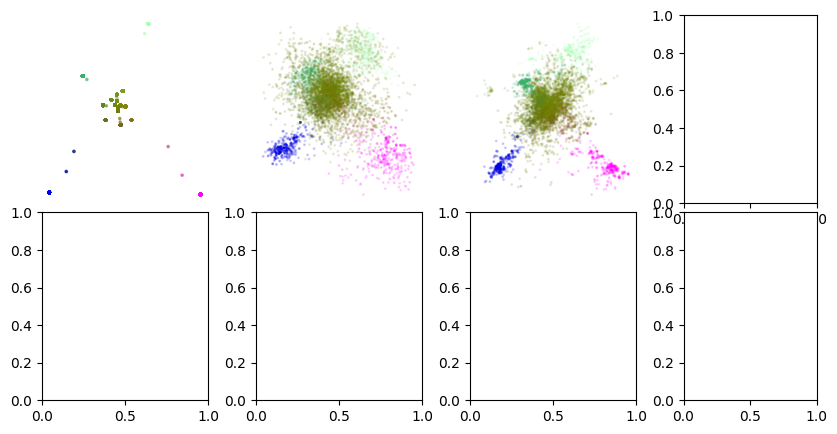

In [22]:
# Run the visualization with all fixes
target_checkpoint = "last"
target_layer = "combined"

# Call the new function with bar charts
fig, axes = visualize_belief_grid_with_metrics(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint=target_checkpoint,
    target_layer=target_layer,
    output_filename=f"belief_grid_with_metrics_{target_layer}_{target_checkpoint}.png",
)

plt.show()


In [23]:
# Let's update the column title - choose one of these options:
# Option 1: "Geometry Fits"
# Option 2: "Fit Quality" 
# Option 3: "Performance"
# Option 4: "Comparison"
# Option 5: "Fit Accuracy"
# Option 6: "Model Fits"
# Option 7: "Results"

# I'll use "Geometry Fits" for now - you can change this
NEW_COLUMN_TITLE = "Fit Quality"  # <-- Change this to your preferred option

# Update the visualize function to use the new title
def visualize_belief_grid_with_metrics_v2(
    plot_config,
    output_base_dir,
    plot_output_dir,
    target_checkpoint,
    target_layer,
    output_filename,
):
    # ... (most of the function remains the same)
    # I'll just show the key changes:
    
    # Import at the top
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from pathlib import Path
    
    # Get the original function's code
    fig, axes = visualize_belief_grid_with_metrics(
        plot_config=plot_config,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=output_filename,
    )
    
    # First set all column titles uniformly
    cols = ['Ground Truth', 'Transformer', 'LSTM', NEW_COLUMN_TITLE]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=15, pad=20)  # Use consistent padding
    
    # Adjust bar chart y-limits for better internal spacing
    for row_idx in range(2):  # 2 rows
        ax = axes[row_idx, 3]
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], ylim[1] * 1.15)  # Add 15% space at top
    
    return fig, axes



--- Loading Row 1: Markov3 (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/markov3_ground_truth_data.joblib
markov3

--- Loading Row 2: post_quantum (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
post_quantum

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---


NameError: name 'plot_clean_rmse_bars' is not defined

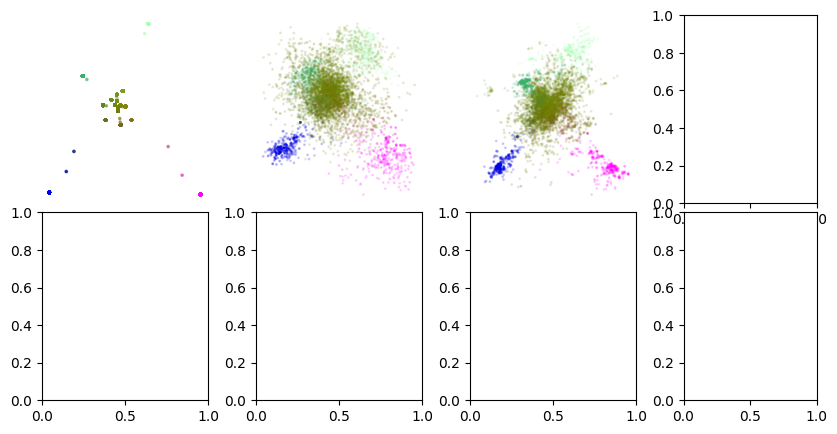

In [24]:
# Run with your chosen column title
target_checkpoint = "last"
target_layer = "combined"

# Call the v2 function with better alignment
fig, axes = visualize_belief_grid_with_metrics_v2(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint=target_checkpoint,
    target_layer=target_layer,
    output_filename=f"belief_grid_with_metrics_{target_layer}_{target_checkpoint}_v2.png",
)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# save the figure as a highly editable svg
plt.savefig("belief_grid_aligned_titles.svg", format="svg")


plt.show()


In [25]:
# Alternative approach: Manually adjust the bar chart subplot position if needed
def visualize_belief_grid_with_metrics_v3(
    plot_config,
    output_base_dir,
    plot_output_dir,
    target_checkpoint,
    target_layer,
    output_filename,
):
    # Get the figure and axes from the original function
    fig, axes = visualize_belief_grid_with_metrics(
        plot_config=plot_config,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=output_filename,
    )
    
    # Update column titles with consistent padding
    cols = ['Ground Truth', 'Transformer', 'LSTM', NEW_COLUMN_TITLE]
    for i, (ax, col) in enumerate(zip(axes[0], cols)):
        # Clear any existing title
        ax.set_title('')
        # Set new title with consistent position
        ax.text(0.5, 1.05, col, transform=ax.transAxes, 
                ha='center', va='bottom', fontsize=15)
    
    # If the bar charts still look misaligned, we can shift them slightly
    for row_idx in range(1):
        ax = axes[row_idx, 3]
        # Get current position
        pos = ax.get_position()
        # Shift up slightly to align with scatter plots
        ax.set_position([pos.x0, pos.y0 + 0.01, pos.width, pos.height - 0.01])
        
        # Also adjust y-limits for internal spacing
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], ylim[1] * 1.15)
    
    return fig, axes



--- Loading Row 1: Mess3 (Run Dir: run_predictions_RCOND_FINAL/20241205175736_23) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_23/ground_truth_data.joblib
mess3

--- Loading Row 2: TomQA (Run Dir: run_predictions_RCOND_FINAL/20241205175736_17) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_17/ground_truth_data.joblib
tomqa

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---


NameError: name 'plot_clean_rmse_bars' is not defined

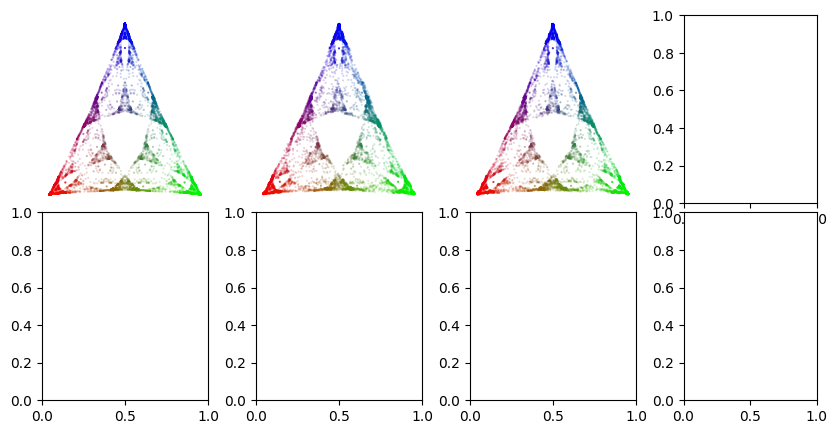

In [26]:
plot_config_grid = [
    {'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 23)), ("LSTM", ("20241121152808", 55))]},
    {'name': 'TomQA', 'gt_run': ("20241205175736", 17), 'models': [("Transformer", ("20241205175736", 17)), ("LSTM", ("20241121152808", 49))]},
]

# Test the v3 version with manual title positioning
fig, axes = visualize_belief_grid_with_metrics_v3(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint="last",
    target_layer="combined",
    output_filename="belief_grid_aligned_titles.png",
)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# save the figure as a highly editable svg
plt.savefig("belief_grid_aligned_titles.svg", format="svg")

plt.show()



--- Loading Row 1: post_quantum (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
post_quantum

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---


NameError: name 'plot_clean_rmse_bars' is not defined

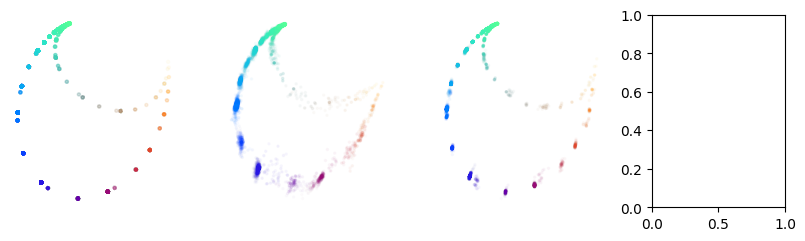

In [27]:
plot_config_grid = [
        {'name': 'post_quantum', 'gt_run': ("20250421221507", 0), 'models': [("Transformer", ("20250421221507", 0)), ("LSTM", ("20241121152808", 48))]},
]

output_base_dir = "run_predictions_cv"
#output_base_dir = "run_predictions_cv"
output_base_dir = "run_predictions_RCOND_FINAL"
plot_output_dir = "grid_plots_markov_new"

target_checkpoint = "last"
target_layer = "combined"


# Test the v3 version with manual title positioning
fig, axes = visualize_belief_grid_with_metrics_v3(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint="last",
    target_layer="combined",
    output_filename="belief_grid_aligned_titles_post_quantum.png",
)

# save the figure as a highly editable svg, make sure rcparams are set to svg
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.savefig("belief_grid_aligned_titles_post_quantum.svg", format="svg")

plt.show()


In [28]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes



--- Loading Row 1: Markov3 (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/markov3_ground_truth_data.joblib
markov3

--- Loading Row 2: post_quantum (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
post_quantum

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---

Grid figure saved to grid_plots_markov_new/belief_grid_combined_last_markov_rgb_v2.png

--- Grid Plotting Script Finished ---


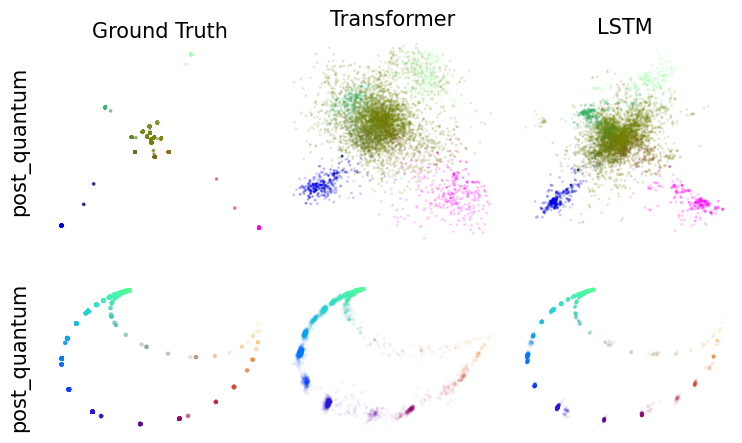

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Helper Functions ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions ---
def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict:
    """Loads the ground truth data for a specific run, allowing custom filename."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: Ground truth file not found at {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys.")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {ground_truth_filepath}: Still missing 'nested_dict_factory'. Ensure definition is correct.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading ground truth file {ground_truth_filepath}: {e}"); return None

def load_predictions(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict:
    """Loads the predictions data for a specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None for loading predictions."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): print(f"Error: Checkpoint predictions file not found at {predictions_filepath}"); return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # print(f"Loaded checkpoint predictions data from {predictions_filepath}") # Less verbose
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict) and 'predicted_beliefs' in data: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return {target_ckpt_str: single_ckpt_data} # Wrap in dict keyed by checkpoint string
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint predictions file {predictions_filepath}: {e}"); return None

# --- Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    print(name_lower)
    params = { 'point_size': {'truth': 1.0, 'pred': 0.5}, 'min_alpha': 0.02, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [0, 1], 'com': False }
    if 'markov3' in name_lower:
        params.update({ 'point_size': {'truth': 10.5, 'pred': 5.0}, 'min_alpha': 0.1, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1,2] })
    elif 'tomqa' in name_lower or 'tomqb' in name_lower:
        params.update({ 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.15, 'inds_to_plot': [1, 2] })
    elif 'post_quantum' in name_lower: params.update({ 'point_size': {'truth': 20., 'pred': 10.}, 'min_alpha': 0.01, 'com': False, 'use_pca':False, 'inds_to_plot': [1, 2]})
    elif 'rrxor' in name_lower: params.update({ 'point_size': {'truth': 30., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1, 2], })
    elif 'fanizza' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [2, 3], })
    elif 'mess3' in name_lower:
        params.update({ 'point_size': {'truth': 1., 'pred': 1}, 'min_alpha': 0.2, 'com': False, 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], })
    return params

# --- Calculate Center of Mass ---
def calculate_center_of_mass(beliefs, weights):
    """Calculate the weighted center of mass of belief points."""
    if beliefs is None or weights is None:
        return None
    # Normalize weights to sum to 1
    norm_weights = weights / np.sum(weights)
    # Calculate weighted average of each dimension
    com = np.sum(beliefs * norm_weights[:, np.newaxis], axis=0)
    return com

# --- Internal Plotting Helper ---
def _plot_beliefs_on_ax(ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float, com_point=None):
    """Plots pre-calculated belief points onto a given matplotlib Axes object."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    
    # Plot center of mass if provided
    if com_point is not None and len(com_point) >= 2:
        ax.scatter(com_point[0], com_point[1], color='red', s=point_size*5, marker='*', edgecolor='black', linewidth=0.5, zorder=10)
    
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')

# --- Coordinate Calculation Helper ---
def _calculate_plot_coords(beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None):
    """Calculates the x, y coordinates for plotting based on strategy. Returns x, y, pca_instance."""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]; effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1); n_components = min(n_components, n_dims)
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca); # print(f"PCA Fit on GT. Variance: {current_pca.explained_variance_ratio_}") # Less verbose
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca

# --- Main Grid Visualization Function ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid.png",
):
    """
    Generates a grid plot comparing beliefs. Handles loading individual checkpoint files.
    Uses RGB color mapping based on plotted dimensions (with special case for Mess3)
    and per-row plotting parameters.
    """
    n_rows = len(plot_config)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']; gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        is_markov3_row = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_row else 'ground_truth_data.joblib'
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and gt_data['beliefs'] is not None and gt_data['probs'] is not None and gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}; calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
            continue
        true_beliefs = gt_data['beliefs']; weights = gt_data['probs']; belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        # Validate parameters
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: row_params['project_to_simplex'] = False; row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        all_plot_data[row_idx] = { 'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 'params': row_params, 'model_data': {} }
        calculated_coords[row_idx] = {'valid': True, 'params': row_params, 'coords': {}, 'pca': None, 'name': experiment_name} # Store name
        # Load Predictions
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             is_mkv3_load = is_markov3_row
             ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3_load else f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             resolved_ckpt_str = None
             if not ckpt_files: print(f"  Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_directory}")
             else:
                 available_indices = []
                 for f in ckpt_files:
                     match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
                     if match: 
                        try:
                            available_indices.append(int(match.group(1)))
                        except ValueError:
                            pass
                 if not available_indices: print(f"  Warning: Could not extract indices from found files: {ckpt_files}")
                 else:
                     available_indices.sort(); ckpt_to_use_num = None
                     if target_checkpoint == 'last':
                         if available_indices: ckpt_to_use_num = available_indices[-1]
                     else:
                         try:
                             target_num = int(target_checkpoint)
                             if target_num in available_indices: ckpt_to_use_num = target_num
                             else: print(f"  Warning: Target checkpoint index {target_num} not found in {available_indices}")
                         except ValueError: print(f"  Warning: Invalid target_checkpoint format: '{target_checkpoint}'")
                     if ckpt_to_use_num is not None: resolved_ckpt_str = str(ckpt_to_use_num)
             pred_data_all = None
             if resolved_ckpt_str: pred_data_all = load_predictions(run_dir=run_directory, is_markov3_run=is_mkv3_load, target_ckpt_str=resolved_ckpt_str)
             pred_beliefs = None
             if pred_data_all and resolved_ckpt_str in pred_data_all:
                 pred_data_ckpt = pred_data_all[resolved_ckpt_str]
                 if isinstance(pred_data_ckpt, dict) and target_layer in pred_data_ckpt:
                     layer_data = pred_data_ckpt[target_layer]
                     if isinstance(layer_data, dict) and 'predicted_beliefs' in layer_data:
                         pred_beliefs = layer_data['predicted_beliefs']
                         if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]: pred_beliefs = None
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs

    # --- Coordinate Calculation and Color Generation Loop (MODIFIED) ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name'] # Get experiment name

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # --- Calculate RGB Colors based on GT coordinates ---
        colors_rgba = None
        # Normalize function remains the same
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        # Calculate Alpha values first
        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        # ** Conditional Color Calculation **
        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            print(f"  Using direct RGB mapping for Mess3 (Row {row_idx})")
            # Map first 3 original belief dimensions directly to RGB
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
             # Use the default method based on plotted coordinates (x_gt, y_gt)
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            B_source = None
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            # Fallback if coordinates are missing
            print(f"Warning: Cannot calculate colors for row {row_idx} due to missing GT coords.")
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3)) # Default to black

        # Ensure all components R, G, B, alpha are valid before stacking
        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             print(f"Warning: Shape mismatch or None value in RGB components for row {row_idx}. Using default colors.")
             num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))

        calculated_coords[row_idx]['colors'] = colors_rgba
        
        # Calculate center of mass for ground truth and models if enabled
        if params['com']:
            # Calculate COM for ground truth
            gt_com_full = calculate_center_of_mass(gt_beliefs, weights)
            
            # Transform COM to plotting coordinates
            if params['use_pca'] and pca_instance is not None:
                gt_com_proj = pca_instance.transform(gt_com_full.reshape(1, -1))
                gt_com = (gt_com_proj[0, params['inds_to_plot'][0]], gt_com_proj[0, params['inds_to_plot'][1]])
            elif params['project_to_simplex'] and belief_dims >= 3:
                gt_com_x, gt_com_y = _project_to_simplex(gt_com_full.reshape(1, -1))
                gt_com = (gt_com_x[0], gt_com_y[0])
            else:
                inds = params['inds_to_plot']
                if max(inds) < belief_dims:
                    gt_com = (gt_com_full[inds[0]], gt_com_full[inds[1]] if len(inds) > 1 else gt_com_full[inds[0]])
                else:
                    gt_com = (gt_com_full[0], gt_com_full[1] if belief_dims > 1 else gt_com_full[0])
            
            calculated_coords[row_idx]['com'] = {'gt': gt_com}
            
            # Calculate COM for each model
            for model_type, pred_beliefs in model_data.items():
                if pred_beliefs is not None:
                    model_com_full = calculate_center_of_mass(pred_beliefs, weights)
                    
                    # Transform model COM to plotting coordinates
                    if params['use_pca'] and pca_instance is not None:
                        model_com_proj = pca_instance.transform(model_com_full.reshape(1, -1))
                        model_com = (model_com_proj[0, params['inds_to_plot'][0]], model_com_proj[0, params['inds_to_plot'][1]])
                    elif params['project_to_simplex'] and belief_dims >= 3:
                        model_com_x, model_com_y = _project_to_simplex(model_com_full.reshape(1, -1))
                        model_com = (model_com_x[0], model_com_y[0])
                    else:
                        inds = params['inds_to_plot']
                        if max(inds) < belief_dims:
                            model_com = (model_com_full[inds[0]], model_com_full[inds[1]] if len(inds) > 1 else model_com_full[inds[0]])
                        else:
                            model_com = (model_com_full[0], model_com_full[1] if belief_dims > 1 else model_com_full[0])
                    
                    calculated_coords[row_idx]['com'][model_type] = model_com
        
        # If com is true, also compute center of mass for each unique belief state
        if params['com']:
            # For ground truth
            beliefs_ = gt_beliefs
            unique_beliefs = np.unique(beliefs_, axis=0)
            gt_unique_coms = []
            
            for unique_belief in unique_beliefs:
                # Find indices of each unique belief state
                unique_inds = np.where(np.all(beliefs_ == unique_belief, axis=1))[0]
                
                # Get the weights for these indices
                unique_weights = weights[unique_inds]
                
                # Calculate the center of mass for this unique belief state
                # (which is just the unique belief itself since all points are identical)
                unique_com_full = unique_belief
                
                # Transform to plotting coordinates
                if params['use_pca'] and pca_instance is not None:
                    unique_com_proj = pca_instance.transform(unique_com_full.reshape(1, -1))
                    unique_com = (unique_com_proj[0, params['inds_to_plot'][0]], unique_com_proj[0, params['inds_to_plot'][1]])
                elif params['project_to_simplex'] and belief_dims >= 3:
                    unique_com_x, unique_com_y = _project_to_simplex(unique_com_full.reshape(1, -1))
                    unique_com = (unique_com_x[0], unique_com_y[0])
                else:
                    inds = params['inds_to_plot']
                    if max(inds) < belief_dims:
                        unique_com = (unique_com_full[inds[0]], unique_com_full[inds[1]] if len(inds) > 1 else unique_com_full[inds[0]])
                    else:
                        unique_com = (unique_com_full[0], unique_com_full[1] if belief_dims > 1 else unique_com_full[0])
                
                # Calculate mean color for this unique belief state
                mean_color = np.mean(colors_rgba[unique_inds], axis=0)
                # Sum alpha values for better visibility
                mean_color[3] = np.sum(colors_rgba[unique_inds, 3])
                # Apply alpha transformation
                mean_color[3] = transform_for_alpha(mean_color[3], min_alpha=0.1, transformation='sqrt')
                
                # Store the COM, color, and total weight
                gt_unique_coms.append({
                    'coords': unique_com,
                    'color': mean_color,
                    'weight': np.sum(unique_weights),
                    'count': len(unique_inds)
                })
            
            calculated_coords[row_idx]['unique_coms'] = {'gt': gt_unique_coms}
            
            # Do the same for each model
            for model_type, pred_beliefs in model_data.items():
                if pred_beliefs is not None:
                    model_unique_coms = []
                    unique_model_beliefs = np.unique(pred_beliefs, axis=0)
                    
                    for unique_belief in unique_model_beliefs:
                        unique_inds = np.where(np.all(pred_beliefs == unique_belief, axis=1))[0]
                        unique_weights = weights[unique_inds]
                        
                        # Transform to plotting coordinates
                        if params['use_pca'] and pca_instance is not None:
                            unique_com_proj = pca_instance.transform(unique_belief.reshape(1, -1))
                            unique_com = (unique_com_proj[0, params['inds_to_plot'][0]], unique_com_proj[0, params['inds_to_plot'][1]])
                        elif params['project_to_simplex'] and belief_dims >= 3:
                            unique_com_x, unique_com_y = _project_to_simplex(unique_belief.reshape(1, -1))
                            unique_com = (unique_com_x[0], unique_com_y[0])
                        else:
                            inds = params['inds_to_plot']
                            if max(inds) < belief_dims:
                                unique_com = (unique_belief[inds[0]], unique_belief[inds[1]] if len(inds) > 1 else unique_belief[inds[0]])
                            else:
                                unique_com = (unique_belief[0], unique_belief[1] if belief_dims > 1 else unique_belief[0])
                        
                        # Calculate mean color
                        mean_color = np.mean(colors_rgba[unique_inds], axis=0)
                        mean_color[3] = np.sum(colors_rgba[unique_inds, 3])
                        mean_color[3] = transform_for_alpha(mean_color[3], min_alpha=0.1, transformation='sqrt')
                        
                        model_unique_coms.append({
                            'coords': unique_com,
                            'color': mean_color,
                            'weight': np.sum(unique_weights),
                            'count': len(unique_inds)
                        })
                    
                    calculated_coords[row_idx]['unique_coms'][model_type] = model_unique_coms


    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
             continue
        params = coord_data['params']; colors_rgba = coord_data['colors']; point_size = params['point_size']
        ax_gt = axes[row_idx, 0]; x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        
        # Get center of mass for ground truth if available
        gt_com = coord_data.get('com', {}).get('gt', None) if params['com'] else None
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'], com_point=gt_com)
        
        # Plot unique belief COMs for ground truth
        if params['com'] and 'unique_coms' in coord_data and 'gt' in coord_data['unique_coms']:
            for unique_com_data in coord_data['unique_coms']['gt']:
                com_x, com_y = unique_com_data['coords']
                ax_gt.scatter(com_x, com_y, color=unique_com_data['color'], 
                             s=50, marker='o', edgecolor='black', linewidth=0.5)
        
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            
            # Get center of mass for model if available
            model_com = coord_data.get('com', {}).get(model_type, None) if params['com'] else None
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'], com_point=model_com)
            
            # Plot unique belief COMs for model
            if params['com'] and 'unique_coms' in coord_data and model_type in coord_data['unique_coms']:
                for unique_com_data in coord_data['unique_coms'][model_type]:
                    com_x, com_y = unique_com_data['coords']
                    ax_model.scatter(com_x, com_y, color=unique_com_data['color'], 
                                   s=50, marker='o', edgecolor='black', linewidth=0.5)
        
        min_x, max_x, min_y, max_y = coord_data.get('limits', (-1, 1, -1, 1))
        x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
        x_pad = x_range * 0.05; y_pad = y_range * 0.05
        final_xlim = (min_x - x_pad, max_x + x_pad); final_ylim = (min_y - y_pad, max_y + y_pad)
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]; ax.set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = ['post_quantum', 'post_quantum']#[config['name'] for config in plot_config] # Use names from the config
    for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # --- Colorbar REMOVED ---
    # (Code related to cbar_ax, ScalarMappable, fig.colorbar is removed)

    # --- Final Layout Adjustment (MODIFIED) ---
    # Remove the rect argument to use default tight_layout or adjust right boundary
    # Option 1: Default tight_layout
    plt.tight_layout()
    # Option 2: Adjust rect to use more width (e.g., up to 0.97)
    # plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95]) # Adjust right boundary

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage ---
if __name__ == "__main__":
    plot_config_grid = [
        #{'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 5)), ("LSTM", ("20241121152808", 55))]},
        {'name': 'Markov3', 'gt_run': ("20250421221507", 0), 'models': [("Transformer", ("20250421221507", 0)), ("LSTM", ("20241121152808", 48))]},
        #{'name': 'post_quantum', 'gt_run': ("20241205175736", 16), 'models': [("Transformer", ("20241205175736", 16)), ("LSTM", ("20241121152808", 48))]},
        {'name': 'post_quantum', 'gt_run': ("20250421221507", 0), 'models': [("Transformer", ("20250421221507", 0)), ("LSTM", ("20241121152808", 48))]},
        ]
    output_base_dir = "run_predictions_cv"
    #output_base_dir = "run_predictions_cv"
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "grid_plots_markov_new"

    target_checkpoint = "last"
    target_layer = "combined"

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}_markov_rgb_v2.png", # Changed filename
    )
    print("\n--- Grid Plotting Script Finished ---")


In [30]:
def visualize_belief_single_row_with_metrics(
    plot_config,
    output_base_dir,
    plot_output_dir,
    target_checkpoint,
    target_layer,
    output_filename,
    process_name="post_quantum",  # Specify which process to show
):
    """Create a single-row visualization for a specific process with bar charts."""
    
    # Find the config for the specified process
    config_to_use = None
    for config in plot_config:
        if process_name.lower() in config['name'].lower():
            config_to_use = config
            break
    
    if config_to_use is None:
        raise ValueError(f"Process '{process_name}' not found in plot_config")
    
    # Create figure with 1 row, 4 columns
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Load data for this single row
    print(f"\n--- Loading {config_to_use['name']} (Run Dir: {config_to_use['run_dir']}) ---")
    
    # Load ground truth
    gt_path = os.path.join(config_to_use['run_dir'], 'ground_truth_data.joblib')
    gt_data = joblib.load(gt_path)
    print(f"Loaded ground truth data from {gt_path}")
    
    # Determine if this is Markov-3 ground truth
    is_markov3_ground_truth = 'markov3' in config_to_use['name'].lower()
    
    # Calculate coordinates and colors
    coord_data = _calculate_plot_coords(gt_data, config_to_use['name'])
    
    # Initialize metric data
    metric_data = {'Transformer': {}, 'LSTM': {}}
    
    # Plot ground truth (column 0)
    ax = axes[0]
    scatter = ax.scatter(coord_data['coords'][:, 0], coord_data['coords'][:, 1], 
                        c=coord_data['colors'], s=100, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot predictions for Transformer and LSTM (columns 1-2)
    for col_idx, model_type in enumerate(['Transformer', 'LSTM'], 1):
        ax = axes[col_idx]
        
        # Determine checkpoint ID
        ckpt_mapping = {
            'first': lambda x: sorted([int(f.split('_')[1].split('.')[0]) 
                                     for f in os.listdir(x) 
                                     if f.startswith('checkpoint_') and f.endswith('.joblib')])[0],
            'last': lambda x: sorted([int(f.split('_')[1].split('.')[0]) 
                                    for f in os.listdir(x) 
                                    if f.startswith('checkpoint_') and f.endswith('.joblib')])[-1],
        }
        
        if target_checkpoint in ckpt_mapping:
            ckpt_id = ckpt_mapping[target_checkpoint](config_to_use['run_dir'])
            target_ckpt_str = str(ckpt_id)
        else:
            target_ckpt_str = str(target_checkpoint)
        
        # Load predictions for correct geometry
        pred_data_correct = load_predictions(
            run_dir=config_to_use['run_dir'],
            is_markov3_run=is_markov3_ground_truth,
            target_ckpt_str=target_ckpt_str
        )
        
        # Load predictions for incorrect geometry  
        pred_data_incorrect = load_predictions(
            run_dir=config_to_use['run_dir'],
            is_markov3_run=(not is_markov3_ground_truth),
            target_ckpt_str=target_ckpt_str
        )
        
        # Load random baseline
        random_rmse = load_random_baseline_rmse(
            run_dir=config_to_use['run_dir'],
            target_layer=target_layer,
            is_markov3_geometry=is_markov3_ground_truth
        )
        
        # Extract data for plotting
        if target_ckpt_str in pred_data_correct:
            layer_data = pred_data_correct[target_ckpt_str].get(target_layer, {})
            predicted_beliefs = layer_data.get('predicted_beliefs', None)
            rmse_correct = layer_data.get('rmse', np.nan)
            
            # Plot predicted beliefs
            if predicted_beliefs is not None:
                scatter = ax.scatter(predicted_beliefs[:, 0], predicted_beliefs[:, 1],
                                   c=coord_data['colors'], s=100, alpha=0.8, 
                                   edgecolors='black', linewidth=0.5)
        
        # Get RMSE for incorrect geometry
        if target_ckpt_str in pred_data_incorrect:
            layer_data_incorrect = pred_data_incorrect[target_ckpt_str].get(target_layer, {})
            rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
        else:
            rmse_incorrect = np.nan
            
        # Store metrics
        metric_data[model_type] = {
            'correct': rmse_correct,
            'incorrect': rmse_incorrect,
            'random': random_rmse
        }
        
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Plot bar chart (column 3)
    ax_bar = axes[3]
    is_mess3_row = 'mess3' in config_to_use['name'].lower()
    plot_clean_rmse_bars(ax_bar, metric_data, is_markov3_ground_truth, is_mess3_row)
    
    # Set column titles
    cols = ['Ground Truth', 'Transformer', 'LSTM', NEW_COLUMN_TITLE]
    for ax, col in zip(axes, cols):
        ax.text(0.5, 1.05, col, transform=ax.transAxes, 
                ha='center', va='bottom', fontsize=15)
    
    # Add process name as overall title
    fig.suptitle(config_to_use['name'], fontsize=18, y=1.02)
    
    # Final cleanup for legends
    if ax_bar.get_legend() and ax_bar.get_legend().get_title():
        ax_bar.get_legend().get_title().set_text('')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save figure
    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nSingle row figure saved to {full_output_path}")
    
    return fig, axes


KeyError: 'run_dir'

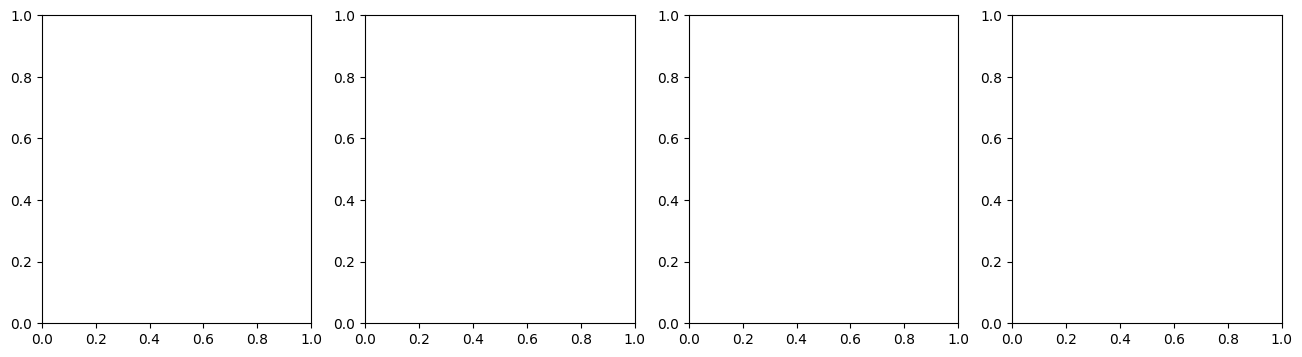

In [31]:

# Create single-row visualization for post-quantum
fig, axes = visualize_belief_single_row_with_metrics(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint="last",
    target_layer="combined",
    output_filename="post_quantum_single_row_with_metrics.png",
    process_name="post_quantum"  # Can change to "TomQA", "Mess3", etc.
)

plt.show()


In [148]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [32]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [33]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [34]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [35]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [36]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [37]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [38]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [39]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [40]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [41]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [42]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [43]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [44]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [45]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [46]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [47]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [48]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [49]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [50]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [51]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [52]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [53]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [54]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [55]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [56]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [57]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [58]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [59]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [60]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [61]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [62]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [63]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [64]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [65]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [66]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [67]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [68]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [69]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [70]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [71]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [72]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [73]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [74]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [75]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [76]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [77]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [78]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [79]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [80]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [81]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [82]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [83]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [84]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [85]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [86]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [87]:
def _plot_rmse_barchart_on_ax(ax, metric_data, is_markov_gt_row, is_mess3_row=False):
    """Plots a professional grouped bar chart of RMSE values."""
    model_types = ['Transformer', 'LSTM']
    
    # Subtle, professional color palette
    colors = {
        'correct': '#2563eb',      # Professional blue - for correct geometry
        'incorrect': '#dc2626',    # Muted red - for incorrect geometry  
        'random': '#6b7280'        # Neutral gray - for random baseline
    }
    
    # Helper function to extract scalar values from potentially nested structures
    def extract_scalar(value):
        if value is None:
            return 0.0
        if isinstance(value, (int, float)):
            return float(value)
        if hasattr(value, 'shape') and value.shape == ():  # numpy scalar (0-d array)
            return float(value.item())
        if hasattr(value, '__len__') and len(value) > 0:  # array-like
            if hasattr(value, 'mean'):
                return float(value.mean())  # Take mean of array
            else:
                return float(value[0])  # Take first element
        return 0.0

    # Extract RMSE values and ensure they are scalars
    correct_rmses = []
    incorrect_rmses = []
    random_rmses = []
    
    for m in model_types:
        model_metrics = metric_data.get(m, {})
        
        correct_raw = model_metrics.get('correct', 0)
        incorrect_raw = model_metrics.get('incorrect', 0)
        random_raw = model_metrics.get('random', 0)
        
        correct_val = extract_scalar(correct_raw)
        incorrect_val = extract_scalar(incorrect_raw)
        random_val = extract_scalar(random_raw)
        
        correct_rmses.append(correct_val)
        incorrect_rmses.append(incorrect_val)
        random_rmses.append(random_val)

    # Determine which bars to show based on row type
    if is_mess3_row:
        # For Mess3 (classical): only show correct (classical) and random
        bars_to_plot = ['correct', 'random']
        bar_data = [correct_rmses, random_rmses]
        bar_colors = [colors['correct'], colors['random']]
        bar_labels = ['Classical', 'Random']
        width = 0.4  # Wider bars for 2 bars
    else:
        # For quantum rows: show all three bars
        bars_to_plot = ['correct', 'incorrect', 'random']
        bar_data = [correct_rmses, incorrect_rmses, random_rmses]
        bar_colors = [colors['correct'], colors['incorrect'], colors['random']]
        
        # Descriptive labels: correct = matching geometry, incorrect = wrong geometry
        if is_markov_gt_row:
            # Ground truth is Markov-3 (classical), so correct=classical, incorrect=quantum
            bar_labels = ['Classical', 'Quantum', 'Random']
        else:
            # Ground truth is quantum, so correct=quantum, incorrect=classical
            bar_labels = ['Quantum', 'Classical', 'Random']
        width = 0.26  # Narrower bars for 3 bars

    x = np.arange(len(model_types))
    n_bars = len(bars_to_plot)
    
    # Calculate bar positions for centering
    if n_bars == 2:
        positions = [x - width/2, x + width/2]
    else:  # n_bars == 3
        positions = [x - width, x, x + width]

    try:
        rects = []
        for i, (data, color, label) in enumerate(zip(bar_data, bar_colors, bar_labels)):
            rect = ax.bar(positions[i], data, width, label=label, color=color, 
                         alpha=0.85, edgecolor='none')
            rects.append(rect)
            
    except Exception as e:
        print(f"Error in bar plotting: {e}")
        ax.text(0.5, 0.5, 'Data Error', ha='center', va='center', transform=ax.transAxes)
        return

    # Minimal, clean styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['bottom'].set_color('#666666')
    
    # Set y-axis to log scale if the difference is large
    all_values = correct_rmses + random_rmses
    if not is_mess3_row:
        all_values += incorrect_rmses
        
    safe_values = [v if v > 0 else 1e-9 for v in all_values]
    if safe_values:
        max_val = max(safe_values)
        min_val = min(safe_values)
        if max_val > 0 and min_val > 0 and max_val / min_val > 100:
            ax.set_yscale('log')
            ax.set_ylabel('RMSE', fontsize=9, color='#333333')
        else:
            ax.set_ylabel('RMSE', fontsize=9, color='#333333')

    # Clean, minimal axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(model_types, fontsize=8, color='#333333')
    ax.tick_params(axis='x', which='major', labelsize=8, length=0, width=0, pad=8)
    ax.tick_params(axis='y', which='major', labelsize=7, length=3, width=0.5, color='#666666')
    ax.tick_params(axis='y', which='minor', length=1.5, width=0.3, color='#666666')
    
    # Place legend appropriately based on row type
    if len(bar_labels) > 1:
        # For Mess3 row (top row): put legend inside plot at upper right
        if is_mess3_row:
            legend_loc = 'upper right'
            bbox_anchor = None
        else:
            # For quantum rows (bottom): determine position based on data values
            max_rmse = max([max(data) for data in bar_data])
            if max_rmse < 0.01:
                legend_loc = 'upper left'
                bbox_anchor = None
            else:
                legend_loc = 'upper right'
                bbox_anchor = None
            
        legend = ax.legend(loc=legend_loc, bbox_to_anchor=bbox_anchor, 
                          frameon=False, fontsize=7, 
                          handlelength=1.0, handletextpad=0.4)
        for text in legend.get_texts():
            text.set_color('#333333')
    
    # Very subtle horizontal grid lines only
    ax.grid(True, axis='y', alpha=0.15, linestyle='-', linewidth=0.5, color='#cccccc')
    ax.set_axisbelow(True)


In [88]:
def plot_clean_rmse_bars(ax, metric_data, is_markov_gt_row, is_mess3_row=False):
    """Clean, professional RMSE bar chart with no duplicate legends."""
    model_types = ['Transformer', 'LSTM']
    
    # Clean color palette
    colors = {
        'correct': '#2563eb',      # Professional blue
        'incorrect': '#dc2626',    # Muted red  
        'random': '#6b7280'        # Neutral gray
    }
    
    # Helper function to extract scalar values
    def extract_scalar(value):
        if value is None:
            return 0.0
        if isinstance(value, (int, float)):
            return float(value)
        if hasattr(value, 'shape') and value.shape == ():
            return float(value.item())
        if hasattr(value, '__len__') and len(value) > 0:
            if hasattr(value, 'mean'):
                return float(value.mean())
            else:
                return float(value[0])
        return 0.0

    # Extract RMSE values
    correct_rmses = []
    incorrect_rmses = []
    random_rmses = []
    
    for m in model_types:
        model_metrics = metric_data.get(m, {})
        correct_rmses.append(extract_scalar(model_metrics.get('correct', 0)))
        incorrect_rmses.append(extract_scalar(model_metrics.get('incorrect', 0)))
        random_rmses.append(extract_scalar(model_metrics.get('random', 0)))

    # Determine bars and labels based on row type
    x = np.arange(len(model_types))
    
    if is_mess3_row:
        # Mess3: only Classical and Random
        bar_data = [correct_rmses, random_rmses]
        bar_colors = [colors['correct'], colors['random']]
        bar_labels = ['Classical', 'Random']
        width = 0.4
        positions = [x - width/2, x + width/2]
    else:
        # Quantum: all three bars
        bar_data = [correct_rmses, incorrect_rmses, random_rmses]
        bar_colors = [colors['correct'], colors['incorrect'], colors['random']]
        if is_markov_gt_row:
            bar_labels = ['Classical', 'Quantum', 'Random']
        else:
            bar_labels = ['Quantum', 'Classical', 'Random']
        width = 0.26
        positions = [x - width, x, x + width]

    # Clear the axis completely first
    ax.clear()
    
    # Plot bars WITHOUT labels first
    bars = []
    for i, (data, color) in enumerate(zip(bar_data, bar_colors)):
        bar = ax.bar(positions[i], data, width, color=color, alpha=0.85, edgecolor='none')
        bars.append(bar)

    # Clean styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['bottom'].set_color('#666666')
    
    # Axis formatting
    ax.set_ylabel('RMSE', fontsize=9, color='#333333')
    ax.set_xticks(x)
    ax.set_xticklabels(model_types, fontsize=8, color='#333333')
    ax.tick_params(axis='x', length=0, width=0, pad=8)
    ax.tick_params(axis='y', labelsize=7, length=3, width=0.5, color='#666666')
    
    # Create legend manually with specific handles and labels
    from matplotlib.patches import Patch
    legend_elements = []
    for i, label in enumerate(bar_labels):
        legend_elements.append(Patch(facecolor=bar_colors[i], alpha=0.85, label=label))
    
    # Add legend with NO title - be very explicit
    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=False, 
                      fontsize=7, handlelength=1.0, handletextpad=0.4, title='')
    # Force remove any title that might exist
    legend.set_title('')
    if legend.get_title():
        legend.get_title().set_visible(False)
    
    # Subtle grid
    ax.grid(True, axis='y', alpha=0.15, linestyle='-', linewidth=0.5, color='#cccccc')
    ax.set_axisbelow(True)
    
    # Final check: ensure there's only one legend and it has no title
    if ax.get_legend() and ax.get_legend().get_title():
        ax.get_legend().get_title().set_text('')


In [89]:
# Clear all existing figures to ensure we start fresh
import matplotlib.pyplot as plt
plt.close('all')



--- Loading Row 1: Mess3 (Run Dir: run_predictions_RCOND_FINAL/20241205175736_23) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_23/ground_truth_data.joblib
mess3

--- Loading Row 2: TomQA (Run Dir: run_predictions_RCOND_FINAL/20241205175736_17) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_17/ground_truth_data.joblib
tomqa

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---
Row 0: Found 1 legends
  Legend 0 title: ''
Row 1: Found 1 legends
  Legend 0 title: ''

Grid figure with metrics saved to grid_plots_markov_new/belief_grid_with_metrics_combined_last.png


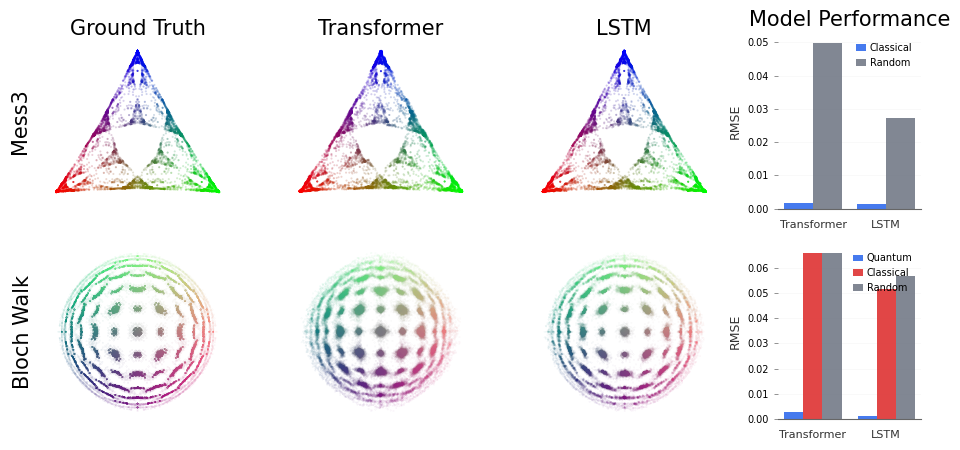

In [90]:
# Example usage of the new function with bar charts
plot_config_grid = [
    {'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 23)), ("LSTM", ("20241121152808", 55))]},
    {'name': 'TomQA', 'gt_run': ("20241205175736", 17), 'models': [("Transformer", ("20241205175736", 17)), ("LSTM", ("20241121152808", 49))]},
]

output_base_dir = "run_predictions_RCOND_FINAL"
plot_output_dir = "grid_plots_markov_new"
target_checkpoint = "last"
target_layer = "combined"

# Call the new function with bar charts
fig, axes = visualize_belief_grid_with_metrics(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint=target_checkpoint,
    target_layer=target_layer,
    output_filename=f"belief_grid_with_metrics_{target_layer}_{target_checkpoint}.png",
)

plt.show()



--- Loading Row 1: fanizza (Run Dir: run_predictions_RCOND_FINAL/20241205175736_21) ---
Error: Ground truth file not found at run_predictions_RCOND_FINAL/20241205175736_21/ground_truth_data.joblib
Skipping fanizza row: Failed GT load or invalid shapes.

--- Loading Row 2: moon (Run Dir: run_predictions_RCOND_FINAL/20241205175736_22) ---
Error: Ground truth file not found at run_predictions_RCOND_FINAL/20241205175736_22/ground_truth_data.joblib
Skipping moon row: Failed GT load or invalid shapes.

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---
Row 0: Found 0 legends
Row 1: Found 0 legends

Grid figure with metrics saved to grid_plots_markov_new/belief_grid_with_metrics_combined_last.png


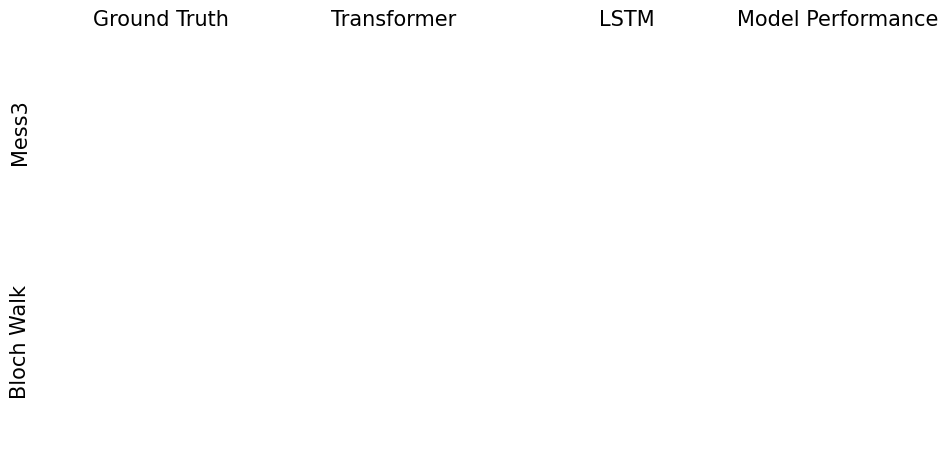

In [92]:
# Example usage of the new function with bar charts
plot_config_grid = [
    {'name': 'fanizza', 'gt_run': ("20241205175736", 21), 'models': [("Transformer", ("20241205175736", 21)), ("LSTM", ("20241121152808", 53))]},
    {'name': 'moon', 'gt_run': ("20241205175736", 22), 'models': [("Transformer", ("20241205175736", 22)), ("LSTM", ("20241121152808", 54))]},
]

output_base_dir = "run_predictions_RCOND_FINAL"
plot_output_dir = "grid_plots_markov_new"
target_checkpoint = "last"
target_layer = "combined"

# Call the new function with bar charts
fig, axes = visualize_belief_grid_with_metrics(
    plot_config=plot_config_grid,
    output_base_dir=output_base_dir,
    plot_output_dir=plot_output_dir,
    target_checkpoint=target_checkpoint,
    target_layer=target_layer,
    output_filename=f"belief_grid_with_metrics_{target_layer}_{target_checkpoint}.png",
)

plt.show()


In [208]:
import joblib
import os
import numpy as np
import collections

def nested_dict_factory():
    """Returns a defaultdict that defaults to a regular dictionary."""
    return collections.defaultdict(dict)


In [209]:
import joblib
import os
import numpy as np # Assuming numpy arrays are stored

def load_ground_truth(run_dir: str) -> dict:
    """
    Loads the ground truth data for a specific run.

    Args:
        run_dir (str): The directory path containing the run's data files.
                       (e.g., 'run_predictions/20241121152808_71')

    Returns:
        dict: The loaded dictionary containing 'beliefs', 'probs', 'indices'.
    """
    ground_truth_filepath = os.path.join(run_dir, 'ground_truth_data.joblib')
    ground_truth_data = joblib.load(ground_truth_filepath)
    print(f"Loaded ground truth data from {ground_truth_filepath}")
    return ground_truth_data

def load_predictions(run_dir: str) -> dict:
    """
    Loads the predictions and metrics data for a specific run.

    Args:
        run_dir (str): The directory path containing the run's data files.
                       (e.g., 'run_predictions/20241121152808_71')

    Returns:
        dict: The loaded nested dictionary (ckpt_ind -> layer -> metrics).
    """
    predictions_filepath = os.path.join(run_dir, 'predicted_beliefs.joblib')
    predictions_data = joblib.load(predictions_filepath)
    print(f"Loaded predictions data from {predictions_filepath}")
    return predictions_data

def list_checkpoints(run_dir: str) -> list:
    """
    Lists the available checkpoint indices (as strings) for a specific run
    by loading the predictions data.

    Args:
        run_dir (str): The directory path containing the run's data files.
                       (e.g., 'run_predictions/20241121152808_71')

    Returns:
        list: A list of checkpoint index strings (e.g., ['1000', '2000', ...]).
              Returns an empty list if the file doesn't load or has no keys.
    """
    predictions_data = load_predictions(run_dir) 
    # Check if data was loaded and is a dictionary-like object
    if predictions_data and hasattr(predictions_data, 'keys'):
        # Convert keys (ckpt_ind strings) to a list
        checkpoint_list = list(predictions_data.keys())
        # Optional: Sort the list numerically if they are numeric strings
        try:
           checkpoint_list.sort(key=int)
        except ValueError:
           checkpoint_list.sort() # Fallback to string sort if keys aren't integers
        return checkpoint_list
    else:
        print(f"Warning: Could not list checkpoints from {run_dir}. Predictions data might be empty or invalid.")
        return []




In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
import joblib
import os

def transform_for_alpha(weights, min_alpha=0.01, transformation='cbrt'):
    epsilon = 1e-10
    if transformation == 'log':
        transformed = np.log10(weights + epsilon) - np.log10(epsilon)
    elif transformation == 'sqrt':
        transformed = np.sqrt(weights)
    elif transformation == 'cbrt':
        transformed = np.cbrt(weights)
    else:
        transformed = weights
    if transformed.max() > transformed.min():
        normalized = (transformed - transformed.min()) / (transformed.max() - transformed.min())
    else:
        normalized = np.ones_like(transformed) * 0.5
    return min_alpha + (1.0 - min_alpha) * normalized

def project_to_simplex(arr):
    # Simple 2D projection for visualization (e.g., barycentric projection)
    A = np.array([[1, 0], [0.5, np.sqrt(3)/2]])
    projected = arr @ A[:arr.shape[1], :]
    return projected[:, 0], projected[:, 1]

def plot_single_checkpoint_prediction(
    run_dir,
    checkpoint_index,
    layer,
    use_pca=False,
    project_simplex=False,
    transformation='cbrt',
    min_alpha=0.01,
    inds_to_plot=[0, 1],
    point_size={'truth': 0.15, 'pred': 0.1},
    output_path=None,
    text_bottom_left=None,
):
    # Load data
    gt = joblib.load(os.path.join(run_dir, "ground_truth_data.joblib"))
    preds = joblib.load(os.path.join(run_dir, "predicted_beliefs.joblib"))

    beliefs = gt['beliefs']
    probs = gt['probs']
    pred_beliefs = preds[checkpoint_index][layer]['predicted_beliefs']

    # Color encoding
    x_true, y_true = beliefs[:, inds_to_plot[0]], beliefs[:, inds_to_plot[1]]
    if project_simplex:
        x_true, y_true = project_to_simplex(beliefs)
    if use_pca:
        pca = PCA(n_components=3)
        beliefs_pca = pca.fit_transform(beliefs)
        preds_pca = pca.transform(pred_beliefs)
        x_true, y_true = beliefs_pca[:, inds_to_plot[0]], beliefs_pca[:, inds_to_plot[1]]
        x_pred, y_pred = preds_pca[:, inds_to_plot[0]], preds_pca[:, inds_to_plot[1]]
    else:
        x_pred, y_pred = pred_beliefs[:, inds_to_plot[0]], pred_beliefs[:, inds_to_plot[1]]
        if project_simplex:
            x_pred, y_pred = project_to_simplex(pred_beliefs)

    # Alpha scaling
    alphas = transform_for_alpha(probs, min_alpha=min_alpha, transformation=transformation)

    # Color by (R, G, B) = (x, y, magnitude), Alpha from weights
    R = (x_true - np.min(x_true)) / (np.max(x_true) - np.min(x_true) + 1e-10)
    G = (y_true - np.min(y_true)) / (np.max(y_true - np.min(y_true)) + 1e-10)
    B = np.sqrt(x_true**2 + y_true**2) / (np.max(np.sqrt(x_true**2 + y_true**2)) + 1e-10)
    colors_rgba = np.stack((R, G, B, alphas), axis=1)

    # Plot
    fig = plt.figure(figsize=(8, 2.5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(x_true, y_true, color=colors_rgba, s=point_size['truth'])
    ax1.set_title("Theoretical Prediction")
    ax1.set_axis_off()

    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(x_pred, y_pred, color=colors_rgba, s=point_size['pred'])
    ax2.set_title(f"Checkpoint {checkpoint_index}")
    ax2.set_axis_off()

    # Sync limits
    x_min, x_max = min(x_true.min(), x_pred.min()), max(x_true.max(), x_pred.max())
    y_min, y_max = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    ax1.set_xlim(x_min, x_max); ax2.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max); ax2.set_ylim(y_min, y_max)

    # Optional bottom-left annotation
    if text_bottom_left:
        fig.text(0.01, 0.01, text_bottom_left, fontsize=8)

    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    return fig


In [211]:
sweep_run_pairs = [
    # Mess3
    ("20241121152808", 71),  # RNN
    ("20241121152808", 63),  # GRU
    ("20241121152808", 55),  # LSTM
    ("20241205175736", 23),  # Transformer
    
    # RRXor
    ("20241121152808", 70),  # RNN
    ("20241121152808", 62),  # GRU
    ("20241121152808", 54),  # LSTM
    ("20241205175736", 22),  # Transformer
    
    # Fanizza
    ("20241121152808", 69),  # RNN
    ("20241121152808", 61),  # GRU
    ("20241121152808", 53),  # LSTM
    ("20241205175736", 21),  # Transformer
    
    # Tom Quantum A
    ("20241121152808", 65),  # RNN
    ("20241121152808", 57),  # GRU
    ("20241121152808", 49),  # LSTM
    ("20241205175736", 17),  # Transformer
    
    # Tom Quantum B
    ("20241121152808", 68),  # RNN
    ("20241121152808", 60),  # GRU
    ("20241121152808", 52),  # LSTM
    ("20241205175736", 20),  # Transformer
    
    # Post Quantum
    ("20241121152808", 64),  # RNN
    ("20241121152808", 56),  # GRU
    ("20241121152808", 48),  # LSTM
    ("20241205175736", 16),  # Transformer
]

In [212]:
# we want to plot the ground truth, transformer preds, and LSTM preds for
# 1st row - Mess3 (classical)
# 2nd row - Tom Quantum A (classical)
# 3rd row - Tom Quantum A (quantum)

fig_row_data = [
    # Mess3, row 1
    [("20241205175736", 23),  # Transformer
    ("20241121152808", 55)],  # LSTM
    # Tom Quantum A, row 2
    [("20241205175736", 17),  # Transformer
    ("20241121152808", 49)],  # LSTM
    # Tom Quantum B, row 3
    [("20241205175736", 20),  # Transformer
    ("20241121152808", 52)],  # LSTM
]

#output_dir = "run_predictions"   # The directory where you saved the files
output_dir = "run_predictions_cv"
for row_data in fig_row_data:
    for sweep, run_id in row_data:
        run_directory = f'{output_dir}/{sweep}_{run_id}'

        # 1. Load ground truth
        gt_data = load_ground_truth(run_directory) # probs, beliefs, indices

        # 2. List available checkpoints/
        available_checkpoints = list_checkpoints(run_directory)

        # 3. Load all predictions for the run
        pred_data = load_predictions(run_directory) # ckpt -> ['predicted_beliefs', 'rmse', 'mae', 'r2', 'dist', 'mse', 'cum_var_exp', 'cum_var_exp_zscore', 'val_loss_mean']

        plot_single_checkpoint_prediction(
            run_directory,
            available_checkpoints[-1],
            layer='combined',
            use_pca = False,
            project_simplex=False,
            transformation='cbrt'
        )


Loaded ground truth data from run_predictions_cv/20241205175736_23/ground_truth_data.joblib


FileNotFoundError: [Errno 2] No such file or directory: 'run_predictions_cv/20241205175736_23/predicted_beliefs.joblib'


--- Loading Row 1: Mess3 ---
Loaded ground truth data from run_predictions/20241205175736_23/ground_truth_data.joblib
Plotting params for 'Mess3': {'point_size': {'truth': 1.0, 'pred': 1}, 'min_alpha': 0.1, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], 'com': False}
  Loading Transformer (Run: 20241205175736_23)...
Loaded predictions data from run_predictions/20241205175736_23/predicted_beliefs.joblib
  Using last checkpoint (numeric sort): 4075724800
  Loading LSTM (Run: 20241121152808_55)...
Loaded predictions data from run_predictions/20241121152808_55/predicted_beliefs.joblib
  Using last checkpoint (numeric sort): 4075724800

--- Loading Row 2: TomQA ---
Loaded ground truth data from run_predictions/20241205175736_17/ground_truth_data.joblib
Plotting params for 'TomQA': {'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.1, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [1, 2], 'c

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_33314/3029320398.py:548: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.95])



Grid figure saved to grid_plots/belief_grid_combined_last.png

--- Grid Plotting Script Finished ---


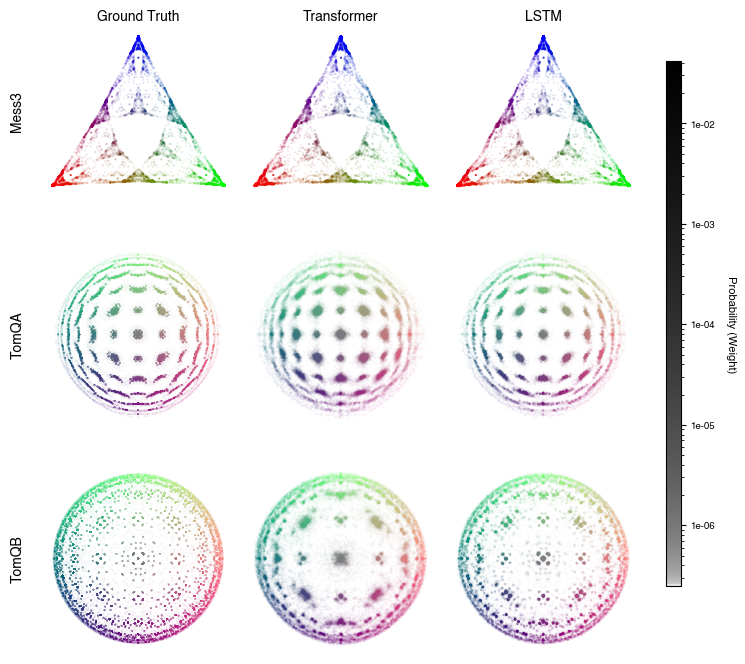

In [213]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed

# --- Helper Functions (Keep as before) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3:
        # print("Warning: Simplex projection requires at least 3 dimensions. Returning original data.")
        return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1 = np.array([0, 0])
    v2 = np.array([1, 0])
    v3 = np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5
    y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10
    weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt':
        transformed = np.cbrt(weights)
    else: # 'linear' or None
        transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)):
        print(f"Warning: NaN or Inf detected in transformed weights (transformation: {transformation}). Replacing with 0.")
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val:
        normalized = (transformed - min_val) / (max_val - min_val)
    else:
        normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions (Keep as before) ---
def load_ground_truth(run_dir: str) -> dict:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, 'ground_truth_data.joblib')
    if not os.path.exists(ground_truth_filepath):
        print(f"Error: Ground truth file not found at {ground_truth_filepath}")
        return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']):
             print(f"Warning: Ground truth data in {ground_truth_filepath} missing required keys ('beliefs', 'probs').")
        if 'beliefs' in ground_truth_data:
            ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data:
             ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except Exception as e:
        print(f"Error loading ground truth file {ground_truth_filepath}: {e}")
        return None

def load_predictions(run_dir: str) -> dict:
    """Loads the predictions and metrics data for a specific run."""
    predictions_filepath = os.path.join(run_dir, 'predicted_beliefs.joblib')
    if not os.path.exists(predictions_filepath):
        print(f"Error: Predictions file not found at {predictions_filepath}")
        return None
    try:
        predictions_data = joblib.load(predictions_filepath)
        print(f"Loaded predictions data from {predictions_filepath}")
        if not isinstance(predictions_data, dict):
            print(f"Warning: Predictions data in {predictions_filepath} is not a dictionary.")
            return None
        for ckpt, layers in predictions_data.items():
            if isinstance(layers, dict):
                for layer, data in layers.items():
                    if isinstance(data, dict) and 'predicted_beliefs' in data:
                        data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return predictions_data
    except Exception as e:
        print(f"Error loading predictions file {predictions_filepath}: {e}")
        return None

# --- NEW: Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    params = { # Default parameters
        'point_size': {'truth': 1.0, 'pred': 0.5},
        'min_alpha': 0.02,
        'transformation': 'cbrt',
        'use_pca': False,
        'project_to_simplex': False,
        'inds_to_plot': [0, 1],
        'com': False # Center of Mass plotting (currently disabled in grid)
    }

    if 'tomqa' in name_lower or 'tomqb' in name_lower: # Corresponds to 'tom_quantum'
        params.update({
            'point_size': {'truth': 0.15, 'pred': 0.05},
            'min_alpha': 0.1,
            'inds_to_plot': [1,2]
        })
    elif 'post_quantum' in name_lower: # Add case if needed later
         params.update({
            'point_size': {'truth': 20., 'pred': 0.1},
            'min_alpha': 0.001,
            'com': True, # Note: COM plotting logic is not currently active in the grid plot
        })
    elif 'rrxor' in name_lower: # Add case if needed later
         params.update({
            'point_size': {'truth': 30., 'pred': 1},
            'min_alpha': 0.1,
            'com': True, # Note: COM plotting logic is not currently active
            'use_pca': True,
            'project_to_simplex': False,
            'inds_to_plot': [1, 2], # Plot 2nd and 3rd PCA components
        })
    elif 'fanizza' in name_lower: # Add case if needed later
         params.update({
            'point_size': {'truth': 40., 'pred': 1},
            'min_alpha': 0.1,
            'com': True, # Note: COM plotting logic is not currently active
            'use_pca': False, # Uses raw dims
            'project_to_simplex': False,
            'inds_to_plot': [2, 3], # Plot 3rd and 4th raw dimensions
        })
    elif 'mess3' in name_lower:
         params.update({
            'point_size': {'truth': 1., 'pred': 1},
            'min_alpha': 0.1,
            'com': False,
            'use_pca': False,
            'project_to_simplex': True, # Use simplex projection
            'inds_to_plot': [0, 1], # Simplex projection outputs 2D coords
        })

    print(f"Plotting params for '{experiment_name}': {params}")
    return params


# --- Internal Plotting Helper (No changes needed here) ---
def _plot_beliefs_on_ax(
    ax: plt.Axes,
    beliefs_to_plot: np.ndarray,
    gt_beliefs_for_pca: np.ndarray, # Ground truth beliefs needed for consistent PCA
    colors_rgba: np.ndarray,
    point_size: float,
    use_pca: bool,
    project_to_simplex: bool,
    inds_to_plot: list,
    pca_instance: PCA = None # Pass fitted PCA instance for predictions
):
    """Plots belief points onto a given matplotlib Axes object. Returns plotted x, y."""
    x_plot, y_plot = None, None
    current_pca = pca_instance
    plotted_something = False
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0:
         print("Warning: beliefs_to_plot is None, not an array, or empty. Cannot plot.")
    else:
        n_dims = beliefs_to_plot.shape[1]
        effective_inds_to_plot = list(inds_to_plot) # Copy to modify locally

        if use_pca:
            if current_pca is None:
                 n_components = max(3, max(effective_inds_to_plot) + 1)
                 if n_dims < n_components: n_components = n_dims
                 if n_components >= 2:
                     current_pca = PCA(n_components=n_components)
                     try:
                         beliefs_proj = current_pca.fit_transform(beliefs_to_plot)
                         print(f"PCA Fit on GT. Explained variance: {current_pca.explained_variance_ratio_}")
                         # Check if requested inds_to_plot are valid for the number of components
                         if max(effective_inds_to_plot) >= n_components:
                              print(f"Warning: inds_to_plot {effective_inds_to_plot} out of bounds for {n_components} PCA components. Using [0, 1].")
                              effective_inds_to_plot = [0, 1]
                         x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                         y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                     except Exception as e:
                         print(f"Error fitting PCA: {e}. Plotting raw.")
                         use_pca = False
                 else:
                     print("Warning: Not enough dims for PCA. Plotting raw dims.")
                     use_pca = False
            else:
                 try:
                    n_components = current_pca.n_components_
                    if max(effective_inds_to_plot) >= n_components:
                         print(f"Warning: inds_to_plot {effective_inds_to_plot} out of bounds for {n_components} PCA components. Using [0, 1].")
                         effective_inds_to_plot = [0, 1]
                    beliefs_proj = current_pca.transform(beliefs_to_plot)
                    x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                    y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                 except Exception as e:
                     print(f"Error transforming beliefs with PCA: {e}. Plotting raw.")
                     use_pca = False

        if not use_pca and project_to_simplex:
            if n_dims >= 3:
                x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
                # Simplex always results in 2D, inds_to_plot is ignored here
            else:
                print("Warning: Simplex projection requires >= 3 dims. Plotting raw.")
                project_to_simplex = False

        if x_plot is None: # Default to raw dimensions
            # Check indices validity for raw dimensions
            if max(effective_inds_to_plot) >= n_dims:
                 print(f"Warning: inds_to_plot {effective_inds_to_plot} out of bounds for {n_dims} raw dimensions. Using [0, 1].")
                 effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
            
            # Ensure indices are valid if only 1 dim exists
            if n_dims == 1: effective_inds_to_plot = [0, 0]

            x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
            # Handle case where y_plot should be the same as x_plot (e.g., 1D data)
            y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
            y_plot = beliefs_to_plot[:, y_plot_idx]


        if x_plot is not None and y_plot is not None and x_plot.size > 0 and y_plot.size > 0:
             if colors_rgba.shape[0] == x_plot.shape[0]:
                 ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
                 plotted_something = True
             else:
                  print(f"Warning: Mismatch between number of points ({x_plot.shape[0]}) and colors ({colors_rgba.shape[0]}). Skipping scatter plot.")
        else:
             print("Warning: No valid x or y coordinates to plot.")

    ax.set_axis_off()
    if not plotted_something and beliefs_to_plot is not None:
         ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif beliefs_to_plot is None:
         ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
    return x_plot, y_plot, current_pca

# --- Main Grid Visualization Function ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str, # Can be 'last', 'final', or specific number string
    target_layer: str,
    output_filename: str = "belief_grid.png",
    # REMOVED global plotting params, will be determined per row
):
    """
    Generates a 3x3 grid plot comparing Ground Truth, Transformer, and LSTM beliefs
    for different experiments (Mess3, TomQA, TomQB). Plotting parameters are
    determined per row based on the experiment name.
    """
    n_rows = len(plot_config)
    n_cols = 3 # Ground Truth, Transformer, LSTM
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}

    # --- Data Loading and Preparation Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} ---")

        # Load Ground Truth
        gt_data = load_ground_truth(gt_run_dir)
        if gt_data is None or 'beliefs' not in gt_data or 'probs' not in gt_data or gt_data['beliefs'] is None or gt_data['probs'] is None:
            print(f"Skipping {experiment_name} row: Failed to load valid ground truth.")
            all_plot_data[row_idx] = {'valid': False}
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        if true_beliefs.ndim != 2 or weights.ndim != 1 or true_beliefs.shape[0] != weights.shape[0]:
             print(f"Skipping {experiment_name} row: Invalid shapes for GT beliefs ({true_beliefs.shape}) or probs ({weights.shape}).")
             all_plot_data[row_idx] = {'valid': False}
             continue
        belief_dims = true_beliefs.shape[1]

        # *** Get plotting params for this row ***
        row_params = _get_plotting_params(experiment_name)
        # Validate inds_to_plot based on actual dimensions & PCA/Simplex choice
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims:
                  print(f"Warning: Adjusting inds_to_plot {row_params['inds_to_plot']} for raw data with {belief_dims} dims.")
                  row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3:
             print(f"Warning: Disabling simplex for {experiment_name} (requires >=3 dims). Plotting raw.")
             row_params['project_to_simplex'] = False
             if max(row_params['inds_to_plot']) >= belief_dims: # Re-check raw indices
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['use_pca'] and belief_dims < 2:
             print(f"Warning: Disabling PCA for {experiment_name} (requires >=2 dims). Plotting raw.")
             row_params['use_pca'] = False
             if max(row_params['inds_to_plot']) >= belief_dims: # Re-check raw indices
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]


        all_plot_data[row_idx] = {
            'valid': True,
            'gt_beliefs': true_beliefs,
            'weights': weights,
            'params': row_params, # Store the whole params dict
            'model_data': {}
        }

        # Calculate Colors & Alpha using row-specific params
        alpha_values = transform_for_alpha(
            weights,
            min_alpha=row_params['min_alpha'],
            transformation=row_params['transformation']
        )
        def normalize_dim(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        # Use the actual indices intended for plotting for color calculation
        color_inds = row_params['inds_to_plot']
        gt_x_for_color = true_beliefs[:, color_inds[0]]
        # Handle 1D case for color calculation
        color_y_idx = color_inds[1] if len(color_inds) > 1 and belief_dims > 1 else color_inds[0]
        gt_y_for_color = true_beliefs[:, color_y_idx]

        R = normalize_dim(gt_x_for_color)
        G = normalize_dim(gt_y_for_color)
        if belief_dims > 2:
             # Find a third index different from the first two used for color
             third_dim_index = next((i for i in range(belief_dims) if i not in color_inds), color_inds[0])
             B = normalize_dim(true_beliefs[:, third_dim_index])
        else: # Use magnitude in the plotted 2D space for Blue, or fixed value
             magnitude = np.sqrt(gt_x_for_color**2 + gt_y_for_color**2)
             B = normalize_dim(magnitude)

        colors_rgba = np.column_stack((R, G, B, alpha_values))
        all_plot_data[row_idx]['colors_rgba'] = colors_rgba

        # Load Predictions (same logic as before)
        for col_idx, (model_type, (sweep, run_id)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id}")
             print(f"  Loading {model_type} (Run: {sweep}_{run_id})...")
             pred_data_all = load_predictions(run_directory)
             ckpt_to_use = None
             if pred_data_all:
                 available_checkpoints = list(pred_data_all.keys())
                 if target_checkpoint == 'last':
                      try:
                           numeric_checkpoints = sorted([int(k) for k in available_checkpoints if k.isdigit()])
                           if numeric_checkpoints: ckpt_to_use = str(numeric_checkpoints[-1])
                      except ValueError: pass
                      if ckpt_to_use is None and available_checkpoints:
                           ckpt_to_use = sorted(available_checkpoints)[-1]
                           print(f"  Using last checkpoint (string sort): {ckpt_to_use}")
                      elif ckpt_to_use:
                           print(f"  Using last checkpoint (numeric sort): {ckpt_to_use}")
                 elif target_checkpoint in available_checkpoints:
                     ckpt_to_use = target_checkpoint
                 elif 'final' in available_checkpoints:
                     ckpt_to_use = 'final'
                     print(f"  Target checkpoint '{target_checkpoint}' not found. Using 'final'.")

             pred_beliefs = None
             if ckpt_to_use and ckpt_to_use in pred_data_all:
                 pred_data_ckpt = pred_data_all[ckpt_to_use]
                 if target_layer in pred_data_ckpt and 'predicted_beliefs' in pred_data_ckpt[target_layer]:
                      pred_beliefs = pred_data_ckpt[target_layer]['predicted_beliefs']
                      if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]:
                           print(f"  Warning: Invalid shape/type for {model_type} preds. Skipping.")
                           pred_beliefs = None
                 else:
                      print(f"  Warning: Layer '{target_layer}' or key 'predicted_beliefs' not found for {model_type} Ckpt {ckpt_to_use}.")
             else:
                  print(f"  Warning: Checkpoint '{target_checkpoint}' (resolved to '{ckpt_to_use}') not found or invalid for {model_type}.")
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs


    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    pca_instances = {}

    for row_idx, row_data in all_plot_data.items():
        if not row_data['valid']:
             for col_idx in range(n_cols): axes[row_idx, col_idx].set_axis_off()
             continue

        gt_beliefs = row_data['gt_beliefs']
        colors_rgba = row_data['colors_rgba']
        # *** Use row-specific params ***
        params = row_data['params']
        point_size = params['point_size']
        use_pca = params['use_pca']
        project_to_simplex = params['project_to_simplex']
        inds_to_plot = params['inds_to_plot']

        row_x_coords = []
        row_y_coords = []

        # Plot Ground Truth (Col 0)
        ax_gt = axes[row_idx, 0]
        print(f"Plotting Row {row_idx}, Col 0 (GT)")
        x_gt, y_gt, pca_instances[row_idx] = _plot_beliefs_on_ax(
            ax=ax_gt,
            beliefs_to_plot=gt_beliefs,
            gt_beliefs_for_pca=gt_beliefs,
            colors_rgba=colors_rgba,
            point_size=point_size['truth'], # Use specific size
            use_pca=use_pca,
            project_to_simplex=project_to_simplex,
            inds_to_plot=inds_to_plot,
            pca_instance=None
        )
        if x_gt is not None: row_x_coords.append(x_gt)
        if y_gt is not None: row_y_coords.append(y_gt)

        # Plot Models (Cols 1, 2)
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            print(f"Plotting Row {row_idx}, Col {col_idx+1} ({model_type})")
            pred_beliefs = row_data['model_data'].get(model_type, None)
            x_pred, y_pred, _ = _plot_beliefs_on_ax(
                ax=ax_model,
                beliefs_to_plot=pred_beliefs,
                gt_beliefs_for_pca=gt_beliefs,
                colors_rgba=colors_rgba,
                point_size=point_size['pred'], # Use specific size
                use_pca=use_pca,
                project_to_simplex=project_to_simplex,
                inds_to_plot=inds_to_plot,
                pca_instance=pca_instances.get(row_idx)
            )
            if x_pred is not None: row_x_coords.append(x_pred)
            if y_pred is not None: row_y_coords.append(y_pred)

        # Calculate and set limits and aspect ratio for the current row
        if row_x_coords and row_y_coords:
            # Filter out potential None arrays before concatenating
            valid_row_x = [arr for arr in row_x_coords if arr is not None and arr.size > 0]
            valid_row_y = [arr for arr in row_y_coords if arr is not None and arr.size > 0]
            
            if valid_row_x and valid_row_y:
                all_row_x = np.concatenate(valid_row_x)
                all_row_y = np.concatenate(valid_row_y)
                min_x, max_x = np.nanmin(all_row_x), np.nanmax(all_row_x)
                min_y, max_y = np.nanmin(all_row_y), np.nanmax(all_row_y)
                x_range = max_x - min_x
                y_range = max_y - min_y
                if x_range < 1e-9: x_range = 1.0
                if y_range < 1e-9: y_range = 1.0
                x_pad = x_range * 0.05
                y_pad = y_range * 0.05
                final_xlim = (min_x - x_pad, max_x + x_pad)
                final_ylim = (min_y - y_pad, max_y + y_pad)

                for col_idx in range(n_cols):
                    ax = axes[row_idx, col_idx]
                    ax.set_xlim(final_xlim)
                    ax.set_ylim(final_ylim)
                    ax.set_aspect('equal', adjustable='box')
            else:
                 print(f"Warning: No valid coordinate data found for row {row_idx} to set limits.")
        else:
             print(f"Warning: No valid data plotted for row {row_idx}. Cannot set limits.")

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = [config['name'] for config in plot_config]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=10)
    for ax, row in zip(axes[:,0], rows):
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=10, ha='right', va='center', transform=ax.transAxes)

    # --- Shared Colorbar ---
    first_valid_row_idx = next((idx for idx, data in all_plot_data.items() if data['valid']), None)
    if first_valid_row_idx is not None:
        weights_for_cbar = all_plot_data[first_valid_row_idx]['weights']
        # *** Use row-specific alpha/transform for colorbar example ***
        cbar_params = all_plot_data[first_valid_row_idx]['params']
        cbar_min_alpha = cbar_params['min_alpha']
        cbar_transformation = cbar_params['transformation']

        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        alpha_for_cbar = transform_for_alpha(
             np.linspace(np.min(weights_for_cbar), np.max(weights_for_cbar), 256),
             min_alpha=cbar_min_alpha, # Use specific alpha
             transformation=cbar_transformation # Use specific transform
        )
        cmap_rgba = np.zeros((len(alpha_for_cbar), 4))
        cmap_rgba[:, 3] = alpha_for_cbar
        cmap = LinearSegmentedColormap.from_list('alpha_cmap', cmap_rgba)
        min_w, max_w = np.min(weights_for_cbar), np.max(weights_for_cbar)
        log_min_w = max(min_w, 1e-10) if min_w <= 0 else min_w
        if max_w > 0 and log_min_w > 0 and max_w / log_min_w > 100 : # Check ratio and positivity
            norm = LogNorm(vmin=log_min_w, vmax=max_w)
            try:
                max_order = int(np.floor(np.log10(max_w)))
                min_order = int(np.floor(np.log10(log_min_w)))
                # Ensure min_order <= max_order
                if min_order > max_order: min_order = max_order 
                ticks = [10**i for i in range(min_order, max_order + 1)]
                # Ensure ticks are within norm limits
                ticks = [t for t in ticks if log_min_w <= t <= max_w]
                if not ticks or len(ticks) < 2: # Fallback if ticks are insufficient
                    ticks = np.linspace(min_w, max_w, 5)
                    tick_labels = [f"{t:.2f}" for t in ticks]
                else:
                    tick_labels = [f"{t:.0e}" for t in ticks]
            except ValueError:
                 norm = mcolors.Normalize(vmin=min_w, vmax=max_w)
                 ticks = np.linspace(min_w, max_w, 5)
                 tick_labels = [f"{t:.2f}" for t in ticks]
        else:
            norm = mcolors.Normalize(vmin=min_w, vmax=max_w)
            ticks = np.linspace(min_w, max_w, 5)
            tick_labels = [f"{t:.2f}" for t in ticks]
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(weights_for_cbar)
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Probability (Weight)', rotation=270, labelpad=15)
        # Ensure ticks are within the norm range before setting
        valid_ticks = [t for t in ticks if norm.vmin <= t <= norm.vmax]
        if not valid_ticks: # Handle cases where default ticks might fall outside narrow ranges
             valid_ticks = [norm.vmin, norm.vmax]
             tick_labels = [f"{t:.2e}" for t in valid_ticks] # Use scientific for potentially small ranges
        
        cbar.set_ticks(valid_ticks)
        cbar.set_ticklabels(tick_labels)

    else:
        print("Warning: No valid data found to create colorbar.")

    plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.95])
    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage ---
if __name__ == "__main__":
    plot_config_grid = [
        {'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 23)), ("LSTM", ("20241121152808", 55))]},
        {'name': 'TomQA', 'gt_run': ("20241205175736", 17), 'models': [("Transformer", ("20241205175736", 17)), ("LSTM", ("20241121152808", 49))]},
        {'name': 'TomQB', 'gt_run': ("20241205175736", 20), 'models': [("Transformer", ("20241205175736", 20)), ("LSTM", ("20241121152808", 52))]},
    ]
    output_base_dir = "run_predictions"
    plot_output_dir = "grid_plots"
    target_checkpoint = "last" # Use 'last' to find the latest checkpoint
    target_layer = "combined" # Target layer name

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}.png",
        # Global plotting params removed from here
    )
    print("\n--- Grid Plotting Script Finished ---")



--- Loading Row 1: Mess3 ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_23/ground_truth_data.joblib
  Loading Transformer (Run: 20241205175736_23)...
Error: Predictions file not found at run_predictions_RCOND_FINAL/20241205175736_23/predicted_beliefs.joblib
  Loading LSTM (Run: 20241121152808_55)...
Error: Predictions file not found at run_predictions_RCOND_FINAL/20241121152808_55/predicted_beliefs.joblib

--- Loading Row 2: Markov3 ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_17/markov3_ground_truth_data.joblib
  Loading Transformer (Run: 20241205175736_17)...
Error: Predictions file not found at run_predictions_RCOND_FINAL/20241205175736_17/predicted_beliefs.joblib
  Loading LSTM (Run: 202411211528081_49)...
Error: Predictions file not found at run_predictions_RCOND_FINAL/202411211528081_49/markov3_predicted_beliefs.joblib

--- Loading Row 3: TomQA ---
Loaded ground truth data from run_predictions_RCOND_FINAL/202412051757

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_33314/4029406111.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.95])



Grid figure saved to grid_plots_markov/belief_grid_combined_last_markov_hsv_value.png

--- Grid Plotting Script Finished ---


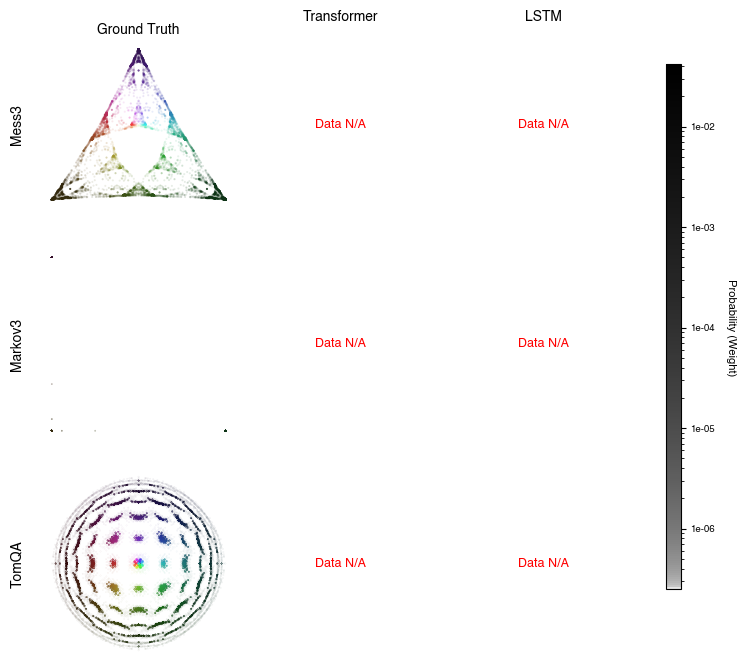

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings

# --- Helper Functions (Keep as before) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3:
        return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1 = np.array([0, 0]); v2 = np.array([1, 0]); v3 = np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5
    y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10
    weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt':
        transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)):
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions (MODIFIED) ---
def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict:
    """Loads the ground truth data for a specific run, allowing custom filename."""
    ground_truth_filepath = os.path.join(run_dir, filename) # Use provided filename
    if not os.path.exists(ground_truth_filepath):
        print(f"Error: Ground truth file not found at {ground_truth_filepath}")
        return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']):
             print(f"Warning: Ground truth data in {ground_truth_filepath} missing required keys ('beliefs', 'probs').")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except Exception as e:
        print(f"Error loading ground truth file {ground_truth_filepath}: {e}")
        return None

def load_predictions(run_dir: str, filename: str = 'predicted_beliefs.joblib', is_markov3_split: bool = False, target_ckpt_str: str = None) -> dict:
    """
    Loads the predictions data for a specific run.
    Handles standard loading, alternative filenames, and the Markov3 split-file structure.
    """
    if is_markov3_split:
        # --- Handle Markov3 Split File Loading ---
        if target_ckpt_str is None:
            print("Error: target_ckpt_str required for Markov3 split file loading.")
            return None

        # Extract the number from the checkpoint string (e.g., 'last', 'final', '100000')
        # This assumes the string resolved by the main function IS the key used in the split filenames.
        # If 'last'/'final' resolve to non-numeric keys, this needs adjustment based on actual filenames.
        match = re.search(r'\d+', target_ckpt_str)
        if not match:
             # Attempt to handle non-numeric 'final' if it exists as a file? Unlikely based on user desc.
             print(f"Error: Could not extract checkpoint number from '{target_ckpt_str}' for split file.")
             # Fallback: maybe check if temp_final.joblib exists? For now, return None.
             # Alternative: require the CALLER to resolve 'last'/'final' to the actual numeric string.
             return None
        ckpt_num_str = match.group(0)
        predictions_filepath = os.path.join(run_dir, 'markov3', f'temp_{ckpt_num_str}.joblib')

        if not os.path.exists(predictions_filepath):
            print(f"Error: Markov3 split predictions file not found at {predictions_filepath}")
            return None
        try:
            # Load data for the single checkpoint
            # ASSUMPTION: This file contains a dict like {'layer_name': {'predicted_beliefs': ...}, ...}
            single_ckpt_data = joblib.load(predictions_filepath)
            print(f"Loaded Markov3 split predictions data from {predictions_filepath}")

            # Ensure beliefs are numpy arrays
            if isinstance(single_ckpt_data, dict):
                for layer, data in single_ckpt_data.items():
                    if isinstance(data, dict) and 'predicted_beliefs' in data:
                        data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])

            # Return it wrapped in a dictionary keyed by the original target checkpoint string
            # to mimic the structure expected by the main function {ckpt_str: {layer: data}}
            return {target_ckpt_str: single_ckpt_data}
        except Exception as e:
            print(f"Error loading Markov3 split predictions file {predictions_filepath}: {e}")
            return None
    else:
        # --- Handle Standard or Alternative Single File Loading ---
        predictions_filepath = os.path.join(run_dir, filename)
        if not os.path.exists(predictions_filepath):
            print(f"Error: Predictions file not found at {predictions_filepath}")
            return None
        try:
            predictions_data = joblib.load(predictions_filepath)
            print(f"Loaded predictions data from {predictions_filepath}")
            if not isinstance(predictions_data, dict):
                print(f"Warning: Predictions data in {predictions_filepath} is not a dictionary.")
                return None
            # Ensure predicted_beliefs are numpy arrays
            for ckpt, layers in predictions_data.items():
                if isinstance(layers, dict):
                    for layer, data in layers.items():
                        if isinstance(data, dict) and 'predicted_beliefs' in data:
                            data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
            return predictions_data
        except Exception as e:
            print(f"Error loading predictions file {predictions_filepath}: {e}")
            return None

# --- Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    # Default parameters
    params = { 'point_size': {'truth': 1.0, 'pred': 0.5}, 'min_alpha': 0.02, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [0, 1], 'com': False }

    if 'markov3' in name_lower: # Specific params for Markov3 row (can base on TomQA if needed)
        params.update({
            'point_size': {'truth': 0.15, 'pred': 0.05}, # Example: same as TomQA
            'min_alpha': 0.1,
            'inds_to_plot': [1, 2] # Example: same as TomQA
        })
    elif 'tomqa' in name_lower or 'tomqb' in name_lower: # Corresponds to 'tom_quantum'
        params.update({ 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.1, 'inds_to_plot': [1, 2] })
    elif 'post_quantum' in name_lower: params.update({ 'point_size': {'truth': 20., 'pred': 0.1}, 'min_alpha': 0.001, 'com': True, })
    elif 'rrxor' in name_lower: params.update({ 'point_size': {'truth': 30., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1, 2], })
    elif 'fanizza' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [2, 3], })
    elif 'mess3' in name_lower: params.update({ 'point_size': {'truth': 1., 'pred': 1}, 'min_alpha': 0.1, 'com': False, 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], })
    # print(f"Plotting params for '{experiment_name}': {params}")
    return params

# --- Internal Plotting Helper ---
def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots pre-calculated belief points onto a given matplotlib Axes object."""
    # ... (No changes needed here) ...
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None \
       and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else:
            print(f"Warning: Mismatch between points ({x_plot.shape[0]}) and colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')


# --- Coordinate Calculation Helper ---
def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates the x, y coordinates for plotting based on strategy. Returns x, y, pca_instance."""
    # ... (No changes needed here) ...
    x_plot, y_plot = None, None
    current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]
    effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1)
            if n_dims < n_components: n_components = n_dims
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca); print(f"PCA Fit on GT. Explained variance: {current_pca.explained_variance_ratio_}")
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA fitting/transform: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming beliefs with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca


# --- Main Grid Visualization Function (MODIFIED) ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid.png",
):
    """
    Generates a grid plot comparing beliefs. Handles different data loading structures.
    Uses HSV color mapping (angle->Hue, radius->Value) and per-row plotting parameters.
    """
    n_rows = len(plot_config)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id = config['gt_run'] # Run ID associated with this row's data
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} ---")

        # Determine if this is a Markov3 row and set appropriate filenames
        is_markov3_row = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_row else 'ground_truth_data.joblib'

        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename) # Use specific filename
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and
                    gt_data['beliefs'] is not None and gt_data['probs'] is not None and
                    gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and
                    gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])

        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed to load valid ground truth or shapes invalid.")
            all_plot_data[row_idx] = {'valid': False}; calculated_coords[row_idx] = {'valid': False}
            # Turn off axes for the entire row if GT fails
            for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)

        # Validate parameters
        # ... (validation logic remains the same) ...
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: row_params['project_to_simplex'] = False; row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]

        all_plot_data[row_idx] = { 'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 'params': row_params, 'model_data': {} }
        calculated_coords[row_idx] = {'valid': True, 'params': row_params, 'coords': {}, 'pca': None}

        # --- Load Predictions (Handles Markov3 variations) ---
        resolved_ckpt_str = None # Store the resolved checkpoint string (needed for split files)
        for col_idx, (model_type, (sweep, run_id)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id}")
             print(f"  Loading {model_type} (Run: {sweep}_{run_id})...")

             # Determine loading parameters based on row type and model type
             pred_filename = 'predicted_beliefs.joblib' # Default
             load_markov3_split = False
             if is_markov3_row:
                 if model_type == 'LSTM': # LSTM uses single alternative file
                     pred_filename = 'markov3_predicted_beliefs.joblib'
                 elif model_type == 'Transformer': # Transformer uses split files
                     load_markov3_split = True
                 # Add other model types here if necessary

             # Resolve target checkpoint string ('last', 'final', or specific number)
             # We need the *actual key* used in the prediction dictionary or filename
             temp_pred_data_for_keys = load_predictions(run_directory, filename=pred_filename) # Load standard first to get keys
             ckpt_to_use = None
             if temp_pred_data_for_keys:
                 available_checkpoints = list(temp_pred_data_for_keys.keys())
                 if target_checkpoint == 'last':
                      try: numeric_checkpoints = sorted([int(k) for k in available_checkpoints if k.isdigit()])
                      except ValueError: numeric_checkpoints = []
                      if numeric_checkpoints: ckpt_to_use = str(numeric_checkpoints[-1])
                      elif available_checkpoints: ckpt_to_use = sorted(available_checkpoints)[-1]
                 elif target_checkpoint in available_checkpoints: ckpt_to_use = target_checkpoint
                 elif 'final' in available_checkpoints: ckpt_to_use = 'final'
             resolved_ckpt_str = ckpt_to_use # Store the key we found

             # Now load the actual prediction data using the correct method
             pred_data_all = None
             if resolved_ckpt_str: # Only proceed if we found a valid checkpoint key
                 pred_data_all = load_predictions(
                     run_dir=run_directory,
                     filename=pred_filename,
                     is_markov3_split=load_markov3_split,
                     target_ckpt_str=resolved_ckpt_str # Pass the resolved key
                 )

             # Extract beliefs for the target layer from the loaded data
             pred_beliefs = None
             if pred_data_all and resolved_ckpt_str in pred_data_all:
                 pred_data_ckpt = pred_data_all[resolved_ckpt_str]
                 if target_layer in pred_data_ckpt and 'predicted_beliefs' in pred_data_ckpt[target_layer]:
                      pred_beliefs = pred_data_ckpt[target_layer]['predicted_beliefs']
                      # Final validation
                      if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]:
                           print(f"  Warning: Invalid shape/type for final {model_type} preds. Skipping.")
                           pred_beliefs = None
                 else: print(f"  Warning: Layer '{target_layer}' or key 'predicted_beliefs' not found for {model_type} Ckpt {resolved_ckpt_str}.")
             else: print(f"  Warning: Checkpoint '{target_checkpoint}' (resolved to '{resolved_ckpt_str}') not found or invalid for {model_type}.")

             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs


    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors ---")
    # ... (This loop remains the same as the previous version) ...
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue
        params = data['params']; gt_beliefs = data['gt_beliefs']; weights = data['weights']; model_data = data['model_data']
        x_gt, y_gt, pca_instance = _calculate_plot_coords(gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None)
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt); calculated_coords[row_idx]['pca'] = pca_instance
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance)
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)
        all_row_x = []; all_row_y = []
        if x_gt is not None: all_row_x.append(x_gt)
        if y_gt is not None: all_row_y.append(y_gt)
        for model_type in model_data.keys():
             x_m, y_m = calculated_coords[row_idx]['coords'].get(model_type, (None, None))
             if x_m is not None: all_row_x.append(x_m)
             if y_m is not None: all_row_y.append(y_m)
        min_x, max_x, min_y, max_y = -1, 1, -1, 1
        if all_row_x and all_row_y:
            valid_row_x = [arr for arr in all_row_x if arr is not None and arr.size > 0]; valid_row_y = [arr for arr in all_row_y if arr is not None and arr.size > 0]
            if valid_row_x and valid_row_y:
                full_x = np.concatenate(valid_row_x); full_y = np.concatenate(valid_row_y)
                min_x, max_x = np.nanmin(full_x), np.nanmax(full_x); min_y, max_y = np.nanmin(full_y), np.nanmax(full_y)
        calculated_coords[row_idx]['limits'] = (min_x, max_x, min_y, max_y)
        colors_rgba = None
        if x_gt is not None and y_gt is not None:
            x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
            x_norm = (x_gt - min_x) / x_range; y_norm = (y_gt - min_y) / y_range
            x_centered = x_norm - 0.5; y_centered = y_norm - 0.5
            hue = (np.arctan2(y_centered, x_centered) + np.pi) / (2 * np.pi)
            radius = np.sqrt(x_centered**2 + y_centered**2)
            max_radius = np.nanmax(radius) if np.any(np.isfinite(radius)) else 1.0
            if max_radius < 1e-9: max_radius = 1.0
            norm_radius = radius / max_radius
            saturation = np.ones_like(hue) * 0.75
            value = np.clip(1.0 - norm_radius, 0.2, 0.95)
            hsv_stack = np.stack([hue, saturation, value], axis=-1); rgb = mcolors.hsv_to_rgb(hsv_stack)
            alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])
            colors_rgba = np.concatenate([rgb, alpha_values[:, np.newaxis]], axis=1)
        else: num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))
        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    # ... (This loop remains the same as the previous version) ...
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx in range(n_cols): axes[row_idx, col_idx].set_axis_off()
             continue
        params = coord_data['params']; colors_rgba = coord_data['colors']; point_size = params['point_size']
        ax_gt = axes[row_idx, 0]; x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]; x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        min_x, max_x, min_y, max_y = coord_data.get('limits', (-1, 1, -1, 1))
        x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
        x_pad = x_range * 0.05; y_pad = y_range * 0.05
        final_xlim = (min_x - x_pad, max_x + x_pad); final_ylim = (min_y - y_pad, max_y + y_pad)
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx];  ax.set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = [config['name'] for config in plot_config] # Use names from the config
    for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=10)
    for ax, row in zip(axes[:,0], rows): ax.text(-0.1, 0.5, row, rotation=90, fontsize=10, ha='right', va='center', transform=ax.transAxes)

    # --- Shared Colorbar ---
    # ... (Colorbar logic remains the same) ...
    first_valid_row_idx = next((idx for idx, data in all_plot_data.items() if data['valid']), None)
    if first_valid_row_idx is not None:
        weights_for_cbar = all_plot_data[first_valid_row_idx]['weights']; cbar_params = all_plot_data[first_valid_row_idx]['params']
        cbar_min_alpha = cbar_params['min_alpha']; cbar_transformation = cbar_params['transformation']
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        alpha_for_cbar = transform_for_alpha(np.linspace(np.min(weights_for_cbar), np.max(weights_for_cbar), 256), min_alpha=cbar_min_alpha, transformation=cbar_transformation)
        cmap_rgba = np.zeros((len(alpha_for_cbar), 4)); cmap_rgba[:, 3] = alpha_for_cbar; cmap = LinearSegmentedColormap.from_list('alpha_cmap', cmap_rgba)
        min_w, max_w = np.min(weights_for_cbar), np.max(weights_for_cbar); log_min_w = max(min_w, 1e-10) if min_w <= 0 else min_w
        if max_w > 0 and log_min_w > 0 and max_w / log_min_w > 100 :
            norm = LogNorm(vmin=log_min_w, vmax=max_w)
            try:
                max_order = int(np.floor(np.log10(max_w))); min_order = int(np.floor(np.log10(log_min_w)))
                if min_order > max_order: min_order = max_order
                ticks = [10**i for i in range(min_order, max_order + 1)]; ticks = [t for t in ticks if log_min_w <= t <= max_w]
                if not ticks or len(ticks) < 2: ticks = np.linspace(min_w, max_w, 5); tick_labels = [f"{t:.2f}" for t in ticks]
                else: tick_labels = [f"{t:.0e}" for t in ticks]
            except ValueError: norm = mcolors.Normalize(vmin=min_w, vmax=max_w); ticks = np.linspace(min_w, max_w, 5); tick_labels = [f"{t:.2f}" for t in ticks]
        else: norm = mcolors.Normalize(vmin=min_w, vmax=max_w); ticks = np.linspace(min_w, max_w, 5); tick_labels = [f"{t:.2f}" for t in ticks]
        sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array(weights_for_cbar)
        cbar = fig.colorbar(sm, cax=cbar_ax); cbar.set_label('Probability (Weight)', rotation=270, labelpad=15)
        valid_ticks = [t for t in ticks if norm.vmin <= t <= norm.vmax]
        if not valid_ticks: valid_ticks = [norm.vmin, norm.vmax]; tick_labels = [f"{t:.2e}" for t in valid_ticks]
        cbar.set_ticks(valid_ticks); cbar.set_ticklabels(tick_labels)
    else: print("Warning: No valid data found to create colorbar.")


    plt.tight_layout(rect=[0.03, 0.03, 0.9, 0.95])
    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage (MODIFIED) ---
if __name__ == "__main__":
    # UPDATED plot_config_grid with new row order and Markov3 entry
    plot_config_grid = [
        # Row 1: Mess3 (Original)
        {'name': 'Mess3',
         'gt_run': ("20241205175736", 23), # Run ID for Mess3 GT
         'models': [("Transformer", ("20241205175736", 23)), # Run ID for Mess3 Transformer Preds
                    ("LSTM", ("20241121152808", 55))]},    # Run ID for Mess3 LSTM Preds
        # Row 2: Markov3 (Based on TomQA runs)
        {'name': 'Markov3',
         'gt_run': ("20241205175736", 17), # Use TomQA run dir for Markov3 GT
         'models': [("Transformer", ("20241205175736", 17)), # Use TomQA run dir for Markov3 Transformer Preds (split files)
                    ("LSTM", ("202411211528081", 49))]},    # Use TomQA run dir for Markov3 LSTM Preds (single file)
        # Row 3: TomQA (Original)
        {'name': 'TomQA',
         'gt_run': ("20241205175736", 17), # Run ID for TomQA GT
         'models': [("Transformer", ("20241205175736", 17)), # Run ID for TomQA Transformer Preds
                    ("LSTM", ("20241121152808", 49))]},    # Run ID for TomQA LSTM Preds
    ]


    plot_config_grid = [
        # Row 1: Mess3 (Original)
        {'name': 'Mess3',
         'gt_run': ("20241205175736", 23), # Run ID for Mess3 GT
         'models': [("Transformer", ("20241205175736", 23)), # Run ID for Mess3 Transformer Preds
                    ("LSTM", ("20241121152808", 55))]},    # Run ID for Mess3 LSTM Preds
        # Row 2: Markov3 (Based on TomQA runs)
        {'name': 'Markov3',
         'gt_run': ("20241205175736", 17), # Use TomQA run dir for Markov3 GT
         'models': [("Transformer", ("20241205175736", 17)), # Use TomQA run dir for Markov3 Transformer Preds (split files)
                    ("LSTM", ("202411211528081", 49))]},    # Use TomQA run dir for Markov3 LSTM Preds (single file)
        # Row 3: TomQA (Original)
        {'name': 'TomQA',
         'gt_run': ("20241205175736", 17), # Run ID for TomQA GT
         'models': [("Transformer", ("20241205175736", 17)), # Run ID for TomQA Transformer Preds
                    ("LSTM", ("20241121152808", 49))]},    # Run ID for TomQA LSTM Preds
    ]

    output_base_dir = "run_predictions"
    output_base_dir = "run_predictions_cv"
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "grid_plots_markov" # Changed output dir name
    target_checkpoint = "last"
    target_layer = "combined"

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}_markov_hsv_value.png", # Changed filename
    )
    print("\n--- Grid Plotting Script Finished ---")



--- Loading Row 1: Mess3 (Run Dir: run_predictions_RCOND_FINAL/20241205175736_23) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_23/ground_truth_data.joblib

--- Loading Row 2: TomQA (Run Dir: run_predictions_RCOND_FINAL/20241205175736_17) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20241205175736_17/ground_truth_data.joblib

--- Calculating Coordinates and Colors (RGB Scheme) ---
  Using direct RGB mapping for Mess3 (Row 0)

--- Plotting Grid ---

Grid figure saved to grid_plots_markov_new/belief_grid_combined_last_markov_rgb_v2.png

--- Grid Plotting Script Finished ---


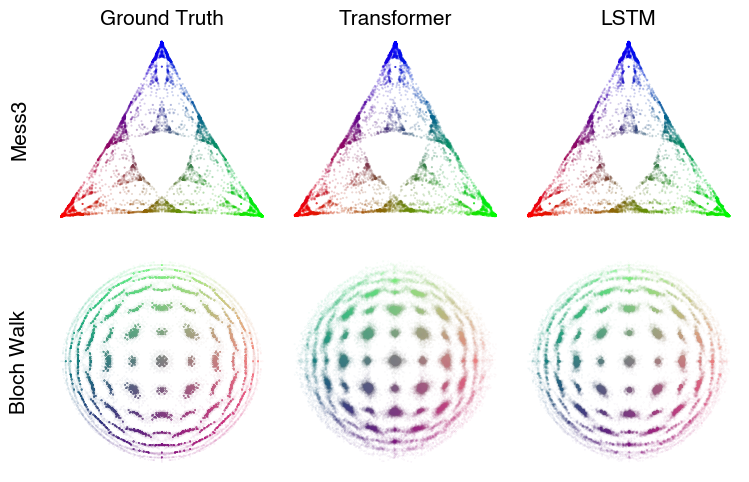

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Helper Functions ---
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "font.size": 8,               # base size; Science usually reduces figures 50-60 %
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
})


def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions ---
def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict:
    """Loads the ground truth data for a specific run, allowing custom filename."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: Ground truth file not found at {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys.")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {ground_truth_filepath}: Still missing 'nested_dict_factory'. Ensure definition is correct.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading ground truth file {ground_truth_filepath}: {e}"); return None

def load_predictions(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict:
    """Loads the predictions data for a specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None for loading predictions."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): print(f"Error: Checkpoint predictions file not found at {predictions_filepath}"); return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # print(f"Loaded checkpoint predictions data from {predictions_filepath}") # Less verbose
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict) and 'predicted_beliefs' in data: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return {target_ckpt_str: single_ckpt_data} # Wrap in dict keyed by checkpoint string
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint predictions file {predictions_filepath}: {e}"); return None

# --- Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    params = { 'point_size': {'truth': 1.0, 'pred': 0.5}, 'min_alpha': 0.02, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [0, 1], 'com': False }
    if 'markov3' in name_lower:
        params.update({ 'point_size': {'truth': 1.5, 'pred': 1.0}, 'min_alpha': 0.1, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [0, 1] })
    elif 'tomqa' in name_lower or 'tomqb' in name_lower:
        params.update({ 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.15, 'inds_to_plot': [1, 2] })
    elif 'post_quantum' in name_lower: params.update({ 'point_size': {'truth': 20., 'pred': 0.1}, 'min_alpha': 0.001, 'com': True, })
    elif 'rrxor' in name_lower: params.update({ 'point_size': {'truth': 30., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1, 2], })
    elif 'fanizza' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [2, 3], })
    elif 'mess3' in name_lower:
        params.update({ 'point_size': {'truth': 1., 'pred': 1}, 'min_alpha': 0.2, 'com': False, 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], })
    return params

# --- Internal Plotting Helper ---
def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots pre-calculated belief points onto a given matplotlib Axes object."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')

# --- Coordinate Calculation Helper ---
def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates the x, y coordinates for plotting based on strategy. Returns x, y, pca_instance."""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]; effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1); n_components = min(n_components, n_dims)
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca); # print(f"PCA Fit on GT. Variance: {current_pca.explained_variance_ratio_}") # Less verbose
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca

# --- Main Grid Visualization Function ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid.png",
):
    """
    Generates a grid plot comparing beliefs. Handles loading individual checkpoint files.
    Uses RGB color mapping based on plotted dimensions (with special case for Mess3)
    and per-row plotting parameters.
    """
    n_rows = len(plot_config)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']; gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        is_markov3_row = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_row else 'ground_truth_data.joblib'
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and gt_data['beliefs'] is not None and gt_data['probs'] is not None and gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}; calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
            continue
        true_beliefs = gt_data['beliefs']; weights = gt_data['probs']; belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        # Validate parameters
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: row_params['project_to_simplex'] = False; row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        all_plot_data[row_idx] = { 'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 'params': row_params, 'model_data': {} }
        calculated_coords[row_idx] = {'valid': True, 'params': row_params, 'coords': {}, 'pca': None, 'name': experiment_name} # Store name
        # Load Predictions
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             is_mkv3_load = is_markov3_row
             ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3_load else f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             resolved_ckpt_str = None
             if not ckpt_files: print(f"  Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_directory}")
             else:
                 available_indices = []
                 for f in ckpt_files:
                     match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
                     if match: 
                        try:
                            available_indices.append(int(match.group(1)))
                        except ValueError:
                            pass
                 if not available_indices: print(f"  Warning: Could not extract indices from found files: {ckpt_files}")
                 else:
                     available_indices.sort(); ckpt_to_use_num = None
                     if target_checkpoint == 'last':
                         if available_indices: ckpt_to_use_num = available_indices[-1]
                     else:
                         try:
                             target_num = int(target_checkpoint)
                             if target_num in available_indices: ckpt_to_use_num = target_num
                             else: print(f"  Warning: Target checkpoint index {target_num} not found in {available_indices}")
                         except ValueError: print(f"  Warning: Invalid target_checkpoint format: '{target_checkpoint}'")
                     if ckpt_to_use_num is not None: resolved_ckpt_str = str(ckpt_to_use_num)
             pred_data_all = None
             if resolved_ckpt_str: pred_data_all = load_predictions(run_dir=run_directory, is_markov3_run=is_mkv3_load, target_ckpt_str=resolved_ckpt_str)
             pred_beliefs = None
             if pred_data_all and resolved_ckpt_str in pred_data_all:
                 pred_data_ckpt = pred_data_all[resolved_ckpt_str]
                 if isinstance(pred_data_ckpt, dict) and target_layer in pred_data_ckpt:
                     layer_data = pred_data_ckpt[target_layer]
                     if isinstance(layer_data, dict) and 'predicted_beliefs' in layer_data:
                         pred_beliefs = layer_data['predicted_beliefs']
                         if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]: pred_beliefs = None
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs

    # --- Coordinate Calculation and Color Generation Loop (MODIFIED) ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name'] # Get experiment name

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # --- Calculate RGB Colors based on GT coordinates ---
        colors_rgba = None
        # Normalize function remains the same
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        # Calculate Alpha values first
        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        # ** Conditional Color Calculation **
        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            print(f"  Using direct RGB mapping for Mess3 (Row {row_idx})")
            # Map first 3 original belief dimensions directly to RGB
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
             # Use the default method based on plotted coordinates (x_gt, y_gt)
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            B_source = None
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            # Fallback if coordinates are missing
            print(f"Warning: Cannot calculate colors for row {row_idx} due to missing GT coords.")
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3)) # Default to black

        # Ensure all components R, G, B, alpha are valid before stacking
        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             print(f"Warning: Shape mismatch or None value in RGB components for row {row_idx}. Using default colors.")
             num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))

        calculated_coords[row_idx]['colors'] = colors_rgba


    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
             continue
        params = coord_data['params']; colors_rgba = coord_data['colors']; point_size = params['point_size']
        ax_gt = axes[row_idx, 0]; x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]; x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        min_x, max_x, min_y, max_y = coord_data.get('limits', (-1, 1, -1, 1))
        x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
        x_pad = x_range * 0.05; y_pad = y_range * 0.05
        final_xlim = (min_x - x_pad, max_x + x_pad); final_ylim = (min_y - y_pad, max_y + y_pad)
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]; ax.set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = ['Mess3', 'Bloch Walk']#[config['name'] for config in plot_config] # Use names from the config
    for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # --- Colorbar REMOVED ---
    # (Code related to cbar_ax, ScalarMappable, fig.colorbar is removed)

    # --- Final Layout Adjustment (MODIFIED) ---
    # Remove the rect argument to use default tight_layout or adjust right boundary
    # Option 1: Default tight_layout
    plt.tight_layout()
    # Option 2: Adjust rect to use more width (e.g., up to 0.97)
    # plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95]) # Adjust right boundary

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage ---
if __name__ == "__main__":
    plot_config_grid = [
        {'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 23)), ("LSTM", ("20241121152808", 55))]},
        #{'name': 'Markov3', 'gt_run': ("20241205175736", 17), 'models': [("Transformer", ("20241205175736", 17)), ("LSTM", ("20241121152808", 49))]},
        {'name': 'TomQA', 'gt_run': ("20241205175736", 17), 'models': [("Transformer", ("20241205175736", 17)), ("LSTM", ("20241121152808", 49))]},
    ]

    #output_base_dir = "run_predictions2"
    output_base_dir = "run_predictions_cv"
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "grid_plots_markov_new"
    target_checkpoint = "last"
    target_layer = "combined"

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}_markov_rgb_v2.png", # Changed filename
    )
    print("\n--- Grid Plotting Script Finished ---")



--- Loading Row 1: Markov3 (Run Dir: run_predictions_RCOND_FINAL/20250422023003_1) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250422023003_1/markov3_ground_truth_data.joblib
dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'ln_final.hook_normalized', 'combined'])
dict_keys(['layer0', 'layer1', 'layer2', 'layer3', 'input', 'combined'])

--- Loading Row 2: Fanizza (Run Dir: run_predictions_RCOND_FINAL/20250422023003_1) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250422023003_1/ground_truth_data.joblib
dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'ln_final.hook_normalized', 'combined'])
dict_keys(['layer0', 'layer1', 'layer2', 'layer3', 'input', 'combined'])

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---

Grid fi

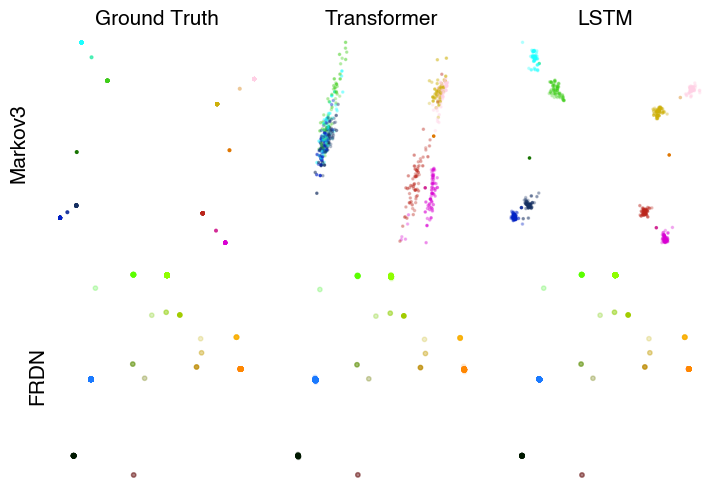

In [216]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Helper Functions ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions ---
def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict:
    """Loads the ground truth data for a specific run, allowing custom filename."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: Ground truth file not found at {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys.")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {ground_truth_filepath}: Still missing 'nested_dict_factory'. Ensure definition is correct.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading ground truth file {ground_truth_filepath}: {e}"); return None

def load_predictions(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict:
    """Loads the predictions data for a specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None for loading predictions."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): print(f"Error: Checkpoint predictions file not found at {predictions_filepath}"); return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # print(f"Loaded checkpoint predictions data from {predictions_filepath}") # Less verbose
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict) and 'predicted_beliefs' in data: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return {target_ckpt_str: single_ckpt_data} # Wrap in dict keyed by checkpoint string
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint predictions file {predictions_filepath}: {e}"); return None

# --- Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    params = { 'point_size': {'truth': 1.0, 'pred': 0.5}, 'min_alpha': 0.02, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [0, 1], 'com': False }
    if 'markov3' in name_lower:
        params.update({ 'point_size': {'truth': 15, 'pred': 10}, 'min_alpha': 0.2, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [0, 2] })
    elif 'tomqa' in name_lower or 'tomqb' in name_lower:
        params.update({ 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.15, 'inds_to_plot': [1, 2] })
    elif 'post_quantum' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 0.1}, 'min_alpha': 0.001, 'com': True, })
    elif 'rrxor' in name_lower: params.update({ 'point_size': {'truth': 30., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1, 2], })
    elif 'fanizza' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 40}, 'min_alpha': 0.1, 'com': True, 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [2, 3], })
    elif 'mess3' in name_lower:
        params.update({ 'point_size': {'truth': 1., 'pred': 1}, 'min_alpha': 0.2, 'com': False, 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], })
    return params

# --- Internal Plotting Helper ---
def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots pre-calculated belief points onto a given matplotlib Axes object."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')

# --- Coordinate Calculation Helper ---
def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates the x, y coordinates for plotting based on strategy. Returns x, y, pca_instance."""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]; effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1); n_components = min(n_components, n_dims)
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca); # print(f"PCA Fit on GT. Variance: {current_pca.explained_variance_ratio_}") # Less verbose
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca

# --- Main Grid Visualization Function ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid.png",
):
    """
    Generates a grid plot comparing beliefs. Handles loading individual checkpoint files.
    Uses RGB color mapping based on plotted dimensions (with special case for Mess3)
    and per-row plotting parameters.
    """
    n_rows = len(plot_config)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']; gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        is_markov3_row = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_row else 'ground_truth_data.joblib'
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and gt_data['beliefs'] is not None and gt_data['probs'] is not None and gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}; calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
            continue
        true_beliefs = gt_data['beliefs']; weights = gt_data['probs']; belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        # Validate parameters
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: row_params['project_to_simplex'] = False; row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        all_plot_data[row_idx] = { 'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 'params': row_params, 'model_data': {} }
        calculated_coords[row_idx] = {'valid': True, 'params': row_params, 'coords': {}, 'pca': None, 'name': experiment_name} # Store name
        # Load Predictions
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             is_mkv3_load = is_markov3_row
             ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3_load else f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             resolved_ckpt_str = None
             if not ckpt_files: print(f"  Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_directory}")
             else:
                 available_indices = []
                 for f in ckpt_files:
                     match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
                     if match: 
                        try:
                            available_indices.append(int(match.group(1)))
                        except ValueError:
                            pass
                 if not available_indices: print(f"  Warning: Could not extract indices from found files: {ckpt_files}")
                 else:
                     available_indices.sort(); ckpt_to_use_num = None
                     if target_checkpoint == 'last':
                         if available_indices: ckpt_to_use_num = available_indices[-1]
                     else:
                         try:
                             target_num = int(target_checkpoint)
                             if target_num in available_indices: ckpt_to_use_num = target_num
                             else: print(f"  Warning: Target checkpoint index {target_num} not found in {available_indices}")
                         except ValueError: print(f"  Warning: Invalid target_checkpoint format: '{target_checkpoint}'")
                     if ckpt_to_use_num is not None: resolved_ckpt_str = str(ckpt_to_use_num)
             pred_data_all = None
             if resolved_ckpt_str: pred_data_all = load_predictions(run_dir=run_directory, is_markov3_run=is_mkv3_load, target_ckpt_str=resolved_ckpt_str)
             pred_beliefs = None
             if pred_data_all and resolved_ckpt_str in pred_data_all:
                 pred_data_ckpt = pred_data_all[resolved_ckpt_str]
                 print(pred_data_ckpt.keys())
                 if isinstance(pred_data_ckpt, dict) and target_layer in pred_data_ckpt:
                     layer_data = pred_data_ckpt[target_layer]
                     if isinstance(layer_data, dict) and 'predicted_beliefs' in layer_data:
                         pred_beliefs = layer_data['predicted_beliefs']
                         if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]: pred_beliefs = None
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs

    # --- Coordinate Calculation and Color Generation Loop (MODIFIED) ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name'] # Get experiment name

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # --- Calculate RGB Colors based on GT coordinates ---
        colors_rgba = None
        # Normalize function remains the same
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        # Calculate Alpha values first
        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        # ** Conditional Color Calculation **
        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            print(f"  Using direct RGB mapping for Mess3 (Row {row_idx})")
            # Map first 3 original belief dimensions directly to RGB
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
             # Use the default method based on plotted coordinates (x_gt, y_gt)
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            B_source = None
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            # Fallback if coordinates are missing
            print(f"Warning: Cannot calculate colors for row {row_idx} due to missing GT coords.")
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3)) # Default to black

        # Ensure all components R, G, B, alpha are valid before stacking
        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             print(f"Warning: Shape mismatch or None value in RGB components for row {row_idx}. Using default colors.")
             num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))

        calculated_coords[row_idx]['colors'] = colors_rgba


    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
             continue
        params = coord_data['params']; colors_rgba = coord_data['colors']; point_size = params['point_size']
        ax_gt = axes[row_idx, 0]; x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]; x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        min_x, max_x, min_y, max_y = coord_data.get('limits', (-1, 1, -1, 1))
        x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
        x_pad = x_range * 0.05; y_pad = y_range * 0.05
        final_xlim = (min_x - x_pad, max_x + x_pad); final_ylim = (min_y - y_pad, max_y + y_pad)
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]; ax.set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = ['Markov3', 'FRDN']#[config['name'] for config in plot_config] # Use names from the config
    for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # --- Colorbar REMOVED ---
    # (Code related to cbar_ax, ScalarMappable, fig.colorbar is removed)

    # --- Final Layout Adjustment (MODIFIED) ---
    # Remove the rect argument to use default tight_layout or adjust right boundary
    # Option 1: Default tight_layout
    plt.tight_layout()
    # Option 2: Adjust rect to use more width (e.g., up to 0.97)
    # plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95]) # Adjust right boundary

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage ---
if __name__ == "__main__":
    plot_config_grid = [
        #{'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 5)), ("LSTM", ("20241121152808", 55))]},
        {'name': 'Markov3', 'gt_run': ("20241205175736", 21), 'models': [("Transformer", ("20241205175736", 21)), ("LSTM", ("20241121152808", 53))]},
        {'name': 'Fanizza', 'gt_run': ("20241205175736", 21), 'models': [("Transformer", ("20241205175736", 21)), ("LSTM", ("20241121152808", 53))]},
    ]

    #plot_config_grid = [
    #    #{'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 5)), ("LSTM", ("20241121152808", 55))]},
    #    {'name': 'Markov3', 'gt_run': ("20250304052839", 5), 'models': [("Transformer", ("20250304052839", 5)), ("LSTM", ("20250304060315", 5))]},
    #    {'name': 'Fanizza', 'gt_run': ("20250304052839", 5), 'models': [("Transformer", ("20250304052839", 5)), ("LSTM", ("20250304060315", 5))]},
    #]

    plot_config_grid = [
        #{'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 5)), ("LSTM", ("20241121152808", 55))]},
        {'name': 'Markov3', 'gt_run': ("20250422023003", 1), 'models': [("Transformer", ("20250422023003", 1)), ("LSTM", ("20241121152808", 53))]},
        {'name': 'Fanizza', 'gt_run': ("20250422023003", 1), 'models': [("Transformer", ("20250422023003", 1)), ("LSTM", ("20241121152808", 53))]},
    ]
    #output_base_dir = "run_predictions2"
    output_base_dir = "run_predictions_cv"
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "grid_plots_markov_new"
    target_checkpoint = "last"#389324800#20684800#"last"
    target_layer = "combined"#"blocks.3.hook_resid_post"#"layer3"#"combined"

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}_markov_rgb_v2.png", # Changed filename
    )
    print("\n--- Grid Plotting Script Finished ---")



--- Loading Row 1: Markov3 (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/markov3_ground_truth_data.joblib
markov3

--- Loading Row 2: post_quantum (Run Dir: run_predictions_RCOND_FINAL/20250421221507_0) ---
Loaded ground truth data from run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
post_quantum

--- Calculating Coordinates and Colors (RGB Scheme) ---

--- Plotting Grid ---

Grid figure saved to grid_plots_markov_new/belief_grid_combined_last_markov_rgb_v2.png

--- Grid Plotting Script Finished ---


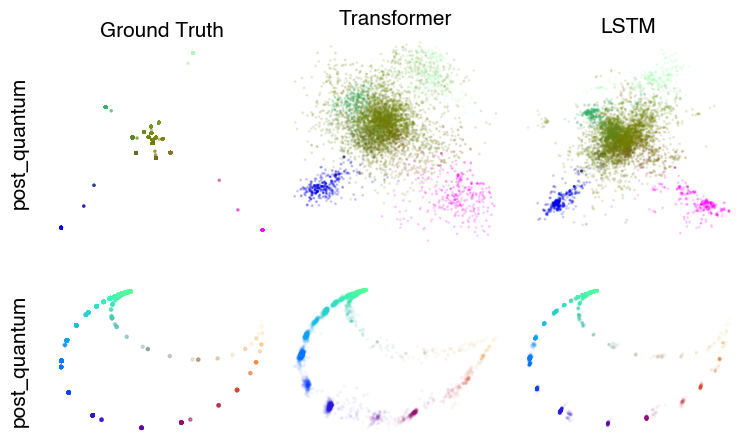

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from sklearn.decomposition import PCA
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Helper Functions ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

# --- Data Loading Functions ---
def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict:
    """Loads the ground truth data for a specific run, allowing custom filename."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: Ground truth file not found at {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded ground truth data from {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys.")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {ground_truth_filepath}: Still missing 'nested_dict_factory'. Ensure definition is correct.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading ground truth file {ground_truth_filepath}: {e}"); return None

def load_predictions(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict:
    """Loads the predictions data for a specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None for loading predictions."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): print(f"Error: Checkpoint predictions file not found at {predictions_filepath}"); return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # print(f"Loaded checkpoint predictions data from {predictions_filepath}") # Less verbose
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict) and 'predicted_beliefs' in data: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return {target_ckpt_str: single_ckpt_data} # Wrap in dict keyed by checkpoint string
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint predictions file {predictions_filepath}: {e}"); return None

# --- Helper to get plotting params based on experiment ---
def _get_plotting_params(experiment_name: str) -> dict:
    """Returns a dictionary of plotting parameters based on experiment name."""
    name_lower = experiment_name.lower()
    print(name_lower)
    params = { 'point_size': {'truth': 1.0, 'pred': 0.5}, 'min_alpha': 0.02, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [0, 1], 'com': False }
    if 'markov3' in name_lower:
        params.update({ 'point_size': {'truth': 10.5, 'pred': 5.0}, 'min_alpha': 0.1, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1,2] })
    elif 'tomqa' in name_lower or 'tomqb' in name_lower:
        params.update({ 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.15, 'inds_to_plot': [1, 2] })
    elif 'post_quantum' in name_lower: params.update({ 'point_size': {'truth': 20., 'pred': 10.}, 'min_alpha': 0.01, 'com': False, 'use_pca':False, 'inds_to_plot': [1, 2]})
    elif 'rrxor' in name_lower: params.update({ 'point_size': {'truth': 30., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': True, 'project_to_simplex': False, 'inds_to_plot': [1, 2], })
    elif 'fanizza' in name_lower: params.update({ 'point_size': {'truth': 40., 'pred': 1}, 'min_alpha': 0.1, 'com': True, 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [2, 3], })
    elif 'mess3' in name_lower:
        params.update({ 'point_size': {'truth': 1., 'pred': 1}, 'min_alpha': 0.2, 'com': False, 'use_pca': False, 'project_to_simplex': True, 'inds_to_plot': [0, 1], })
    return params

# --- Calculate Center of Mass ---
def calculate_center_of_mass(beliefs, weights):
    """Calculate the weighted center of mass of belief points."""
    if beliefs is None or weights is None:
        return None
    # Normalize weights to sum to 1
    norm_weights = weights / np.sum(weights)
    # Calculate weighted average of each dimension
    com = np.sum(beliefs * norm_weights[:, np.newaxis], axis=0)
    return com

# --- Internal Plotting Helper ---
def _plot_beliefs_on_ax(ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float, com_point=None):
    """Plots pre-calculated belief points onto a given matplotlib Axes object."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    
    # Plot center of mass if provided
    if com_point is not None and len(com_point) >= 2:
        ax.scatter(com_point[0], com_point[1], color='red', s=point_size*5, marker='*', edgecolor='black', linewidth=0.5, zorder=10)
    
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')

# --- Coordinate Calculation Helper ---
def _calculate_plot_coords(beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None):
    """Calculates the x, y coordinates for plotting based on strategy. Returns x, y, pca_instance."""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]; effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1); n_components = min(n_components, n_dims)
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca); # print(f"PCA Fit on GT. Variance: {current_pca.explained_variance_ratio_}") # Less verbose
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca

# --- Main Grid Visualization Function ---
def visualize_belief_grid(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid.png",
):
    """
    Generates a grid plot comparing beliefs. Handles loading individual checkpoint files.
    Uses RGB color mapping based on plotted dimensions (with special case for Mess3)
    and per-row plotting parameters.
    """
    n_rows = len(plot_config)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']; gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        is_markov3_row = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_row else 'ground_truth_data.joblib'
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and gt_data['beliefs'] is not None and gt_data['probs'] is not None and gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}; calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
            continue
        true_beliefs = gt_data['beliefs']; weights = gt_data['probs']; belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        # Validate parameters
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: row_params['project_to_simplex'] = False; row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        all_plot_data[row_idx] = { 'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 'params': row_params, 'model_data': {} }
        calculated_coords[row_idx] = {'valid': True, 'params': row_params, 'coords': {}, 'pca': None, 'name': experiment_name} # Store name
        # Load Predictions
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             is_mkv3_load = is_markov3_row
             ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3_load else f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             resolved_ckpt_str = None
             if not ckpt_files: print(f"  Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_directory}")
             else:
                 available_indices = []
                 for f in ckpt_files:
                     match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
                     if match: 
                        try:
                            available_indices.append(int(match.group(1)))
                        except ValueError:
                            pass
                 if not available_indices: print(f"  Warning: Could not extract indices from found files: {ckpt_files}")
                 else:
                     available_indices.sort(); ckpt_to_use_num = None
                     if target_checkpoint == 'last':
                         if available_indices: ckpt_to_use_num = available_indices[-1]
                     else:
                         try:
                             target_num = int(target_checkpoint)
                             if target_num in available_indices: ckpt_to_use_num = target_num
                             else: print(f"  Warning: Target checkpoint index {target_num} not found in {available_indices}")
                         except ValueError: print(f"  Warning: Invalid target_checkpoint format: '{target_checkpoint}'")
                     if ckpt_to_use_num is not None: resolved_ckpt_str = str(ckpt_to_use_num)
             pred_data_all = None
             if resolved_ckpt_str: pred_data_all = load_predictions(run_dir=run_directory, is_markov3_run=is_mkv3_load, target_ckpt_str=resolved_ckpt_str)
             pred_beliefs = None
             if pred_data_all and resolved_ckpt_str in pred_data_all:
                 pred_data_ckpt = pred_data_all[resolved_ckpt_str]
                 if isinstance(pred_data_ckpt, dict) and target_layer in pred_data_ckpt:
                     layer_data = pred_data_ckpt[target_layer]
                     if isinstance(layer_data, dict) and 'predicted_beliefs' in layer_data:
                         pred_beliefs = layer_data['predicted_beliefs']
                         if pred_beliefs is None or not isinstance(pred_beliefs, np.ndarray) or pred_beliefs.ndim != 2 or pred_beliefs.shape[0] != true_beliefs.shape[0]: pred_beliefs = None
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs

    # --- Coordinate Calculation and Color Generation Loop (MODIFIED) ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name'] # Get experiment name

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # --- Calculate RGB Colors based on GT coordinates ---
        colors_rgba = None
        # Normalize function remains the same
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        # Calculate Alpha values first
        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        # ** Conditional Color Calculation **
        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            print(f"  Using direct RGB mapping for Mess3 (Row {row_idx})")
            # Map first 3 original belief dimensions directly to RGB
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
             # Use the default method based on plotted coordinates (x_gt, y_gt)
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            B_source = None
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            # Fallback if coordinates are missing
            print(f"Warning: Cannot calculate colors for row {row_idx} due to missing GT coords.")
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3)) # Default to black

        # Ensure all components R, G, B, alpha are valid before stacking
        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             print(f"Warning: Shape mismatch or None value in RGB components for row {row_idx}. Using default colors.")
             num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))

        calculated_coords[row_idx]['colors'] = colors_rgba
        
        # Calculate center of mass for ground truth and models if enabled
        if params['com']:
            # Calculate COM for ground truth
            gt_com_full = calculate_center_of_mass(gt_beliefs, weights)
            
            # Transform COM to plotting coordinates
            if params['use_pca'] and pca_instance is not None:
                gt_com_proj = pca_instance.transform(gt_com_full.reshape(1, -1))
                gt_com = (gt_com_proj[0, params['inds_to_plot'][0]], gt_com_proj[0, params['inds_to_plot'][1]])
            elif params['project_to_simplex'] and belief_dims >= 3:
                gt_com_x, gt_com_y = _project_to_simplex(gt_com_full.reshape(1, -1))
                gt_com = (gt_com_x[0], gt_com_y[0])
            else:
                inds = params['inds_to_plot']
                if max(inds) < belief_dims:
                    gt_com = (gt_com_full[inds[0]], gt_com_full[inds[1]] if len(inds) > 1 else gt_com_full[inds[0]])
                else:
                    gt_com = (gt_com_full[0], gt_com_full[1] if belief_dims > 1 else gt_com_full[0])
            
            calculated_coords[row_idx]['com'] = {'gt': gt_com}
            
            # Calculate COM for each model
            for model_type, pred_beliefs in model_data.items():
                if pred_beliefs is not None:
                    model_com_full = calculate_center_of_mass(pred_beliefs, weights)
                    
                    # Transform model COM to plotting coordinates
                    if params['use_pca'] and pca_instance is not None:
                        model_com_proj = pca_instance.transform(model_com_full.reshape(1, -1))
                        model_com = (model_com_proj[0, params['inds_to_plot'][0]], model_com_proj[0, params['inds_to_plot'][1]])
                    elif params['project_to_simplex'] and belief_dims >= 3:
                        model_com_x, model_com_y = _project_to_simplex(model_com_full.reshape(1, -1))
                        model_com = (model_com_x[0], model_com_y[0])
                    else:
                        inds = params['inds_to_plot']
                        if max(inds) < belief_dims:
                            model_com = (model_com_full[inds[0]], model_com_full[inds[1]] if len(inds) > 1 else model_com_full[inds[0]])
                        else:
                            model_com = (model_com_full[0], model_com_full[1] if belief_dims > 1 else model_com_full[0])
                    
                    calculated_coords[row_idx]['com'][model_type] = model_com
        
        # If com is true, also compute center of mass for each unique belief state
        if params['com']:
            # For ground truth
            beliefs_ = gt_beliefs
            unique_beliefs = np.unique(beliefs_, axis=0)
            gt_unique_coms = []
            
            for unique_belief in unique_beliefs:
                # Find indices of each unique belief state
                unique_inds = np.where(np.all(beliefs_ == unique_belief, axis=1))[0]
                
                # Get the weights for these indices
                unique_weights = weights[unique_inds]
                
                # Calculate the center of mass for this unique belief state
                # (which is just the unique belief itself since all points are identical)
                unique_com_full = unique_belief
                
                # Transform to plotting coordinates
                if params['use_pca'] and pca_instance is not None:
                    unique_com_proj = pca_instance.transform(unique_com_full.reshape(1, -1))
                    unique_com = (unique_com_proj[0, params['inds_to_plot'][0]], unique_com_proj[0, params['inds_to_plot'][1]])
                elif params['project_to_simplex'] and belief_dims >= 3:
                    unique_com_x, unique_com_y = _project_to_simplex(unique_com_full.reshape(1, -1))
                    unique_com = (unique_com_x[0], unique_com_y[0])
                else:
                    inds = params['inds_to_plot']
                    if max(inds) < belief_dims:
                        unique_com = (unique_com_full[inds[0]], unique_com_full[inds[1]] if len(inds) > 1 else unique_com_full[inds[0]])
                    else:
                        unique_com = (unique_com_full[0], unique_com_full[1] if belief_dims > 1 else unique_com_full[0])
                
                # Calculate mean color for this unique belief state
                mean_color = np.mean(colors_rgba[unique_inds], axis=0)
                # Sum alpha values for better visibility
                mean_color[3] = np.sum(colors_rgba[unique_inds, 3])
                # Apply alpha transformation
                mean_color[3] = transform_for_alpha(mean_color[3], min_alpha=0.1, transformation='sqrt')
                
                # Store the COM, color, and total weight
                gt_unique_coms.append({
                    'coords': unique_com,
                    'color': mean_color,
                    'weight': np.sum(unique_weights),
                    'count': len(unique_inds)
                })
            
            calculated_coords[row_idx]['unique_coms'] = {'gt': gt_unique_coms}
            
            # Do the same for each model
            for model_type, pred_beliefs in model_data.items():
                if pred_beliefs is not None:
                    model_unique_coms = []
                    unique_model_beliefs = np.unique(pred_beliefs, axis=0)
                    
                    for unique_belief in unique_model_beliefs:
                        unique_inds = np.where(np.all(pred_beliefs == unique_belief, axis=1))[0]
                        unique_weights = weights[unique_inds]
                        
                        # Transform to plotting coordinates
                        if params['use_pca'] and pca_instance is not None:
                            unique_com_proj = pca_instance.transform(unique_belief.reshape(1, -1))
                            unique_com = (unique_com_proj[0, params['inds_to_plot'][0]], unique_com_proj[0, params['inds_to_plot'][1]])
                        elif params['project_to_simplex'] and belief_dims >= 3:
                            unique_com_x, unique_com_y = _project_to_simplex(unique_belief.reshape(1, -1))
                            unique_com = (unique_com_x[0], unique_com_y[0])
                        else:
                            inds = params['inds_to_plot']
                            if max(inds) < belief_dims:
                                unique_com = (unique_belief[inds[0]], unique_belief[inds[1]] if len(inds) > 1 else unique_belief[inds[0]])
                            else:
                                unique_com = (unique_belief[0], unique_belief[1] if belief_dims > 1 else unique_belief[0])
                        
                        # Calculate mean color
                        mean_color = np.mean(colors_rgba[unique_inds], axis=0)
                        mean_color[3] = np.sum(colors_rgba[unique_inds, 3])
                        mean_color[3] = transform_for_alpha(mean_color[3], min_alpha=0.1, transformation='sqrt')
                        
                        model_unique_coms.append({
                            'coords': unique_com,
                            'color': mean_color,
                            'weight': np.sum(unique_weights),
                            'count': len(unique_inds)
                        })
                    
                    calculated_coords[row_idx]['unique_coms'][model_type] = model_unique_coms


    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): axes[row_idx, col_idx_off].set_axis_off()
             continue
        params = coord_data['params']; colors_rgba = coord_data['colors']; point_size = params['point_size']
        ax_gt = axes[row_idx, 0]; x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        
        # Get center of mass for ground truth if available
        gt_com = coord_data.get('com', {}).get('gt', None) if params['com'] else None
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'], com_point=gt_com)
        
        # Plot unique belief COMs for ground truth
        if params['com'] and 'unique_coms' in coord_data and 'gt' in coord_data['unique_coms']:
            for unique_com_data in coord_data['unique_coms']['gt']:
                com_x, com_y = unique_com_data['coords']
                ax_gt.scatter(com_x, com_y, color=unique_com_data['color'], 
                             s=50, marker='o', edgecolor='black', linewidth=0.5)
        
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            
            # Get center of mass for model if available
            model_com = coord_data.get('com', {}).get(model_type, None) if params['com'] else None
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'], com_point=model_com)
            
            # Plot unique belief COMs for model
            if params['com'] and 'unique_coms' in coord_data and model_type in coord_data['unique_coms']:
                for unique_com_data in coord_data['unique_coms'][model_type]:
                    com_x, com_y = unique_com_data['coords']
                    ax_model.scatter(com_x, com_y, color=unique_com_data['color'], 
                                   s=50, marker='o', edgecolor='black', linewidth=0.5)
        
        min_x, max_x, min_y, max_y = coord_data.get('limits', (-1, 1, -1, 1))
        x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
        x_pad = x_range * 0.05; y_pad = y_range * 0.05
        final_xlim = (min_x - x_pad, max_x + x_pad); final_ylim = (min_y - y_pad, max_y + y_pad)
        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]; ax.set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM']
    rows = ['post_quantum', 'post_quantum']#[config['name'] for config in plot_config] # Use names from the config
    for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # --- Colorbar REMOVED ---
    # (Code related to cbar_ax, ScalarMappable, fig.colorbar is removed)

    # --- Final Layout Adjustment (MODIFIED) ---
    # Remove the rect argument to use default tight_layout or adjust right boundary
    # Option 1: Default tight_layout
    plt.tight_layout()
    # Option 2: Adjust rect to use more width (e.g., up to 0.97)
    # plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95]) # Adjust right boundary

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    plt.savefig(full_output_path, dpi=300)
    print(f"\nGrid figure saved to {full_output_path}")
    #plt.close(fig)

# --- Example Usage ---
if __name__ == "__main__":
    plot_config_grid = [
        #{'name': 'Mess3', 'gt_run': ("20241205175736", 23), 'models': [("Transformer", ("20241205175736", 5)), ("LSTM", ("20241121152808", 55))]},
        {'name': 'Markov3', 'gt_run': ("20250421221507", 0), 'models': [("Transformer", ("20250421221507", 0)), ("LSTM", ("20241121152808", 48))]},
        #{'name': 'post_quantum', 'gt_run': ("20241205175736", 16), 'models': [("Transformer", ("20241205175736", 16)), ("LSTM", ("20241121152808", 48))]},
        {'name': 'post_quantum', 'gt_run': ("20250421221507", 0), 'models': [("Transformer", ("20250421221507", 0)), ("LSTM", ("20241121152808", 48))]},
        ]
    output_base_dir = "run_predictions_cv"
    #output_base_dir = "run_predictions_cv"
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "grid_plots_markov_new"

    target_checkpoint = "last"
    target_layer = "combined"

    visualize_belief_grid(
        plot_config=plot_config_grid,
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        target_checkpoint=target_checkpoint,
        target_layer=target_layer,
        output_filename=f"belief_grid_{target_layer}_{target_checkpoint}_markov_rgb_v2.png", # Changed filename
    )
    print("\n--- Grid Plotting Script Finished ---")


In [218]:
# Modified version of visualize_belief_grid with 4th column for bar charts
def visualize_belief_grid_with_metrics(
    plot_config: list,
    output_base_dir: str,
    plot_output_dir: str,
    target_checkpoint: str,
    target_layer: str,
    output_filename: str = "belief_grid_with_metrics.png",
):
    """
    Generates a grid plot comparing beliefs with an additional column for RMSE bar charts.
    """
    n_rows = len(plot_config)
    n_cols = 4  # Ground Truth, Transformer, LSTM, RMSE Bar Chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 0.8]})
    if n_rows == 1: axes = axes.reshape(1, n_cols)
    fig.subplots_adjust(hspace=0.05, wspace=0.3)

    all_plot_data = {}
    calculated_coords = {}

    # --- Data Loading and Parameter Setup Loop ---
    for row_idx, config in enumerate(plot_config):
        experiment_name = config['name']
        gt_sweep, gt_run_id_int = config['gt_run']
        gt_run_dir = os.path.join(output_base_dir, f"{gt_sweep}_{gt_run_id_int}")
        print(f"\n--- Loading Row {row_idx+1}: {experiment_name} (Run Dir: {gt_run_dir}) ---")
        
        # Determine if the GROUND TRUTH for this row is markov3
        is_markov3_ground_truth = 'markov3' in experiment_name.lower()
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_ground_truth else 'ground_truth_data.joblib'
        
        gt_data = load_ground_truth(gt_run_dir, filename=gt_filename)
        valid_gt = (gt_data is not None and 'beliefs' in gt_data and 'probs' in gt_data and 
                   gt_data['beliefs'] is not None and gt_data['probs'] is not None and 
                   gt_data['beliefs'].ndim == 2 and gt_data['probs'].ndim == 1 and 
                   gt_data['beliefs'].shape[0] == gt_data['probs'].shape[0])
        
        if not valid_gt:
            print(f"Skipping {experiment_name} row: Failed GT load or invalid shapes.")
            all_plot_data[row_idx] = {'valid': False}
            calculated_coords[row_idx] = {'valid': False}
            for col_idx_off in range(n_cols): 
                axes[row_idx, col_idx_off].set_axis_off()
            continue

        true_beliefs = gt_data['beliefs']
        weights = gt_data['probs']
        belief_dims = true_beliefs.shape[1]
        row_params = _get_plotting_params(experiment_name)
        
        # Validate parameters (same as original)
        if not row_params['use_pca'] and not row_params['project_to_simplex']:
             if max(row_params['inds_to_plot']) >= belief_dims: 
                 row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        elif row_params['project_to_simplex'] and belief_dims < 3: 
            row_params['project_to_simplex'] = False
            row_params['use_pca'] = (belief_dims >= 2)
        elif row_params['use_pca'] and belief_dims < 2: 
            row_params['use_pca'] = False
        if max(row_params['inds_to_plot']) >= belief_dims and not row_params['use_pca']: 
            row_params['inds_to_plot'] = [0, 1] if belief_dims >= 2 else [0, 0]
        
        all_plot_data[row_idx] = { 
            'valid': True, 'gt_beliefs': true_beliefs, 'weights': weights, 
            'params': row_params, 'model_data': {}, 'metric_data': {}
        }
        calculated_coords[row_idx] = {
            'valid': True, 'params': row_params, 'coords': {}, 
            'pca': None, 'name': experiment_name
        }
        
        # Load Predictions for both correct and incorrect geometries
        for col_idx, (model_type, (sweep, run_id_int_model)) in enumerate(config['models']):
             run_directory = os.path.join(output_base_dir, f"{sweep}_{run_id_int_model}")
             
             # Find checkpoint
             resolved_ckpt_str = None
             ckpt_pattern = f"checkpoint_*.joblib"
             ckpt_files = glob.glob(os.path.join(run_directory, ckpt_pattern))
             if ckpt_files:
                 available_indices = sorted([int(re.search(r'_(\d+)\.joblib$', f).group(1)) 
                                           for f in ckpt_files if re.search(r'_(\d+)\.joblib$', f)])
                 if available_indices:
                     if target_checkpoint == 'last': 
                         resolved_ckpt_str = str(available_indices[-1])
                     elif target_checkpoint.isdigit() and int(target_checkpoint) in available_indices: 
                         resolved_ckpt_str = target_checkpoint
             
             if not resolved_ckpt_str:
                 print(f"  Warning: Could not resolve checkpoint for {model_type} in {run_directory}")
                 all_plot_data[row_idx]['model_data'][model_type] = None
                 all_plot_data[row_idx]['metric_data'][model_type] = {'correct': np.nan, 'incorrect': np.nan}
                 continue

             # Load CORRECT geometry data
             pred_data_correct = load_predictions(run_dir=run_directory, 
                                                is_markov3_run=is_markov3_ground_truth, 
                                                target_ckpt_str=resolved_ckpt_str)
             pred_beliefs, rmse_correct = None, np.nan
             if pred_data_correct and resolved_ckpt_str in pred_data_correct:
                 layer_data = pred_data_correct[resolved_ckpt_str].get(target_layer, {})
                 pred_beliefs = layer_data.get('predicted_beliefs')
                 rmse_correct = layer_data.get('rmse', np.nan)
             all_plot_data[row_idx]['model_data'][model_type] = pred_beliefs
             
             # Load INCORRECT geometry data
             pred_data_incorrect = load_predictions(run_dir=run_directory, 
                                                  is_markov3_run=(not is_markov3_ground_truth), 
                                                  target_ckpt_str=resolved_ckpt_str)
             rmse_incorrect = np.nan
             if pred_data_incorrect and resolved_ckpt_str in pred_data_incorrect:
                 layer_data_incorrect = pred_data_incorrect[resolved_ckpt_str].get(target_layer, {})
                 rmse_incorrect = layer_data_incorrect.get('rmse', np.nan)
             
             # Load random baseline RMSE
             random_rmse = load_random_baseline_rmse(
                 run_dir=run_directory,
                 target_layer=target_layer,
                 is_markov3_geometry=is_markov3_ground_truth
             )
             
             all_plot_data[row_idx]['metric_data'][model_type] = {
                 'correct': rmse_correct, 'incorrect': rmse_incorrect, 'random': random_rmse
             }

    # --- Coordinate Calculation and Color Generation Loop ---
    print("\n--- Calculating Coordinates and Colors (RGB Scheme) ---")
    for row_idx, data in all_plot_data.items():
        if not data['valid']: continue

        params = data['params']
        gt_beliefs = data['gt_beliefs']
        weights = data['weights']
        model_data = data['model_data']
        belief_dims = gt_beliefs.shape[1]
        experiment_name = calculated_coords[row_idx]['name']

        # Calculate coords for GT (and fit PCA if needed)
        x_gt, y_gt, pca_instance = _calculate_plot_coords(
            gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
            params['inds_to_plot'], None
        )
        calculated_coords[row_idx]['coords']['gt'] = (x_gt, y_gt)
        calculated_coords[row_idx]['pca'] = pca_instance

        # Calculate coords for models
        for model_type, pred_beliefs in model_data.items():
            x_pred, y_pred, _ = _calculate_plot_coords(
                pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], 
                params['inds_to_plot'], pca_instance
            )
            calculated_coords[row_idx]['coords'][model_type] = (x_pred, y_pred)

        # Calculate RGB Colors (same logic as original)
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)

        alpha_values = transform_for_alpha(
            weights, min_alpha=params['min_alpha'], transformation=params['transformation']
        )

        if 'mess3' in experiment_name.lower() and belief_dims >= 3:
            R = normalize_dim_color(gt_beliefs[:, 0])
            G = normalize_dim_color(gt_beliefs[:, 1])
            B = normalize_dim_color(gt_beliefs[:, 2])
        elif x_gt is not None and y_gt is not None:
            R = normalize_dim_color(x_gt)
            G = normalize_dim_color(y_gt)
            if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
                 plotted_inds = params['inds_to_plot']
                 third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
                 B_source = true_beliefs[:, third_dim_index]
            else:
                 B_source = np.sqrt(x_gt**2 + y_gt**2)
            B = normalize_dim_color(B_source)
        else:
            R, G, B = (np.zeros_like(alpha_values) for _ in range(3))

        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]):
             colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
             colors_rgba = np.zeros((weights.shape[0], 4))

        calculated_coords[row_idx]['colors'] = colors_rgba

    # --- Plotting Loop ---
    print("\n--- Plotting Grid ---")
    for row_idx, coord_data in calculated_coords.items():
        if not coord_data['valid']:
             for col_idx_off in range(n_cols): 
                 axes[row_idx, col_idx_off].set_axis_off()
             continue
        
        # Plot belief scatters (first 3 columns)
        params = coord_data['params']
        colors_rgba = coord_data['colors']
        point_size = params['point_size']
        
        # Ground truth
        ax_gt = axes[row_idx, 0]
        x_gt, y_gt = coord_data['coords'].get('gt', (None, None))
        _plot_beliefs_on_ax(ax_gt, x_gt, y_gt, colors_rgba, point_size['truth'])
        
        # Model predictions
        model_order = ["Transformer", "LSTM"]
        for col_idx, model_type in enumerate(model_order):
            ax_model = axes[row_idx, col_idx + 1]
            x_pred, y_pred = coord_data['coords'].get(model_type, (None, None))
            _plot_beliefs_on_ax(ax_model, x_pred, y_pred, colors_rgba, point_size['pred'])
        
        # Plot bar chart in the 4th column
        ax_bar = axes[row_idx, 3]
        metric_data = all_plot_data[row_idx].get('metric_data', {})
        is_markov_gt_row = 'markov3' in coord_data['name'].lower()
        is_mess3_row = 'mess3' in coord_data['name'].lower()
        plot_clean_rmse_bars(ax_bar, metric_data, is_markov_gt_row, is_mess3_row)

        # Set aspect ratio for scatter plots only
        for col_idx in range(n_cols - 1):
            axes[row_idx, col_idx].set_aspect('equal', adjustable='box')

    # --- Titles and Labels ---
    cols = ['Ground Truth', 'Transformer', 'LSTM', 'Model Performance']
    rows = ['Mess3', 'Bloch Walk']
    for ax, col in zip(axes[0], cols): 
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axes[:,0], rows): 
        ax.text(-0.1, 0.5, row, rotation=90, fontsize=15, ha='right', va='center', transform=ax.transAxes)

    # Legends are now handled within the plot_clean_rmse_bars function
    # Final cleanup: ensure no duplicate legends on bar charts
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        # Debug: print what legends exist
        legends = [c for c in ax.get_children() if c.__class__.__name__ == 'Legend']
        print(f"Row {row_idx}: Found {len(legends)} legends")
        for i, legend in enumerate(legends):
            if legend.get_title():
                print(f"  Legend {i} title: '{legend.get_title().get_text()}'")
        
        # Remove all legend titles and extra legends
        for legend in legends:
            if legend.get_title():
                legend.get_title().set_text('')
                legend.get_title().set_visible(False)
        
        # Keep only the first legend
        if len(legends) > 1:
            for legend in legends[1:]:
                legend.remove()

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

    full_output_path = os.path.join(plot_output_dir, output_filename)
    os.makedirs(plot_output_dir, exist_ok=True)
    # Last-chance cleanup - remove ALL legend titles right before saving
    for row_idx in range(n_rows):
        ax = axes[row_idx, 3]
        if ax.get_legend():
            # Force remove title completely
            ax.get_legend()._set_loc(ax.get_legend()._loc)  # Refresh legend
            ax.get_legend().set_title(None)
            if ax.get_legend().get_title():
                ax.get_legend().get_title().set_visible(False)
    
    # Use bbox_inches='tight' to prevent any automatic legend adjustments
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nGrid figure with metrics saved to {full_output_path}")
    
    return fig, axes


In [219]:

# Specify the run you want to load
target_sweep = "20241121152808"  # Example sweep ID
target_run_id_int = 70         # Example run integer ID
output_dir = "run_predictions"   # The directory where you saved the files

# Construct the directory path for the specific run
run_directory = f'{output_dir}/{target_sweep}_{target_run_id_int}'

# 1. Load ground truth
gt_data = load_ground_truth(run_directory)
print("\nGround truth keys:", gt_data.keys())
# Access e.g., gt_data['beliefs']

# 2. List available checkpoints
available_checkpoints = list_checkpoints(run_directory)
print("\nAvailable checkpoints:", available_checkpoints)

# 3. Load all predictions for the run
pred_data = load_predictions(run_directory)


first_checkpoint = available_checkpoints[0] # Get the first checkpoint string
layer_names = list(pred_data[first_checkpoint].keys())
first_layer = layer_names[0] # Get the first layer name

print(f"\nAccessing data for Ckpt: '{first_checkpoint}', Layer: '{first_layer}'")
specific_data = pred_data[first_checkpoint][first_layer]
print("Keys in specific data:", specific_data.keys())


Loaded ground truth data from run_predictions/20241121152808_70/ground_truth_data.joblib

Ground truth keys: dict_keys(['probs', 'beliefs', 'indices'])


TypeError: load_predictions() missing 2 required positional arguments: 'is_markov3_run' and 'target_ckpt_str'


--- Generating Plot for Metric: rmse ---
--- Extracting Data for rmse ---
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
Figure saved to dist_plots/rmse_combined_comparison.pdf


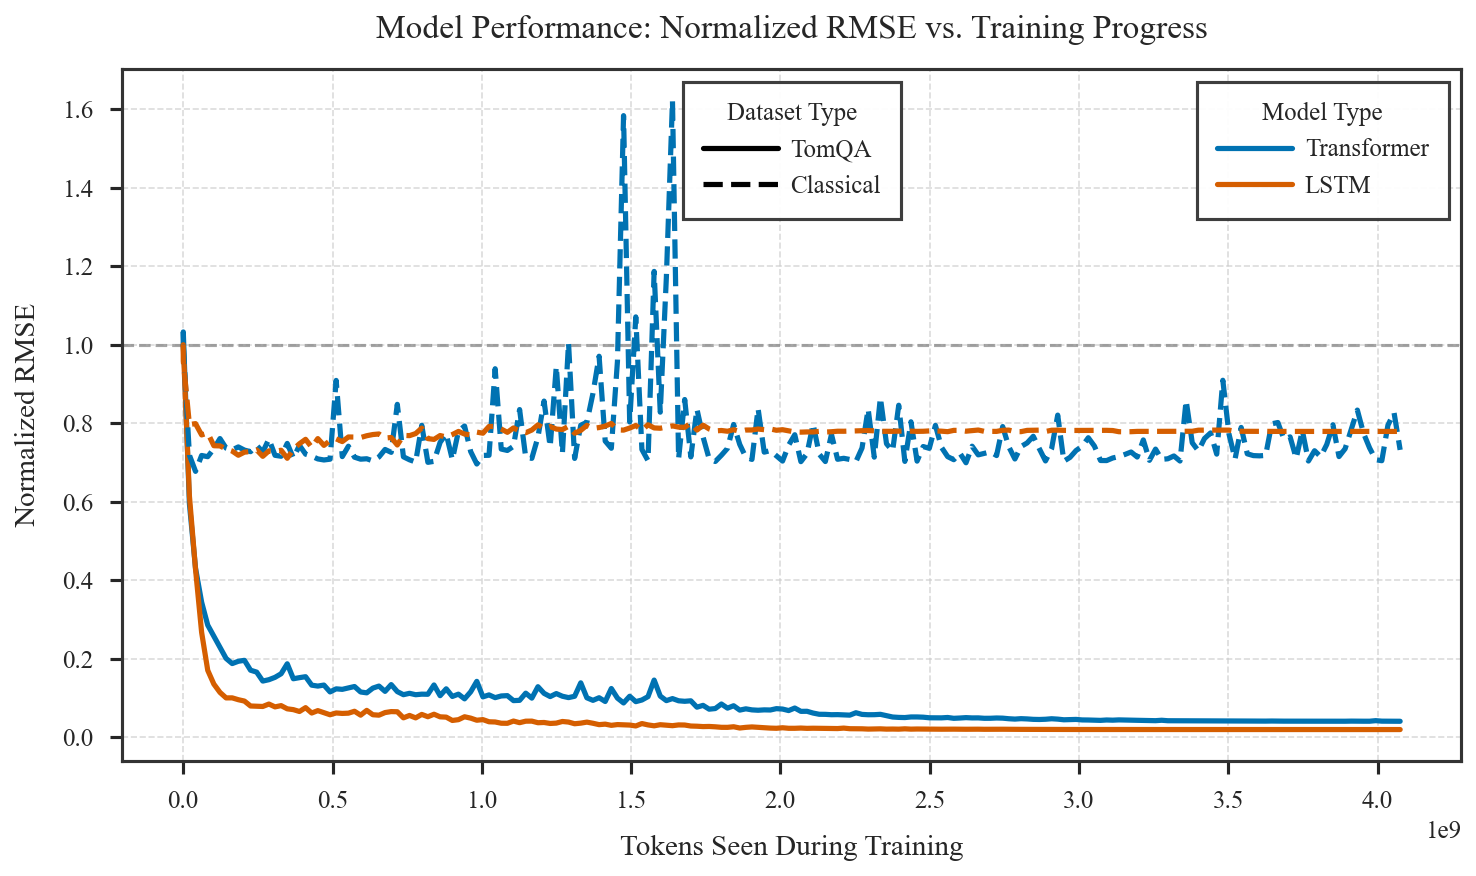


--- Plotting Script Finished ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from cycler import cycler

# Set up high-quality plotting style for scientific presentation
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 11

# Define a scientific color palette
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
linestyles = ['-', '--', '-.', ':']

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Data Extraction Function (MODIFIED) ---
def extract_metric_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and specified metric values for a target layer from checkpoint files.
    Calculates the mean if the metric value is an array.

    Args:
        run_dir: The directory containing the checkpoint files.
        is_markov3_run: Boolean indicating if it's a Markov3 run (affects filename pattern).
        target_layer: The layer name (e.g., 'combined') to extract the metric from.
        metric_key: The key of the metric to extract (e.g., 'dist', 'rmse', 'r2').

    Returns:
        A tuple containing two numpy arrays: (sorted_checkpoints, sorted_metric_values)
        Returns (None, None) if no valid data is found.
    """
    checkpoints = []
    metric_values = []

    # Determine filename pattern
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))

    if not ckpt_files:
        print(f"Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_dir}")
        return None, None

    # print(f"Processing {len(ckpt_files)} files from {run_dir} for metric '{metric_key}'...") # Less verbose
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            ckpt_data = joblib.load(f)
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]

                    # Process metric value (average if array, use directly if scalar)
                    processed_value = None
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                             with warnings.catch_warnings(): # Suppress mean of empty slice warning
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                processed_value = float(np.sqrt(np.nanmean(metric_value ** 2)))
                        else:
                             print(f"Warning: Metric '{metric_key}' in {f} is an empty array. Skipping.")
                             continue
                    elif isinstance(metric_value, (int, float, np.number)):
                        processed_value = float(metric_value)
                    else:
                        print(f"Warning: Metric '{metric_key}' in {f} is not scalar or numpy array ({type(metric_value)}). Skipping.")
                        continue

                    # Append if value is valid
                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx)
                        metric_values.append(processed_value)
                    # else: print(f"Warning: Invalid processed value for metric '{metric_key}' in {f}. Skipping.") # Less verbose

        except AttributeError as e:
             if 'nested_dict_factory' in str(e): print(f"Error loading {f}: Missing 'nested_dict_factory'. Define it globally.")
        except Exception as e:
            print(f"Error loading or processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints:
        print(f"Warning: No valid data extracted for metric '{metric_key}' in {run_dir}")
        return None, None

    # Sort data by checkpoint index
    checkpoints = np.array(checkpoints)
    metric_values = np.array(metric_values)
    sort_indices = np.argsort(checkpoints)
    sorted_checkpoints = checkpoints[sort_indices]
    sorted_metric_values = metric_values[sort_indices]

    return sorted_checkpoints, sorted_metric_values

# --- Main Plotting Script (MODIFIED) ---
if __name__ == "__main__":
    output_base_dir = "run_predictions2"
    plot_output_dir = "dist_plots" # Directory to save the plots
    target_layer = "combined"      # Layer to plot data for

    # Define the runs to plot: (Label, Sweep, RunID, IsMarkov3)
    runs_to_plot = [
        ("Transformer (TomQA)", "20241205175736", 17, False),
        ("LSTM (TomQA)", "20241121152808", 49, False),
        ("Transformer (Classical)", "20241205175736", 17, True),
        ("LSTM (Classical)", "20241121152808", 49, True),
    ]

    # Define metrics to plot and their corresponding labels/filenames
    metrics_to_plot = {
        'rmse': "Normalized RMSE",
        # Add other scalar metrics from your save_data if desired
    }

    # --- Loop through metrics to create separate plots with matplotlib ---
    for metric_key, y_label_base in metrics_to_plot.items():
        print(f"\n--- Generating Plot for Metric: {metric_key} ---")
        
        # Create a matplotlib figure
        fig, ax = plt.subplots(figsize=(10, 6))
        all_data_found_for_metric = False
        
        # Track min/max x values for reference line
        min_x, max_x = float('inf'), float('-inf')

        print(f"--- Extracting Data for {metric_key} ---")
        for i, (label, sweep, run_id_int, is_markov3) in enumerate(runs_to_plot):
            run_dir = os.path.join(output_base_dir, f"{sweep}_{run_id_int}")

            # Call the generalized extraction function
            ckpts, metric_vals = extract_metric_data(run_dir, is_markov3, target_layer, metric_key)
            print(f'the shape of metric_vals is {metric_vals.shape}')

            if ckpts is not None and metric_vals is not None and len(ckpts) > 0:
                all_data_found_for_metric = True
                
                # Get the dimensionality of the predictions
                # Try to load the first checkpoint to determine dimensionality
                try:
                    first_ckpt_file = glob.glob(os.path.join(run_dir, f"{'markov3_' if is_markov3 else ''}checkpoint_*.joblib"))[0]
                    ckpt_data = joblib.load(first_ckpt_file)
                    if 'predicted_beliefs' in ckpt_data[target_layer]:
                        pred_shape = ckpt_data[target_layer]['predicted_beliefs'].shape
                        dimension = pred_shape[-1]  # Assuming last dimension is the belief dimension
                    else:
                        # If we can't find the dimension, use a default value
                        dimension = 1
                        print(f"Warning: Could not determine dimension for {label}, using default value of 1")
                except Exception as e:
                    dimension = 1
                    print(f"Error determining dimension for {label}: {e}. Using default value of 1")
                
                # Normalize RMSE by sqrt(dimension)
                normalized_vals = metric_vals / np.sqrt(dimension)
                
                # Normalize by the first value
                if len(normalized_vals) > 0:
                    first_val = normalized_vals[0]
                    if first_val != 0:  # Avoid division by zero
                        normalized_vals = normalized_vals / first_val
                    else:
                        print(f"Warning: First value for {label} is zero, skipping normalization by first value")
                
                # Update min/max x values
                min_x = min(min_x, np.min(ckpts))
                max_x = max(max_x, np.max(ckpts))
                
                # Style based on model type (Transformer vs LSTM) and dataset type (TomQA vs Classical)
                # Use color for model type and linestyle for dataset type
                is_transformer = "Transformer" in label
                color = colors[0] if is_transformer else colors[1]  # First color for Transformer, second for LSTM
                linestyle = '-' if not is_markov3 else '--'  # Solid for TomQA, dashed for Classical
                linewidth = 2.5
                
                # Extract model type and dataset type for legend
                model_type = "Transformer" if is_transformer else "LSTM"
                dataset_type = "TomQA" if not is_markov3 else "Classical"
                
                # Plot the data - lines only, no markers
                ax.plot(
                    ckpts, normalized_vals, 
                    linestyle=linestyle, 
                    color=color, linewidth=linewidth,
                    label=f"{model_type} ({dataset_type})",
                    zorder=10
                )
            else:
                print(f"  -> No data found or extracted for {label} for metric '{metric_key}'.")

        # Customize the plot
        if all_data_found_for_metric:
            # Add a horizontal reference line at y=1
            ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1)
            
            # Set title and labels with LaTeX formatting
            ax.set_title(f"Model Performance: {y_label_base} vs. Training Progress", fontsize=16, pad=15)
            ax.set_xlabel("Tokens Seen During Training", fontsize=14, labelpad=10)
            ax.set_ylabel(f"{y_label_base}", fontsize=14, labelpad=10)
            
            # Customize the grid
            ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
            
            # Customize the spines
            for spine in ax.spines.values():
                spine.set_linewidth(1.5)
            
            # Customize the ticks
            ax.tick_params(axis='both', which='major', length=6, width=1.5, pad=8)
            ax.tick_params(axis='both', which='minor', length=3, width=1.0)
            
            # Use integer ticks for x-axis
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            # Create a more elegant legend with separate entries for model type and dataset type
            from matplotlib.lines import Line2D
            
            # Create custom legend elements
            model_elements = [
                Line2D([0], [0], color=colors[0], lw=2.5, label='Transformer'),
                Line2D([0], [0], color=colors[1], lw=2.5, label='LSTM')
            ]
            
            dataset_elements = [
                Line2D([0], [0], color='black', lw=2.5, linestyle='-', label='TomQA'),
                Line2D([0], [0], color='black', lw=2.5, linestyle='--', label='Classical')
            ]
            
            # Create two legends
            first_legend = ax.legend(handles=model_elements, loc='upper right', 
                                    title="Model Type", frameon=True, framealpha=0.95,
                                    edgecolor='#333333', fancybox=False, borderpad=0.8,
                                    handlelength=3.0, handletextpad=0.5, fontsize=12)
            
            # Add the first legend manually
            ax.add_artist(first_legend)
            first_legend.get_frame().set_linewidth(1.5)
            
            # Add the second legend
            second_legend = ax.legend(handles=dataset_elements, loc='upper center', 
                                     title="Dataset Type", frameon=True, framealpha=0.95,
                                     edgecolor='#333333', fancybox=False, borderpad=0.8,
                                     handlelength=3.0, handletextpad=0.5, fontsize=12)
            second_legend.get_frame().set_linewidth(1.5)
            
            # Tight layout
            plt.tight_layout()
            
            # Save the figure with high resolution
            os.makedirs(plot_output_dir, exist_ok=True)
            fig_path = os.path.join(plot_output_dir, f"{metric_key}_{target_layer}_comparison.pdf")
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {fig_path}")
            
            # Show the plot
            plt.show()
        else:
            print(f"\nNo data was successfully extracted for metric '{metric_key}'. Plot not generated.")

    print("\n--- Plotting Script Finished ---")



--- Generating Plot for Metric: rmse ---
--- Extracting Data for rmse ---
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
Error determining dimension for Transformer (Classical): 'int' object has no attribute 'shape'. Using default value of 1
the shape of metric_vals is (201,)
Error determining dimension for LSTM (Classical): 'int' object has no attribute 'shape'. Using default value of 1
Figure saved to dist_plots/rmse_combined_comparison.pdf


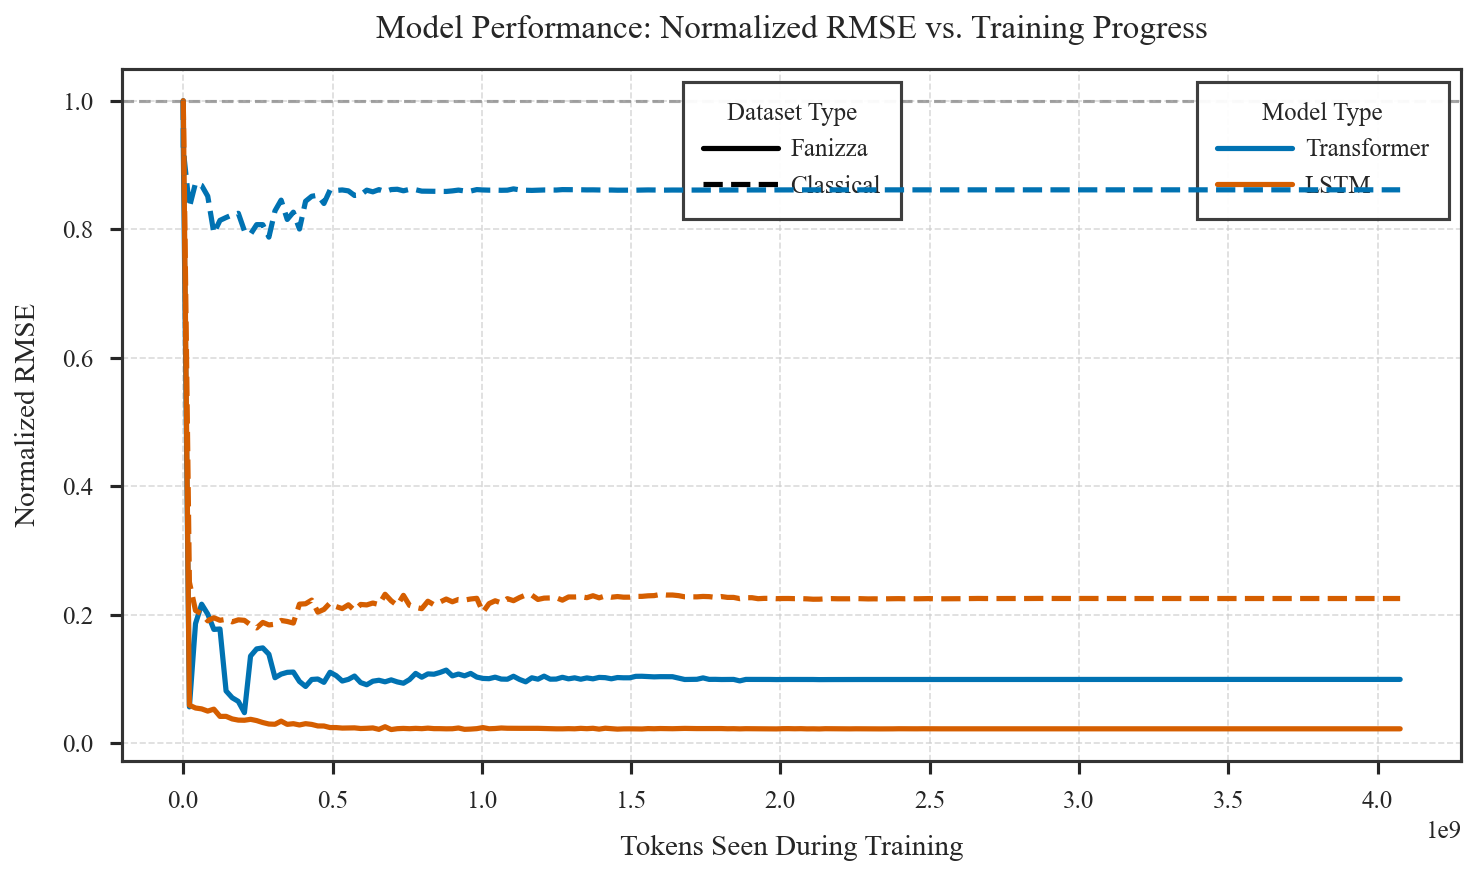


--- Plotting Script Finished ---


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from cycler import cycler

# Set up high-quality plotting style for scientific presentation
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 11

# Define a scientific color palette
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
linestyles = ['-', '--', '-.', ':']

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Data Extraction Function (MODIFIED) ---
def extract_metric_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and specified metric values for a target layer from checkpoint files.
    Calculates the mean if the metric value is an array.

    Args:
        run_dir: The directory containing the checkpoint files.
        is_markov3_run: Boolean indicating if it's a Markov3 run (affects filename pattern).
        target_layer: The layer name (e.g., 'combined') to extract the metric from.
        metric_key: The key of the metric to extract (e.g., 'dist', 'rmse', 'r2').

    Returns:
        A tuple containing two numpy arrays: (sorted_checkpoints, sorted_metric_values)
        Returns (None, None) if no valid data is found.
    """
    checkpoints = []
    metric_values = []

    # Determine filename pattern
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))

    if not ckpt_files:
        print(f"Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_dir}")
        return None, None

    # print(f"Processing {len(ckpt_files)} files from {run_dir} for metric '{metric_key}'...") # Less verbose
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            ckpt_data = joblib.load(f)
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]

                    # Process metric value (average if array, use directly if scalar)
                    processed_value = None
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                             with warnings.catch_warnings(): # Suppress mean of empty slice warning
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                processed_value = float(np.sqrt(np.nanmean(metric_value ** 2)))
                        else:
                             print(f"Warning: Metric '{metric_key}' in {f} is an empty array. Skipping.")
                             continue
                    elif isinstance(metric_value, (int, float, np.number)):
                        processed_value = float(metric_value)
                    else:
                        print(f"Warning: Metric '{metric_key}' in {f} is not scalar or numpy array ({type(metric_value)}). Skipping.")
                        continue

                    # Append if value is valid
                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx)
                        metric_values.append(processed_value)
                    # else: print(f"Warning: Invalid processed value for metric '{metric_key}' in {f}. Skipping.") # Less verbose

        except AttributeError as e:
             if 'nested_dict_factory' in str(e): print(f"Error loading {f}: Missing 'nested_dict_factory'. Define it globally.")
        except Exception as e:
            print(f"Error loading or processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints:
        print(f"Warning: No valid data extracted for metric '{metric_key}' in {run_dir}")
        return None, None

    # Sort data by checkpoint index
    checkpoints = np.array(checkpoints)
    metric_values = np.array(metric_values)
    sort_indices = np.argsort(checkpoints)
    sorted_checkpoints = checkpoints[sort_indices]
    sorted_metric_values = metric_values[sort_indices]

    return sorted_checkpoints, sorted_metric_values

# --- Main Plotting Script (MODIFIED) ---
if __name__ == "__main__":
    output_base_dir = "run_predictions2"
    output_base_dir = "run_predictions_cv"

    plot_output_dir = "dist_plots" # Directory to save the plots
    target_layer = "combined"      # Layer to plot data for

    # Define the runs to plot: (Label, Sweep, RunID, IsMarkov3)
    runs_to_plot = [
        ("Transformer (Fanizza)", "20241205175736", 21, False),
        ("LSTM (Fanizza)", "20241121152808", 53, False),
        ("Transformer (Classical)", "20241205175736", 21, True),
        ("LSTM (Classical)", "20241121152808", 53, True),
    ]

    # Define metrics to plot and their corresponding labels/filenames
    metrics_to_plot = {
        'rmse': "Normalized RMSE",
        # Add other scalar metrics from your save_data if desired
    }

    # --- Loop through metrics to create separate plots with matplotlib ---
    for metric_key, y_label_base in metrics_to_plot.items():
        print(f"\n--- Generating Plot for Metric: {metric_key} ---")
        
        # Create a matplotlib figure
        fig, ax = plt.subplots(figsize=(10, 6))
        all_data_found_for_metric = False
        
        # Track min/max x values for reference line
        min_x, max_x = float('inf'), float('-inf')

        print(f"--- Extracting Data for {metric_key} ---")
        for i, (label, sweep, run_id_int, is_markov3) in enumerate(runs_to_plot):
            run_dir = os.path.join(output_base_dir, f"{sweep}_{run_id_int}")

            # Call the generalized extraction function
            ckpts, metric_vals = extract_metric_data(run_dir, is_markov3, target_layer, metric_key)
            print(f'the shape of metric_vals is {metric_vals.shape}')

            if ckpts is not None and metric_vals is not None and len(ckpts) > 0:
                all_data_found_for_metric = True
                
                # Get the dimensionality of the predictions
                # Try to load the first checkpoint to determine dimensionality
                try:
                    first_ckpt_file = glob.glob(os.path.join(run_dir, f"{'markov3_' if is_markov3 else ''}checkpoint_*.joblib"))[0]
                    ckpt_data = joblib.load(first_ckpt_file)
                    if 'predicted_beliefs' in ckpt_data[target_layer]:
                        pred_shape = ckpt_data[target_layer]['predicted_beliefs'].shape
                        dimension = pred_shape[-1]  # Assuming last dimension is the belief dimension
                    else:
                        # If we can't find the dimension, use a default value
                        dimension = 1
                        print(f"Warning: Could not determine dimension for {label}, using default value of 1")
                except Exception as e:
                    dimension = 1
                    print(f"Error determining dimension for {label}: {e}. Using default value of 1")
                
                # Normalize RMSE by sqrt(dimension)
                normalized_vals = metric_vals / np.sqrt(dimension)
                
                # Normalize by the first value
                if len(normalized_vals) > 0:
                    first_val = normalized_vals[0]
                    if first_val != 0:  # Avoid division by zero
                        normalized_vals = normalized_vals / first_val
                    else:
                        print(f"Warning: First value for {label} is zero, skipping normalization by first value")
                
                # Update min/max x values
                min_x = min(min_x, np.min(ckpts))
                max_x = max(max_x, np.max(ckpts))
                
                # Style based on model type (Transformer vs LSTM) and dataset type (TomQA vs Classical)
                # Use color for model type and linestyle for dataset type
                is_transformer = "Transformer" in label
                color = colors[0] if is_transformer else colors[1]  # First color for Transformer, second for LSTM
                linestyle = '-' if not is_markov3 else '--'  # Solid for TomQA, dashed for Classical
                linewidth = 2.5
                
                # Extract model type and dataset type for legend
                model_type = "Transformer" if is_transformer else "LSTM"
                dataset_type = "TomQA" if not is_markov3 else "Classical"
                
                # Plot the data - lines only, no markers
                ax.plot(
                    ckpts, normalized_vals, 
                    linestyle=linestyle, 
                    color=color, linewidth=linewidth,
                    label=f"{model_type} ({dataset_type})",
                    zorder=10
                )
            else:
                print(f"  -> No data found or extracted for {label} for metric '{metric_key}'.")

        # Customize the plot
        if all_data_found_for_metric:
            # Add a horizontal reference line at y=1
            ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1)
            
            # Set title and labels with LaTeX formatting
            ax.set_title(f"Model Performance: {y_label_base} vs. Training Progress", fontsize=16, pad=15)
            ax.set_xlabel("Tokens Seen During Training", fontsize=14, labelpad=10)
            ax.set_ylabel(f"{y_label_base}", fontsize=14, labelpad=10)
            
            # Customize the grid
            ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
            
            # Customize the spines
            for spine in ax.spines.values():
                spine.set_linewidth(1.5)
            
            # Customize the ticks
            ax.tick_params(axis='both', which='major', length=6, width=1.5, pad=8)
            ax.tick_params(axis='both', which='minor', length=3, width=1.0)
            
            # Use integer ticks for x-axis
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            # Create a more elegant legend with separate entries for model type and dataset type
            from matplotlib.lines import Line2D
            
            # Create custom legend elements
            model_elements = [
                Line2D([0], [0], color=colors[0], lw=2.5, label='Transformer'),
                Line2D([0], [0], color=colors[1], lw=2.5, label='LSTM')
            ]
            
            dataset_elements = [
                Line2D([0], [0], color='black', lw=2.5, linestyle='-', label='Fanizza'),
                Line2D([0], [0], color='black', lw=2.5, linestyle='--', label='Classical')
            ]
            
            # Create two legends
            first_legend = ax.legend(handles=model_elements, loc='upper right', 
                                    title="Model Type", frameon=True, framealpha=0.95,
                                    edgecolor='#333333', fancybox=False, borderpad=0.8,
                                    handlelength=3.0, handletextpad=0.5, fontsize=12)
            
            # Add the first legend manually
            ax.add_artist(first_legend)
            first_legend.get_frame().set_linewidth(1.5)
            
            # Add the second legend
            second_legend = ax.legend(handles=dataset_elements, loc='upper center', 
                                     title="Dataset Type", frameon=True, framealpha=0.95,
                                     edgecolor='#333333', fancybox=False, borderpad=0.8,
                                     handlelength=3.0, handletextpad=0.5, fontsize=12)
            second_legend.get_frame().set_linewidth(1.5)
            
            # Tight layout
            plt.tight_layout()
            
            # Save the figure with high resolution
            os.makedirs(plot_output_dir, exist_ok=True)
            fig_path = os.path.join(plot_output_dir, f"{metric_key}_{target_layer}_comparison.pdf")
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {fig_path}")
            #plt.ylim(0, .15)
            # Show the plot
            plt.show()
        else:
            print(f"\nNo data was successfully extracted for metric '{metric_key}'. Plot not generated.")

    print("\n--- Plotting Script Finished ---")



--- Generating Plot for Metric: rmse ---
--- Extracting Data for rmse ---
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
the shape of metric_vals is (201,)
Error determining dimension for Transformer (Classical): 'int' object has no attribute 'shape'. Using default value of 1
the shape of metric_vals is (201,)
Error determining dimension for LSTM (Classical): 'int' object has no attribute 'shape'. Using default value of 1
Figure saved to dist_plots/rmse_combined_comparison.pdf


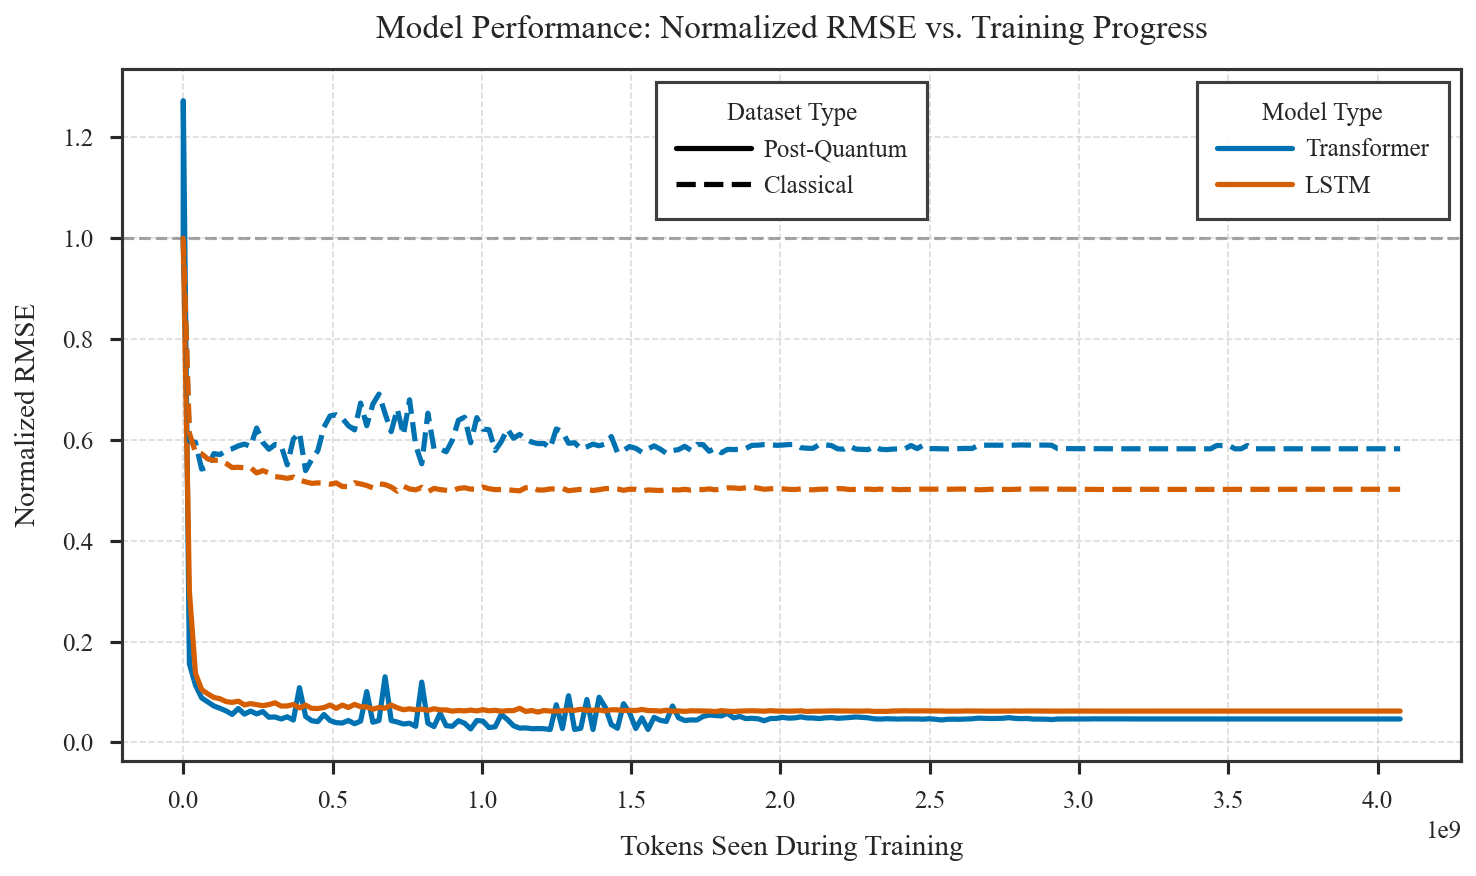


--- Plotting Script Finished ---


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from cycler import cycler

# Set up high-quality plotting style for scientific presentation
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 11

# Define a scientific color palette
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
linestyles = ['-', '--', '-.', ':']

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Data Extraction Function (MODIFIED) ---
def extract_metric_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and specified metric values for a target layer from checkpoint files.
    Calculates the mean if the metric value is an array.

    Args:
        run_dir: The directory containing the checkpoint files.
        is_markov3_run: Boolean indicating if it's a Markov3 run (affects filename pattern).
        target_layer: The layer name (e.g., 'combined') to extract the metric from.
        metric_key: The key of the metric to extract (e.g., 'dist', 'rmse', 'r2').

    Returns:
        A tuple containing two numpy arrays: (sorted_checkpoints, sorted_metric_values)
        Returns (None, None) if no valid data is found.
    """
    checkpoints = []
    metric_values = []

    # Determine filename pattern
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))

    if not ckpt_files:
        print(f"Warning: No checkpoint files found matching '{ckpt_pattern}' in {run_dir}")
        return None, None

    # print(f"Processing {len(ckpt_files)} files from {run_dir} for metric '{metric_key}'...") # Less verbose
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            ckpt_data = joblib.load(f)
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]

                    # Process metric value (average if array, use directly if scalar)
                    processed_value = None
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                             with warnings.catch_warnings(): # Suppress mean of empty slice warning
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                processed_value = float(np.sqrt(np.nanmean(metric_value ** 2)))
                        else:
                             print(f"Warning: Metric '{metric_key}' in {f} is an empty array. Skipping.")
                             continue
                    elif isinstance(metric_value, (int, float, np.number)):
                        processed_value = float(metric_value)
                    else:
                        print(f"Warning: Metric '{metric_key}' in {f} is not scalar or numpy array ({type(metric_value)}). Skipping.")
                        continue

                    # Append if value is valid
                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx)
                        metric_values.append(processed_value)
                    # else: print(f"Warning: Invalid processed value for metric '{metric_key}' in {f}. Skipping.") # Less verbose

        except AttributeError as e:
             if 'nested_dict_factory' in str(e): print(f"Error loading {f}: Missing 'nested_dict_factory'. Define it globally.")
        except Exception as e:
            print(f"Error loading or processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints:
        print(f"Warning: No valid data extracted for metric '{metric_key}' in {run_dir}")
        return None, None

    # Sort data by checkpoint index
    checkpoints = np.array(checkpoints)
    metric_values = np.array(metric_values)
    sort_indices = np.argsort(checkpoints)
    sorted_checkpoints = checkpoints[sort_indices]
    sorted_metric_values = metric_values[sort_indices]

    return sorted_checkpoints, sorted_metric_values

# --- Main Plotting Script (MODIFIED) ---
if __name__ == "__main__":
    #output_base_dir = "run_predictions2"
    output_base_dir = "run_predictions_cv"
    plot_output_dir = "dist_plots" # Directory to save the plots
    target_layer = "combined"      # Layer to plot data for

    # Define the runs to plot: (Label, Sweep, RunID, IsMarkov3)
    runs_to_plot = [
        ("Transformer (Post-Quantum)", "20241205175736", 16, False),
        ("LSTM (Post-Quantum)", "20241121152808", 48, False),
        ("Transformer (Classical)", "20241205175736", 16, True),
        ("LSTM (Classical)", "20241121152808", 48, True),
    ]

    # Define metrics to plot and their corresponding labels/filenames
    metrics_to_plot = {
        'rmse': "Normalized RMSE",
        # Add other scalar metrics from your save_data if desired
    }

    # --- Loop through metrics to create separate plots with matplotlib ---
    for metric_key, y_label_base in metrics_to_plot.items():
        print(f"\n--- Generating Plot for Metric: {metric_key} ---")
        
        # Create a matplotlib figure
        fig, ax = plt.subplots(figsize=(10, 6))
        all_data_found_for_metric = False
        
        # Track min/max x values for reference line
        min_x, max_x = float('inf'), float('-inf')

        print(f"--- Extracting Data for {metric_key} ---")
        for i, (label, sweep, run_id_int, is_markov3) in enumerate(runs_to_plot):
            run_dir = os.path.join(output_base_dir, f"{sweep}_{run_id_int}")

            # Call the generalized extraction function
            ckpts, metric_vals = extract_metric_data(run_dir, is_markov3, target_layer, metric_key)
            print(f'the shape of metric_vals is {metric_vals.shape}')

            if ckpts is not None and metric_vals is not None and len(ckpts) > 0:
                all_data_found_for_metric = True
                
                # Get the dimensionality of the predictions
                # Try to load the first checkpoint to determine dimensionality
                try:
                    first_ckpt_file = glob.glob(os.path.join(run_dir, f"{'markov3_' if is_markov3 else ''}checkpoint_*.joblib"))[0]
                    ckpt_data = joblib.load(first_ckpt_file)
                    if 'predicted_beliefs' in ckpt_data[target_layer]:
                        pred_shape = ckpt_data[target_layer]['predicted_beliefs'].shape
                        dimension = pred_shape[-1]  # Assuming last dimension is the belief dimension
                    else:
                        # If we can't find the dimension, use a default value
                        dimension = 1
                        print(f"Warning: Could not determine dimension for {label}, using default value of 1")
                except Exception as e:
                    dimension = 1
                    print(f"Error determining dimension for {label}: {e}. Using default value of 1")
                
                # Normalize RMSE by sqrt(dimension)
                normalized_vals = metric_vals / np.sqrt(dimension)
                
                # Normalize by the first value
                if len(normalized_vals) > 0:
                    first_val = normalized_vals[0]
                    if first_val != 0:  # Avoid division by zero
                        normalized_vals = normalized_vals / first_val
                    else:
                        print(f"Warning: First value for {label} is zero, skipping normalization by first value")
                
                # Update min/max x values
                min_x = min(min_x, np.min(ckpts))
                max_x = max(max_x, np.max(ckpts))
                
                # Style based on model type (Transformer vs LSTM) and dataset type (TomQA vs Classical)
                # Use color for model type and linestyle for dataset type
                is_transformer = "Transformer" in label
                color = colors[0] if is_transformer else colors[1]  # First color for Transformer, second for LSTM
                linestyle = '-' if not is_markov3 else '--'  # Solid for TomQA, dashed for Classical
                linewidth = 2.5
                
                # Extract model type and dataset type for legend
                model_type = "Transformer" if is_transformer else "LSTM"
                dataset_type = "TomQA" if not is_markov3 else "Classical"
                
                # Plot the data - lines only, no markers
                ax.plot(
                    ckpts, normalized_vals, 
                    linestyle=linestyle, 
                    color=color, linewidth=linewidth,
                    label=f"{model_type} ({dataset_type})",
                    zorder=10
                )
            else:
                print(f"  -> No data found or extracted for {label} for metric '{metric_key}'.")

        # Customize the plot
        if all_data_found_for_metric:
            # Add a horizontal reference line at y=1
            ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1)
            
            # Set title and labels with LaTeX formatting
            ax.set_title(f"Model Performance: {y_label_base} vs. Training Progress", fontsize=16, pad=15)
            ax.set_xlabel("Tokens Seen During Training", fontsize=14, labelpad=10)
            ax.set_ylabel(f"{y_label_base}", fontsize=14, labelpad=10)
            
            # Customize the grid
            ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
            
            # Customize the spines
            for spine in ax.spines.values():
                spine.set_linewidth(1.5)
            
            # Customize the ticks
            ax.tick_params(axis='both', which='major', length=6, width=1.5, pad=8)
            ax.tick_params(axis='both', which='minor', length=3, width=1.0)
            
            # Use integer ticks for x-axis
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            # Create a more elegant legend with separate entries for model type and dataset type
            from matplotlib.lines import Line2D
            
            # Create custom legend elements
            model_elements = [
                Line2D([0], [0], color=colors[0], lw=2.5, label='Transformer'),
                Line2D([0], [0], color=colors[1], lw=2.5, label='LSTM')
            ]
            
            dataset_elements = [
                Line2D([0], [0], color='black', lw=2.5, linestyle='-', label='Post-Quantum'),
                Line2D([0], [0], color='black', lw=2.5, linestyle='--', label='Classical')
            ]
            
            # Create two legends
            first_legend = ax.legend(handles=model_elements, loc='upper right', 
                                    title="Model Type", frameon=True, framealpha=0.95,
                                    edgecolor='#333333', fancybox=False, borderpad=0.8,
                                    handlelength=3.0, handletextpad=0.5, fontsize=12)
            
            # Add the first legend manually
            ax.add_artist(first_legend)
            first_legend.get_frame().set_linewidth(1.5)
            
            # Add the second legend
            second_legend = ax.legend(handles=dataset_elements, loc='upper center', 
                                     title="Dataset Type", frameon=True, framealpha=0.95,
                                     edgecolor='#333333', fancybox=False, borderpad=0.8,
                                     handlelength=3.0, handletextpad=0.5, fontsize=12)
            second_legend.get_frame().set_linewidth(1.5)
            
            # Tight layout
            plt.tight_layout()
            
            # Save the figure with high resolution
            os.makedirs(plot_output_dir, exist_ok=True)
            fig_path = os.path.join(plot_output_dir, f"{metric_key}_{target_layer}_comparison.pdf")
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {fig_path}")
            #plt.ylim(0, .15)
            # Show the plot
            plt.show()
        else:
            print(f"\nNo data was successfully extracted for metric '{metric_key}'. Plot not generated.")

    print("\n--- Plotting Script Finished ---")


--- Extracting RMSE data for TomQA Transformer ---
5 Checkpoints selected for visualization: ['0', '20684800', '389324800', '1413324800', '4075724800']
Loaded GT data: run_predictions2/20241205175736_17/ground_truth_data.joblib

--- Plotting Visualization Panels ---

Visualization progression figure saved to belief_viz_progression/tomqa_transformer_belief_progression_combined_preds_only_geom.png

--- Belief Progression Plotting Script Finished ---


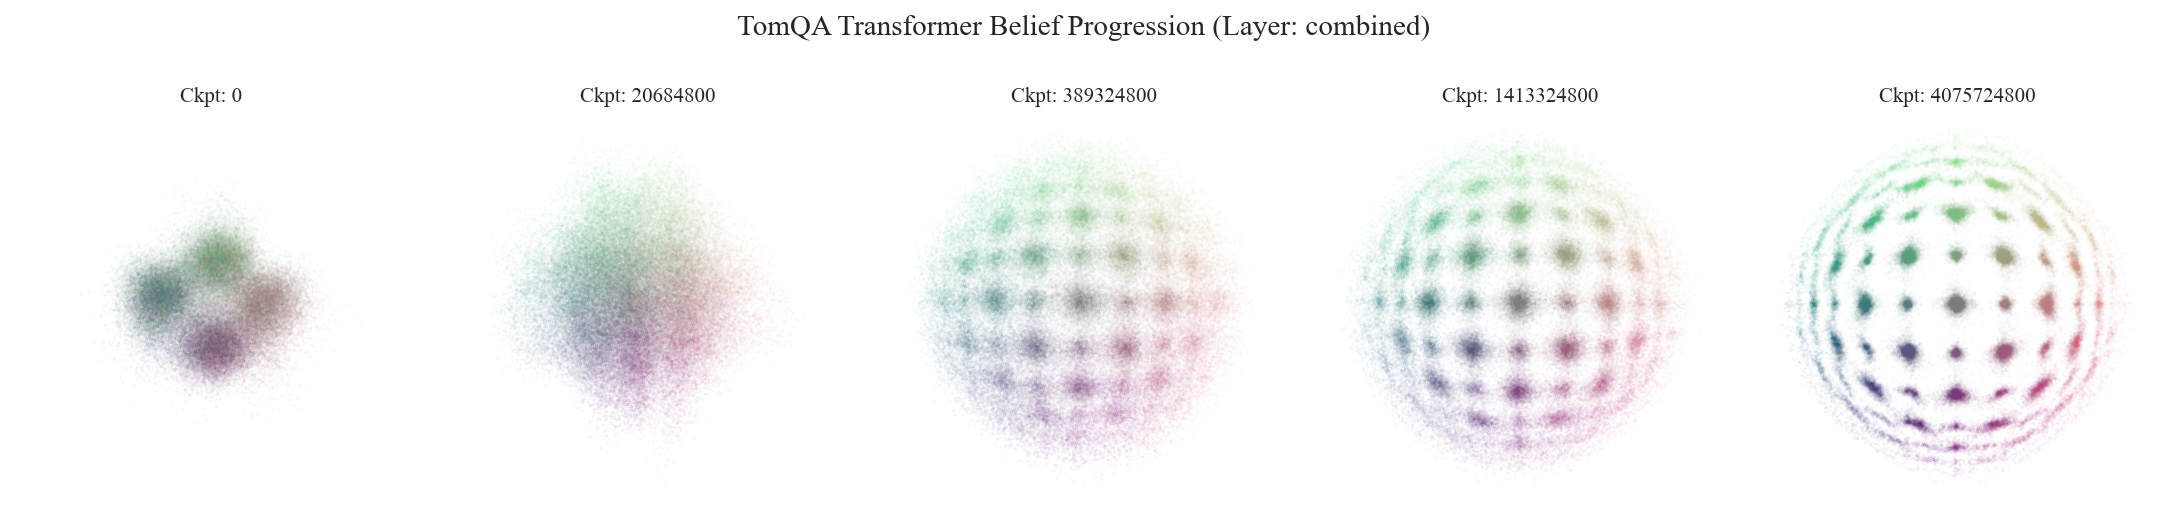

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec # Import GridSpec
from matplotlib.ticker import MaxNLocator, LogLocator, NullFormatter # For tick formatting

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Helper Functions (Copied from previous versions) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1)
    return min_alpha + (1.0 - min_alpha) * normalized

def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict | None:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: GT file not found: {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        print(f"Loaded GT data: {ground_truth_filepath}")
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys.")
        if 'beliefs' in ground_truth_data: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
        if 'probs' in ground_truth_data: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
        return ground_truth_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {ground_truth_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading GT file {ground_truth_filepath}: {e}"); return None

def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """Loads the data dictionary for a single, specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): print(f"Error: Checkpoint file not found: {predictions_filepath}"); return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # print(f"Loaded checkpoint data: {predictions_filepath}") # Less verbose
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict) and 'predicted_beliefs' in data:
                    data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
        return single_ckpt_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint file {predictions_filepath}: {e}"); return None

def _get_plotting_params(experiment_name: str) -> dict:
    """Returns plotting parameters. Using TomQA settings as base."""
    params = { 'point_size': {'truth': 0.15, 'pred': 0.05}, 'min_alpha': 0.1, 'transformation': 'cbrt', 'use_pca': False, 'project_to_simplex': False, 'inds_to_plot': [1, 2], 'com': False }
    # print(f"Using plotting params for TomQA: {params}") # Less verbose
    return params

def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots points on axes, turns axis off."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}). Skipping scatter.")
    else: pass
    ax.set_axis_off()
    if not plotted_something and (x_plot is not None or y_plot is not None): ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
    elif x_plot is None and y_plot is None: ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')

def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates plot coordinates based on strategy."""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca
    n_dims = beliefs_to_plot.shape[1]; effective_inds_to_plot = list(inds_to_plot)
    if use_pca:
        if current_pca is None:
            n_components = max(3, max(effective_inds_to_plot) + 1); n_components = min(n_components, n_dims)
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    current_pca.fit(gt_beliefs_for_pca);
                    beliefs_proj_to_plot = current_pca.transform(beliefs_to_plot)
                    if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                    x_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj_to_plot[:, effective_inds_to_plot[1]]
                except Exception as e: print(f"Error during PCA: {e}. Plotting raw."); use_pca = False; current_pca = None
            else: use_pca = False
        else:
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]; y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with PCA: {e}. Plotting raw."); use_pca = False
    if not use_pca and project_to_simplex:
        if n_dims >= 3: x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: project_to_simplex = False
    if x_plot is None:
        if max(effective_inds_to_plot) >= n_dims: effective_inds_to_plot = [0, 1] if n_dims > 1 else [0, 0]
        if n_dims == 1: effective_inds_to_plot = [0, 0]
        x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
        y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 else effective_inds_to_plot[0]
        y_plot = beliefs_to_plot[:, y_plot_idx]
    return x_plot, y_plot, current_pca

def extract_metric_vs_ckpt_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """ Extracts checkpoint indices and a specific metric for a target layer. """
    checkpoints = []
    metric_values = []
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: print(f"Warning: No files found: {os.path.join(run_dir, ckpt_pattern)}"); return None, None

    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue
        try:
            ckpt_data = joblib.load(f)
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                             with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning)
                             if metric_key == 'rmse': processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                             else: processed_value = float(np.nanmean(metric_value))
                        else: continue
                    elif isinstance(metric_value, (int, float, np.number)): processed_value = float(metric_value)
                    else: continue
                    if processed_value is not None and np.isfinite(processed_value): checkpoints.append(ckpt_idx); metric_values.append(processed_value)
        except Exception as e: print(f"Error processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints: print(f"Warning: No valid data extracted for metric '{metric_key}' in {run_dir}"); return None, None
    checkpoints = np.array(checkpoints); metric_values = np.array(metric_values)
    sort_indices = np.argsort(checkpoints)
    return checkpoints[sort_indices], metric_values[sort_indices]


# --- Main Visualization Function (MODIFIED) ---
def visualize_belief_progression(
    output_base_dir: str,
    plot_output_dir: str,
    sweep_id: str,
    run_id_int: int,
    is_markov3_run: bool, # Flag to load correct GT and checkpoint files
    target_layer: str = "combined",
    output_filename: str = "belief_progression.png",
):
    """ Creates a 1x5 plot showing ONLY Preds (colored by GT) for selected checkpoints,
        using geomspace for checkpoint selection.
    """

    run_dir = os.path.join(output_base_dir, f"{sweep_id}_{run_id_int}")
    experiment_name = "Markov3" if is_markov3_run else "TomQA" # Basic name for params

    # --- 1. Extract RMSE data to select checkpoints ---
    print(f"--- Extracting RMSE data for {experiment_name} Transformer ---")
    rmse_ckpts, rmse_vals = extract_metric_vs_ckpt_data(run_dir, is_markov3_run, target_layer, 'rmse')

    if rmse_ckpts is None or len(rmse_ckpts) < 2: # Need at least 2 points for geomspace
        print("Error: Could not extract sufficient RMSE data. Cannot select checkpoints.")
        return

# --- 2. Select 5 Checkpoints using Index Percentiles (NEW STRATEGY) ---
    viz_ckpts_to_plot = []
    selected_indices = set()
    num_ckpts = len(rmse_ckpts)

    if num_ckpts < 1:
        print("Error: No checkpoints found to select from.")
        return
    elif num_ckpts <= 5:
        # If 5 or fewer checkpoints exist, just use all of them
        selected_indices = set(range(num_ckpts))
        print(f"Warning: Fewer than 5 checkpoints available ({num_ckpts}). Using all available.")
    else:
        # Select based on index percentiles
        idx_initial = 0
        idx_final = num_ckpts - 1
        # Calculate percentile indices (ensure they are valid indices)
        idx_p25 = min(max(0, int(0.01 * idx_final)), idx_final)
        idx_p75 = min(max(0, int(0.1 * idx_final)), idx_final)
        idx_p90 = min(max(0, int(0.35 * idx_final)), idx_final)

        selected_indices.add(idx_initial)
        selected_indices.add(idx_p25)
        selected_indices.add(idx_p75)
        selected_indices.add(idx_p90)
        selected_indices.add(idx_final)

        # If duplicates resulted in < 5 points, add more (e.g., 50% point)
        if len(selected_indices) < 5:
            idx_p50 = min(max(0, int(0.50 * idx_final)), idx_final)
            selected_indices.add(idx_p50)
            # Add more points systematically if still needed (e.g. 10%, 40%, etc.)
            # This part can be expanded if necessary, but usually 50% fills the gap.
            if len(selected_indices) < 5:
                 idx_p10 = min(max(0, int(0.10 * idx_final)), idx_final)
                 selected_indices.add(idx_p10)
            # Add more logic here if needed to guarantee 5 unique points when num_ckpts >= 5

    # Ensure final list is sorted and contains at most 5 indices
    final_selected_indices = sorted(list(selected_indices))
    if len(final_selected_indices) > 5: # Should only happen if fallback logic adds too many
        # Prioritize keeping ends and roughly middle percentiles
        priority_indices = {idx_initial, idx_final, final_selected_indices[len(final_selected_indices)//2]}
        remaining = sorted(list(set(final_selected_indices) - priority_indices))
        needed = 5 - len(priority_indices)
        if needed > 0 and remaining:
             priority_indices.update(remaining[:needed])
        final_selected_indices = sorted(list(priority_indices))[:5]


    viz_ckpts_to_plot = [str(rmse_ckpts[idx]) for idx in final_selected_indices]


    if not viz_ckpts_to_plot:
        print("Error: Failed to select any checkpoints for visualization.")
        return
    # Always report the number selected, even if < 5
    print(f"{len(viz_ckpts_to_plot)} Checkpoints selected for visualization: {viz_ckpts_to_plot}")

    # --- 3. Load GT and Prediction Data for Selected Checkpoints ---
    gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_run else 'ground_truth_data.joblib'
    gt_data = load_ground_truth(run_dir, filename=gt_filename)
    pred_data = {} # ckpt_str -> pred_beliefs

    if not gt_data:
        print("Error: Cannot proceed without ground truth data.")
        return

    for ckpt_str in viz_ckpts_to_plot:
        ckpt_layer_data = load_specific_checkpoint_data(run_dir, is_markov3_run, ckpt_str)
        if ckpt_layer_data and target_layer in ckpt_layer_data and 'predicted_beliefs' in ckpt_layer_data[target_layer]:
             pred_data[ckpt_str] = ckpt_layer_data[target_layer]['predicted_beliefs']
        else:
             print(f"Warning: Could not load prediction data for layer '{target_layer}' at checkpoint {ckpt_str}")
             pred_data[ckpt_str] = None # Mark as missing

    # --- 4. Setup Plot ---
    num_panels = len(viz_ckpts_to_plot) # Use actual number selected
    if num_panels == 0: print("Error: No panels to plot."); return
    fig, axes = plt.subplots(1, num_panels, figsize=(num_panels * 3, 3.5)) # Adjust size as needed
    if num_panels == 1: axes = [axes] # Make iterable if only one panel
    fig.subplots_adjust(wspace=0.05)

    # --- 5. Calculate Coordinates and Colors (once for GT) ---
    gt_beliefs = gt_data['beliefs']
    weights = gt_data['probs']
    params = _get_plotting_params(experiment_name) # Get params for TomQA/Markov3
    belief_dims = gt_beliefs.shape[1]

    # Calculate GT coordinates based on params (needed for color calculation)
    x_gt, y_gt, pca_instance = _calculate_plot_coords(
        gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], None
    )

    # Calculate colors using original RGB scheme based on GT coords
    colors_rgba = None
    if x_gt is not None and y_gt is not None:
        def normalize_dim_color(data_dim):
            min_val, max_val = np.nanmin(data_dim), np.nanmax(data_dim)
            if max_val > min_val: norm = (data_dim - min_val) / (max_val - min_val)
            else: norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5)
        R = normalize_dim_color(x_gt); G = normalize_dim_color(y_gt)
        B_source = None
        if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
             plotted_inds = params['inds_to_plot']; third_dim_index = next((i for i in range(belief_dims) if i not in plotted_inds), plotted_inds[0])
             B_source = gt_beliefs[:, third_dim_index]
        else: B_source = np.sqrt(x_gt**2 + y_gt**2)
        B = normalize_dim_color(B_source)
        alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])
        if all(c is not None and hasattr(c, 'shape') and c.shape == alpha_values.shape for c in [R, G, B]): colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else: num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))
    else: num_points = weights.shape[0]; colors_rgba = np.zeros((num_points, 4))

    # --- 6. Plot Each Panel (MODIFIED - Only Predictions) ---
    print("\n--- Plotting Visualization Panels ---")
    for i, ckpt_str in enumerate(viz_ckpts_to_plot):
        if i >= len(axes): break
        ax = axes[i]
        pred_beliefs = pred_data.get(ckpt_str)

        # Calculate prediction coordinates
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )

        # Plot ONLY Predictions, colored by GT position
        _plot_beliefs_on_ax(ax, x_pred, y_pred, colors_rgba, params['point_size']['pred']) # Use prediction point size

        # Set limits based on combined GT and Pred for this panel
        panel_x = []; panel_y = []
        if x_gt is not None: panel_x.append(x_gt)
        if y_gt is not None: panel_y.append(y_gt)
        if x_pred is not None: panel_x.append(x_pred)
        if y_pred is not None: panel_y.append(y_pred)
        if panel_x and panel_y:
             full_x = np.concatenate([arr for arr in panel_x if arr is not None and arr.size > 0])
             full_y = np.concatenate([arr for arr in panel_y if arr is not None and arr.size > 0])
             if full_x.size > 0 and full_y.size > 0:
                 min_x, max_x = np.nanmin(full_x), np.nanmax(full_x)
                 min_y, max_y = np.nanmin(full_y), np.nanmax(full_y)
                 x_range = max_x - min_x if max_x > min_x else 1.0; y_range = max_y - min_y if max_y > min_y else 1.0
                 x_pad = x_range * 0.05; y_pad = y_range * 0.05
                 ax.set_xlim(min_x - x_pad, max_x + x_pad); ax.set_ylim(min_y - y_pad, max_y + y_pad)
                 ax.set_aspect('equal', adjustable='box')

        ax.set_title(f"Ckpt: {ckpt_str}", fontsize=10, pad=4)

    # --- 7. Final Touches ---
    fig.suptitle(f"{experiment_name} Transformer Belief Progression (Layer: {target_layer})", fontsize=14, y=0.98)
    plt.tight_layout(rect=[0.01, 0.01, 0.99, 0.95]) # Adjust rect for suptitle

    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, output_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nVisualization progression figure saved to {full_output_path}")
    #plt.close(fig)


# --- Example Usage ---
if __name__ == "__main__":

    output_base_dir = "run_predictions2"
    plot_output_dir = "belief_viz_progression" # New directory
    target_layer = "combined"

    # --- Generate plot for TomQA Transformer ---
    visualize_belief_progression(
        output_base_dir=output_base_dir,
        plot_output_dir=plot_output_dir,
        sweep_id="20241205175736",
        run_id_int=17,
        is_markov3_run=False, # Specify TomQA data
        target_layer=target_layer,
        output_filename=f"tomqa_transformer_belief_progression_{target_layer}_preds_only_geom.png" # Updated filename
    )

    # --- Optionally generate plot for Markov3 Transformer ---
    # visualize_belief_progression(
    #     output_base_dir=output_base_dir,
    #     plot_output_dir=plot_output_dir,
    #     sweep_id="20241205175736",
    #     run_id_int=17,
    #     is_markov3_run=True, # Specify Markov3 data
    #     target_layer=target_layer,
    #     output_filename=f"markov3_transformer_belief_progression_{target_layer}_preds_only_geom.png"
    # )

    print("\n--- Belief Progression Plotting Script Finished ---")



--- Extracting Layer Data Across Checkpoints ---

Processing Run: Transformer (TomQA) (Dir: run_predictions2/20241205175736_17, Markov3 Flag: False)
  Loading last checkpoint 4075724800 for Transformer (TomQA)...

Processing Run: Transformer (Classical) (Dir: run_predictions2/20241205175736_17, Markov3 Flag: True)
  Loading last checkpoint 4075724800 for Transformer (Classical)...

Processing Run: LSTM (TomQA) (Dir: run_predictions2/20241121152808_49, Markov3 Flag: False)
  Loading last checkpoint 4075724800 for LSTM (TomQA)...

Processing Run: LSTM (Classical) (Dir: run_predictions2/20241121152808_49, Markov3 Flag: True)
  Loading last checkpoint 4075724800 for LSTM (Classical)...

--- Creating DataFrame ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run Label              26 non-null     object 
 1   

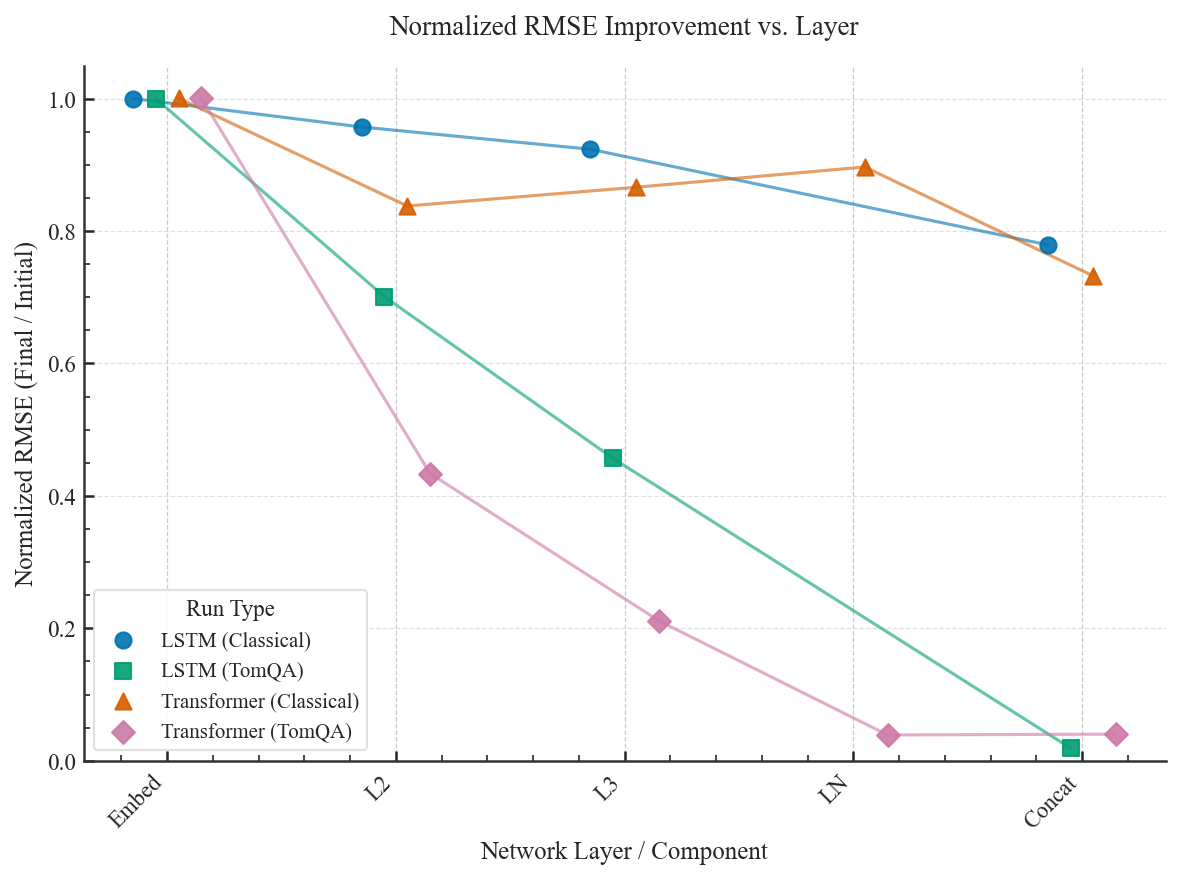

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
import pandas as pd # Import Pandas
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
# from cycler import cycler # Not used

# --- Set up high-quality plotting style ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean base style
mpl.rcParams['figure.figsize'] = (8, 6) # Adjusted figure size for single plot
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2 # Slightly thinner lines for axes
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5 # Control tick size
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in' # Ticks inward
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino'] # Ensure fonts are available or adjust
mpl.rcParams['font.size'] = 11 # Base font size
mpl.rcParams['axes.titlesize'] = 13 # Title size
mpl.rcParams['axes.labelsize'] = 12 # Axis label size
mpl.rcParams['legend.fontsize'] = 10 # Legend font size
mpl.rcParams['grid.color'] = '#cccccc' # Lighter grid color
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6

# Define a scientific color palette (colorblind-friendly)
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7'] # Blue, Green, Orange, Pink/Purple
markers = ['o', 's', '^', 'D'] # Circle, Square, Triangle Up, Diamond
linestyles = ['-', '--', '-.', ':'] # Example linestyles if needed later

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Data Loading Function (Loads one checkpoint)---
def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """Loads the data dictionary for a single, specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): return None # Be less verbose on missing files during bulk load
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                     for key, value in data.items():
                         if isinstance(value, list): data[key] = np.array(value)
        return single_ckpt_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: return None # Be less verbose

# --- Function to find first/last checkpoint index string ---
def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    if first: return str(min(available_indices))
    else: return str(max(available_indices))

# --- Function to extract layer metrics ---
def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            if not isinstance(layer_data, dict): continue
            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning)
                            if metric_key == 'rmse': processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                            else: processed_value = float(np.nanmean(metric_value))
                    elif isinstance(metric_value, (int, float, np.number)):
                        processed_value = float(metric_value)
                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value
    if not layer_metrics: return None
    return dict(layer_metrics)

# --- Function to get belief dimension (assuming constant per run) ---
def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in any layer. """
    if not isinstance(checkpoint_data, dict): return 1
    if target_layer in checkpoint_data and isinstance(checkpoint_data[target_layer], dict) and \
       'predicted_beliefs' in checkpoint_data[target_layer] and \
       isinstance(checkpoint_data[target_layer]['predicted_beliefs'], np.ndarray):
           return checkpoint_data[target_layer]['predicted_beliefs'].shape[-1]
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict) and 'predicted_beliefs' in data and \
           isinstance(data['predicted_beliefs'], np.ndarray) and \
           data['predicted_beliefs'].ndim >= 2:
            return data['predicted_beliefs'].shape[-1]
    print("Warning: Could not determine belief dimension. Defaulting to 1.")
    return 1

# --- Plotting Function ---
def plot_layer_rmse(df: pd.DataFrame, checkpoint_id: int, plot_output_dir: str, output_filename: str):
    """Creates the styled scatter plot for Layer vs Normalized RMSE."""

    print("\n--- Generating Plot ---")
    # Filter the DataFrame for the specified checkpoint
    filtered_df = df[df['Checkpoint'] == checkpoint_id].copy() # Use copy to avoid SettingWithCopyWarning

    if filtered_df.empty:
        print(f"Error: No data found for checkpoint {checkpoint_id}. Cannot generate plot.")
        return

    # Define the desired order and mapping of layers
    layer_name_map = {
        'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
        'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
        'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
        'input': 'Embed', 'layer0': 'L1', 'layer1': 'L2',
        'layer2': 'L3', 'layer3': 'L4', 'combined': 'Concat'
    }
    # Desired final order of RENAMED layers for the plot
    final_layer_order = ['Embed', 'L1', 'L2', 'L3', 'L4', 'LN', 'Concat'] # Include all mapped layers for sorting
    plot_layer_order = ['Embed', 'L2', 'L3', 'LN', 'Concat'] # Layers to actually display

    # Apply mapping (handle cases where mapping might be missing)
    filtered_df['Layer Name (Mapped)'] = filtered_df['Layer Name (Original)'].map(layer_name_map).fillna(filtered_df['Layer Name (Original)'])

    # Filter only the layers we want to plot
    plot_df = filtered_df[filtered_df['Layer Name (Mapped)'].isin(plot_layer_order)].copy()

    # Create a categorical type with our custom display ordering
    plot_df['Layer Order'] = pd.Categorical(
        plot_df['Layer Name (Mapped)'],
        categories=plot_layer_order, # Use the display order here
        ordered=True
    )

    # Sort by run label and then our custom layer order for consistent plotting
    plot_df = plot_df.sort_values(['Run Label', 'Layer Order'])

    # --- Create Plot ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Use rcParams size, or adjust

    # Get unique run labels that actually have data in the filtered df
    run_labels = plot_df['Run Label'].unique()

    # Define styles
    colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7'] # T=Blue, T_Cl=Green, R=Orange, R_Cl=Pink
    markers = ['o', 's', '^', 'D'] # T=Circle, T_Cl=Square, R=Triangle, R_Cl=Diamond
    num_runs_plotted = len(run_labels)
    width = 0.1 # Width for jittering/offset
    offsets = np.linspace(-width * (num_runs_plotted - 1) / 2, width * (num_runs_plotted - 1) / 2, num_runs_plotted)
    if len(offsets) != num_runs_plotted: # Recalculate if needed
        offsets = np.linspace(-width * (num_runs_plotted - 1) / 2, width * (num_runs_plotted - 1) / 2, num_runs_plotted)

    # Map layer names to numerical x-positions
    layer_to_x = {name: i for i, name in enumerate(plot_layer_order)}
    plot_df['x_pos'] = plot_df['Layer Name (Mapped)'].map(layer_to_x)


    for i, label in enumerate(run_labels):
        label_df = plot_df[plot_df['Run Label'] == label]
        style_idx = i % len(colors) # Cycle through styles

        # Plot points with jitter
        ax.scatter(
            label_df['x_pos'] + offsets[i],
            label_df['Normalized RMSE'],
            label=label,
            color=colors[style_idx],
            marker=markers[style_idx],
            s=60, # Adjusted marker size
            alpha=0.9,
            zorder=10 # Ensure points are above grid/lines
        )
        # Plot connecting lines
        ax.plot(
            label_df['x_pos'] + offsets[i],
            label_df['Normalized RMSE'],
            color=colors[style_idx],
            alpha=0.6, # Make lines slightly transparent
            linestyle='-', # Solid line connecting points
            linewidth=1.5,
            zorder=9 # Lines behind markers
        )


    # --- Customize Plot ---
    ax.set_xticks(np.arange(len(plot_layer_order))) # Set ticks at numerical positions
    ax.set_xticklabels(plot_layer_order, rotation=45, ha='right') # Use desired names
    ax.set_xlabel("Network Layer / Component") # Use rcParams size
    ax.set_ylabel(f"Normalized {target_metric.upper()} (Final / Initial)") # Use rcParams size
    ax.set_title(f"Normalized {target_metric.upper()} Improvement vs. Layer", pad=15) # Use rcParams size

    # Add legend
    ax.legend(title="Run Type", frameon=True, framealpha=0.9, edgecolor='#DDDDDD', facecolor='white')

    # Add reference lines (more subtle)
    #ax.axhline(y=1.0, color='#AAAAAA', linestyle='--', linewidth=1.0, alpha=0.8, zorder=1)
    # ax.axhline(y=0.5, color='#CCCCCC', linestyle=':', linewidth=0.8, alpha=0.7, zorder=1)
    # ax.axhline(y=0.25, color='#DDDDDD', linestyle=':', linewidth=0.6, alpha=0.6, zorder=1)

    # Grid and Ticks
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0) # Grid only on y-axis
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.tick_params(axis='x', which='major', pad=5) # Padding for rotated labels
    ax.tick_params(axis='y', which='minor', direction='in', length=3)
    ax.minorticks_on() # Enable minor ticks on y if desired

    # Y-axis limits (optional, adjust as needed)
    # Could calculate min/max from plotted data and add padding
    min_y = plot_df['Normalized RMSE'].min()
    max_y = plot_df['Normalized RMSE'].max()
    if pd.notna(min_y) and pd.notna(max_y):
         pad = (max_y - min_y) * 0.05
         ax.set_ylim(bottom=max(0, min_y - pad), top=max_y + pad) # Ensure bottom is at least 0
    else:
         ax.set_ylim(bottom=0)


    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    # --- Save Plot ---
    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, output_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nLayer comparison plot saved to {full_output_path}")
    #plt.close(fig)


# --- Main Data Extraction and Plotting Call ---
if __name__ == "__main__":
    output_base_dir = "run_predictions2"
    plot_output_dir = "layer_plots"
    target_metric = 'rmse'

    runs_to_extract = [
        {"label": "Transformer (TomQA)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": True},
        {"label": "LSTM (TomQA)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": False},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": True},
    ]

    print("\n--- Extracting Layer Data Across Checkpoints ---")
    all_data_records = []
    last_checkpoint_ids = {} # Store last checkpoint ID found for each run

    for run_info in runs_to_extract:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run: {label} (Dir: {run_dir}, Markov3 Flag: {is_mkv3})")

        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        last_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=False) # Find last checkpoint
        if last_ckpt_str: last_checkpoint_ids[label] = int(last_ckpt_str) # Store numeric ID

        if not first_ckpt_str or not last_ckpt_str: print(f"  Warning: Could not find first/last checkpoints for {label}. Skipping run."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load data for first checkpoint {first_ckpt_str} for {label}. Skipping run."); continue
        initial_layer_metrics = extract_layer_metrics(first_ckpt_data, [target_metric])
        if not initial_layer_metrics: print(f"  Warning: Could not extract initial metrics for {label}. Skipping run."); continue
        dimension = get_belief_dimension(first_ckpt_data)
        # print(f"  Run: {label}, Dimension: {dimension}") # Less verbose

        # Only need last checkpoint data for this specific plot
        print(f"  Loading last checkpoint {last_ckpt_str} for {label}...")
        current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, last_ckpt_str)
        if not current_ckpt_data: print(f"  Warning: Could not load last checkpoint {last_ckpt_str}. Skipping."); continue
        current_layer_metrics = extract_layer_metrics(current_ckpt_data, [target_metric])
        if not current_layer_metrics: print(f"  Warning: Could not extract last checkpoint metrics. Skipping."); continue

        # Calculate normalized metric for each layer using stored initial metrics
        for layer_name, metrics_dict in current_layer_metrics.items():
            current_rmse = metrics_dict.get(target_metric)
            initial_rmse = initial_layer_metrics.get(layer_name, {}).get(target_metric, np.nan)
            normalized_rmse = np.nan
            if current_rmse is not None and not np.isnan(initial_rmse):
                if initial_rmse != 0: normalized_rmse = current_rmse / initial_rmse
                elif current_rmse == 0: normalized_rmse = 1.0
            mapped_layer_name = layer_name_map.get(layer_name, layer_name)
            all_data_records.append({
                'Run Label': label, 'Checkpoint': int(last_ckpt_str),
                'Layer Name (Original)': layer_name, 'Layer Name (Mapped)': mapped_layer_name,
                'Raw RMSE': current_rmse, 'Initial RMSE': initial_rmse,
                'Dimension': dimension, 'Normalized RMSE': normalized_rmse
            })

    if not all_data_records: print("\nError: No data records were created. Cannot generate DataFrame."); exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)
    df = df.sort_values(by=['Run Label', 'Checkpoint', 'Layer Name (Original)']).reset_index(drop=True)
    print("\nDataFrame Info:")
    df.info()
    print("\nDataFrame Head:")
    print(df.head())

    # --- Call the plotting function ---
    # Assuming we want to plot the data for the globally last checkpoint found across all runs
    # Or use a specific checkpoint ID if desired
    final_checkpoint_to_plot = max(last_checkpoint_ids.values()) if last_checkpoint_ids else None
    if final_checkpoint_to_plot:
        plot_layer_rmse(
            df=df,
            checkpoint_id=final_checkpoint_to_plot,
            plot_output_dir=plot_output_dir,
            output_filename=f"layer_vs_normalized_{target_metric}_ckpt{final_checkpoint_to_plot}_pro.png"
        )
    else:
        print("Error: Could not determine a final checkpoint ID to plot.")

    print("\n--- Data Extraction and Plotting Script Finished ---")



--- Extracting Layer Data Across Checkpoints (including Loss) ---

Processing Run: Transformer (FDRN) (Dir: run_predictions2/20241205175736_21, Markov3 Flag: False)
  Processing 201 checkpoints...

Processing Run: LSTM (FDRN) (Dir: run_predictions2/20241121152808_53, Markov3 Flag: False)
  Processing 201 checkpoints...

Processing Run: Transformer (Classical) (Dir: run_predictions2/20241205175736_21, Markov3 Flag: True)
  Processing 201 checkpoints...

Processing Run: LSTM (Classical) (Dir: run_predictions2/20241121152808_53, Markov3 Flag: True)
  Processing 201 checkpoints...

--- Creating DataFrame ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run Label              5226 non-null   object 
 1   Checkpoint             5226 non-null   int64  
 2   Layer Name (Original)  5226 non-null   object 
 3  

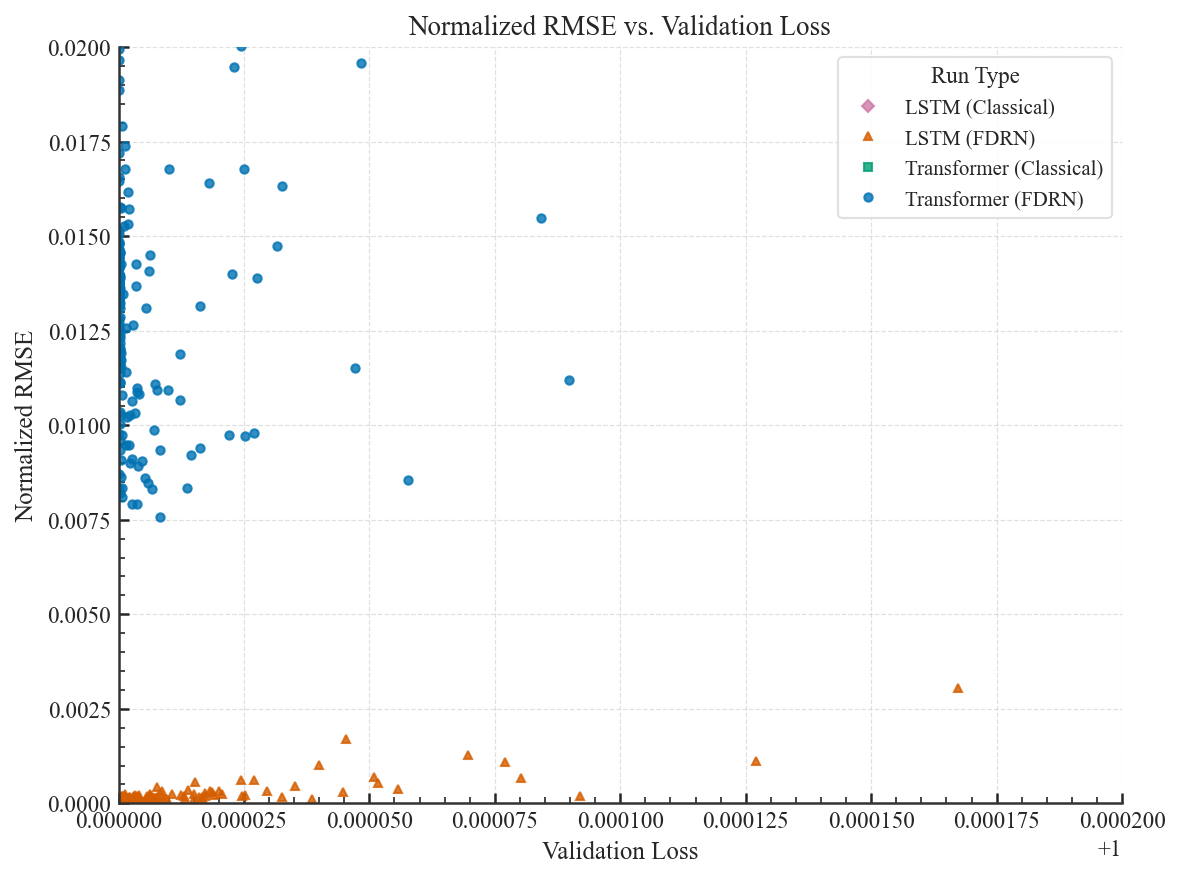

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
import pandas as pd # Import Pandas
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

# --- Set up high-quality plotting style ---
# (Using the same style settings as before)
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['grid.color'] = '#cccccc'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6

# Define colors/styles
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7'] # T=Blue, T_Cl=Green, R=Orange, R_Cl=Pink
markers = ['o', 's', '^', 'D'] # T=Circle, T_Cl=Square, R=Triangle, R_Cl=Diamond
linestyles = ['-', '--', '-', '--'] # TomQA=Solid, Classical=Dashed (Adjust if needed for RNN vs T)

# --- Define missing factory for joblib loading ---
nested_dict_factory = collections.defaultdict

# --- Data Loading Function (Loads one checkpoint)---
def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """Loads the data dictionary for a single, specific checkpoint file."""
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath): return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                     for key, value in data.items():
                         if isinstance(value, list): data[key] = np.array(value)
        return single_ckpt_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e): print(f"Error loading {predictions_filepath}: Missing 'nested_dict_factory'.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: return None

# --- Function to find first/last checkpoint index string ---
def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    if first: return str(min(available_indices))
    else: return str(max(available_indices))

# --- Function to extract layer metrics (MODIFIED to include val_loss_mean) ---
def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            if not isinstance(layer_data, dict): continue
            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # Process metric (get sqrt(mean(sq)) for RMSE, mean for others if array)
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning)
                            if metric_key == 'rmse': processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                            # Add other array metrics here if needed
                            else: processed_value = float(np.nanmean(metric_value))
                    # Handle scalar metrics like val_loss_mean
                    elif isinstance(metric_value, (int, float, np.number)):
                        processed_value = float(metric_value)

                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value

    if not layer_metrics: return None
    return dict(layer_metrics)

# --- Function to get belief dimension ---
def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in any layer. """
    if not isinstance(checkpoint_data, dict): return 1
    if target_layer in checkpoint_data and isinstance(checkpoint_data[target_layer], dict) and \
       'predicted_beliefs' in checkpoint_data[target_layer] and \
       isinstance(checkpoint_data[target_layer]['predicted_beliefs'], np.ndarray):
           return checkpoint_data[target_layer]['predicted_beliefs'].shape[-1]
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict) and 'predicted_beliefs' in data and \
           isinstance(data['predicted_beliefs'], np.ndarray) and \
           data['predicted_beliefs'].ndim >= 2:
            return data['predicted_beliefs'].shape[-1]
    # print("Warning: Could not determine belief dimension. Defaulting to 1.") # Less verbose
    return 1

# --- NEW Plotting Function ---
def plot_rmse_vs_loss(df: pd.DataFrame, target_layer: str, plot_output_dir: str, output_filename: str):
    """Creates the styled plot for Normalized RMSE vs Validation Loss."""

    print(f"\n--- Generating Plot: Normalized RMSE vs Loss ({target_layer} layer) ---")
    # Filter the DataFrame for the specified layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer].copy()

    if layer_df.empty:
        print(f"Error: No data found for layer '{target_layer}'. Cannot generate plot.")
        return
    if 'val_loss_mean' not in layer_df.columns:
        print(f"Error: 'val_loss_mean' column not found in DataFrame. Cannot generate plot.")
        return
    if 'Normalized RMSE' not in layer_df.columns:
         print(f"Error: 'Normalized RMSE' column not found in DataFrame. Cannot generate plot.")
         return

    # --- Create Plot ---
    fig, ax = plt.subplots(figsize=(8, 6)) # Use rcParams size, or adjust

    # Get unique run labels that actually have data
    run_labels = layer_df['Run Label'].unique()

    # Define styles based on label (consistent with previous script)
    run_styles = {}
    for i, label in enumerate(run_labels):
        is_transformer = "Transformer" in label
        is_classical = "Classical" in label
        run_styles[label] = {
            'color': colors[0] if is_transformer else colors[2], # T=Blue, L=Orange
            'linestyle': linestyles[1] if is_classical else linestyles[0], # Classical=Dashed, TomQA=Solid
            'marker': markers[0] if is_transformer else markers[2] # T=Circle, L=Triangle
        }
        # Adjust for Classical runs (different colors/markers)
        if is_classical:
             run_styles[label]['color'] = colors[1] if is_transformer else colors[3] # T_Cl=Green, L_Cl=Pink
             run_styles[label]['marker'] = markers[1] if is_transformer else markers[3] # T_Cl=Square, L_Cl=Diamond


    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        run_df = layer_df[layer_df['Run Label'] == label].sort_values('Checkpoint') # Sort by checkpoint for line plot
        style = run_styles[label]

        # Filter out NaN values for plotting
        plot_run_df = run_df.dropna(subset=['val_loss_mean', 'Normalized RMSE'])

        if not plot_run_df.empty:
            ax.plot(
                plot_run_df['val_loss_mean'],
                plot_run_df['Normalized RMSE'],
                label=label,
                color=style['color'],
                linestyle='',
                marker=style['marker'],
                markersize=4, # Smaller markers for line plot
                linewidth=1.8, # Slightly thicker line
                alpha=0.8
            )
        else:
             print(f"Note: No valid (non-NaN) data points found for run '{label}' to plot.")


    # --- Customize Plot ---
    ax.set_xlabel("Validation Loss") # Use rcParams size
    ax.set_ylabel(f"Normalized RMSE") # Use rcParams size
    ax.set_title(f"Normalized RMSE vs. Validation Loss") # Use rcParams size

    # Add legend
    ax.legend(title="Run Type", frameon=True, framealpha=0.9, edgecolor='#DDDDDD', facecolor='white')

    # Add reference lines (more subtle)
    ax.axhline(y=1.0, color='#AAAAAA', linestyle='--', linewidth=1.0, alpha=0.8, zorder=1)

    # Grid and Ticks
    ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    ax.tick_params(axis='both', which='minor', direction='in', length=3)
    ax.minorticks_on()

    # Y-axis limits
    min_y = layer_df['Normalized RMSE'].min()
    max_y = layer_df['Normalized RMSE'].max()
    if pd.notna(min_y) and pd.notna(max_y):
         pad = (max_y - min_y) * 0.05
         ax.set_ylim(bottom=max(0, min_y - pad), top=1.0) # Add more top padding
    else:
         ax.set_ylim(bottom=0)

    # set xlim to 1 to 1.005
    # make xlim logscale
    ax.set_xlim(1, 1.0002)
    #ax.set_xscale('symlog', linthresh=1.0005, linscale=5.)
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0.,0.02)


    plt.tight_layout()

    # --- Save Plot ---
    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, output_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nRMSE vs Loss plot saved to {full_output_path}")
    #plt.close(fig)


# --- Main Data Extraction and Plotting Call ---
if __name__ == "__main__":
    output_base_dir = "run_predictions2"
    plot_output_dir = "dist_plots" # Save in the same directory for now
    target_metric = 'rmse' # Metric needed for normalization
    # ** Metrics to extract from each checkpoint file **
    metrics_to_extract = ['rmse', 'val_loss_mean']

    runs_to_extract = [
        {"label": "Transformer (TomQA)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": True},
        {"label": "LSTM (TomQA)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": False},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": True}, # Corrected flag
    ]

    runs_to_extract = [
        {"label": "Transformer (FDRN)", "sweep": "20241205175736", "run_id_int": 21, "is_markov3": False},
        {"label": "LSTM (FDRN)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20241205175736", "run_id_int": 21, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": True},
    ]

    layer_name_map = { # Keep map consistent
        'blocks.0.hook_resid_pre': 'Embedding', 'blocks.0.hook_resid_post': 'Layer 1',
        'blocks.1.hook_resid_post': 'Layer 2', 'blocks.2.hook_resid_post': 'Layer 3',
        'blocks.3.hook_resid_post': 'Layer 4', 'ln_final.hook_normalized': 'LayerNorm',
        'input': 'Embedding', 'layer0': 'Layer 1', 'layer1': 'Layer 2',
        'layer2': 'Layer 3', 'layer3': 'Layer 4', 'combined': 'Combined'
    }

    print("\n--- Extracting Layer Data Across Checkpoints (including Loss) ---")
    all_data_records = []

    for run_info in runs_to_extract:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run: {label} (Dir: {run_dir}, Markov3 Flag: {is_mkv3})")

        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find first checkpoint. Skipping run."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load first checkpoint data. Skipping run."); continue
        initial_layer_metrics = extract_layer_metrics(first_ckpt_data, [target_metric]) # Only need RMSE initially
        if not initial_layer_metrics: print(f"  Warning: Could not extract initial metrics. Skipping run."); continue
        dimension = get_belief_dimension(first_ckpt_data)

        ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3 else f"checkpoint_*.joblib"
        ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
        if not ckpt_files: print(f"  Warning: No checkpoint files found. Skipping run."); continue

        print(f"  Processing {len(ckpt_files)} checkpoints...")
        for f in ckpt_files:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
            if not match: continue
            ckpt_idx_str = match.group(1)
            try: ckpt_idx_int = int(ckpt_idx_str)
            except ValueError: continue

            current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, ckpt_idx_str)
            if not current_ckpt_data: continue
            # Extract *all* required metrics (RMSE and Loss) for *all* layers
            current_layer_metrics = extract_layer_metrics(current_ckpt_data, metrics_to_extract)
            if not current_layer_metrics: continue

            for layer_name, metrics_dict in current_layer_metrics.items():
                current_rmse = metrics_dict.get('rmse')
                current_loss = metrics_dict.get('val_loss_mean') # Get loss for this layer/ckpt
                initial_rmse = initial_layer_metrics.get(layer_name, {}).get('rmse', np.nan)
                normalized_rmse = np.nan
                if current_rmse is not None and not np.isnan(initial_rmse):
                    if initial_rmse != 0: normalized_rmse = current_rmse / initial_rmse
                    elif current_rmse == 0: normalized_rmse = 1.0
                mapped_layer_name = layer_name_map.get(layer_name, layer_name)
                all_data_records.append({
                    'Run Label': label, 'Checkpoint': ckpt_idx_int,
                    'Layer Name (Original)': layer_name, 'Layer Name (Mapped)': mapped_layer_name,
                    'Raw RMSE': current_rmse, 'Initial RMSE': initial_rmse,
                    'Dimension': dimension, 'Normalized RMSE': normalized_rmse,
                    'val_loss_mean': current_loss # Add loss to record
                })

    if not all_data_records: print("\nError: No data records were created."); exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)
    df = df.sort_values(by=['Run Label', 'Checkpoint', 'Layer Name (Original)']).reset_index(drop=True)
    print("\nDataFrame Info:")
    df.info() # Verify val_loss_mean column exists
    print("\nDataFrame Head:")
    print(df.head())

    # --- Call the plotting function ---
    plot_rmse_vs_loss(
        df=df,
        target_layer='Combined', # Plot for the 'Combined' layer (make sure mapping is correct)
        plot_output_dir=plot_output_dir,
        output_filename=f"rmse_vs_loss_{target_layer}_pro.png"
    )

    print("\n--- Data Extraction and Plotting Script Finished ---")


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_12216/4012484186.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



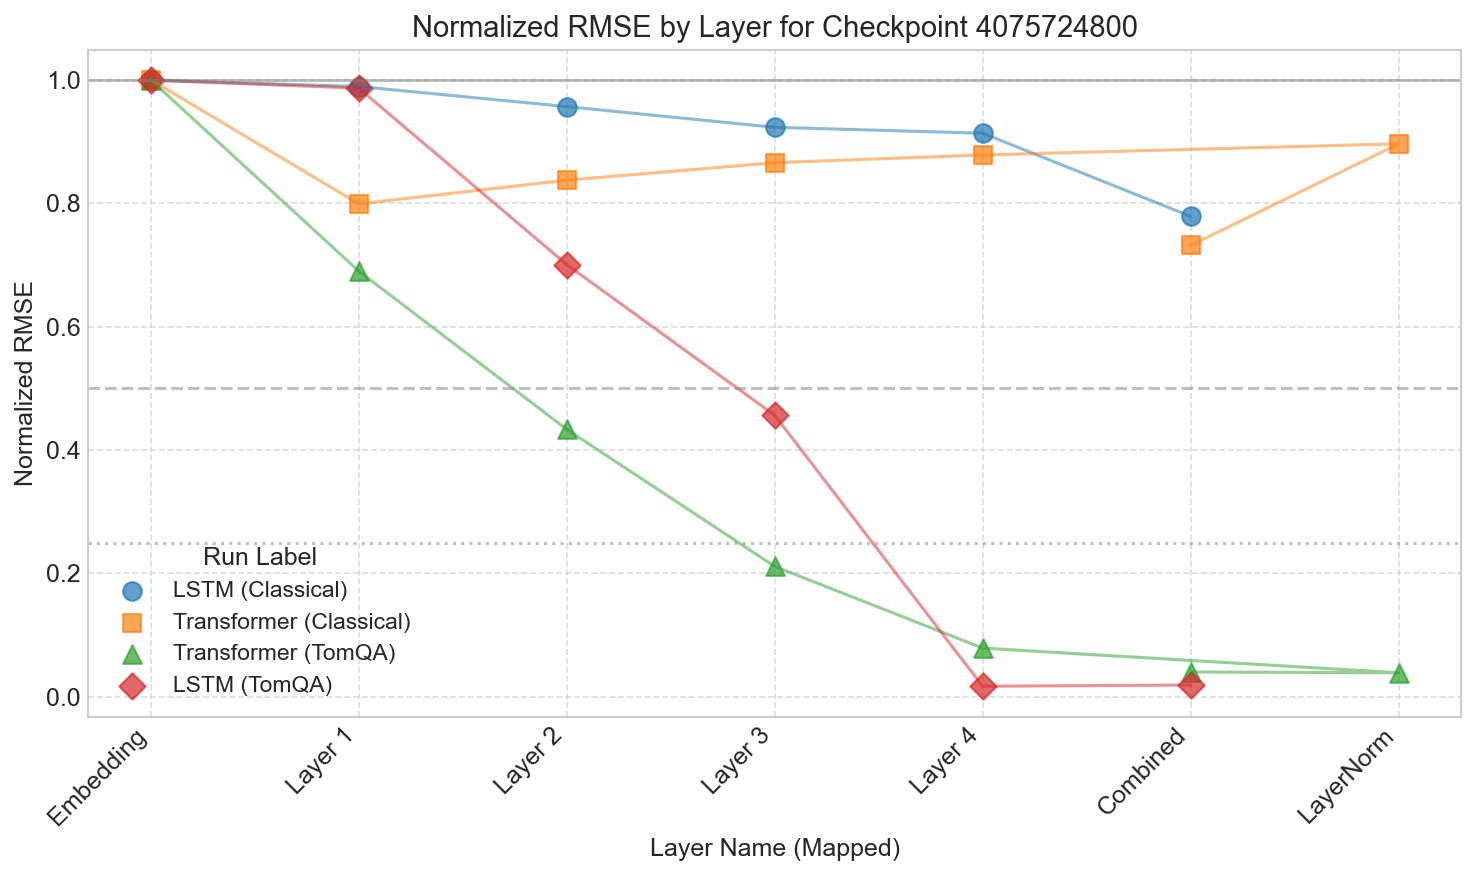

In [75]:
# Create a scatter plot of Normalized RMSE by Layer for the specified checkpoint
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for the specified checkpoint
checkpoint_id = 4075724800
filtered_df = df[df['Checkpoint'] == checkpoint_id]

# Define the desired order of layers
layer_order = ['Embedding', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'LayerNorm', 'Combined']

# Create a categorical type with our custom ordering
filtered_df['Layer Order'] = pd.Categorical(
    filtered_df['Layer Name (Mapped)'], 
    categories=layer_order, 
    ordered=True
)

# Sort by our custom layer order
sorted_df = filtered_df.sort_values('Layer Order')

# Create the scatter plot with different markers/colors for each Run Label
plt.figure(figsize=(10, 6))

# Get unique run labels
run_labels = sorted_df['Run Label'].unique()

# Define markers and colors for different run labels
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
colors = plt.cm.tab10.colors[:len(run_labels)]

# Plot each run label with a different marker/color and connect points with lines
for i, label in enumerate(run_labels):
    label_df = sorted_df[sorted_df['Run Label'] == label]
    marker = markers[i % len(markers)]
    color = colors[i % len(colors)]
    
    # Sort by layer order to ensure lines connect in the right sequence
    label_df = label_df.sort_values('Layer Order')
    
    # Plot scatter points
    plt.scatter(
        label_df['Layer Name (Mapped)'], 
        label_df['Normalized RMSE'], 
        s=80, 
        alpha=0.7,
        marker=marker,
        color=color,
        label=label
    )
    
    # Add lines connecting the points
    plt.plot(
        label_df['Layer Name (Mapped)'],
        label_df['Normalized RMSE'],
        color=color,
        alpha=0.5,
        linestyle='-'
    )

# Add labels and title
plt.xlabel('Layer Name (Mapped)', fontsize=12)
plt.ylabel('Normalized RMSE', fontsize=12)
plt.title(f'Normalized RMSE by Layer for Checkpoint {checkpoint_id}', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for easier reading
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(title='Run Label')

# Add horizontal lines for reference
plt.axhline(y=1.0, color='gray', linestyle='-', alpha=0.5, label='No Change')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Reduction')
plt.axhline(y=0.25, color='gray', linestyle=':', alpha=0.5, label='75% Reduction')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [48]:
dist = np.array([pred_data[ckpt]['combined']['dist'] for ckpt in available_checkpoints])
loss = np.array([pred_data[ckpt]['combined']['val_loss_mean'] for ckpt in available_checkpoints])


--- STEP 1: Extracting Data for DataFrame ---

Processing Run for DF: Transformer (QSlice) (Dir: run_predictions_RCOND_FINAL/20241205175736_17)
  Extracting metrics using extract_metric_vs_ckpt_data for Transformer (QSlice)...
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241205175736_17
  (extract_metric) Extracted 201 valid data points for rmse.
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241205175736_17
  (extract_metric) Extracted 201 valid data points for val_loss_mean.

Processing Run for DF: LSTM (QSlice) (Dir: run_predictions_RCOND_FINAL/20241121152808_49)
  Extracting metrics using extract_metric_vs_ckpt_data for LSTM (QSlice)...
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241121152808_49
  (extract_metric) Extracted 201 valid data points for rmse.
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241121152808_49
  (extrac

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_55083/3701144979.py:1305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space



Combined figure saved to: combined_figure_output/combined_analysis_figure_v2.png
Vector version saved to: combined_figure_output/combined_analysis_figure_v2.svg


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


PDF backup saved to: combined_figure_output/combined_analysis_figure_v2.pdf


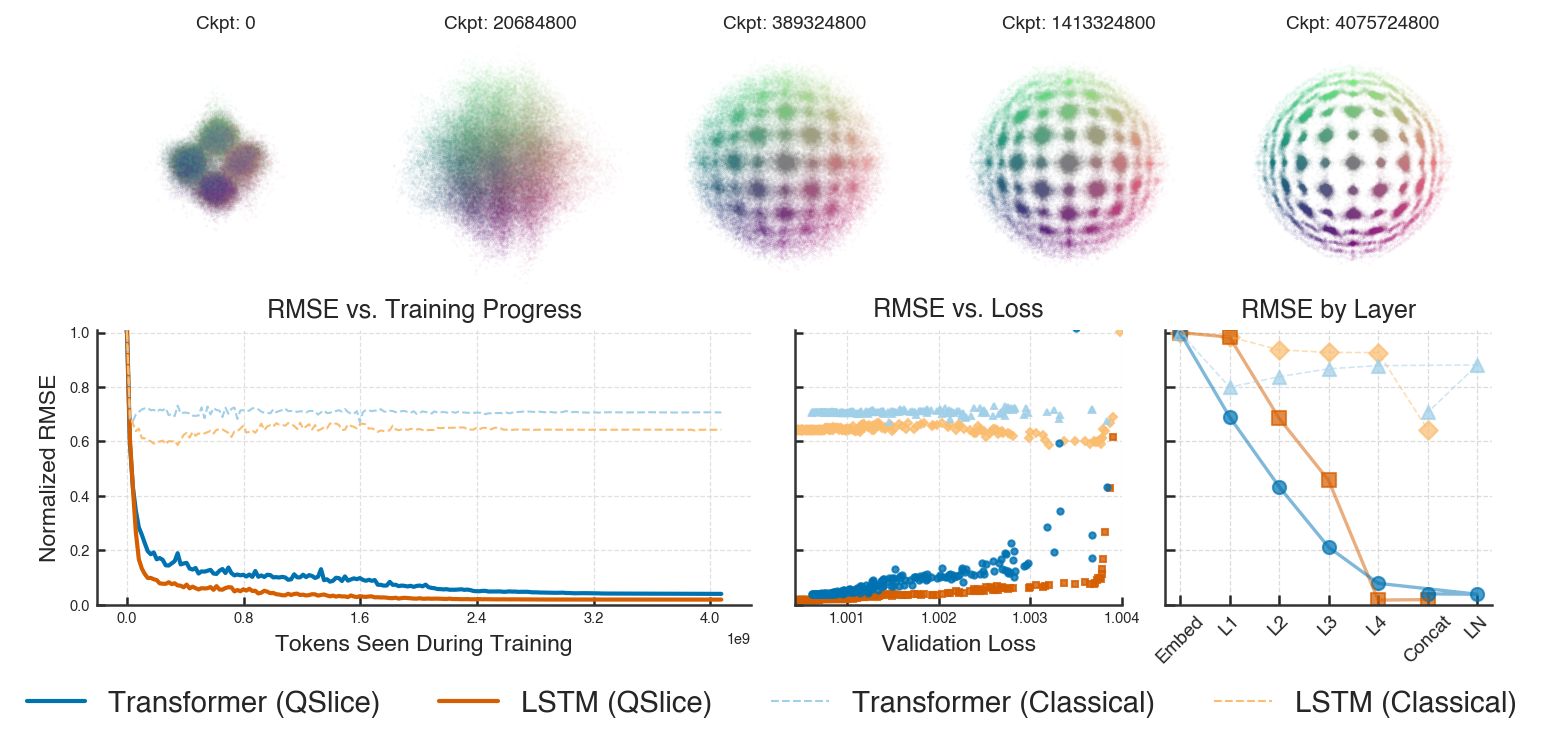


--- Combined Plotting Script Finished ---


In [11]:
# Combined Script for Multi-Panel Figure (v2: Layout & Viz Fixes)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # Import GridSpec
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, LogLocator, NullFormatter # For tick formatting
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from sklearn.decomposition import PCA
import pandas as pd # Import Pandas
from cycler import cycler


# --- Define missing factory for joblib loading (Needed if data saved with older joblib/defaultdict) ---
# If your joblib files load fine without this, you might comment it out.
# nested_dict_factory = collections.defaultdict


# --- Matplotlib Styling (Consistent style) ---
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
mpl.rcParams['font.size'] = 10 # Adjusted default size for potentially smaller subplots
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['grid.color'] = '#cccccc'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6



# Define colors/styles (Consolidated)
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
markers = ['o', 's', '^', 'D', 'v', '<']
linestyles = ['-', '--', '-.', ':']

# Style Mapping: [T_TomQA, L_TomQA, T_Class, L_Class]
run_plot_styles = {
    "Transformer (QSlice)":     {'color': colors[0], 'marker': markers[0], 'linestyle': linestyles[0], 'lw': 2.0},
    "LSTM (QSlice)":            {'color': colors[1], 'marker': markers[1], 'linestyle': linestyles[0], 'lw': 2.0},
    "Transformer (Classical)": {'color': '#A0CFE8', 'marker': markers[2], 'linestyle': linestyles[1], 'lw': 1.0},
    "LSTM (Classical)":        {'color': '#FABD6F', 'marker': markers[3], 'linestyle': linestyles[1], 'lw': 1.0},
}


# --- Helper Functions (Consolidated & Deduped) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights # Linear
    # Clip and normalize alpha values
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5 # Avoid division by zero if all values are same
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1) # Final clip and NaN handling
    return min_alpha + (1.0 - min_alpha) * normalized

def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict | None:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: GT file not found: {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        # print(f"Loaded GT data: {ground_truth_filepath}") # Less verbose
        if not isinstance(ground_truth_data, dict):
            print(f"Warning: Loaded GT data is not a dictionary ({type(ground_truth_data)}).")
            return None
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys 'beliefs' or 'probs'.")
        # Ensure beliefs and probs are numpy arrays
        if 'beliefs' in ground_truth_data:
            try: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
            except Exception as e: print(f"Warning: Could not convert GT beliefs to array: {e}"); ground_truth_data['beliefs'] = None
        if 'probs' in ground_truth_data:
            try: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
            except Exception as e: print(f"Warning: Could not convert GT probs to array: {e}"); ground_truth_data['probs'] = None
        # Check if conversion failed or keys were missing
        if ground_truth_data.get('beliefs') is None or ground_truth_data.get('probs') is None:
             print("Error: GT beliefs or probs are missing or failed conversion.")
             return None
        return ground_truth_data
    except AttributeError as e:
         # Simplified error handling for missing factory
         if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {ground_truth_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading GT file {ground_truth_filepath}: {e}"); return None

def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """
    Loads the data dictionary for a single, specific checkpoint file.
    Performs basic validation and ensures relevant arrays are numpy arrays.
    Used primarily for loading data for the visualization panels AFTER checkpoints are selected.
    """
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath):
        # print(f"Debug: Checkpoint file not found: {predictions_filepath}"); # Debug print
        return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # Basic validation and conversion
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                    # Ensure arrays are numpy arrays
                    for key, value in data.items():
                        if isinstance(value, list):
                            try: data[key] = np.array(value)
                            except Exception: pass # Ignore if conversion fails
                    # Ensure 'predicted_beliefs' is numpy array if present
                    if 'predicted_beliefs' in data and not isinstance(data['predicted_beliefs'], np.ndarray):
                        try: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
                        except Exception: data['predicted_beliefs'] = None # Set to None if conversion fails
        return single_ckpt_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {predictions_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint file {predictions_filepath}: {e}"); return None

def _get_plotting_params(experiment_name: str) -> dict:
    """Returns plotting parameters based on experiment type."""
    params = {
        'point_size': {'truth': 0.15, 'pred': 0.05},
        'min_alpha': 0.1,
        'transformation': 'cbrt', # 'log', 'sqrt', 'cbrt', or 'linear'
        'use_pca': False,
        'project_to_simplex': False, # Only works if not using PCA and dims >= 3
        'inds_to_plot': [1, 2], # *** REVERTED to [1, 2] as per original script ***
        'com': False # Placeholder if needed later
    }
    # Example: Add specific settings for Markov3 if needed
    # if "Markov3" in experiment_name:
    #     params['project_to_simplex'] = True # e.g., Maybe simplex is default for Markov3
    # print(f"Using plotting params: {params}") # Less verbose
    return params

def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates plot coordinates based on strategy. (Using robust version)"""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca

    n_samples, n_dims = beliefs_to_plot.shape
    effective_inds_to_plot = list(inds_to_plot) # Make a copy

    # Ensure indices are valid for the number of dimensions
    if n_dims <= 0: return None, None, current_pca # Cannot plot if no dimensions
    if max(effective_inds_to_plot) >= n_dims:
        original_inds = list(effective_inds_to_plot)
        effective_inds_to_plot = [0, 1] if n_dims >= 2 else [0, 0]
        print(f"Warning: inds_to_plot ({original_inds}) out of bounds for dim {n_dims}. Using {effective_inds_to_plot}.")

    if use_pca:
        if current_pca is None: # Fit PCA if not provided
            n_components = max(2, max(effective_inds_to_plot) + 1) # Need at least 2 components
            n_components = min(n_components, n_dims, n_samples) # Cannot exceed dims or samples
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    # Ensure GT beliefs used for fitting have enough samples
                    if gt_beliefs_for_pca is not None and gt_beliefs_for_pca.shape[0] >= n_components:
                        current_pca.fit(gt_beliefs_for_pca)
                        beliefs_proj = current_pca.transform(beliefs_to_plot)
                        # Adjust indices if needed after projection
                        if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                        x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                        y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                    else:
                         print(f"Warning: Not enough samples ({gt_beliefs_for_pca.shape[0] if gt_beliefs_for_pca is not None else 'None'}) in GT data to fit PCA with {n_components} components. Skipping PCA.")
                         use_pca = False; current_pca = None # Fallback
                except Exception as e: print(f"Error during PCA fitting/transform: {e}. Plotting raw dims."); use_pca = False; current_pca = None
            else: use_pca = False # Not enough dimensions/samples for PCA
        else: # Transform using existing PCA
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1] # Adjust if needed
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with existing PCA: {e}. Plotting raw dims."); use_pca = False # Fallback

    # If PCA wasn't used or failed, try simplex projection or direct indexing
    if x_plot is None:
        if project_to_simplex and n_dims >= 3:
            x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: # Default to direct indexing
            if n_dims == 1: effective_inds_to_plot = [0, 0] # Plot dim 0 vs itself if only 1D
            x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
            # Ensure y index exists
            y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 and effective_inds_to_plot[1] < n_dims else effective_inds_to_plot[0]
            y_plot = beliefs_to_plot[:, y_plot_idx]

    return x_plot, y_plot, current_pca

def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots points on axes, turns axis off."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        # Ensure color array matches points after potential filtering/errors
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}) in _plot_beliefs_on_ax. Skipping scatter.")
    # Don't add text if simply no data to plot (x_plot/y_plot are None)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    ax.set_axis_off()
    # Add error text only if coordinates existed but plotting failed (e.g., color mismatch)
    if not plotted_something and (x_plot is not None or y_plot is not None):
        ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='orange')
    # Add N/A text if coordinates were None from the start
    elif x_plot is None and y_plot is None:
        ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')


def extract_metric_vs_ckpt_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and a specific metric for a target layer.
    Uses direct joblib.load for robustness in finding the metric, similar to standalone script.
    """
    checkpoints = []
    metric_values = []
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    # Use sorted glob to process checkpoints in order
    ckpt_files = sorted(glob.glob(os.path.join(run_dir, ckpt_pattern)))
    if not ckpt_files: print(f"Warning: No files found matching: {os.path.join(run_dir, ckpt_pattern)}"); return None, None

    print(f"  (extract_metric) Found {len(ckpt_files)} files matching pattern in {run_dir}") # Debug print
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            # *** Use direct joblib.load like in the standalone script ***
            ckpt_data = joblib.load(f)

            # Check if loaded data is dict and contains the target layer and metric
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (same as before) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key in ['dist', 'r2', 'val_loss_mean', 'val_loss']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean if unknown array metric
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty arrays
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx); metric_values.append(processed_value)
                    # else: print(f"Debug: Invalid processed value for {metric_key} in {f}") # Debug
                # else: print(f"Debug: Metric '{metric_key}' or layer data dict not found in {f}") # Debug
            # else: print(f"Debug: Target layer '{target_layer}' not found or ckpt_data not dict in {f}") # Debug

        # Catch errors during loading or processing for this specific file
        except FileNotFoundError:
             print(f"Error: File not found during direct load: {f}")
        except AttributeError as e:
             if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {f}: Missing 'defaultdict' definition during load.")
             else: print(f"AttributeError loading/processing file {f}: {e}")
        except Exception as e:
            print(f"Error loading/processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints: print(f"Warning: No valid data extracted for metric '{metric_key}' in layer '{target_layer}' for {run_dir} after checking {len(ckpt_files)} files."); return None, None

    print(f"  (extract_metric) Extracted {len(checkpoints)} valid data points for {metric_key}.") # Debug print
    checkpoints = np.array(checkpoints); metric_values = np.array(metric_values)
    # Data should already be sorted due to sorted glob, but explicit sort is safer
    sort_indices = np.argsort(checkpoints)
    return checkpoints[sort_indices], metric_values[sort_indices]


def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    target_idx = min(available_indices) if first else max(available_indices)
    return str(target_idx)


def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data, processing values. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            # Skip if layer_data is not a dictionary (might be unexpected format)
            if not isinstance(layer_data, dict): continue

            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (Consistent with extract_metric_vs_ckpt_data) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key == 'val_loss_mean' or metric_key == 'val_loss': # Handle potential array loss
                                    processed_value = float(np.nanmean(metric_value))
                                # Add other array metrics if needed (e.g., dist, r2)
                                elif metric_key in ['dist', 'r2']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty array
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value

    if not layer_metrics: return None # Return None if no metrics found for any layer
    return dict(layer_metrics) # Convert back to standard dict

def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in the target layer first, then others. """
    if not isinstance(checkpoint_data, dict): return 1 # Default dimension

    # Check target layer first
    target_layer_data = checkpoint_data.get(target_layer) # Use .get for safety
    if isinstance(target_layer_data, dict):
        pred_beliefs = target_layer_data.get('predicted_beliefs')
        if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2: # Check it's array and has >= 2 dims
                return pred_beliefs.shape[-1] # Return last dimension size

    # If not found in target layer, check other layers
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict):
            pred_beliefs = data.get('predicted_beliefs')
            if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2:
               return pred_beliefs.shape[-1]

    # print(f"Warning: Could not determine belief dimension for target '{target_layer}'. Defaulting to 1.") # Less verbose
    return 1 # Default if not found anywhere

# --- Refactored Plotting Functions ---

def plot_belief_visualizations_on_axes(
    axes: list[plt.Axes],
    run_dir: str,
    is_markov3_run: bool,
    target_layer: str = "combined",
    num_panels_to_plot: int = 5,
    # Optional: Pass pre-loaded data if available to avoid reloading
    gt_data: dict | None = None,
    ckpt_indices_for_rmse: np.ndarray | None = None,
    rmse_values_for_rmse: np.ndarray | None = None,
):
    """ Plots belief progression (preds colored by GT) on the provided axes. """
    if len(axes) != num_panels_to_plot:
        print(f"Error: Number of axes ({len(axes)}) must match num_panels_to_plot ({num_panels_to_plot})")
        return None # Return None to indicate failure/no PCA

    experiment_name = "Markov3" if is_markov3_run else "QSlice"

    # --- 1. Select Checkpoints (Use provided or extract RMSE data) ---
    viz_ckpts_to_plot_str = []
    selected_indices_list = [] # Use list for final indices

    # If RMSE data isn't provided, extract it using the (now modified) extract_metric_vs_ckpt_data
    if ckpt_indices_for_rmse is None or rmse_values_for_rmse is None:
        print(f"--- Extracting RMSE data for {experiment_name} (for viz selection) ---")
        ckpt_indices_for_rmse, rmse_values_for_rmse = extract_metric_vs_ckpt_data(run_dir, is_markov3_run, target_layer, 'rmse')

    if ckpt_indices_for_rmse is None or len(ckpt_indices_for_rmse) < 1:
        print("Error: Could not extract/find any checkpoint indices. Cannot select checkpoints for visualization.")
        # Mark axes as N/A
        for ax in axes:
             ax.text(0.5, 0.5, "No Ckpts Found", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 2. Select Checkpoints using Index Percentiles ---
    rmse_ckpts = ckpt_indices_for_rmse
    selected_indices = set()
    num_ckpts = len(rmse_ckpts)

    if num_ckpts < 1:
        print("Error: No checkpoints found to select from.")
        selected_indices_list = []
    elif num_ckpts <= num_panels_to_plot:
        # If fewer checkpoints exist than panels, just use all of them
        selected_indices = set(range(num_ckpts))
        print(f"Warning: Fewer than {num_panels_to_plot} checkpoints available ({num_ckpts}). Using all available.")
    else:
        # Select based on index percentiles
        idx_initial = 0
        idx_final = num_ckpts - 1
        # Calculate percentile indices (ensure they are valid indices)
        idx_p25 = min(max(0, int(0.01 * idx_final)), idx_final)
        idx_p75 = min(max(0, int(0.1 * idx_final)), idx_final)
        idx_p90 = min(max(0, int(0.35 * idx_final)), idx_final)

        selected_indices.add(idx_initial)
        selected_indices.add(idx_p25)
        selected_indices.add(idx_p75)
        selected_indices.add(idx_p90)
        selected_indices.add(idx_final)

        # If duplicates resulted in < num_panels_to_plot points, add more (e.g., 50% point)
        if len(selected_indices) < num_panels_to_plot:
            idx_p50 = min(max(0, int(0.50 * idx_final)), idx_final)
            selected_indices.add(idx_p50)
            # Add more points systematically if still needed (e.g. 10%, 40%, etc.)
            if len(selected_indices) < num_panels_to_plot:
                 idx_p10 = min(max(0, int(0.10 * idx_final)), idx_final)
                 selected_indices.add(idx_p10)
            # Add more logic here if needed to guarantee num_panels_to_plot unique points

    # Ensure final list is sorted and contains at most num_panels_to_plot indices
    final_selected_indices = sorted(list(selected_indices))
    if len(final_selected_indices) > num_panels_to_plot: # Should only happen if fallback logic adds too many
        # Prioritize keeping ends and roughly middle percentiles
        priority_indices = {idx_initial, idx_final, final_selected_indices[len(final_selected_indices)//2]}
        remaining = sorted(list(set(final_selected_indices) - priority_indices))
        needed = num_panels_to_plot - len(priority_indices)
        if needed > 0 and remaining:
             priority_indices.update(remaining[:needed])
        final_selected_indices = sorted(list(priority_indices))[:num_panels_to_plot]

    selected_indices_list = final_selected_indices
    # Convert selected indices back to checkpoint strings
    viz_ckpts_to_plot_str = [str(rmse_ckpts[idx]) for idx in selected_indices_list]
    num_panels_actually_plotting = len(viz_ckpts_to_plot_str)
    print(f"{num_panels_actually_plotting} Checkpoints selected for visualization: {viz_ckpts_to_plot_str}")

    # --- 2. Load GT Data (Use provided or load) ---
    if gt_data is None:
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_run else 'ground_truth_data.joblib'
        print("--- Loading Ground Truth Data ---")
        gt_data = load_ground_truth(run_dir, filename=gt_filename)

    # Check GT data validity *after* loading or receiving it
    if not gt_data or not isinstance(gt_data, dict) or \
       gt_data.get('beliefs') is None or gt_data.get('probs') is None or \
       not isinstance(gt_data['beliefs'], np.ndarray) or not isinstance(gt_data['probs'], np.ndarray) or \
       gt_data['beliefs'].size == 0 or gt_data['probs'].size == 0:
        print("Error: Cannot proceed without valid ground truth data (dict with non-empty 'beliefs' and 'probs' arrays).")
        for i, ax in enumerate(axes):
             title = f"Ckpt: {viz_ckpts_to_plot_str[i]}" if i < len(viz_ckpts_to_plot_str) else "Error"
             ax.set_title(title, fontsize=9, pad=3)
             ax.text(0.5, 0.5, "GT Data Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 3. Load Prediction Data for Selected Checkpoints ---
    # *** Use the load_specific_checkpoint_data helper here for robust loading ***
    pred_data = {} # ckpt_str -> pred_beliefs
    print("--- Loading Prediction Data for Selected Checkpoints (using helper) ---")
    for ckpt_str in viz_ckpts_to_plot_str:
        ckpt_layer_data = load_specific_checkpoint_data(run_dir, is_markov3_run, ckpt_str)
        # Check structure carefully using the validated data from the helper
        if isinstance(ckpt_layer_data, dict) and target_layer in ckpt_layer_data and \
           isinstance(ckpt_layer_data[target_layer], dict) and \
           'predicted_beliefs' in ckpt_layer_data[target_layer]:
             pred_beliefs_value = ckpt_layer_data[target_layer]['predicted_beliefs']
             # Ensure it's a numpy array and not empty (helper should have done this)
             if isinstance(pred_beliefs_value, np.ndarray) and pred_beliefs_value.size > 0:
                 pred_data[ckpt_str] = pred_beliefs_value
             else:
                 # This case might indicate an issue in the helper or original data
                 print(f"Warning: 'predicted_beliefs' from helper for layer '{target_layer}' at ckpt {ckpt_str} is not a valid non-empty array ({type(pred_beliefs_value)}).")
                 pred_data[ckpt_str] = None # Mark as missing/invalid
        else:
             print(f"Warning: Could not load valid prediction data structure using helper for layer '{target_layer}' at checkpoint {ckpt_str}")
             pred_data[ckpt_str] = None # Mark as missing

    # --- 4. Calculate Coordinates and Colors (once for GT) ---
    gt_beliefs = gt_data['beliefs']
    weights = gt_data['probs']
    params = _get_plotting_params(experiment_name)
    belief_dims = gt_beliefs.shape[1] if gt_beliefs.ndim == 2 else 1
    pca_instance = None # Initialize PCA instance

    # Calculate GT coordinates (needed for color calculation and potentially PCA fitting)
    print("--- Calculating Plot Coordinates & Colors ---")
    x_gt, y_gt, pca_instance = _calculate_plot_coords(
        gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
    )

    # Calculate colors using original RGB scheme based on GT coords/dims
    colors_rgba = None
    if x_gt is not None and y_gt is not None and weights is not None:
        def normalize_dim_color(data_dim):
            # Handle potential NaNs before min/max
            valid_data = data_dim[np.isfinite(data_dim)]
            if valid_data.size == 0: return np.ones_like(data_dim) * 0.5 # All NaN or empty
            min_val, max_val = np.min(valid_data), np.max(valid_data)
            if max_val > min_val:
                 norm = (data_dim - min_val) / (max_val - min_val)
            else: # Handle case where all valid values are the same
                 norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5) # Convert any remaining NaNs to grey

        R = normalize_dim_color(x_gt)
        G = normalize_dim_color(y_gt)

        # Determine Blue channel source
        B_source = None
        if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
             plotted_inds = params['inds_to_plot']
             # Find first index not already used for R or G (ensure it's within bounds)
             available_inds = [i for i in range(belief_dims) if i not in plotted_inds[:2]]
             if available_inds:
                 third_dim_index = available_inds[0]
                 B_source = gt_beliefs[:, third_dim_index]
             else: # Fallback if only 2D available after filtering
                 B_source = np.sqrt(x_gt**2 + y_gt**2) # Use magnitude as fallback
        else: # Use magnitude if PCA, simplex, or 2D
             B_source = np.sqrt(x_gt**2 + y_gt**2)

        B = normalize_dim_color(B_source)
        alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])

        # Ensure all components are valid numpy arrays with the same shape before stacking
        num_points_expected = weights.shape[0]
        if all(isinstance(c, np.ndarray) and c.shape == (num_points_expected,) for c in [R, G, B, alpha_values]):
            colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
            print(f"Warning: Color component mismatch or error. Shapes: R={R.shape if isinstance(R,np.ndarray) else 'None'}, G={G.shape if isinstance(G,np.ndarray) else 'None'}, B={B.shape if isinstance(B,np.ndarray) else 'None'}, Alpha={alpha_values.shape if isinstance(alpha_values,np.ndarray) else 'None'}. Expected ({num_points_expected},). Using default colors.")
            colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
    else:
        print("Warning: Could not calculate GT coordinates or weights invalid. Using default colors.")
        num_points_expected = gt_beliefs.shape[0] if gt_beliefs is not None else 0
        if num_points_expected > 0:
             colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
        else:
             colors_rgba = np.empty((0,4)) # Empty array if no points

    # --- 5. Plot Each Panel (Predictions only, colored by GT) ---
    print("--- Plotting Visualization Panels ---")
    overall_min_x, overall_max_x = np.inf, -np.inf
    overall_min_y, overall_max_y = np.inf, -np.inf

    # First pass to find combined limits across all panels that have valid data
    valid_coords_found = False
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        pred_beliefs = pred_data.get(ckpt_str) # Can be None
        # Calculate prediction coordinates using the fitted PCA instance (if any)
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )
        # Update overall limits using both GT and valid Pred data for this panel
        panel_x = []; panel_y = []
        # Include GT coords only if they are valid
        if x_gt is not None and np.isfinite(x_gt).any(): panel_x.append(x_gt)
        if y_gt is not None and np.isfinite(y_gt).any(): panel_y.append(y_gt)
        # Include Pred coords only if they are valid
        if x_pred is not None and np.isfinite(x_pred).any(): panel_x.append(x_pred)
        if y_pred is not None and np.isfinite(y_pred).any(): panel_y.append(y_pred)

        if panel_x:
            full_x = np.concatenate([arr for arr in panel_x if arr is not None and arr.size > 0])
            finite_x = full_x[np.isfinite(full_x)]
            if finite_x.size > 0:
                overall_min_x = min(overall_min_x, np.min(finite_x))
                overall_max_x = max(overall_max_x, np.max(finite_x))
                valid_coords_found = True
        if panel_y:
             full_y = np.concatenate([arr for arr in panel_y if arr is not None and arr.size > 0])
             finite_y = full_y[np.isfinite(full_y)]
             if finite_y.size > 0:
                overall_min_y = min(overall_min_y, np.min(finite_y))
                overall_max_y = max(overall_max_y, np.max(finite_y))
                valid_coords_found = True

    # Set default limits if no valid coordinates were found at all
    if not valid_coords_found:
         print("Warning: No valid coordinates found across any visualization panel. Using default limits [0,1].")
         overall_min_x, overall_max_x = 0, 1
         overall_min_y, overall_max_y = 0, 1

    # Add padding to limits, handle cases where min/max are the same
    x_range = overall_max_x - overall_min_x
    y_range = overall_max_y - overall_min_y
    x_pad = x_range * 0.05 if x_range > 1e-6 else 0.05 # Add min padding if range is tiny
    y_pad = y_range * 0.05 if y_range > 1e-6 else 0.05
    final_xlim = (overall_min_x - x_pad, overall_max_x + x_pad)
    final_ylim = (overall_min_y - y_pad, overall_max_y + y_pad)


    # Second pass to plot with consistent limits
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        if i >= len(axes): break # Should not happen with initial check
        ax = axes[i]
        ax.set_title(f"Ckpt: {ckpt_str}", fontsize=9, pad=3) # Set title first

        pred_beliefs = pred_data.get(ckpt_str) # Can be None

        # Calculate prediction coordinates again
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )

        # Plot ONLY Predictions, colored by GT position, using prediction point size
        # Pass colors_rgba which should match gt_beliefs length
        _plot_beliefs_on_ax(ax, x_pred, y_pred, colors_rgba, params['point_size']['pred'])

        # Apply the calculated consistent limits
        ax.set_xlim(final_xlim)
        ax.set_ylim(final_ylim)
        # Aspect ratio is set in _plot_beliefs_on_ax

    # Handle axes for which no checkpoint was plotted (if num_available < num_panels)
    for i in range(num_panels_actually_plotting, len(axes)):
         axes[i].set_title("N/A", fontsize=9, pad=3)
         axes[i].text(0.5, 0.5, "No Ckpt Data", ha='center', va='center', transform=axes[i].transAxes, fontsize=7, color='grey')
         axes[i].set_axis_off()

    return pca_instance # Return PCA instance if it was used

def plot_rmse_over_training_on_ax(ax: plt.Axes, df: pd.DataFrame, runs_to_plot_config: list, target_layer: str):
    """
    Plots Normalized RMSE vs Checkpoint Index for multiple runs on the provided axis.
    Returns handles and labels for legend creation.
    """
    print(f"\n--- Plotting RMSE vs Training Progress ({target_layer} layer) ---")
    all_data_found = False
    min_x, max_x = float('inf'), float('-inf')
    handles = [] # Initialize list for legend handles
    labels = []  # Initialize list for legend labels

    # Filter DataFrame for the target layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer].copy()

    if layer_df.empty:
        print(f"Warning: No data found for layer '{target_layer}' in DataFrame for RMSE vs Training plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Training Progress (Tokens Seen)")
        ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE vs Training ({target_layer})")
        return None, None # Return None if no data

    print(f"Plotting {len(runs_to_plot_config)} runs...")
    for run_config in runs_to_plot_config:
        label = run_config['label']
        run_df = layer_df[layer_df['Run Label'] == label].sort_values('Checkpoint')

        if not run_df.empty and 'Normalized RMSE' in run_df.columns and run_df['Normalized RMSE'].notna().any():
            all_data_found = True
            # Drop rows where essential data for this plot is missing
            plot_df = run_df.dropna(subset=['Checkpoint', 'Normalized RMSE'])
            ckpts = plot_df['Checkpoint']
            norm_rmse = plot_df['Normalized RMSE']

            if len(ckpts) > 0:
                min_x = min(min_x, ckpts.min())
                max_x = max(max_x, ckpts.max())

                style = run_plot_styles.get(label, {}) # Get style from dict
                color = style.get('color', '#000000')
                linestyle = style.get('linestyle', '-')
                linewidth = style.get('lw', 1.5)

                 # Extract dimension for legend (use the first available dimension for the run/layer)
                dimension = plot_df['Dimension'].iloc[0] if 'Dimension' in plot_df.columns and not plot_df.empty else '?'
                legend_label = f"{label}"

                # Plot the data - lines only
                line, = ax.plot(
                    ckpts, norm_rmse,
                    linestyle=linestyle,
                    color=color,
                    linewidth=linewidth,
                    label=legend_label,
                    zorder=10
                )
                # Store handles/labels for potential shared legend
                handles.append(line)
                labels.append(legend_label)
        else:
             print(f"  -> No plottable data found for {label} in layer '{target_layer}'.")

    # --- Customize Plot ---
    if all_data_found:
        #ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.0, alpha=0.7, zorder=1) # Reference line
        ax.set_xlabel("Tokens Seen During Training", fontsize=11)
        ax.set_ylabel(f"Normalized RMSE", fontsize=11)
        ax.set_title(f"RMSE vs. Training Progress", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', length=4)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6)) # Adjust nbins as needed

        # Use scientific notation for large x-axis values if needed
        if max_x > 1e6: # Adjust threshold as needed
            ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else:
             ax.ticklabel_format(style='plain', axis='x') # Use plain numbers otherwise

        # Set reasonable y-limits, ensuring 1.0 is visible
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()
        if pd.notna(min_y_data) and pd.notna(max_y_data):
             y_pad = (max_y_data - min_y_data) * 0.05 if max_y_data > min_y_data else 0.1
             # Ensure y=1 is within limits, provide some padding
             plot_min_y = max(0, min_y_data - y_pad)
             plot_max_y = 1.01#max(1.0 + y_pad, max_y_data + y_pad) # Ensure 1.0 is visible
             ax.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else:
             ax.set_ylim(bottom=0) # Default if limits invalid

        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # *** RETURN handles and labels ***
        return handles, labels

    else:
        print(f"No data plotted for RMSE vs Training ({target_layer}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
        # *** RETURN None if nothing plotted ***
        return None, None

def plot_rmse_vs_loss_on_ax(ax: plt.Axes, df: pd.DataFrame, target_layer: str):
    """Creates the styled plot for Normalized RMSE vs Validation Loss on the provided axis."""
    print(f"\n--- Plotting RMSE vs Validation Loss ({target_layer} layer) ---")

    # Filter the DataFrame for the specified layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer].copy()

    if layer_df.empty:
        print(f"Error: No data found for layer '{target_layer}' for RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
        ax.set_title(f"RMSE vs Loss ({target_layer})")
        return
    if 'val_loss_mean' not in layer_df.columns or layer_df['val_loss_mean'].isna().all():
        print(f"Error: 'val_loss_mean' column missing or all NaN in layer '{target_layer}'. Cannot generate RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "Loss Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
        ax.set_title(f"RMSE vs Loss ({target_layer})")
        return
    if 'Normalized RMSE' not in layer_df.columns or layer_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in layer '{target_layer}'. Cannot generate RMSE vs Loss plot.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Validation Loss")
         # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
         ax.set_title(f"RMSE vs Loss ({target_layer})")
         return

    # Get unique run labels that actually have data for this layer
    run_labels = layer_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        run_df = layer_df[layer_df['Run Label'] == label].sort_values('Checkpoint') # Sort by ckpt for line
        style = run_plot_styles.get(label, {}) # Get style from dict

        # Filter out NaN values for plotting AND required columns exist
        plot_run_df = run_df.dropna(subset=['val_loss_mean', 'Normalized RMSE'])

        if not plot_run_df.empty:
            plotted_something = True
            # Plot the original data points as markers
            ax.plot(
                plot_run_df['val_loss_mean'],
                plot_run_df['Normalized RMSE'],
                label=label,
                color=style.get('color', '#000000'),
                linestyle='',
                marker=style.get('marker', '.'), # Use marker from style
                markersize=3, # Smaller markers for line plot
                linewidth=0, # Slightly thinner line
                alpha=0.8
            )

    # --- Customize Plot ---
    if plotted_something:
        ax.set_xlabel("Validation Loss", fontsize=11)
        # ax.set_ylabel(f"Norm. RMSE", fontsize=11)  # Removed y-axis label
        ax.set_title(f"RMSE vs. Loss", fontsize=12)

        # Add legend (optional, might get crowded)
        # ax.legend(title="Run Type", fontsize=7, loc='best') # Small legend if needed

        #ax.axhline(y=1.0, color='#AAAAAA', linestyle='--', linewidth=0.8, alpha=0.8, zorder=1)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', direction='in', length=4)
        # ax.tick_params(axis='both', which='minor', direction='in', length=2)
        # ax.minorticks_on()

        # Y-axis limits (consistent with RMSE vs Training)
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()
        if pd.notna(min_y_data) and pd.notna(max_y_data):
             y_pad = (max_y_data - min_y_data) * 0.05 if max_y_data > min_y_data else 0.1
             plot_min_y = max(0, min_y_data - y_pad)
             plot_max_y = 1.01#max(1.0 + y_pad, max_y_data + y_pad)
             ax.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else:
             ax.set_ylim(bottom=0)

        # X-axis: Focus on the region where loss changes typically occur, possibly log scale
        min_loss_data = layer_df['val_loss_mean'].dropna().min()
        max_loss_data = layer_df['val_loss_mean'].dropna().max()

        if pd.notna(min_loss_data) and pd.notna(max_loss_data):
             # Always use symlog scale for x-axis
             try:
                 # Use symlog scale which handles both positive and negative values
                 #ax.set_xscale('symlog', linthresh=1.0005, linscale=7.)
    
                 
                 # Calculate appropriate padding for the left side
                 x_pad_left = 0.00001
                 
                 # Find a reasonable right limit that excludes extreme outliers
                 # Use the 95th percentile instead of the maximum to exclude extreme outliers
                 right_limit = 1.004
                 
                 # Set limits with padding on left, capped on right
                 ax.set_xlim(left=min_loss_data - x_pad_left, right=right_limit)
                 
                 # Set appropriate linear threshold for symlog scale
                 linear_threshold = min(abs(min_loss_data) / 10, 1.0) if min_loss_data != 0 else 0.01
                 
                 # Use matplotlib's ticker module for proper log locators
                 from matplotlib import ticker
                 
                 # Set specific minor ticks as requested
                 #minor_ticks = [1.0, 1.00025, 1.0005, 1.00075]
                 
                 # Add log-distributed tick between 1.0005 and 1.006
                 # Using logarithmic distribution for the last segment
                 log_tick = 1.0005 * (1.006/1.0005)**(1/3)
                 log_tick2 = 1.0005 * (1.006/1.0005)**(2/3)
                 #minor_ticks.extend([log_tick]) #log_tick2])
                 
                 #ax.set_xticks(minor_ticks, minor=True)
                 
                 # Add more major ticks for better readability in this specific range
                 #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
                 
                 # Format x-axis labels as normal numbers, not scientific notation
                 #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
             except Exception as e:
                 print(f"Warning: Could not set symlog scale for x-axis: {e}. Trying again with defaults.")
                 try:
                     # Try again with default parameters
                     ax.set_xscale('symlog')
                     
                     # Still try to limit the right side
                     right_limit = layer_df['val_loss_mean'].dropna().quantile(0.99)
                     ax.set_xlim(right=right_limit)
                     
                     # Format x-axis labels as normal numbers
                    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
                 except:
                     print("Error: Failed to set symlog scale despite attempts. Check your data.")
                     # Fallback to linear as last resort
                     ax.set_xscale('linear')
                     right_limit = layer_df['val_loss_mean'].dropna().quantile(0.95)
                     ax.set_xlim(left=min_loss_data, right=right_limit)
                     
                     # Format x-axis labels as normal numbers
                     #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

        #ax.set_xticks([1, 1.00025, 1.0005, 1.003, 1.006])  # Set specific major tick locations
        #ax.set_xticklabels(['1', '1.00025', '1.0005', '1.003', '1.006'])  # Set tick labels as strings
        


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', labelleft=False)

    else:
        print(f"No data plotted for RMSE vs Loss ({target_layer}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')

def plot_rmse_vs_layer_on_ax(ax: plt.Axes, df: pd.DataFrame, checkpoint_id: int | str, layer_order: list):
    """ Create a scatter/line plot of Normalized RMSE by Layer for a specific checkpoint on the provided axis. """
    print(f"\n--- Plotting RMSE vs Layer (Checkpoint: {checkpoint_id}) ---")

    try:
        checkpoint_id_int = int(checkpoint_id)
    except (ValueError, TypeError):
        print(f"Error: Invalid checkpoint_id '{checkpoint_id}'. Must be convertible to integer.")
        ax.text(0.5, 0.5, "Invalid Ckpt ID", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        return

    # Filter the DataFrame for the specified checkpoint
    filtered_df = df[df['Checkpoint'] == checkpoint_id_int].copy()

    if filtered_df.empty:
        print(f"Error: No data found for Checkpoint {checkpoint_id_int} for RMSE vs Layer plot.")
        ax.text(0.5, 0.5, f"No Data Ckpt {checkpoint_id_int}", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
        ax.set_xlabel("Layer Name (Mapped)")
        #ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE by Layer (Ckpt: {checkpoint_id_int})")
        return

    if 'Normalized RMSE' not in filtered_df.columns or filtered_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN for Checkpoint {checkpoint_id_int}.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Layer Name (Mapped)")
         #ax.set_ylabel("Normalized RMSE")
         ax.set_title(f"RMSE by Layer (Ckpt: {checkpoint_id_int})")
         return

    # Create a categorical type with the specified layer ordering
    # Use only layers present in the filtered data for categories to avoid errors
    present_layers = filtered_df['Layer Name (Mapped)'].unique()
    actual_layer_order = [layer for layer in layer_order if layer in present_layers]
    if not actual_layer_order:
        print(f"Warning: None of the specified layer_order items found in data for checkpoint {checkpoint_id_int}. Using alphabetical sort.")
        actual_layer_order = sorted(present_layers) # Fallback sort

    filtered_df['Layer Order'] = pd.Categorical(
        filtered_df['Layer Name (Mapped)'],
        categories=actual_layer_order,
        ordered=True
    )

    # Sort by the custom layer order, handling potential missing categories gracefully
    sorted_df = filtered_df.sort_values('Layer Order').dropna(subset=['Layer Order'])

    # Get unique run labels present in this checkpoint's data
    run_labels = sorted_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        # Ensure layer order is correct within each label's data for line plotting
        label_df = sorted_df[sorted_df['Run Label'] == label].sort_values('Layer Order').dropna(subset=['Normalized RMSE'])
        style = run_plot_styles.get(label, {}) # Get style from dict

        if not label_df.empty:
            plotted_something = True
            # Plot scatter points
            ax.scatter(
                label_df['Layer Name (Mapped)'],
                label_df['Normalized RMSE'],
                s=40, # Smaller points for less clutter
                alpha=0.7,
                marker=style.get('marker', 'o'),
                color=style.get('color', '#000000'),
                label=label
            )
            # Add lines connecting the points
            ax.plot(
                label_df['Layer Name (Mapped)'], # X is categorical layer name
                label_df['Normalized RMSE'],     # Y is the numeric RMSE
                color=style.get('color', '#000000'),
                alpha=0.5,
                linestyle=style.get('linestyle', '-'),
                linewidth=style.get('lw', 1.5) * 0.8, # Slightly thinner lines
                marker=None # Don't repeat marker in line
            )

    # --- Customize Plot ---
    if plotted_something:
        #ax.set_xlabel('Layer', fontsize=11) # Shorten label
        #ax.set_ylabel('Norm. RMSE', fontsize=11) # Abbreviate
        # Extract short checkpoint ID for title if too long
        ckpt_title_str = str(checkpoint_id_int)
        if len(ckpt_title_str) > 10: ckpt_title_str = f"{ckpt_title_str[:4]}..{ckpt_title_str[-4:]}"
        ax.set_title(f'RMSE by Layer', fontsize=12)

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)

        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='y', labelleft=False)

        # Add legend (optional)
        # ax.legend(title='Run Label', fontsize=7, loc='best')

        # Reference line
        #ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

        # Set Y limits consistent with other RMSE plots
        min_y_data = sorted_df['Normalized RMSE'].dropna().min()
        max_y_data = sorted_df['Normalized RMSE'].dropna().max()
        if pd.notna(min_y_data) and pd.notna(max_y_data):
             y_pad = (max_y_data - min_y_data) * 0.05 if max_y_data > min_y_data else 0.1
             plot_min_y = max(0, min_y_data - y_pad)
             plot_max_y = 1.01#max(1.0 + y_pad, max_y_data + y_pad)
             ax.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else:
             ax.set_ylim(bottom=0)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    else:
         print(f"No data plotted for RMSE vs Layer (Checkpoint {checkpoint_id_int}).")
         ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')


# --- Main Execution Block ---
if __name__ == "__main__":

    # --- Configuration ---
    output_base_dir = "run_predictions_cv"        # Base directory where run folders are
    output_base_dir = "run_predictions_RCOND_FINAL" 
    plot_output_dir = "combined_figure_output"  # Directory to save the final figure
    final_figure_filename = "combined_analysis_figure_v2.png" # Output filename

    # Layer configuration
    layer_name_map = { # Map internal names to plottable names
        'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
        'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
        'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
        'input': 'Embed', # Assuming RNN 'input' corresponds to Embedding
        'layer0': 'L1', 'layer1': 'L2',
        'layer2': 'L3', 'layer3': 'L4', # Assuming RNN layers map like this
        'combined': 'Concat'
    }
    # Define the desired order for the layer plot
    layer_order_for_plot = ['Embed', 'L1', 'L2', 'L3', 'L4', 'LN', 'Concat']
    target_layer_for_timeseries = 'combined' # Layer used for RMSE vs Training and RMSE vs Loss

    # Run configurations (Used for data loading and identifying lines in plots)
    runs_to_process = [
        {"label": "Transformer (QSlice)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": False},
        {"label": "LSTM (QSlice)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20241205175736", "run_id_int": 17, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 49, "is_markov3": True},
    ]

    # --- Configuration for Specific Plots ---
    # Select ONE run for the belief visualization panels (e.g., the first one)
    run_for_belief_viz = runs_to_process[0]
    num_belief_viz_panels = 5

    # Select ONE checkpoint for the RMSE vs Layer plot (e.g., the last checkpoint of the first run)
    target_run_dir_for_ckpt = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    checkpoint_id_for_layer_plot = find_checkpoint_str(target_run_dir_for_ckpt, run_for_belief_viz['is_markov3'], first=False) # Find last checkpoint
    if checkpoint_id_for_layer_plot is None:
        print("Error: Could not find last checkpoint for the layer plot. Please set manually.")
        # Fallback: Manually set a known checkpoint ID string if find_checkpoint_str fails
        checkpoint_id_for_layer_plot = "4075724800" # Example manual ID - CHANGE IF NEEDED
        print(f"Using fallback checkpoint ID for layer plot: {checkpoint_id_for_layer_plot}")

    metrics_to_extract = ['rmse', 'val_loss_mean'] # Metrics needed for the DataFrame

    # --- 1. Data Extraction for DataFrame (Used by bottom row plots) ---
    print("\n--- STEP 1: Extracting Data for DataFrame ---")
    all_data_records = []
    initial_rmse_cache = {} # Cache initial RMSE: (run_label, layer_name) -> initial_rmse

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str) # Use helper for consistency here
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_for_timeseries) # Use target layer if possible
        if initial_layer_metrics:
            for layer_name, metrics_dict in initial_layer_metrics.items():
                 initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run using extract_metric_vs_ckpt_data (which now uses direct load)
        print(f"  Extracting metrics using extract_metric_vs_ckpt_data for {label}...")
        for metric_to_get in metrics_to_extract:
             ckpts, metric_vals = extract_metric_vs_ckpt_data(run_dir, is_mkv3, target_layer_for_timeseries, metric_to_get)
             if ckpts is not None and metric_vals is not None:
                 for i, ckpt_idx_int in enumerate(ckpts):
                     # Find existing record or create new one
                     # This part is complex as we need to merge metrics from separate calls
                     # It's better to modify extract_layer_metrics or load once and extract all needed metrics
                     # Reverting to the previous approach of loading once per checkpoint and extracting all metrics
                     pass # Placeholder - will revert the loading logic below

    # --- REVERTED Data Extraction Logic ---
    # Load each checkpoint once and extract all necessary metrics
    all_data_records = [] # Reset records
    initial_rmse_cache = {} # Reset cache

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        # Use the helper loader here for consistency and validation of the first file
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics_for_run = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_for_timeseries) # Use target layer if possible
        if initial_layer_metrics_for_run:
            for layer_name, metrics_dict in initial_layer_metrics_for_run.items():
                 initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run
        ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3 else f"checkpoint_*.joblib"
        ckpt_files = sorted(glob.glob(os.path.join(run_dir, ckpt_pattern)))
        if not ckpt_files: print(f"  Warning: No checkpoint files found for {label}."); continue

        print(f"  Processing {len(ckpt_files)} checkpoints...")
        for f in ckpt_files:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
            if not match: continue
            ckpt_idx_str = match.group(1)
            try: ckpt_idx_int = int(ckpt_idx_str)
            except ValueError: continue

            # Load the current checkpoint ONCE using the helper function
            current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, ckpt_idx_str)
            if not current_ckpt_data:
                print(f"  Warning: Failed to load checkpoint {ckpt_idx_str} for {label}. Skipping.")
                continue

            # Extract ALL required metrics (RMSE and Loss) for *all* layers from this loaded data
            current_layer_metrics = extract_layer_metrics(current_ckpt_data, metrics_to_extract)
            if not current_layer_metrics:
                # print(f"  Debug: No metrics extracted from checkpoint {ckpt_idx_str} for {label}.")
                continue

            for layer_name, metrics_dict in current_layer_metrics.items():
                current_rmse = metrics_dict.get('rmse')
                current_loss = metrics_dict.get('val_loss_mean') # Get loss for this layer/ckpt
                # Retrieve cached initial RMSE
                initial_rmse = initial_rmse_cache.get((label, layer_name), np.nan)

                # Calculate Normalized RMSE (handle division by zero or NaN)
                normalized_rmse = np.nan
                if current_rmse is not None and not np.isnan(initial_rmse):
                    if initial_rmse > 1e-9: # Avoid division by near-zero
                        normalized_rmse = current_rmse / initial_rmse
                    elif abs(current_rmse) < 1e-9: # If both are zero/tiny, normalized value is 1
                         normalized_rmse = 1.0
                    # else: initial_rmse is zero but current is not -> leave as NaN

                mapped_layer_name = layer_name_map.get(layer_name, layer_name) # Map to consistent name

                all_data_records.append({
                    'Run Label': label,
                    'Checkpoint': ckpt_idx_int,
                    'Layer Name (Original)': layer_name,
                    'Layer Name (Mapped)': mapped_layer_name,
                    'Raw RMSE': current_rmse,
                    'Initial RMSE': initial_rmse,
                    'Dimension': dimension,
                    'Normalized RMSE': normalized_rmse,
                    'val_loss_mean': current_loss # Add loss to record
                })
    # --- End of REVERTED Data Extraction ---


    if not all_data_records:
        print("\nError: No data records were created from checkpoints. Cannot generate plots.")
        exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)
    df = df.sort_values(by=['Run Label', 'Layer Name (Mapped)', 'Checkpoint']).reset_index(drop=True)
    print("\nDataFrame Info:")
    # Increase display options for info()
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
         df.info(verbose=True, show_counts=True) # More detailed info
    print("\nDataFrame Head:")
    print(df.head())
    print("\nChecking for NaN values in key columns:")
    print(df[['Normalized RMSE', 'val_loss_mean']].isnull().sum())


    # --- 2. Create Figure and Nested GridSpec Layout ---
    print("\n--- STEP 2: Creating Figure Layout (Nested GridSpec) ---")
    fig = plt.figure(figsize=(12, 5)) # Adjust figsize as needed, maybe taller

    # Outer GridSpec: 2 rows, 1 column. Controls overall row heights.
    gs_outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.], hspace=0.1) # Add hspace

    # Top Inner GridSpec (for visualizations): 1 row, 5 columns within outer[0]
    gs_top = gridspec.GridSpecFromSubplotSpec(1, num_belief_viz_panels, subplot_spec=gs_outer[0], wspace=0.1) # Minimal wspace

    # Bottom Inner GridSpec (for analysis plots): 1 row, 3 columns (ratio 2:1:1) within outer[1]
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[1], width_ratios=[2, 1, 1], wspace=0.1) # Use 3 columns with ratios

    # Create axes using inner GridSpecs
    ax_viz = [fig.add_subplot(gs_top[0, i]) for i in range(num_belief_viz_panels)]
    ax_train = fig.add_subplot(gs_bottom[0, 0]) # Takes first column (50% width due to width_ratios)
    ax_loss = fig.add_subplot(gs_bottom[0, 1], sharey=ax_train)   # Takes second column (25% width)
    ax_layer = fig.add_subplot(gs_bottom[0, 2], sharey=ax_train)  # Takes third column (25% width)


    # --- 3. Call Plotting Functions ---
    print("\n--- STEP 3: Populating Subplots ---")

    # Plot Belief Visualizations (Top Row)
    print(f"--- Generating Belief Visualizations for: {run_for_belief_viz['label']} ---")
    viz_run_dir = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    _ = plot_belief_visualizations_on_axes(
        axes=ax_viz,
        run_dir=viz_run_dir,
        is_markov3_run=run_for_belief_viz['is_markov3'],
        target_layer=target_layer_for_timeseries, # Use the same target layer
        num_panels_to_plot=num_belief_viz_panels,
    )

    # Plot RMSE over Training (Bottom Left)
    # *** Capture returned handles/labels ***
    train_handles, train_labels = plot_rmse_over_training_on_ax(
        ax=ax_train,
        df=df,
        runs_to_plot_config=runs_to_process,
        target_layer='Concat'
    )

    # Plot RMSE vs Loss (Bottom Middle)
    plot_rmse_vs_loss_on_ax(
        ax=ax_loss,
        df=df,
        target_layer='Concat'
    )

    # Plot RMSE vs Layer (Bottom Right)
    plot_rmse_vs_layer_on_ax(
        ax=ax_layer,
        df=df,
        checkpoint_id=checkpoint_id_for_layer_plot, # Use the determined checkpoint ID
        layer_order=layer_order_for_plot
    )

    # --- 4. Final Figure Touches ---
    print("\n--- STEP 4: Finalizing Figure ---")
    #fig.suptitle("Transformer vs LSTM Performance Analysis (TomQA & Classical Tasks)", fontsize=16, y=0.99) # Adjust y slightly

    # Adjust layout - Use tight_layout on the figure, might work better with nested grids
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space

    # Add a shared legend at the bottom
    # *** Use captured handles/labels ***
    if train_handles and train_labels:
         fig.legend(train_handles, train_labels, loc='lower center', bbox_to_anchor=(0.5, -0.075), ncol=min(4, len(train_handles)), fontsize=14)
    else:
         print("Warning: Could not retrieve handles/labels for shared legend.")


    # --- 5. Save and Show ---
    os.makedirs(plot_output_dir, exist_ok=True)
    # Configure figure for optimal Figma editing
    # Set text to outlines for better Figma compatibility
    mpl.rcParams['svg.fonttype'] = 'none'  # 'none' keeps text as text elements
    mpl.rcParams['pdf.fonttype'] = 42  # Type 42 (TrueType) for PDF export
    mpl.rcParams['svg.hashsalt'] = None  # Ensure reproducible SVG output
    
    # Save as high-res PNG for top row visualization panels
    full_output_path = os.path.join(plot_output_dir, final_figure_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nCombined figure saved to: {full_output_path}")
    
    # Save in vector format (SVG) optimized for Figma editing
    vector_output_path = os.path.join(plot_output_dir, final_figure_filename.replace('.png', '.svg'))
    plt.savefig(vector_output_path, format='svg', bbox_inches='tight')
    print(f"Vector version saved to: {vector_output_path}")
    
    # Also save PDF as backup vector format
    pdf_output_path = os.path.join(plot_output_dir, final_figure_filename.replace('.png', '.pdf'))
    plt.savefig(pdf_output_path, format='pdf', bbox_inches='tight')
    print(f"PDF backup saved to: {pdf_output_path}")

    plt.show()

    print("\n--- Combined Plotting Script Finished ---")




--- STEP 1: Extracting Data for DataFrame ---

Processing Run for DF: Transformer (FDRN) (Dir: run_predictions_RCOND_FINAL/20250422023003_1)
  Extracting metrics using extract_metric_vs_ckpt_data for Transformer (FDRN)...
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20250422023003_1
  (extract_metric) Extracted 201 valid data points for rmse.
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20250422023003_1
  (extract_metric) Extracted 201 valid data points for val_loss_mean.

Processing Run for DF: LSTM (FDRN) (Dir: run_predictions_RCOND_FINAL/20241121152808_53)
  Extracting metrics using extract_metric_vs_ckpt_data for LSTM (FDRN)...
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241121152808_53
  (extract_metric) Extracted 201 valid data points for rmse.
  (extract_metric) Found 201 files matching pattern in run_predictions_RCOND_FINAL/20241121152808_53
  (extract_metric) E

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_66809/1446275708.py:1314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space



Combined figure saved to: combined_figure_output/combined_analysis_figure_v2.png


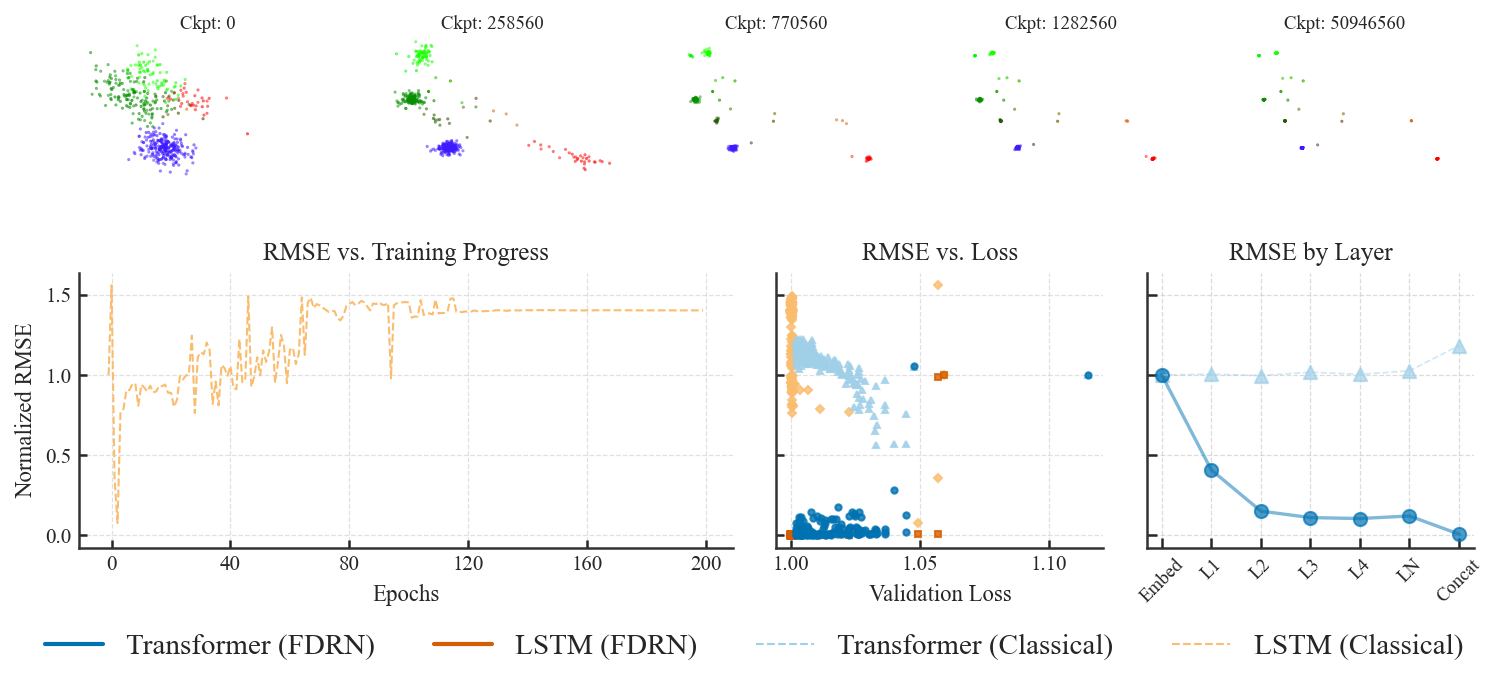


--- Combined Plotting Script Finished ---


In [87]:
# Combined Script for Multi-Panel Figure (v2: Layout & Viz Fixes)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # Import GridSpec
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, LogLocator, NullFormatter # For tick formatting
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from sklearn.decomposition import PCA
import pandas as pd # Import Pandas
from cycler import cycler


# --- Define missing factory for joblib loading (Needed if data saved with older joblib/defaultdict) ---
# If your joblib files load fine without this, you might comment it out.
# nested_dict_factory = collections.defaultdict


# --- Matplotlib Styling (Consistent style) ---
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 10 # Adjusted default size for potentially smaller subplots
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['grid.color'] = '#cccccc'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6

# Define colors/styles (Consolidated)
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
markers = ['o', 's', '^', 'D', 'v', '<']
linestyles = ['-', '--', '-.', ':']

# Style Mapping: [T_TomQA, L_TomQA, T_Class, L_Class]
run_plot_styles = {
    "Transformer (FDRN)":     {'color': colors[0], 'marker': markers[0], 'linestyle': linestyles[0], 'lw': 2.0},
    "LSTM (FDRN)":            {'color': colors[1], 'marker': markers[1], 'linestyle': linestyles[0], 'lw': 2.0},
    "Transformer (Classical)": {'color': '#A0CFE8', 'marker': markers[2], 'linestyle': linestyles[1], 'lw': 1.0},
    "LSTM (Classical)":        {'color': '#FABD6F', 'marker': markers[3], 'linestyle': linestyles[1], 'lw': 1.0},
}


# --- Helper Functions (Consolidated & Deduped) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights # Linear
    # Clip and normalize alpha values
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5 # Avoid division by zero if all values are same
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1) # Final clip and NaN handling
    return min_alpha + (1.0 - min_alpha) * normalized

def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict | None:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: GT file not found: {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        # print(f"Loaded GT data: {ground_truth_filepath}") # Less verbose
        if not isinstance(ground_truth_data, dict):
            print(f"Warning: Loaded GT data is not a dictionary ({type(ground_truth_data)}).")
            return None
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys 'beliefs' or 'probs'.")
        # Ensure beliefs and probs are numpy arrays
        if 'beliefs' in ground_truth_data:
            try: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
            except Exception as e: print(f"Warning: Could not convert GT beliefs to array: {e}"); ground_truth_data['beliefs'] = None
        if 'probs' in ground_truth_data:
            try: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
            except Exception as e: print(f"Warning: Could not convert GT probs to array: {e}"); ground_truth_data['probs'] = None
        # Check if conversion failed or keys were missing
        if ground_truth_data.get('beliefs') is None or ground_truth_data.get('probs') is None:
             print("Error: GT beliefs or probs are missing or failed conversion.")
             return None
        return ground_truth_data
    except AttributeError as e:
         # Simplified error handling for missing factory
         if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {ground_truth_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
         else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading GT file {ground_truth_filepath}: {e}"); return None

def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """
    Loads the data dictionary for a single, specific checkpoint file.
    Performs basic validation and ensures relevant arrays are numpy arrays.
    Used primarily for loading data for the visualization panels AFTER checkpoints are selected.
    """
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath):
        # print(f"Debug: Checkpoint file not found: {predictions_filepath}"); # Debug print
        return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # Basic validation and conversion
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                    # Ensure arrays are numpy arrays
                    for key, value in data.items():
                        if isinstance(value, list):
                            try: data[key] = np.array(value)
                            except Exception: pass # Ignore if conversion fails
                    # Ensure 'predicted_beliefs' is numpy array if present
                    if 'predicted_beliefs' in data and not isinstance(data['predicted_beliefs'], np.ndarray):
                        try: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
                        except Exception: data['predicted_beliefs'] = None # Set to None if conversion fails
        return single_ckpt_data
    except AttributeError as e:
         if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {predictions_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
         else: print(f"AttributeError loading {predictions_filepath}: {e}")
         return None
    except Exception as e: print(f"Error loading checkpoint file {predictions_filepath}: {e}"); return None

def _get_plotting_params(experiment_name: str) -> dict:
    """Returns plotting parameters based on experiment type."""
    params = {
        'point_size': {'truth': 0.15, 'pred': 1.0},
        'min_alpha': 0.5,
        'transformation': 'cbrt', # 'log', 'sqrt', 'cbrt', or 'linear'
        'use_pca': False,
        'project_to_simplex': False, # Only works if not using PCA and dims >= 3
        'inds_to_plot': [1, 2], # *** REVERTED to [1, 2] as per original script ***
        'com': True # Placeholder if needed later
    }
    # Example: Add specific settings for Markov3 if needed
    # if "Markov3" in experiment_name:
    #     params['project_to_simplex'] = True # e.g., Maybe simplex is default for Markov3
    # print(f"Using plotting params: {params}") # Less verbose
    return params

def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates plot coordinates based on strategy. (Using robust version)"""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca

    n_samples, n_dims = beliefs_to_plot.shape
    effective_inds_to_plot = list(inds_to_plot) # Make a copy

    # Ensure indices are valid for the number of dimensions
    if n_dims <= 0: return None, None, current_pca # Cannot plot if no dimensions
    if max(effective_inds_to_plot) >= n_dims:
        original_inds = list(effective_inds_to_plot)
        effective_inds_to_plot = [0, 1] if n_dims >= 2 else [0, 0]
        print(f"Warning: inds_to_plot ({original_inds}) out of bounds for dim {n_dims}. Using {effective_inds_to_plot}.")

    if use_pca:
        if current_pca is None: # Fit PCA if not provided
            n_components = max(2, max(effective_inds_to_plot) + 1) # Need at least 2 components
            n_components = min(n_components, n_dims, n_samples) # Cannot exceed dims or samples
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    # Ensure GT beliefs used for fitting have enough samples
                    if gt_beliefs_for_pca is not None and gt_beliefs_for_pca.shape[0] >= n_components:
                        current_pca.fit(gt_beliefs_for_pca)
                        beliefs_proj = current_pca.transform(beliefs_to_plot)
                        # Adjust indices if needed after projection
                        if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                        x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                        y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                    else:
                         print(f"Warning: Not enough samples ({gt_beliefs_for_pca.shape[0] if gt_beliefs_for_pca is not None else 'None'}) in GT data to fit PCA with {n_components} components. Skipping PCA.")
                         use_pca = False; current_pca = None # Fallback
                except Exception as e: print(f"Error during PCA fitting/transform: {e}. Plotting raw dims."); use_pca = False; current_pca = None
            else: use_pca = False # Not enough dimensions/samples for PCA
        else: # Transform using existing PCA
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1] # Adjust if needed
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with existing PCA: {e}. Plotting raw dims."); use_pca = False # Fallback

    # If PCA wasn't used or failed, try simplex projection or direct indexing
    if x_plot is None:
        if project_to_simplex and n_dims >= 3:
            x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: # Default to direct indexing
            if n_dims == 1: effective_inds_to_plot = [0, 0] # Plot dim 0 vs itself if only 1D
            x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
            # Ensure y index exists
            y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 and effective_inds_to_plot[1] < n_dims else effective_inds_to_plot[0]
            y_plot = beliefs_to_plot[:, y_plot_idx]

    return x_plot, y_plot, current_pca

def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots points on axes, turns axis off."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        # Ensure color array matches points after potential filtering/errors
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}) in _plot_beliefs_on_ax. Skipping scatter.")
    # Don't add text if simply no data to plot (x_plot/y_plot are None)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    ax.set_axis_off()
    # Add error text only if coordinates existed but plotting failed (e.g., color mismatch)
    if not plotted_something and (x_plot is not None or y_plot is not None):
        ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='orange')
    # Add N/A text if coordinates were None from the start
    elif x_plot is None and y_plot is None:
        ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')


def extract_metric_vs_ckpt_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and a specific metric for a target layer.
    Uses direct joblib.load for robustness in finding the metric, similar to standalone script.
    """
    checkpoints = []
    metric_values = []
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    # Use sorted glob to process checkpoints in order
    ckpt_files = sorted(glob.glob(os.path.join(run_dir, ckpt_pattern)))
    if not ckpt_files: print(f"Warning: No files found matching: {os.path.join(run_dir, ckpt_pattern)}"); return None, None

    print(f"  (extract_metric) Found {len(ckpt_files)} files matching pattern in {run_dir}") # Debug print
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if not match: continue
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            # *** Use direct joblib.load like in the standalone script ***
            ckpt_data = joblib.load(f)

            # Check if loaded data is dict and contains the target layer and metric
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (same as before) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key in ['dist', 'r2', 'val_loss_mean', 'val_loss']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean if unknown array metric
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty arrays
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx); metric_values.append(processed_value)
                    # else: print(f"Debug: Invalid processed value for {metric_key} in {f}") # Debug
                # else: print(f"Debug: Metric '{metric_key}' or layer data dict not found in {f}") # Debug
            # else: print(f"Debug: Target layer '{target_layer}' not found or ckpt_data not dict in {f}") # Debug

        # Catch errors during loading or processing for this specific file
        except FileNotFoundError:
             print(f"Error: File not found during direct load: {f}")
        except AttributeError as e:
             if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {f}: Missing 'defaultdict' definition during load.")
             else: print(f"AttributeError loading/processing file {f}: {e}")
        except Exception as e:
            print(f"Error loading/processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints: print(f"Warning: No valid data extracted for metric '{metric_key}' in layer '{target_layer}' for {run_dir} after checking {len(ckpt_files)} files."); return None, None

    print(f"  (extract_metric) Extracted {len(checkpoints)} valid data points for {metric_key}.") # Debug print
    checkpoints = np.array(checkpoints); metric_values = np.array(metric_values)
    # Data should already be sorted due to sorted glob, but explicit sort is safer
    sort_indices = np.argsort(checkpoints)
    return checkpoints[sort_indices], metric_values[sort_indices]


def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    target_idx = min(available_indices) if first else max(available_indices)
    return str(target_idx)


def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data, processing values. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            # Skip if layer_data is not a dictionary (might be unexpected format)
            if not isinstance(layer_data, dict): continue

            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (Consistent with extract_metric_vs_ckpt_data) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key == 'val_loss_mean' or metric_key == 'val_loss': # Handle potential array loss
                                    processed_value = float(np.nanmean(metric_value))
                                # Add other array metrics if needed (e.g., dist, r2)
                                elif metric_key in ['dist', 'r2']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty array
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value

    if not layer_metrics: return None # Return None if no metrics found for any layer
    return dict(layer_metrics) # Convert back to standard dict

def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in the target layer first, then others. """
    if not isinstance(checkpoint_data, dict): return 1 # Default dimension

    # Check target layer first
    target_layer_data = checkpoint_data.get(target_layer) # Use .get for safety
    if isinstance(target_layer_data, dict):
        pred_beliefs = target_layer_data.get('predicted_beliefs')
        if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2: # Check it's array and has >= 2 dims
                return pred_beliefs.shape[-1] # Return last dimension size

    # If not found in target layer, check other layers
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict):
            pred_beliefs = data.get('predicted_beliefs')
            if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2:
               return pred_beliefs.shape[-1]

    # print(f"Warning: Could not determine belief dimension for target '{target_layer}'. Defaulting to 1.") # Less verbose
    return 1 # Default if not found anywhere

# --- Refactored Plotting Functions ---

def plot_belief_visualizations_on_axes(
    axes: list[plt.Axes],
    run_dir: str,
    is_markov3_run: bool,
    target_layer: str = "combined",
    num_panels_to_plot: int = 5,
    # Optional: Pass pre-loaded data if available to avoid reloading
    gt_data: dict | None = None,
    ckpt_indices_for_rmse: np.ndarray | None = None,
    rmse_values_for_rmse: np.ndarray | None = None,
):
    """ Plots belief progression (preds colored by GT) on the provided axes. """
    if len(axes) != num_panels_to_plot:
        print(f"Error: Number of axes ({len(axes)}) must match num_panels_to_plot ({num_panels_to_plot})")
        return None # Return None to indicate failure/no PCA

    experiment_name = "Markov3" if is_markov3_run else "QSlice"

    # --- 1. Select Checkpoints (Use provided or extract RMSE data) ---
    viz_ckpts_to_plot_str = []
    selected_indices_list = [] # Use list for final indices

    # If RMSE data isn't provided, extract it using the (now modified) extract_metric_vs_ckpt_data
    if ckpt_indices_for_rmse is None or rmse_values_for_rmse is None:
        print(f"--- Extracting RMSE data for {experiment_name} (for viz selection) ---")
        ckpt_indices_for_rmse, rmse_values_for_rmse = extract_metric_vs_ckpt_data(run_dir, is_markov3_run, target_layer, 'rmse')

    if ckpt_indices_for_rmse is None or len(ckpt_indices_for_rmse) < 1:
        print("Error: Could not extract/find any checkpoint indices. Cannot select checkpoints for visualization.")
        # Mark axes as N/A
        for ax in axes:
             ax.text(0.5, 0.5, "No Ckpts Found", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 2. Select Checkpoints using Index Percentiles ---
    rmse_ckpts = ckpt_indices_for_rmse
    selected_indices = set()
    num_ckpts = len(rmse_ckpts)

    if num_ckpts < 1:
        print("Error: No checkpoints found to select from.")
        selected_indices_list = []
    elif num_ckpts <= num_panels_to_plot:
        # If fewer checkpoints exist than panels, just use all of them
        selected_indices = set(range(num_ckpts))
        print(f"Warning: Fewer than {num_panels_to_plot} checkpoints available ({num_ckpts}). Using all available.")
    else:
        # Select based on index percentiles
        idx_initial = 0
        idx_final = num_ckpts - 1
        # Calculate percentile indices (ensure they are valid indices)
        idx_p25 = min(max(0, int(0.01 * idx_final)), idx_final)
        idx_p75 = min(max(0, int(0.02 * idx_final)), idx_final)
        idx_p90 = min(max(0, int(0.03 * idx_final)), idx_final)

        selected_indices.add(idx_initial)
        selected_indices.add(idx_p25)
        selected_indices.add(idx_p75)
        selected_indices.add(idx_p90)
        selected_indices.add(idx_final)

        # If duplicates resulted in < num_panels_to_plot points, add more (e.g., 50% point)
        if len(selected_indices) < num_panels_to_plot:
            idx_p50 = min(max(0, int(0.50 * idx_final)), idx_final)
            selected_indices.add(idx_p50)
            # Add more points systematically if still needed (e.g. 10%, 40%, etc.)
            if len(selected_indices) < num_panels_to_plot:
                 idx_p10 = min(max(0, int(0.10 * idx_final)), idx_final)
                 selected_indices.add(idx_p10)
            # Add more logic here if needed to guarantee num_panels_to_plot unique points

    # Ensure final list is sorted and contains at most num_panels_to_plot indices
    final_selected_indices = sorted(list(selected_indices))
    if len(final_selected_indices) > num_panels_to_plot: # Should only happen if fallback logic adds too many
        # Prioritize keeping ends and roughly middle percentiles
        priority_indices = {idx_initial, idx_final, final_selected_indices[len(final_selected_indices)//2]}
        remaining = sorted(list(set(final_selected_indices) - priority_indices))
        needed = num_panels_to_plot - len(priority_indices)
        if needed > 0 and remaining:
             priority_indices.update(remaining[:needed])
        final_selected_indices = sorted(list(priority_indices))[:num_panels_to_plot]

    selected_indices_list = final_selected_indices
    # Convert selected indices back to checkpoint strings
    viz_ckpts_to_plot_str = [str(rmse_ckpts[idx]) for idx in selected_indices_list]
    num_panels_actually_plotting = len(viz_ckpts_to_plot_str)
    print(f"{num_panels_actually_plotting} Checkpoints selected for visualization: {viz_ckpts_to_plot_str}")

    # --- 2. Load GT Data (Use provided or load) ---
    if gt_data is None:
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_run else 'ground_truth_data.joblib'
        print("--- Loading Ground Truth Data ---")
        gt_data = load_ground_truth(run_dir, filename=gt_filename)

    # Check GT data validity *after* loading or receiving it
    if not gt_data or not isinstance(gt_data, dict) or \
       gt_data.get('beliefs') is None or gt_data.get('probs') is None or \
       not isinstance(gt_data['beliefs'], np.ndarray) or not isinstance(gt_data['probs'], np.ndarray) or \
       gt_data['beliefs'].size == 0 or gt_data['probs'].size == 0:
        print("Error: Cannot proceed without valid ground truth data (dict with non-empty 'beliefs' and 'probs' arrays).")
        for i, ax in enumerate(axes):
             title = f"Ckpt: {viz_ckpts_to_plot_str[i]}" if i < len(viz_ckpts_to_plot_str) else "Error"
             ax.set_title(title, fontsize=9, pad=3)
             ax.text(0.5, 0.5, "GT Data Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 3. Load Prediction Data for Selected Checkpoints ---
    # *** Use the load_specific_checkpoint_data helper here for robust loading ***
    pred_data = {} # ckpt_str -> pred_beliefs
    print("--- Loading Prediction Data for Selected Checkpoints (using helper) ---")
    for ckpt_str in viz_ckpts_to_plot_str:
        ckpt_layer_data = load_specific_checkpoint_data(run_dir, is_markov3_run, ckpt_str)
        # Check structure carefully using the validated data from the helper
        if isinstance(ckpt_layer_data, dict) and target_layer in ckpt_layer_data and \
           isinstance(ckpt_layer_data[target_layer], dict) and \
           'predicted_beliefs' in ckpt_layer_data[target_layer]:
             pred_beliefs_value = ckpt_layer_data[target_layer]['predicted_beliefs']
             # Ensure it's a numpy array and not empty (helper should have done this)
             if isinstance(pred_beliefs_value, np.ndarray) and pred_beliefs_value.size > 0:
                 pred_data[ckpt_str] = pred_beliefs_value
             else:
                 # This case might indicate an issue in the helper or original data
                 print(f"Warning: 'predicted_beliefs' from helper for layer '{target_layer}' at ckpt {ckpt_str} is not a valid non-empty array ({type(pred_beliefs_value)}).")
                 pred_data[ckpt_str] = None # Mark as missing/invalid
        else:
             print(f"Warning: Could not load valid prediction data structure using helper for layer '{target_layer}' at checkpoint {ckpt_str}")
             pred_data[ckpt_str] = None # Mark as missing

    # --- 4. Calculate Coordinates and Colors (once for GT) ---
    gt_beliefs = gt_data['beliefs']
    weights = gt_data['probs']
    params = _get_plotting_params(experiment_name)
    belief_dims = gt_beliefs.shape[1] if gt_beliefs.ndim == 2 else 1
    pca_instance = None # Initialize PCA instance

    # Calculate GT coordinates (needed for color calculation and potentially PCA fitting)
    print("--- Calculating Plot Coordinates & Colors ---")
    x_gt, y_gt, pca_instance = _calculate_plot_coords(
        gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
    )

    # Calculate colors using original RGB scheme based on GT coords/dims
    colors_rgba = None
    if x_gt is not None and y_gt is not None and weights is not None:
        def normalize_dim_color(data_dim):
            # Handle potential NaNs before min/max
            valid_data = data_dim[np.isfinite(data_dim)]
            if valid_data.size == 0: return np.ones_like(data_dim) * 0.5 # All NaN or empty
            min_val, max_val = np.min(valid_data), np.max(valid_data)
            if max_val > min_val:
                 norm = (data_dim - min_val) / (max_val - min_val)
            else: # Handle case where all valid values are the same
                 norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5) # Convert any remaining NaNs to grey

        R = normalize_dim_color(x_gt)
        G = normalize_dim_color(y_gt)

        # Determine Blue channel source
        B_source = None
        if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
             plotted_inds = params['inds_to_plot']
             # Find first index not already used for R or G (ensure it's within bounds)
             available_inds = [i for i in range(belief_dims) if i not in plotted_inds[:2]]
             if available_inds:
                 third_dim_index = available_inds[0]
                 B_source = gt_beliefs[:, third_dim_index]
             else: # Fallback if only 2D available after filtering
                 B_source = np.sqrt(x_gt**2 + y_gt**2) # Use magnitude as fallback
        else: # Use magnitude if PCA, simplex, or 2D
             B_source = np.sqrt(x_gt**2 + y_gt**2)

        B = normalize_dim_color(B_source)
        alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])

        # Ensure all components are valid numpy arrays with the same shape before stacking
        num_points_expected = weights.shape[0]
        if all(isinstance(c, np.ndarray) and c.shape == (num_points_expected,) for c in [R, G, B, alpha_values]):
            colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
            print(f"Warning: Color component mismatch or error. Shapes: R={R.shape if isinstance(R,np.ndarray) else 'None'}, G={G.shape if isinstance(G,np.ndarray) else 'None'}, B={B.shape if isinstance(B,np.ndarray) else 'None'}, Alpha={alpha_values.shape if isinstance(alpha_values,np.ndarray) else 'None'}. Expected ({num_points_expected},). Using default colors.")
            colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
    else:
        print("Warning: Could not calculate GT coordinates or weights invalid. Using default colors.")
        num_points_expected = gt_beliefs.shape[0] if gt_beliefs is not None else 0
        if num_points_expected > 0:
             colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
        else:
             colors_rgba = np.empty((0,4)) # Empty array if no points

    # --- 5. Plot Each Panel (Predictions only, colored by GT) ---
    print("--- Plotting Visualization Panels ---")
    overall_min_x, overall_max_x = np.inf, -np.inf
    overall_min_y, overall_max_y = np.inf, -np.inf

    # First pass to find combined limits across all panels that have valid data
    valid_coords_found = False
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        pred_beliefs = pred_data.get(ckpt_str) # Can be None
        # Calculate prediction coordinates using the fitted PCA instance (if any)
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )
        # Update overall limits using both GT and valid Pred data for this panel
        panel_x = []; panel_y = []
        # Include GT coords only if they are valid
        if x_gt is not None and np.isfinite(x_gt).any(): panel_x.append(x_gt)
        if y_gt is not None and np.isfinite(y_gt).any(): panel_y.append(y_gt)
        # Include Pred coords only if they are valid
        if x_pred is not None and np.isfinite(x_pred).any(): panel_x.append(x_pred)
        if y_pred is not None and np.isfinite(y_pred).any(): panel_y.append(y_pred)

        if panel_x:
            full_x = np.concatenate([arr for arr in panel_x if arr is not None and arr.size > 0])
            finite_x = full_x[np.isfinite(full_x)]
            if finite_x.size > 0:
                overall_min_x = min(overall_min_x, np.min(finite_x))
                overall_max_x = max(overall_max_x, np.max(finite_x))
                valid_coords_found = True
        if panel_y:
             full_y = np.concatenate([arr for arr in panel_y if arr is not None and arr.size > 0])
             finite_y = full_y[np.isfinite(full_y)]
             if finite_y.size > 0:
                overall_min_y = min(overall_min_y, np.min(finite_y))
                overall_max_y = max(overall_max_y, np.max(finite_y))
                valid_coords_found = True

    # Set default limits if no valid coordinates were found at all
    if not valid_coords_found:
         print("Warning: No valid coordinates found across any visualization panel. Using default limits [0,1].")
         overall_min_x, overall_max_x = 0, 1
         overall_min_y, overall_max_y = 0, 1

    # Add padding to limits, handle cases where min/max are the same
    x_range = overall_max_x - overall_min_x
    y_range = overall_max_y - overall_min_y
    x_pad = x_range * 0.05 if x_range > 1e-6 else 0.05 # Add min padding if range is tiny
    y_pad = y_range * 0.05 if y_range > 1e-6 else 0.05
    final_xlim = (overall_min_x - x_pad, overall_max_x + x_pad)
    final_ylim = (overall_min_y - y_pad, overall_max_y + y_pad)


    # Second pass to plot with consistent limits
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        if i >= len(axes): break # Should not happen with initial check
        ax = axes[i]
        ax.set_title(f"Ckpt: {ckpt_str}", fontsize=9, pad=3) # Set title first

        pred_beliefs = pred_data.get(ckpt_str) # Can be None

        # Calculate prediction coordinates again
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )

        # Plot ONLY Predictions, colored by GT position, using prediction point size
        # Pass colors_rgba which should match gt_beliefs length
        _plot_beliefs_on_ax(ax, x_pred, y_pred, colors_rgba, params['point_size']['pred'])

        # Apply the calculated consistent limits
        ax.set_xlim(final_xlim)
        ax.set_ylim(final_ylim)
        # Aspect ratio is set in _plot_beliefs_on_ax

    # Handle axes for which no checkpoint was plotted (if num_available < num_panels)
    for i in range(num_panels_actually_plotting, len(axes)):
         axes[i].set_title("N/A", fontsize=9, pad=3)
         axes[i].text(0.5, 0.5, "No Ckpt Data", ha='center', va='center', transform=axes[i].transAxes, fontsize=7, color='grey')
         axes[i].set_axis_off()

    return pca_instance # Return PCA instance if it was used

def plot_rmse_over_training_on_ax(ax: plt.Axes, df: pd.DataFrame, runs_to_plot_config: list, target_layer: str):
    """
    Plots Normalized RMSE vs Checkpoint Index for multiple runs on the provided axis.
    Returns handles and labels for legend creation.
    """
    print(f"\n--- Plotting RMSE vs Training Progress ({target_layer} layer) ---")
    all_data_found = False
    min_x, max_x = float('inf'), float('-inf')
    handles = [] # Initialize list for legend handles
    labels = []  # Initialize list for legend labels

    # Filter DataFrame for the target layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer].copy()

    if layer_df.empty:
        print(f"Warning: No data found for layer '{target_layer}' in DataFrame for RMSE vs Training plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Training Progress (Tokens Seen)")
        ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE vs Training ({target_layer})")
        return None, None # Return None if no data

    print(f"Plotting {len(runs_to_plot_config)} runs...")
    for run_config in runs_to_plot_config:
        label = run_config['label']
        run_df = layer_df[layer_df['Run Label'] == label].sort_values('Checkpoint')

        if not run_df.empty and 'Normalized RMSE' in run_df.columns and run_df['Normalized RMSE'].notna().any():
            all_data_found = True
            # Drop rows where essential data for this plot is missing
            plot_df = run_df.dropna(subset=['Checkpoint', 'Normalized RMSE'])
            
            # Sort by Checkpoint for this specific run
            plot_df = plot_df.sort_values('Checkpoint')
            
            # Create a mapping of unique run labels to their respective epoch sequences
            run_labels = plot_df['Run Label'].unique()
            print(run_labels)
            for run_label in run_labels:
                # Filter for just this run label
                mask = plot_df['Run Label'] == run_label
                # For each run label, create an epoch column starting at -1 and incrementing
                # Get the indices of the rows with this run label
                indices = plot_df.index[mask]
                # Assign epoch values to those rows
                plot_df.loc[indices, 'Epoch'] = -1 + pd.Series(range(len(indices)))
            
            print(plot_df.keys())
            epochs = plot_df['Epoch']
            # print the counts for the epochs
            print(epochs.value_counts())
            norm_rmse = plot_df['Normalized RMSE']

            if len(epochs) > 0:
                min_x = min(min_x, epochs.min())
                max_x = max(max_x, epochs.max())

                style = run_plot_styles.get(label, {}) # Get style from dict
                color = style.get('color', '#000000')
                linestyle = style.get('linestyle', '-')
                linewidth = style.get('lw', 1.5)

                 # Extract dimension for legend (use the first available dimension for the run/layer)
                dimension = plot_df['Dimension'].iloc[0] if 'Dimension' in plot_df.columns and not plot_df.empty else '?'
                legend_label = f"{label}"

                # Plot the data - lines only
                line, = ax.plot(
                    epochs, norm_rmse,
                    linestyle=linestyle,
                    color=color,
                    linewidth=linewidth,
                    label=legend_label,
                    zorder=10
                )
                # Store handles/labels for potential shared legend
                handles.append(line)
                labels.append(legend_label)
        else:
             print(f"  -> No plottable data found for {label} in layer '{target_layer}'.")

    # --- Customize Plot ---
    if all_data_found:
        #ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.0, alpha=0.7, zorder=1) # Reference line
        ax.set_xlabel("Epochs", fontsize=11)
        ax.set_ylabel(f"Normalized RMSE", fontsize=11)
        ax.set_title(f"RMSE vs. Training Progress", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', length=4)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6)) # Adjust nbins as needed

        # Use scientific notation for large x-axis values if needed
        if max_x > 1e6: # Adjust threshold as needed
            ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else:
             ax.ticklabel_format(style='plain', axis='x') # Use plain numbers otherwise

        # Set reasonable y-limits, ensuring 1.0 is visible
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()

        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # *** RETURN handles and labels ***
        return handles, labels

    else:
        print(f"No data plotted for RMSE vs Training ({target_layer}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
        # *** RETURN None if nothing plotted ***
        return None, None

def plot_rmse_vs_loss_on_ax(ax: plt.Axes, df: pd.DataFrame, target_layer: str):
    """Creates the styled plot for Normalized RMSE vs Validation Loss on the provided axis."""
    print(f"\n--- Plotting RMSE vs Validation Loss ({target_layer} layer) ---")

    # Filter the DataFrame for the specified layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer].copy()

    if layer_df.empty:
        print(f"Error: No data found for layer '{target_layer}' for RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
        ax.set_title(f"RMSE vs Loss ({target_layer})")
        return
    if 'val_loss_mean' not in layer_df.columns or layer_df['val_loss_mean'].isna().all():
        print(f"Error: 'val_loss_mean' column missing or all NaN in layer '{target_layer}'. Cannot generate RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "Loss Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
        ax.set_title(f"RMSE vs Loss ({target_layer})")
        return
    if 'Normalized RMSE' not in layer_df.columns or layer_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in layer '{target_layer}'. Cannot generate RMSE vs Loss plot.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Validation Loss")
         # ax.set_ylabel("Normalized RMSE")  # Removed y-axis label
         ax.set_title(f"RMSE vs Loss ({target_layer})")
         return

    # Get unique run labels that actually have data for this layer
    run_labels = layer_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        run_df = layer_df[layer_df['Run Label'] == label].sort_values('Checkpoint') # Sort by ckpt for line
        style = run_plot_styles.get(label, {}) # Get style from dict

        # Filter out NaN values for plotting AND required columns exist
        plot_run_df = run_df.dropna(subset=['val_loss_mean', 'Normalized RMSE'])

        if not plot_run_df.empty:
            plotted_something = True
            # Plot the original data points as markers
            ax.plot(
                plot_run_df['val_loss_mean'],
                plot_run_df['Normalized RMSE'],
                label=label,
                color=style.get('color', '#000000'),
                linestyle='',
                marker=style.get('marker', '.'), # Use marker from style
                markersize=3, # Smaller markers for line plot
                linewidth=0, # Slightly thinner line
                alpha=0.8
            )

    # --- Customize Plot ---
    if plotted_something:
        ax.set_xlabel("Validation Loss", fontsize=11)
        # ax.set_ylabel(f"Norm. RMSE", fontsize=11)  # Removed y-axis label
        ax.set_title(f"RMSE vs. Loss", fontsize=12)

        # Add legend (optional, might get crowded)
        # ax.legend(title="Run Type", fontsize=7, loc='best') # Small legend if needed

        #ax.axhline(y=1.0, color='#AAAAAA', linestyle='--', linewidth=0.8, alpha=0.8, zorder=1)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', direction='in', length=4)
        # ax.tick_params(axis='both', which='minor', direction='in', length=2)
        # ax.minorticks_on()

        # Y-axis limits (consistent with RMSE vs Training)
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()


    

        ##ax.set_xticklabels(['1', '1.00025', '1.0005', '1.003', '1.006'])  # Set tick labels as strings
        


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', labelleft=False)

    else:
        print(f"No data plotted for RMSE vs Loss ({target_layer}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')

def plot_rmse_vs_layer_on_ax(ax: plt.Axes, df: pd.DataFrame, checkpoint_id: int | str, layer_order: list):
    """ Create a scatter/line plot of Normalized RMSE by Layer for a specific checkpoint on the provided axis. """
    print(f"\n--- Plotting RMSE vs Layer (Checkpoint: {checkpoint_id}) ---")

    try:
        checkpoint_id_int = int(checkpoint_id)
    except (ValueError, TypeError):
        print(f"Error: Invalid checkpoint_id '{checkpoint_id}'. Must be convertible to integer.")
        ax.text(0.5, 0.5, "Invalid Ckpt ID", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        return

    # Filter the DataFrame for the specified checkpoint
    filtered_df = df[df['Checkpoint'] == checkpoint_id_int].copy()

    if filtered_df.empty:
        print(f"Error: No data found for Checkpoint {checkpoint_id_int} for RMSE vs Layer plot.")
        ax.text(0.5, 0.5, f"No Data Ckpt {checkpoint_id_int}", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
        ax.set_xlabel("Layer Name (Mapped)")
        #ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE by Layer (Ckpt: {checkpoint_id_int})")
        return

    if 'Normalized RMSE' not in filtered_df.columns or filtered_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN for Checkpoint {checkpoint_id_int}.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Layer Name (Mapped)")
         #ax.set_ylabel("Normalized RMSE")
         ax.set_title(f"RMSE by Layer (Ckpt: {checkpoint_id_int})")
         return

    # Create a categorical type with the specified layer ordering
    # Use only layers present in the filtered data for categories to avoid errors
    present_layers = filtered_df['Layer Name (Mapped)'].unique()
    actual_layer_order = [layer for layer in layer_order if layer in present_layers]
    if not actual_layer_order:
        print(f"Warning: None of the specified layer_order items found in data for checkpoint {checkpoint_id_int}. Using alphabetical sort.")
        actual_layer_order = sorted(present_layers) # Fallback sort

    filtered_df['Layer Order'] = pd.Categorical(
        filtered_df['Layer Name (Mapped)'],
        categories=actual_layer_order,
        ordered=True
    )

    # Sort by the custom layer order, handling potential missing categories gracefully
    sorted_df = filtered_df.sort_values('Layer Order').dropna(subset=['Layer Order'])

    # Get unique run labels present in this checkpoint's data
    run_labels = sorted_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        # Ensure layer order is correct within each label's data for line plotting
        label_df = sorted_df[sorted_df['Run Label'] == label].sort_values('Layer Order').dropna(subset=['Normalized RMSE'])
        print(label_df)
        style = run_plot_styles.get(label, {}) # Get style from dict

        if not label_df.empty:
            plotted_something = True
            # Plot scatter points
            ax.scatter(
                label_df['Layer Name (Mapped)'],
                label_df['Normalized RMSE'],
                s=40, # Smaller points for less clutter
                alpha=0.7,
                marker=style.get('marker', 'o'),
                color=style.get('color', '#000000'),
                label=label
            )
            # Add lines connecting the points
            ax.plot(
                label_df['Layer Name (Mapped)'], # X is categorical layer name
                label_df['Normalized RMSE'],     # Y is the numeric RMSE
                color=style.get('color', '#000000'),
                alpha=0.5,
                linestyle=style.get('linestyle', '-'),
                linewidth=style.get('lw', 1.5) * 0.8, # Slightly thinner lines
                marker=None # Don't repeat marker in line
            )

    # --- Customize Plot ---
    if plotted_something:
        #ax.set_xlabel('Layer', fontsize=11) # Shorten label
        #ax.set_ylabel('Norm. RMSE', fontsize=11) # Abbreviate
        # Extract short checkpoint ID for title if too long
        ckpt_title_str = str(checkpoint_id_int)
        if len(ckpt_title_str) > 10: ckpt_title_str = f"{ckpt_title_str[:4]}..{ckpt_title_str[-4:]}"
        ax.set_title(f'RMSE by Layer', fontsize=12)

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)

        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='y', labelleft=False)

        # Add legend (optional)
        # ax.legend(title='Run Label', fontsize=7, loc='best')

        # Reference line
        #ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

        # Set Y limits consistent with other RMSE plots
        min_y_data = sorted_df['Normalized RMSE'].dropna().min()
        max_y_data = sorted_df['Normalized RMSE'].dropna().max()


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    else:
         print(f"No data plotted for RMSE vs Layer (Checkpoint {checkpoint_id_int}).")
         ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')


# --- Main Execution Block ---
if __name__ == "__main__":

    # --- Configuration ---
    output_base_dir = "run_predictions_cv"        # Base directory where run folders are
    output_base_dir = "run_predictions_RCOND_FINAL" 
    plot_output_dir = "combined_figure_output"  # Directory to save the final figure
    final_figure_filename = "combined_analysis_figure_v2.png" # Output filename

    # Layer configuration
    layer_name_map = { # Map internal names to plottable names
        'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
        'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
        'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
        'input': 'Embed', # Assuming RNN 'input' corresponds to Embedding
        'layer0': 'L1', 'layer1': 'L2',
        'layer2': 'L3', 'layer3': 'L4', # Assuming RNN layers map like this
        'combined': 'Concat'
    }
    # Define the desired order for the layer plot
    layer_order_for_plot = ['Embed', 'L1', 'L2', 'L3', 'L4', 'LN', 'Concat']
    target_layer_for_timeseries = 'combined' # Layer used for RMSE vs Training and RMSE vs Loss

    # Run configurations (Used for data loading and identifying lines in plots)
    runs_to_process = [
        {"label": "Transformer (FDRN)", "sweep": "20241205175736", "run_id_int": 21, "is_markov3": False},
        {"label": "LSTM (FDRN)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20241205175736", "run_id_int": 21, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": True},
    ]


    runs_to_process = [
        {"label": "Transformer (FDRN)", "sweep": "20250422023003", "run_id_int": 1, "is_markov3": False},
        {"label": "LSTM (FDRN)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20250422023003", "run_id_int": 1, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": True},
    ]


    # --- Configuration for Specific Plots ---
    # Select ONE run for the belief visualization panels (e.g., the first one)
    run_for_belief_viz = runs_to_process[0]
    num_belief_viz_panels = 5

    # Select ONE checkpoint for the RMSE vs Layer plot (e.g., the last checkpoint of the first run)
    target_run_dir_for_ckpt = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    checkpoint_id_for_layer_plot = find_checkpoint_str(target_run_dir_for_ckpt, run_for_belief_viz['is_markov3'], first=False) # Find last checkpoint
    if checkpoint_id_for_layer_plot is None:
        print("Error: Could not find last checkpoint for the layer plot. Please set manually.")
        # Fallback: Manually set a known checkpoint ID string if find_checkpoint_str fails
        #checkpoint_id_for_layer_plot = "4075724800" # Example manual ID - CHANGE IF NEEDED
        print(f"Using fallback checkpoint ID for layer plot: {checkpoint_id_for_layer_plot}")

    metrics_to_extract = ['rmse', 'val_loss_mean'] # Metrics needed for the DataFrame

    # --- 1. Data Extraction for DataFrame (Used by bottom row plots) ---
    print("\n--- STEP 1: Extracting Data for DataFrame ---")
    all_data_records = []
    initial_rmse_cache = {} # Cache initial RMSE: (run_label, layer_name) -> initial_rmse

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str) # Use helper for consistency here
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_for_timeseries) # Use target layer if possible
        if initial_layer_metrics:
            for layer_name, metrics_dict in initial_layer_metrics.items():
                 initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run using extract_metric_vs_ckpt_data (which now uses direct load)
        print(f"  Extracting metrics using extract_metric_vs_ckpt_data for {label}...")
        for metric_to_get in metrics_to_extract:
             ckpts, metric_vals = extract_metric_vs_ckpt_data(run_dir, is_mkv3, target_layer_for_timeseries, metric_to_get)
             if ckpts is not None and metric_vals is not None:
                 for i, ckpt_idx_int in enumerate(ckpts):
                     # Find existing record or create new one
                     # This part is complex as we need to merge metrics from separate calls
                     # It's better to modify extract_layer_metrics or load once and extract all needed metrics
                     # Reverting to the previous approach of loading once per checkpoint and extracting all metrics
                     pass # Placeholder - will revert the loading logic below

    # --- REVERTED Data Extraction Logic ---
    # Load each checkpoint once and extract all necessary metrics
    all_data_records = [] # Reset records
    initial_rmse_cache = {} # Reset cache

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        # Use the helper loader here for consistency and validation of the first file
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics_for_run = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_for_timeseries) # Use target layer if possible
        if initial_layer_metrics_for_run:
            for layer_name, metrics_dict in initial_layer_metrics_for_run.items():
                 initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run
        ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3 else f"checkpoint_*.joblib"
        ckpt_files = sorted(glob.glob(os.path.join(run_dir, ckpt_pattern)))
        if not ckpt_files: print(f"  Warning: No checkpoint files found for {label}."); continue

        print(f"  Processing {len(ckpt_files)} checkpoints...")
        for f in ckpt_files:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
            if not match: continue
            ckpt_idx_str = match.group(1)
            try: ckpt_idx_int = int(ckpt_idx_str)
            except ValueError: continue

            # Load the current checkpoint ONCE using the helper function
            current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, ckpt_idx_str)
            if not current_ckpt_data:
                print(f"  Warning: Failed to load checkpoint {ckpt_idx_str} for {label}. Skipping.")
                continue

            # Extract ALL required metrics (RMSE and Loss) for *all* layers from this loaded data
            current_layer_metrics = extract_layer_metrics(current_ckpt_data, metrics_to_extract)
            if not current_layer_metrics:
                # print(f"  Debug: No metrics extracted from checkpoint {ckpt_idx_str} for {label}.")
                continue

            for layer_name, metrics_dict in current_layer_metrics.items():
                current_rmse = metrics_dict.get('rmse')
                current_loss = metrics_dict.get('val_loss_mean') # Get loss for this layer/ckpt
                # Retrieve cached initial RMSE
                initial_rmse = initial_rmse_cache.get((label, layer_name), np.nan)

                # Calculate Normalized RMSE (handle division by zero or NaN)
                normalized_rmse = np.nan
                if current_rmse is not None and not np.isnan(initial_rmse):
                    if initial_rmse > 1e-9: # Avoid division by near-zero
                        normalized_rmse = current_rmse / initial_rmse
                    elif abs(current_rmse) < 1e-9: # If both are zero/tiny, normalized value is 1
                         normalized_rmse = 1.0
                    # else: initial_rmse is zero but current is not -> leave as NaN

                mapped_layer_name = layer_name_map.get(layer_name, layer_name) # Map to consistent name

                all_data_records.append({
                    'Run Label': label,
                    'Checkpoint': ckpt_idx_int,
                    'Layer Name (Original)': layer_name,
                    'Layer Name (Mapped)': mapped_layer_name,
                    'Raw RMSE': current_rmse,
                    'Initial RMSE': initial_rmse,
                    'Dimension': dimension,
                    'Normalized RMSE': normalized_rmse,
                    'val_loss_mean': current_loss # Add loss to record
                })
    # --- End of REVERTED Data Extraction ---
    # --- End of REVERTED Data Extraction ---
    print("\nDEBUG: Final state of initial_rmse_cache:")
    import pprint
    pprint.pprint(initial_rmse_cache)

    if not all_data_records:
        print("\nError: No data records were created from checkpoints. Cannot generate plots.")
        exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)
    df = df.sort_values(by=['Run Label', 'Layer Name (Mapped)', 'Checkpoint']).reset_index(drop=True)


    # --- START DATAFRAME DEBUG ---
    print("\n--- DataFrame Info ---")
    # Increase display options for info()
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        df.info(verbose=True, show_counts=True) # More detailed info

    print("\n--- DataFrame Head ---")
    print(df.head()) # See first few rows

    print("\n--- DataFrame Value Counts & NaN Check ---")
    print("Run Label Counts (Total Rows):")
    print(df['Run Label'].value_counts()) # How many rows per run?

    print("\nLayer Name (Mapped) Counts:")
    print(df['Layer Name (Mapped)'].value_counts()) # How many rows per layer?

    print("\nNaN Counts per Column (Overall):")
    print(df.isnull().sum()) # Any NaNs in key columns?

    print("\nNaN Counts for Normalized RMSE per Run Label (All Layers):")
    print(df.groupby('Run Label')['Normalized RMSE'].apply(lambda x: x.isnull().sum())) # How many NaN NormRMSE per run?

    print("\nNaN Counts for Normalized RMSE per Run Label (Concat Layer Only):")
    # Check NaNs specifically for the layer used in Plot 1 & 2
    df_concat = df[df['Layer Name (Mapped)'] == 'Concat']
    print(df_concat.groupby('Run Label')['Normalized RMSE'].apply(lambda x: x.isnull().sum()))
    print(f"(Total Concat rows: {len(df_concat)})")

    print("\nNaN Counts for val_loss_mean per Run Label (Concat Layer Only):")
    # Check NaNs for the other value needed in Plot 2
    print(df_concat.groupby('Run Label')['val_loss_mean'].apply(lambda x: x.isnull().sum()))

    # --- Check data for the specific checkpoint used in Plot 3 ---
    # Ensure checkpoint_id_for_layer_plot is defined and valid before this point
    try:
        checkpoint_id_int = int(checkpoint_id_for_layer_plot)
        print(f"\n--- Data Check for Checkpoint {checkpoint_id_int} (used in RMSE by Layer) ---")
        df_ckpt = df[df['Checkpoint'] == checkpoint_id_int].copy() # Create copy for safety
        if df_ckpt.empty:
            print("  ERROR: No data found in DataFrame for this checkpoint!")
        else:
            print("  Run Labels present at this checkpoint:")
            print(df_ckpt['Run Label'].value_counts())
            print("\n  NaN Counts for Normalized RMSE at this checkpoint per Run Label:")
            # Group by run label within this checkpoint's data
            print(df_ckpt.groupby('Run Label')['Normalized RMSE'].apply(lambda x: x.isnull().sum()))
            print(f"  (Total rows at this checkpoint: {len(df_ckpt)})")
    except (ValueError, TypeError):
        print(f"Error: checkpoint_id_for_layer_plot ('{checkpoint_id_for_layer_plot}') is not a valid integer.")

    # Optional: Save df to CSV for easier inspection outside the console
    # try:
    #     df.to_csv("debug_dataframe.csv", index=False)
    #     print("\nSaved full DataFrame to debug_dataframe.csv")
    # except Exception as e:
    #     print(f"Error saving DataFrame to CSV: {e}")
    # --- END DATAFRAME DEBUG ---

    # ... rest of your script (creating figure, calling plot functions etc.)


    print("\nDataFrame Info:")
    # Increase display options for info()
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
         df.info(verbose=True, show_counts=True) # More detailed info
    print("\nDataFrame Head:")
    print(df.head())
    print("\nChecking for NaN values in key columns:")
    print(df[['Normalized RMSE', 'val_loss_mean']].isnull().sum())


    # --- 2. Create Figure and Nested GridSpec Layout ---
    print("\n--- STEP 2: Creating Figure Layout (Nested GridSpec) ---")
    fig = plt.figure(figsize=(12, 5)) # Adjust figsize as needed, maybe taller

    # Outer GridSpec: 2 rows, 1 column. Controls overall row heights.
    gs_outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.], hspace=0.1) # Add hspace

    # Top Inner GridSpec (for visualizations): 1 row, 5 columns within outer[0]
    gs_top = gridspec.GridSpecFromSubplotSpec(1, num_belief_viz_panels, subplot_spec=gs_outer[0], wspace=0.1) # Minimal wspace

    # Bottom Inner GridSpec (for analysis plots): 1 row, 3 columns (ratio 2:1:1) within outer[1]
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[1], width_ratios=[2, 1, 1], wspace=0.1) # Use 3 columns with ratios

    # Create axes using inner GridSpecs
    ax_viz = [fig.add_subplot(gs_top[0, i]) for i in range(num_belief_viz_panels)]
    ax_train = fig.add_subplot(gs_bottom[0, 0]) # Takes first column (50% width due to width_ratios)
    ax_loss = fig.add_subplot(gs_bottom[0, 1], sharey=ax_train)   # Takes second column (25% width)
    ax_layer = fig.add_subplot(gs_bottom[0, 2], sharey=ax_train)  # Takes third column (25% width)


    # --- 3. Call Plotting Functions ---
    print("\n--- STEP 3: Populating Subplots ---")

    # Plot Belief Visualizations (Top Row)
    print(f"--- Generating Belief Visualizations for: {run_for_belief_viz['label']} ---")
    viz_run_dir = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    _ = plot_belief_visualizations_on_axes(
        axes=ax_viz,
        run_dir=viz_run_dir,
        is_markov3_run=run_for_belief_viz['is_markov3'],
        target_layer=target_layer_for_timeseries, # Use the same target layer
        num_panels_to_plot=num_belief_viz_panels,
    )

    # Plot RMSE over Training (Bottom Left)
    # *** Capture returned handles/labels ***
    train_handles, train_labels = plot_rmse_over_training_on_ax(
        ax=ax_train,
        df=df,
        runs_to_plot_config=runs_to_process,
        target_layer='Concat'
    )

    # Plot RMSE vs Loss (Bottom Middle)
    plot_rmse_vs_loss_on_ax(
        ax=ax_loss,
        df=df,
        target_layer='Concat'
    )

    # Plot RMSE vs Layer (Bottom Right)
    plot_rmse_vs_layer_on_ax(
        ax=ax_layer,
        df=df,
        checkpoint_id=checkpoint_id_for_layer_plot, # Use the determined checkpoint ID
        layer_order=layer_order_for_plot
    )

    # --- 4. Final Figure Touches ---
    print("\n--- STEP 4: Finalizing Figure ---")
    #fig.suptitle("Transformer vs LSTM Performance Analysis (TomQA & Classical Tasks)", fontsize=16, y=0.99) # Adjust y slightly

    # Adjust layout - Use tight_layout on the figure, might work better with nested grids
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space

    # Add a shared legend at the bottom
    # *** Use captured handles/labels ***
    if train_handles and train_labels:
         fig.legend(train_handles, train_labels, loc='lower center', bbox_to_anchor=(0.5, -0.075), ncol=min(4, len(train_handles)), fontsize=14)
    else:
         print("Warning: Could not retrieve handles/labels for shared legend.")


    # --- 5. Save and Show ---
    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, final_figure_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nCombined figure saved to: {full_output_path}")

    plt.show()

    print("\n--- Combined Plotting Script Finished ---")




--- STEP 1: Extracting Data for DataFrame ---

Processing Run for DF: Transformer (FDRN) (Dir: run_predictions_RCOND_FINAL/20250422023003_1)
  Processing 201 checkpoints...

Processing Run for DF: LSTM (FDRN) (Dir: run_predictions_RCOND_FINAL/20241121152808_53)
  Processing 201 checkpoints...

Processing Run for DF: Transformer (Classical) (Dir: run_predictions_RCOND_FINAL/20250422023003_1)
  Processing 201 checkpoints...

Processing Run for DF: LSTM (Classical) (Dir: run_predictions_RCOND_FINAL/20241121152808_53)
  Processing 201 checkpoints...

--- Creating DataFrame ---
Added 'Epoch' column based on checkpoint rank per Run/Layer.

--- DataFrame Info (Post Epoch Calc) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run Label              5226 non-null   object 
 1   Checkpoint             5226 non-null   int64  
 

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_66809/1707852139.py:1163: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Epoch'].transform(max) == df['Epoch']



--- STEP 3: Populating Subplots ---
--- Generating Belief Visualizations for: Transformer (FDRN) ---
--- Extracting RMSE data for QSlice (for viz selection) ---
5 Checkpoints selected for visualization: ['0', '12546560', '25346560', '38146560', '50946560']
--- Loading Ground Truth Data ---
--- Loading Prediction Data for Selected Checkpoints (using helper) ---
--- Calculating Plot Coordinates & Colors ---
--- Plotting Visualization Panels ---

--- Plotting RMSE vs Training Progress (Concat layer) ---
Plotting 4 runs...
  DEBUG PLOT 1: Plotting Transformer (FDRN). X(Epoch) range: 0 to 200, Y range: 0.004 to 1.056
  DEBUG PLOT 1: Plotting LSTM (FDRN). X(Epoch) range: 0 to 200, Y range: 0.001 to 1.000
  DEBUG PLOT 1: Plotting Transformer (Classical). X(Epoch) range: 0 to 200, Y range: 0.566 to 1.226
  DEBUG PLOT 1: Plotting LSTM (Classical). X(Epoch) range: 0 to 200, Y range: 0.077 to 1.559

--- Plotting RMSE vs Validation Loss (Concat layer) ---
Plotting 4 runs...
  DEBUG PLOT 2: Plotti

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_66809/1707852139.py:1240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space



Combined figure saved to: combined_figure_output/combined_analysis_figure_v3_epoch.png


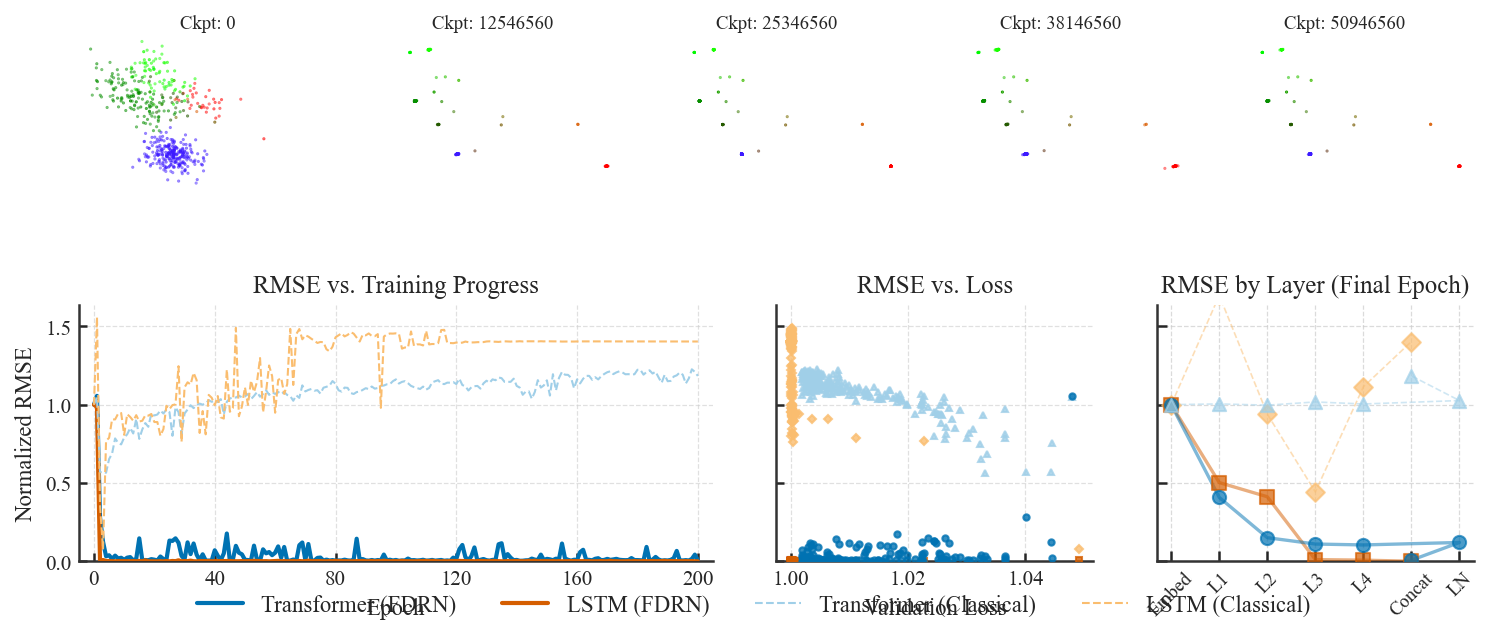


--- Combined Plotting Script Finished ---


In [89]:
# Combined Script for Multi-Panel Figure (v3: Epoch Handling & Final State Plot)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # Import GridSpec
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, LogLocator, NullFormatter # For tick formatting
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from sklearn.decomposition import PCA
import pandas as pd # Import Pandas
from cycler import cycler


# --- Define missing factory for joblib loading (Needed if data saved with older joblib/defaultdict) ---
# If your joblib files load fine without this, you might comment it out.
# nested_dict_factory = collections.defaultdict


# --- Matplotlib Styling (Consistent style) ---
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 10 # Adjusted default size for potentially smaller subplots
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['grid.color'] = '#cccccc'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6

# Define colors/styles (Consolidated)
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
markers = ['o', 's', '^', 'D', 'v', '<']
linestyles = ['-', '--', '-.', ':']

# Style Mapping: [T_FDRN, L_FDRN, T_Class, L_Class] - Updated names for clarity
run_plot_styles = {
    "Transformer (FDRN)":    {'color': colors[0], 'marker': markers[0], 'linestyle': linestyles[0], 'lw': 2.0},
    "LSTM (FDRN)":           {'color': colors[1], 'marker': markers[1], 'linestyle': linestyles[0], 'lw': 2.0},
    "Transformer (Classical)": {'color': '#A0CFE8', 'marker': markers[2], 'linestyle': linestyles[1], 'lw': 1.0}, # Lighter blue
    "LSTM (Classical)":      {'color': '#FABD6F', 'marker': markers[3], 'linestyle': linestyles[1], 'lw': 1.0}, # Lighter orange
}


# --- Helper Functions (Consolidated & Deduped) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights # Linear
    # Clip and normalize alpha values
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5 # Avoid division by zero if all values are same
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1) # Final clip and NaN handling
    return min_alpha + (1.0 - min_alpha) * normalized

def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict | None:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: GT file not found: {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        # print(f"Loaded GT data: {ground_truth_filepath}") # Less verbose
        if not isinstance(ground_truth_data, dict):
            print(f"Warning: Loaded GT data is not a dictionary ({type(ground_truth_data)}).")
            return None
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys 'beliefs' or 'probs'.")
        # Ensure beliefs and probs are numpy arrays
        if 'beliefs' in ground_truth_data:
            try: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
            except Exception as e: print(f"Warning: Could not convert GT beliefs to array: {e}"); ground_truth_data['beliefs'] = None
        if 'probs' in ground_truth_data:
            try: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
            except Exception as e: print(f"Warning: Could not convert GT probs to array: {e}"); ground_truth_data['probs'] = None
        # Check if conversion failed or keys were missing
        if ground_truth_data.get('beliefs') is None or ground_truth_data.get('probs') is None:
             print("Error: GT beliefs or probs are missing or failed conversion.")
             return None
        return ground_truth_data
    except AttributeError as e:
        # Simplified error handling for missing factory
        if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {ground_truth_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
        else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
        return None
    except Exception as e: print(f"Error loading GT file {ground_truth_filepath}: {e}"); return None

def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """
    Loads the data dictionary for a single, specific checkpoint file.
    Performs basic validation and ensures relevant arrays are numpy arrays.
    Used primarily for loading data for the visualization panels AFTER checkpoints are selected.
    """
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath):
        # print(f"Debug: Checkpoint file not found: {predictions_filepath}"); # Debug print
        return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # Basic validation and conversion
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                    # Ensure arrays are numpy arrays
                    for key, value in data.items():
                        if isinstance(value, list):
                            try: data[key] = np.array(value)
                            except Exception: pass # Ignore if conversion fails
                    # Ensure 'predicted_beliefs' is numpy array if present
                    if 'predicted_beliefs' in data and not isinstance(data['predicted_beliefs'], np.ndarray):
                        try: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
                        except Exception: data['predicted_beliefs'] = None # Set to None if conversion fails
        return single_ckpt_data
    except AttributeError as e:
        if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {predictions_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
        else: print(f"AttributeError loading {predictions_filepath}: {e}")
        return None
    except Exception as e: print(f"Error loading checkpoint file {predictions_filepath}: {e}"); return None

def _get_plotting_params(experiment_name: str) -> dict:
    """Returns plotting parameters based on experiment type."""
    params = {
        'point_size': {'truth': 0.15, 'pred': 1.0},
        'min_alpha': 0.5,
        'transformation': 'cbrt', # 'log', 'sqrt', 'cbrt', or 'linear'
        'use_pca': False,
        'project_to_simplex': False, # Only works if not using PCA and dims >= 3
        'inds_to_plot': [1, 2], # *** REVERTED to [1, 2] as per original script ***
        'com': True # Placeholder if needed later
    }
    # Example: Add specific settings for Markov3 if needed
    # if "Markov3" in experiment_name:
    #     params['project_to_simplex'] = True # e.g., Maybe simplex is default for Markov3
    # print(f"Using plotting params: {params}") # Less verbose
    return params

def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates plot coordinates based on strategy. (Using robust version)"""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca

    n_samples, n_dims = beliefs_to_plot.shape
    effective_inds_to_plot = list(inds_to_plot) # Make a copy

    # Ensure indices are valid for the number of dimensions
    if n_dims <= 0: return None, None, current_pca # Cannot plot if no dimensions
    if max(effective_inds_to_plot) >= n_dims:
        original_inds = list(effective_inds_to_plot)
        effective_inds_to_plot = [0, 1] if n_dims >= 2 else [0, 0]
        print(f"Warning: inds_to_plot ({original_inds}) out of bounds for dim {n_dims}. Using {effective_inds_to_plot}.")

    if use_pca:
        if current_pca is None: # Fit PCA if not provided
            n_components = max(2, max(effective_inds_to_plot) + 1) # Need at least 2 components
            n_components = min(n_components, n_dims, n_samples) # Cannot exceed dims or samples
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    # Ensure GT beliefs used for fitting have enough samples
                    if gt_beliefs_for_pca is not None and gt_beliefs_for_pca.shape[0] >= n_components:
                        current_pca.fit(gt_beliefs_for_pca)
                        beliefs_proj = current_pca.transform(beliefs_to_plot)
                        # Adjust indices if needed after projection
                        if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                        x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                        y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                    else:
                        print(f"Warning: Not enough samples ({gt_beliefs_for_pca.shape[0] if gt_beliefs_for_pca is not None else 'None'}) in GT data to fit PCA with {n_components} components. Skipping PCA.")
                        use_pca = False; current_pca = None # Fallback
                except Exception as e: print(f"Error during PCA fitting/transform: {e}. Plotting raw dims."); use_pca = False; current_pca = None
            else: use_pca = False # Not enough dimensions/samples for PCA
        else: # Transform using existing PCA
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1] # Adjust if needed
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with existing PCA: {e}. Plotting raw dims."); use_pca = False # Fallback

    # If PCA wasn't used or failed, try simplex projection or direct indexing
    if x_plot is None:
        if project_to_simplex and n_dims >= 3:
            x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: # Default to direct indexing
            if n_dims == 1: effective_inds_to_plot = [0, 0] # Plot dim 0 vs itself if only 1D
            x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
            # Ensure y index exists
            y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 and effective_inds_to_plot[1] < n_dims else effective_inds_to_plot[0]
            y_plot = beliefs_to_plot[:, y_plot_idx]

    return x_plot, y_plot, current_pca

def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots points on axes, turns axis off."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        # Ensure color array matches points after potential filtering/errors
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}) in _plot_beliefs_on_ax. Skipping scatter.")
    # Don't add text if simply no data to plot (x_plot/y_plot are None)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    ax.set_axis_off()
    # Add error text only if coordinates existed but plotting failed (e.g., color mismatch)
    if not plotted_something and (x_plot is not None or y_plot is not None):
        ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='orange')
    # Add N/A text if coordinates were None from the start
    elif x_plot is None and y_plot is None:
        ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')


def extract_metric_vs_ckpt_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and a specific metric for a target layer.
    Uses direct joblib.load for robustness in finding the metric, similar to standalone script.
    """
    checkpoints = []
    metric_values = []
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    # Use sorted glob to process checkpoints in order
    # Sort by the integer value extracted from the filename for robustness
    ckpt_files_unsorted = glob.glob(os.path.join(run_dir, ckpt_pattern))
    ckpt_files_with_indices = []
    for f in ckpt_files_unsorted:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try:
                ckpt_idx = int(match.group(1))
                ckpt_files_with_indices.append((ckpt_idx, f))
            except ValueError:
                pass # Ignore files where number extraction fails

    # Sort based on the extracted integer index
    ckpt_files_sorted = [f for idx, f in sorted(ckpt_files_with_indices)]

    if not ckpt_files_sorted: print(f"Warning: No valid files found matching: {os.path.join(run_dir, ckpt_pattern)}"); return None, None

    # print(f"  (extract_metric) Found {len(ckpt_files_sorted)} files matching pattern in {run_dir}") # Less verbose

    for f in ckpt_files_sorted: # Iterate through sorted files
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f)) # Re-extract index for the record
        if not match: continue # Should not happen due to pre-filtering
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            ckpt_data = joblib.load(f)

            # Check if loaded data is dict and contains the target layer and metric
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (same as before) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key in ['dist', 'r2', 'val_loss_mean', 'val_loss']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean if unknown array metric
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty arrays
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx); metric_values.append(processed_value)
                    # else: print(f"Debug: Invalid processed value for {metric_key} in {f}") # Debug
                # else: print(f"Debug: Metric '{metric_key}' or layer data dict not found in {f}") # Debug
            # else: print(f"Debug: Target layer '{target_layer}' not found or ckpt_data not dict in {f}") # Debug

        # Catch errors during loading or processing for this specific file
        except FileNotFoundError:
             print(f"Error: File not found during direct load: {f}")
        except AttributeError as e:
             if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {f}: Missing 'defaultdict' definition during load.")
             else: print(f"AttributeError loading/processing file {f}: {e}")
        except Exception as e:
            print(f"Error loading/processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints: print(f"Warning: No valid data extracted for metric '{metric_key}' in layer '{target_layer}' for {run_dir} after checking {len(ckpt_files_sorted)} files."); return None, None

    # print(f"  (extract_metric) Extracted {len(checkpoints)} valid data points for {metric_key}.") # Less verbose
    checkpoints = np.array(checkpoints); metric_values = np.array(metric_values)
    # Data should already be sorted due to sorting ckpt_files_sorted, but return as arrays
    return checkpoints, metric_values


def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    target_idx = min(available_indices) if first else max(available_indices)
    return str(target_idx)


def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data, processing values. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            # Skip if layer_data is not a dictionary (might be unexpected format)
            if not isinstance(layer_data, dict): continue

            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (Consistent with extract_metric_vs_ckpt_data) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key == 'val_loss_mean' or metric_key == 'val_loss': # Handle potential array loss
                                    processed_value = float(np.nanmean(metric_value))
                                # Add other array metrics if needed (e.g., dist, r2)
                                elif metric_key in ['dist', 'r2']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty array
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value

    if not layer_metrics: return None # Return None if no metrics found for any layer
    return dict(layer_metrics) # Convert back to standard dict

def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in the target layer first, then others. """
    if not isinstance(checkpoint_data, dict): return 1 # Default dimension

    # Check target layer first
    target_layer_data = checkpoint_data.get(target_layer) # Use .get for safety
    if isinstance(target_layer_data, dict):
        pred_beliefs = target_layer_data.get('predicted_beliefs')
        if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2: # Check it's array and has >= 2 dims
               return pred_beliefs.shape[-1] # Return last dimension size

    # If not found in target layer, check other layers
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict):
            pred_beliefs = data.get('predicted_beliefs')
            if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2:
               return pred_beliefs.shape[-1]

    # print(f"Warning: Could not determine belief dimension for target '{target_layer}'. Defaulting to 1.") # Less verbose
    return 1 # Default if not found anywhere

# --- Refactored Plotting Functions ---

def plot_belief_visualizations_on_axes(
    axes: list[plt.Axes],
    run_dir: str,
    is_markov3_run: bool,
    target_layer: str = "combined", # This is the ORIGINAL layer name
    num_panels_to_plot: int = 5,
    # Optional: Pass pre-loaded data if available to avoid reloading
    gt_data: dict | None = None,
    ckpt_indices_for_rmse: np.ndarray | None = None,
    rmse_values_for_rmse: np.ndarray | None = None,
):
    """ Plots belief progression (preds colored by GT) on the provided axes. """
    if len(axes) != num_panels_to_plot:
        print(f"Error: Number of axes ({len(axes)}) must match num_panels_to_plot ({num_panels_to_plot})")
        return None # Return None to indicate failure/no PCA

    experiment_name = "Markov3" if is_markov3_run else "QSlice"

    # --- 1. Select Checkpoints (Use provided or extract RMSE data) ---
    viz_ckpts_to_plot_str = []
    selected_indices_list = [] # Use list for final indices

    # If RMSE data isn't provided, extract it using the (now modified) extract_metric_vs_ckpt_data
    if ckpt_indices_for_rmse is None or rmse_values_for_rmse is None:
        print(f"--- Extracting RMSE data for {experiment_name} (for viz selection) ---")
        # Use the ORIGINAL layer name for extraction
        ckpt_indices_for_rmse, rmse_values_for_rmse = extract_metric_vs_ckpt_data(run_dir, is_markov3_run, target_layer, 'rmse')

    if ckpt_indices_for_rmse is None or len(ckpt_indices_for_rmse) < 1:
        print("Error: Could not extract/find any checkpoint indices. Cannot select checkpoints for visualization.")
        # Mark axes as N/A
        for ax in axes:
             ax.text(0.5, 0.5, "No Ckpts Found", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 2. Select Checkpoints using Index Percentiles ---
    rmse_ckpts = ckpt_indices_for_rmse
    selected_indices = set()
    num_ckpts = len(rmse_ckpts)

    if num_ckpts < 1:
        print("Error: No checkpoints found to select from.")
        selected_indices_list = []
    elif num_ckpts <= num_panels_to_plot:
        # If fewer checkpoints exist than panels, just use all of them
        selected_indices = set(range(num_ckpts))
        print(f"Warning: Fewer than {num_panels_to_plot} checkpoints available ({num_ckpts}). Using all available.")
    else:
        # Select based on index percentiles
        idx_initial = 0
        idx_final = num_ckpts - 1
        # Calculate percentile indices (ensure they are valid indices)
        # Use linspace for more even distribution if needed
        percentiles_to_get = np.linspace(0, 1, num_panels_to_plot)
        selected_indices = set(min(max(0, int(p * idx_final)), idx_final) for p in percentiles_to_get)

        # Ensure first and last are included
        selected_indices.add(idx_initial)
        selected_indices.add(idx_final)

        # If duplicates resulted in fewer points, add intermediate points
        while len(selected_indices) < num_panels_to_plot and len(selected_indices) < num_ckpts:
             # Add points roughly in the middle of existing gaps
             sorted_inds = sorted(list(selected_indices))
             max_gap = 0
             add_idx = -1
             for k in range(len(sorted_inds) - 1):
                 gap = sorted_inds[k+1] - sorted_inds[k]
                 if gap > max_gap:
                     max_gap = gap
                     add_idx = sorted_inds[k] + gap // 2 # Add midpoint
             if add_idx != -1 and add_idx not in selected_indices:
                 selected_indices.add(add_idx)
             else: # Fallback if adding midpoints doesn't work (e.g., all gaps are 1)
                 break # Avoid infinite loop

    # Ensure final list is sorted and contains at most num_panels_to_plot indices
    final_selected_indices = sorted(list(selected_indices))[:num_panels_to_plot]

    selected_indices_list = final_selected_indices
    # Convert selected indices back to checkpoint strings
    viz_ckpts_to_plot_str = [str(rmse_ckpts[idx]) for idx in selected_indices_list]
    num_panels_actually_plotting = len(viz_ckpts_to_plot_str)
    print(f"{num_panels_actually_plotting} Checkpoints selected for visualization: {viz_ckpts_to_plot_str}")

    # --- 2. Load GT Data (Use provided or load) ---
    if gt_data is None:
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_run else 'ground_truth_data.joblib'
        print("--- Loading Ground Truth Data ---")
        gt_data = load_ground_truth(run_dir, filename=gt_filename)

    # Check GT data validity *after* loading or receiving it
    if not gt_data or not isinstance(gt_data, dict) or \
       gt_data.get('beliefs') is None or gt_data.get('probs') is None or \
       not isinstance(gt_data['beliefs'], np.ndarray) or not isinstance(gt_data['probs'], np.ndarray) or \
       gt_data['beliefs'].size == 0 or gt_data['probs'].size == 0:
        print("Error: Cannot proceed without valid ground truth data (dict with non-empty 'beliefs' and 'probs' arrays).")
        for i, ax in enumerate(axes):
             title = f"Ckpt: {viz_ckpts_to_plot_str[i]}" if i < len(viz_ckpts_to_plot_str) else "Error"
             ax.set_title(title, fontsize=9, pad=3)
             ax.text(0.5, 0.5, "GT Data Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 3. Load Prediction Data for Selected Checkpoints ---
    pred_data = {} # ckpt_str -> pred_beliefs
    print("--- Loading Prediction Data for Selected Checkpoints (using helper) ---")
    for ckpt_str in viz_ckpts_to_plot_str:
        ckpt_layer_data = load_specific_checkpoint_data(run_dir, is_markov3_run, ckpt_str)
        # Check structure carefully using the validated data from the helper
        # Use the ORIGINAL layer name 'target_layer' here
        if isinstance(ckpt_layer_data, dict) and target_layer in ckpt_layer_data and \
           isinstance(ckpt_layer_data[target_layer], dict) and \
           'predicted_beliefs' in ckpt_layer_data[target_layer]:
            pred_beliefs_value = ckpt_layer_data[target_layer]['predicted_beliefs']
            # Ensure it's a numpy array and not empty (helper should have done this)
            if isinstance(pred_beliefs_value, np.ndarray) and pred_beliefs_value.size > 0:
                pred_data[ckpt_str] = pred_beliefs_value
            else:
                # This case might indicate an issue in the helper or original data
                print(f"Warning: 'predicted_beliefs' from helper for layer '{target_layer}' at ckpt {ckpt_str} is not a valid non-empty array ({type(pred_beliefs_value)}).")
                pred_data[ckpt_str] = None # Mark as missing/invalid
        else:
            print(f"Warning: Could not load valid prediction data structure using helper for layer '{target_layer}' at checkpoint {ckpt_str}")
            pred_data[ckpt_str] = None # Mark as missing

    # --- 4. Calculate Coordinates and Colors (once for GT) ---
    gt_beliefs = gt_data['beliefs']
    weights = gt_data['probs']
    params = _get_plotting_params(experiment_name)
    belief_dims = gt_beliefs.shape[1] if gt_beliefs.ndim == 2 else 1
    pca_instance = None # Initialize PCA instance

    # Calculate GT coordinates (needed for color calculation and potentially PCA fitting)
    print("--- Calculating Plot Coordinates & Colors ---")
    x_gt, y_gt, pca_instance = _calculate_plot_coords(
        gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
    )

    # Calculate colors using original RGB scheme based on GT coords/dims
    colors_rgba = None
    if x_gt is not None and y_gt is not None and weights is not None:
        def normalize_dim_color(data_dim):
            # Handle potential NaNs before min/max
            valid_data = data_dim[np.isfinite(data_dim)]
            if valid_data.size == 0: return np.ones_like(data_dim) * 0.5 # All NaN or empty
            min_val, max_val = np.min(valid_data), np.max(valid_data)
            if max_val > min_val:
                 norm = (data_dim - min_val) / (max_val - min_val)
            else: # Handle case where all valid values are the same
                 norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5) # Convert any remaining NaNs to grey

        R = normalize_dim_color(x_gt)
        G = normalize_dim_color(y_gt)

        # Determine Blue channel source
        B_source = None
        if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
             plotted_inds = params['inds_to_plot']
             # Find first index not already used for R or G (ensure it's within bounds)
             available_inds = [i for i in range(belief_dims) if i not in plotted_inds[:2]]
             if available_inds:
                 third_dim_index = available_inds[0]
                 B_source = gt_beliefs[:, third_dim_index]
             else: # Fallback if only 2D available after filtering
                 B_source = np.sqrt(x_gt**2 + y_gt**2) # Use magnitude as fallback
        else: # Use magnitude if PCA, simplex, or 2D
             B_source = np.sqrt(x_gt**2 + y_gt**2)

        B = normalize_dim_color(B_source)
        alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])

        # Ensure all components are valid numpy arrays with the same shape before stacking
        num_points_expected = weights.shape[0]
        if all(isinstance(c, np.ndarray) and c.shape == (num_points_expected,) for c in [R, G, B, alpha_values]):
            colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
            print(f"Warning: Color component mismatch or error. Shapes: R={R.shape if isinstance(R,np.ndarray) else 'None'}, G={G.shape if isinstance(G,np.ndarray) else 'None'}, B={B.shape if isinstance(B,np.ndarray) else 'None'}, Alpha={alpha_values.shape if isinstance(alpha_values,np.ndarray) else 'None'}. Expected ({num_points_expected},). Using default colors.")
            colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
    else:
        print("Warning: Could not calculate GT coordinates or weights invalid. Using default colors.")
        num_points_expected = gt_beliefs.shape[0] if gt_beliefs is not None else 0
        if num_points_expected > 0:
             colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
        else:
             colors_rgba = np.empty((0,4)) # Empty array if no points

    # --- 5. Plot Each Panel (Predictions only, colored by GT) ---
    print("--- Plotting Visualization Panels ---")
    overall_min_x, overall_max_x = np.inf, -np.inf
    overall_min_y, overall_max_y = np.inf, -np.inf

    # First pass to find combined limits across all panels that have valid data
    valid_coords_found = False
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        pred_beliefs = pred_data.get(ckpt_str) # Can be None
        # Calculate prediction coordinates using the fitted PCA instance (if any)
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )
        # Update overall limits using both GT and valid Pred data for this panel
        panel_x = []; panel_y = []
        # Include GT coords only if they are valid
        if x_gt is not None and np.isfinite(x_gt).any(): panel_x.append(x_gt)
        if y_gt is not None and np.isfinite(y_gt).any(): panel_y.append(y_gt)
        # Include Pred coords only if they are valid
        if x_pred is not None and np.isfinite(x_pred).any(): panel_x.append(x_pred)
        if y_pred is not None and np.isfinite(y_pred).any(): panel_y.append(y_pred)

        if panel_x:
            full_x = np.concatenate([arr for arr in panel_x if arr is not None and arr.size > 0])
            finite_x = full_x[np.isfinite(full_x)]
            if finite_x.size > 0:
                overall_min_x = min(overall_min_x, np.min(finite_x))
                overall_max_x = max(overall_max_x, np.max(finite_x))
                valid_coords_found = True
        if panel_y:
             full_y = np.concatenate([arr for arr in panel_y if arr is not None and arr.size > 0])
             finite_y = full_y[np.isfinite(full_y)]
             if finite_y.size > 0:
                 overall_min_y = min(overall_min_y, np.min(finite_y))
                 overall_max_y = max(overall_max_y, np.max(finite_y))
                 valid_coords_found = True

    # Set default limits if no valid coordinates were found at all
    if not valid_coords_found:
         print("Warning: No valid coordinates found across any visualization panel. Using default limits [0,1].")
         overall_min_x, overall_max_x = 0, 1
         overall_min_y, overall_max_y = 0, 1

    # Add padding to limits, handle cases where min/max are the same
    x_range = overall_max_x - overall_min_x
    y_range = overall_max_y - overall_min_y
    x_pad = x_range * 0.05 if x_range > 1e-6 else 0.05 # Add min padding if range is tiny
    y_pad = y_range * 0.05 if y_range > 1e-6 else 0.05
    final_xlim = (overall_min_x - x_pad, overall_max_x + x_pad)
    final_ylim = (overall_min_y - y_pad, overall_max_y + y_pad)


    # Second pass to plot with consistent limits
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        if i >= len(axes): break # Should not happen with initial check
        ax = axes[i]
        ax.set_title(f"Ckpt: {ckpt_str}", fontsize=9, pad=3) # Set title first

        pred_beliefs = pred_data.get(ckpt_str) # Can be None

        # Calculate prediction coordinates again
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )

        # Plot ONLY Predictions, colored by GT position, using prediction point size
        # Pass colors_rgba which should match gt_beliefs length
        _plot_beliefs_on_ax(ax, x_pred, y_pred, colors_rgba, params['point_size']['pred'])

        # Apply the calculated consistent limits
        ax.set_xlim(final_xlim)
        ax.set_ylim(final_ylim)
        # Aspect ratio is set in _plot_beliefs_on_ax

    # Handle axes for which no checkpoint was plotted (if num_available < num_panels)
    for i in range(num_panels_actually_plotting, len(axes)):
         axes[i].set_title("N/A", fontsize=9, pad=3)
         axes[i].text(0.5, 0.5, "No Ckpt Data", ha='center', va='center', transform=axes[i].transAxes, fontsize=7, color='grey')
         axes[i].set_axis_off()

    return pca_instance # Return PCA instance if it was used

def plot_rmse_over_training_on_ax(ax: plt.Axes, df: pd.DataFrame, runs_to_plot_config: list, target_layer_mapped: str):
    """
    Plots Normalized RMSE vs Epoch for multiple runs on the provided axis.
    Assumes df contains an 'Epoch' column calculated based on checkpoint rank.
    Returns handles and labels for legend creation.
    """
    print(f"\n--- Plotting RMSE vs Training Progress ({target_layer_mapped} layer) ---")
    all_data_found = False
    min_x_epoch, max_x_epoch = float('inf'), float('-inf') # Track epoch range
    handles = [] # Initialize list for legend handles
    labels = []  # Initialize list for legend labels

    # Filter DataFrame for the target MAPPED layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer_mapped].copy()

    if layer_df.empty:
        print(f"Warning: No data found for layer '{target_layer_mapped}' in DataFrame for RMSE vs Training plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Epoch") # Update label
        ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE vs Training ({target_layer_mapped})")
        return None, None # Return None if no data

    if 'Epoch' not in layer_df.columns:
        print(f"Error: 'Epoch' column not found in DataFrame for layer '{target_layer_mapped}'. Cannot plot vs Epoch.")
        # Add error text or handle appropriately
        return None, None

    print(f"Plotting {len(runs_to_plot_config)} runs...")
    for run_config in runs_to_plot_config:
        label = run_config['label']
        # Filter for the specific run
        run_df = layer_df[layer_df['Run Label'] == label]

        # Ensure data exists and required columns are not all NaN
        if not run_df.empty and 'Normalized RMSE' in run_df.columns and run_df['Normalized RMSE'].notna().any():
            all_data_found = True
            # Drop rows where essential data for this plot is missing
            # Sort by Epoch for correct line plotting
            plot_df = run_df.dropna(subset=['Epoch', 'Normalized RMSE']).sort_values('Epoch')

            epochs_x = plot_df['Epoch']
            norm_rmse = plot_df['Normalized RMSE']

            if len(epochs_x) > 0:
                min_x_epoch = min(min_x_epoch, epochs_x.min()) # Update min/max based on epoch values
                max_x_epoch = max(max_x_epoch, epochs_x.max())

                style = run_plot_styles.get(label, {}) # Get style from dict
                color = style.get('color', '#000000')
                linestyle = style.get('linestyle', '-')
                linewidth = style.get('lw', 1.5)

                legend_label = f"{label}" # Use the run label directly

                # DEBUG PRINT: Confirm plotting is happening and see ranges
                print(f"  DEBUG PLOT 1: Plotting {label}. X(Epoch) range: {epochs_x.min()} to {epochs_x.max()}, Y range: {norm_rmse.min():.3f} to {norm_rmse.max():.3f}")

                # Plot the data - lines only, using EPOCH as X
                line, = ax.plot(
                    epochs_x, norm_rmse, # Use epochs_x here
                    linestyle=linestyle,
                    color=color,
                    linewidth=linewidth,
                    label=legend_label,
                    zorder=10
                )
                handles.append(line)
                labels.append(legend_label)
            else:
                 # This case means rows existed but were dropped by dropna
                 print(f"DEBUG PLOT 1: No plottable (non-NaN Epoch/NormRMSE) data found for {label} after filtering.")

        else:
             # This case means the initial run_df was empty or NormRMSE was all NaN
             print(f"DEBUG PLOT 1: Skipping {label}. run_df empty: {run_df.empty}, any non-NaN NormRMSE: {run_df['Normalized RMSE'].notna().any() if not run_df.empty else 'N/A - run_df empty'}")


    # --- Customize Plot ---
    if all_data_found:
        ax.set_xlabel("Epoch", fontsize=11) # Update label
        ax.set_ylabel(f"Normalized RMSE", fontsize=11)
        ax.set_title(f"RMSE vs. Training Progress", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', length=4)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6)) # Adjust nbins as needed

        # Set x-axis limits based on actual epoch range found
        if np.isfinite(min_x_epoch) and np.isfinite(max_x_epoch):
             x_pad = (max_x_epoch - min_x_epoch) * 0.02 # Small padding
             ax.set_xlim(left=min_x_epoch - x_pad -1, right=max_x_epoch + x_pad +1) # Ensure 0 and max are visible
        ax.ticklabel_format(style='plain', axis='x') # Use plain numbers for epochs


        # Set reasonable y-limits, ensuring 1.0 is visible
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()
        if pd.notna(min_y_data) and pd.notna(max_y_data):
             y_pad = (max_y_data - min_y_data) * 0.05 if max_y_data > min_y_data else 0.1
             # Ensure y=1 is within limits, provide some padding
             plot_min_y = max(0, min_y_data - y_pad) # Start at 0 or slightly below min
             plot_max_y = max(1.0 + y_pad, max_y_data + y_pad) # Ensure 1.0 is visible
             ax.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else:
             ax.set_ylim(bottom=0) # Default if limits invalid

        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # *** RETURN handles and labels ***
        return handles, labels

    else:
        print(f"No data plotted for RMSE vs Training ({target_layer_mapped}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
        # *** RETURN None if nothing plotted ***
        return None, None

def plot_rmse_vs_loss_on_ax(ax: plt.Axes, df: pd.DataFrame, target_layer_mapped: str):
    """Creates the styled plot for Normalized RMSE vs Validation Loss on the provided axis."""
    print(f"\n--- Plotting RMSE vs Validation Loss ({target_layer_mapped} layer) ---")

    # Filter the DataFrame for the specified MAPPED layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer_mapped].copy()

    if layer_df.empty:
        print(f"Error: No data found for layer '{target_layer_mapped}' for RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
        return
    if 'val_loss_mean' not in layer_df.columns or layer_df['val_loss_mean'].isna().all():
        print(f"Error: 'val_loss_mean' column missing or all NaN in layer '{target_layer_mapped}'. Cannot generate RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "Loss Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
        return
    if 'Normalized RMSE' not in layer_df.columns or layer_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in layer '{target_layer_mapped}'. Cannot generate RMSE vs Loss plot.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Validation Loss")
         ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
         return

    # Get unique run labels that actually have data for this layer
    run_labels = layer_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        run_df = layer_df[layer_df['Run Label'] == label] # No need to sort here
        style = run_plot_styles.get(label, {}) # Get style from dict

        # Filter out NaN values for plotting AND required columns exist
        plot_run_df = run_df.dropna(subset=['val_loss_mean', 'Normalized RMSE'])

        if not plot_run_df.empty:
            plotted_something = True
            print(f"  DEBUG PLOT 2: Plotting {label}. Points: {len(plot_run_df)}") # Debug print
            # Plot the original data points as markers
            ax.plot(
                plot_run_df['val_loss_mean'],
                plot_run_df['Normalized RMSE'],
                label=label,
                color=style.get('color', '#000000'),
                linestyle='', # No line connecting points
                marker=style.get('marker', '.'), # Use marker from style
                markersize=3, # Smaller markers for line plot
                linewidth=0,
                alpha=0.8,
                zorder=5 # Ensure markers are above grid
            )
        else:
             print(f"  DEBUG PLOT 2: Skipping {label}. No non-NaN val_loss/NormRMSE points.")


    # --- Customize Plot ---
    if plotted_something:
        ax.set_xlabel("Validation Loss", fontsize=11)
        # ax.set_ylabel(f"Norm. RMSE", fontsize=11)  # Keep Y label off due to sharey
        ax.set_title(f"RMSE vs. Loss", fontsize=12)

        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', direction='in', length=4)

        # Y-axis limits are shared with ax_train, so no need to set them here.

        # X-axis: Focus on the region where loss changes typically occur
        min_loss_data = layer_df['val_loss_mean'].dropna().min()
        max_loss_data = layer_df['val_loss_mean'].dropna().max()
        q99_loss = layer_df['val_loss_mean'].dropna().quantile(0.99) # Use 99th percentile for upper limit

        if pd.notna(min_loss_data) and pd.notna(max_loss_data):
            x_pad = (q99_loss - min_loss_data) * 0.05 if q99_loss > min_loss_data else 0.01
            ax.set_xlim(left=min_loss_data - x_pad, right=q99_loss + x_pad)
            # Consider log scale if range is large and positive
            # if min_loss_data > 0 and max_loss_data / min_loss_data > 100:
            #     ax.set_xscale('log')
            # else:
            #     ax.set_xscale('linear') # Default to linear
            ax.ticklabel_format(style='sci', axis='x', scilimits=(-2,3)) # Use scientific notation if needed

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', labelleft=False) # Keep Y ticks off

    else:
        print(f"No data plotted for RMSE vs Loss ({target_layer_mapped}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')

def plot_rmse_vs_layer_on_ax(ax: plt.Axes, df_final_epoch: pd.DataFrame, layer_order: list):
    """
    Create a scatter/line plot of Normalized RMSE by Layer using data ONLY from the final epoch.
    Accepts a DataFrame pre-filtered for the final epoch of each run.
    """
    print(f"\n--- Plotting RMSE vs Layer (Final Epoch Data) ---")

    # Input df_final_epoch should already be filtered
    if df_final_epoch.empty:
        print(f"Error: No data provided (df_final_epoch is empty) for RMSE vs Layer plot.")
        ax.text(0.5, 0.5, f"No Final Epoch Data", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
        ax.set_xlabel("Layer Name (Mapped)")
        ax.set_title(f"RMSE by Layer (Final Epoch)")
        return

    # Check required column after filtering
    if 'Normalized RMSE' not in df_final_epoch.columns or df_final_epoch['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in final epoch data.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Layer Name (Mapped)")
         ax.set_title(f"RMSE by Layer (Final Epoch)")
         return

    # Create a categorical type with the specified layer ordering
    present_layers = df_final_epoch['Layer Name (Mapped)'].unique()
    actual_layer_order = [layer for layer in layer_order if layer in present_layers]
    if not actual_layer_order:
        print(f"Warning: None of the specified layer_order items found in final epoch data. Using alphabetical sort.")
        actual_layer_order = sorted(present_layers) # Fallback sort

    df_final_epoch['Layer Order'] = pd.Categorical(
        df_final_epoch['Layer Name (Mapped)'],
        categories=actual_layer_order,
        ordered=True
    )

    # Sort by the custom layer order
    # Drop rows where Layer Order might be NaN if a layer wasn't in actual_layer_order (shouldn't happen with check above)
    sorted_df = df_final_epoch.sort_values('Layer Order').dropna(subset=['Layer Order'])

    # Get unique run labels present in this final epoch data
    run_labels = sorted_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs for final epoch...")
    for label in run_labels:
        # Ensure layer order is correct within each label's data for line plotting
        # Filter for the current run label AND drop any potential remaining NaNs in NormRMSE
        label_df = sorted_df[sorted_df['Run Label'] == label].sort_values('Layer Order').dropna(subset=['Normalized RMSE'])

        # DEBUG: Print the data being plotted for each run
        print(f"\n  DEBUG PLOT 3: Plotting final epoch data for {label}:")
        print(label_df[['Layer Name (Mapped)', 'Normalized RMSE', 'Epoch']].to_string())

        style = run_plot_styles.get(label, {}) # Get style from dict

        if not label_df.empty:
            plotted_something = True
            # Plot scatter points
            ax.scatter(
                label_df['Layer Name (Mapped)'],
                label_df['Normalized RMSE'],
                s=40, # Smaller points for less clutter
                alpha=0.7,
                marker=style.get('marker', 'o'),
                color=style.get('color', '#000000'),
                label=label, # Label points for potential hover info (though legend is shared)
                zorder=10
            )
            # Add lines connecting the points
            ax.plot(
                label_df['Layer Name (Mapped)'], # X is categorical layer name
                label_df['Normalized RMSE'],     # Y is the numeric RMSE
                color=style.get('color', '#000000'),
                alpha=0.5,
                linestyle=style.get('linestyle', '-'),
                linewidth=style.get('lw', 1.5) * 0.8, # Slightly thinner lines
                marker=None, # Don't repeat marker in line
                zorder=5 # Lines behind points
            )
        else:
            print(f"  DEBUG PLOT 3: No plottable final epoch data found for {label} after filtering/sorting.")


    # --- Customize Plot ---
    if plotted_something:
        ax.set_title(f'RMSE by Layer (Final Epoch)', fontsize=12)

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9) # Y ticks are shared, but set size

        ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
        ax.tick_params(axis='y', labelleft=False) # Keep Y ticks off

        # Set Y limits based on the range in this final epoch data
        # Y limits are shared with ax_train, so no need to set them here.

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    else:
         print(f"No data plotted for RMSE vs Layer (Final Epoch).")
         ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')


# --- Main Execution Block ---
if __name__ == "__main__":

    # --- Configuration ---
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "combined_figure_output"  # Directory to save the final figure
    final_figure_filename = "combined_analysis_figure_v3_epoch.png" # Output filename

    # Layer configuration
    layer_name_map = { # Map internal names to plottable names
        'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
        'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
        'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
        'input': 'Embed', # Assuming RNN 'input' corresponds to Embedding
        'layer0': 'L1', 'layer1': 'L2',
        'layer2': 'L3', 'layer3': 'L4', # Assuming RNN layers map like this
        'combined': 'Concat'
    }
    # Define the desired order for the layer plot
    layer_order_for_plot = ['Embed', 'L1', 'L2', 'L3', 'L4', 'LN', 'Concat']
    # Define the ORIGINAL layer name used for visualizations and metric extraction
    target_layer_original = 'combined'
    # Define the MAPPED layer name used for plotting timeseries/loss
    target_layer_mapped = layer_name_map.get(target_layer_original, target_layer_original) # Should be 'Concat'

    # Run configurations (Used for data loading and identifying lines in plots)
    runs_to_process = [
        {"label": "Transformer (FDRN)", "sweep": "20250422023003", "run_id_int": 1, "is_markov3": False},
        {"label": "LSTM (FDRN)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20250422023003", "run_id_int": 1, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 53, "is_markov3": True},
    ]

    # --- Configuration for Specific Plots ---
    # Select ONE run for the belief visualization panels (e.g., the first one)
    run_for_belief_viz = runs_to_process[0]
    num_belief_viz_panels = 5

    # Metrics needed for the DataFrame
    metrics_to_extract = ['rmse', 'val_loss_mean']

    # --- 1. Data Extraction for DataFrame (Used by bottom row plots) ---
    print("\n--- STEP 1: Extracting Data for DataFrame ---")
    all_data_records = []
    initial_rmse_cache = {} # Cache initial RMSE: (run_label, layer_name) -> initial_rmse

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics_for_run = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        # Use the ORIGINAL target layer name to get dimension if possible
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_original)
        if initial_layer_metrics_for_run:
            for layer_name, metrics_dict in initial_layer_metrics_for_run.items():
                initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run
        ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3 else f"checkpoint_*.joblib"
        # Sort checkpoint files based on the numeric value in the filename
        ckpt_files_unsorted = glob.glob(os.path.join(run_dir, ckpt_pattern))
        ckpt_files_with_indices = []
        for f_unsorted in ckpt_files_unsorted:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f_unsorted))
            if match:
                try:
                    ckpt_idx_val = int(match.group(1))
                    ckpt_files_with_indices.append((ckpt_idx_val, f_unsorted))
                except ValueError: pass
        ckpt_files_sorted = [f for idx, f in sorted(ckpt_files_with_indices)] # List of file paths, sorted by index

        if not ckpt_files_sorted: print(f"  Warning: No checkpoint files found for {label}."); continue

        print(f"  Processing {len(ckpt_files_sorted)} checkpoints...")
        for f in ckpt_files_sorted:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
            if not match: continue
            ckpt_idx_str = match.group(1)
            try: ckpt_idx_int = int(ckpt_idx_str)
            except ValueError: continue

            # Load the current checkpoint ONCE using the helper function
            current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, ckpt_idx_str)
            if not current_ckpt_data:
                print(f"  Warning: Failed to load checkpoint {ckpt_idx_str} for {label}. Skipping.")
                continue

            # Extract ALL required metrics (RMSE and Loss) for *all* layers from this loaded data
            current_layer_metrics = extract_layer_metrics(current_ckpt_data, metrics_to_extract)
            if not current_layer_metrics:
                # print(f"  Debug: No metrics extracted from checkpoint {ckpt_idx_str} for {label}.")
                continue

            for layer_name, metrics_dict in current_layer_metrics.items():
                current_rmse = metrics_dict.get('rmse')
                current_loss = metrics_dict.get('val_loss_mean') # Get loss for this layer/ckpt
                # Retrieve cached initial RMSE
                initial_rmse = initial_rmse_cache.get((label, layer_name), np.nan)

                # Calculate Normalized RMSE (handle division by zero or NaN)
                normalized_rmse = np.nan
                if current_rmse is not None and not np.isnan(initial_rmse):
                    if initial_rmse > 1e-9: # Avoid division by near-zero
                        normalized_rmse = current_rmse / initial_rmse
                    elif abs(current_rmse) < 1e-9: # If both are zero/tiny, normalized value is 1
                         normalized_rmse = 1.0
                    # else: initial_rmse is zero but current is not -> leave as NaN

                mapped_layer_name = layer_name_map.get(layer_name, layer_name) # Map to consistent name

                all_data_records.append({
                    'Run Label': label,
                    'Checkpoint': ckpt_idx_int, # Store the token count
                    'Layer Name (Original)': layer_name,
                    'Layer Name (Mapped)': mapped_layer_name,
                    'Raw RMSE': current_rmse,
                    'Initial RMSE': initial_rmse,
                    'Dimension': dimension,
                    'Normalized RMSE': normalized_rmse,
                    'val_loss_mean': current_loss # Add loss to record
                })

    # --- Create DataFrame ---
    if not all_data_records:
        print("\nError: No data records were created from checkpoints. Cannot generate plots.")
        exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)

    # --- Calculate Epoch Column ---
    # Sort first by Run, Layer, then Checkpoint to ensure correct ranking
    df = df.sort_values(by=['Run Label', 'Layer Name (Mapped)', 'Checkpoint']).reset_index(drop=True)
    # Calculate epoch based on the rank within each Run/Layer group
    # rank(method='first') ensures unique ranks even if Checkpoint values are identical
    df['Epoch'] = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Checkpoint'].rank(method='first').astype(int) - 1
    print("Added 'Epoch' column based on checkpoint rank per Run/Layer.")

    # --- START DATAFRAME DEBUG (Optional but recommended) ---
    print("\n--- DataFrame Info (Post Epoch Calc) ---")
    with pd.option_context('display.max_rows', 10, 'display.max_columns', None): # Show fewer rows for brevity
        df.info(verbose=True, show_counts=True)
    print("\n--- DataFrame Head (Post Epoch Calc) ---")
    print(df.head())
    print("\n--- Max Epoch per Run/Layer (Concat Layer) ---")
    print(df[df['Layer Name (Mapped)'] == target_layer_mapped].groupby('Run Label')['Epoch'].max())
    # --- END DATAFRAME DEBUG ---


    # --- Prepare Data for Final Epoch Plot (Plot 3) ---
    # Find the maximum epoch reached for each run label *within the target layer*
    max_epoch_per_run = df[df['Layer Name (Mapped)'] == target_layer_mapped].groupby('Run Label')['Epoch'].max()
    # Create an index to select rows matching the max epoch for each run
    idx = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Epoch'].transform(max) == df['Epoch']
    # Filter the original dataframe to get all layers for the final epoch of each run
    df_final_epoch_all_layers = df[idx].copy()
    print(f"\n--- Filtered {len(df_final_epoch_all_layers)} rows for final epoch data across all layers ---")
    print("Final epoch data counts per run:")
    print(df_final_epoch_all_layers['Run Label'].value_counts())


    # --- 2. Create Figure and Nested GridSpec Layout ---
    print("\n--- STEP 2: Creating Figure Layout (Nested GridSpec) ---")
    fig = plt.figure(figsize=(12, 5)) # Adjust figsize as needed, maybe taller
    gs_outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.], hspace=0.25) # Increased hspace slightly
    gs_top = gridspec.GridSpecFromSubplotSpec(1, num_belief_viz_panels, subplot_spec=gs_outer[0], wspace=0.1)
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[1], width_ratios=[2, 1, 1], wspace=0.15) # Increased wspace slightly

    # Create axes using inner GridSpecs
    ax_viz = [fig.add_subplot(gs_top[0, i]) for i in range(num_belief_viz_panels)]
    ax_train = fig.add_subplot(gs_bottom[0, 0])
    ax_loss = fig.add_subplot(gs_bottom[0, 1], sharey=ax_train) # Share Y axis with train plot
    ax_layer = fig.add_subplot(gs_bottom[0, 2], sharey=ax_train) # Share Y axis with train plot


    # --- 3. Call Plotting Functions ---
    print("\n--- STEP 3: Populating Subplots ---")

    # Plot Belief Visualizations (Top Row) - Uses ORIGINAL layer name
    print(f"--- Generating Belief Visualizations for: {run_for_belief_viz['label']} ---")
    viz_run_dir = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    _ = plot_belief_visualizations_on_axes(
        axes=ax_viz,
        run_dir=viz_run_dir,
        is_markov3_run=run_for_belief_viz['is_markov3'],
        target_layer=target_layer_original, # Pass ORIGINAL name
        num_panels_to_plot=num_belief_viz_panels,
    )

    # Plot RMSE over Training Epoch (Bottom Left) - Uses MAPPED layer name
    train_handles, train_labels = plot_rmse_over_training_on_ax(
        ax=ax_train,
        df=df, # Pass full dataframe with Epoch column
        runs_to_plot_config=runs_to_process,
        target_layer_mapped=target_layer_mapped # Pass MAPPED name
    )

    # Plot RMSE vs Loss (Bottom Middle) - Uses MAPPED layer name
    plot_rmse_vs_loss_on_ax(
        ax=ax_loss,
        df=df, # Pass full dataframe
        target_layer_mapped=target_layer_mapped # Pass MAPPED name
    )

    # Plot RMSE vs Layer (Bottom Right) - Uses FINAL epoch data
    plot_rmse_vs_layer_on_ax(
        ax=ax_layer,
        df_final_epoch=df_final_epoch_all_layers, # Pass pre-filtered data
        layer_order=layer_order_for_plot
    )

    # --- 4. Final Figure Touches ---
    print("\n--- STEP 4: Finalizing Figure ---")

    # Set consistent Y limits for bottom row AFTER plotting
    all_data_found = True
    if all_data_found: # Check if train plot actually plotted something
        # Get current limits from the training plot (which dictates shared limits)
        current_ymin, current_ymax = ax_train.get_ylim()
        # Optional: Add padding or set fixed limits like [0, 1.1]
        final_ymin = 0 # Start y-axis at 0
        final_ymax = max(1.05, current_ymax) # Ensure at least 1.0 is visible, add padding
        ax_train.set_ylim(bottom=final_ymin, top=final_ymax)
        print(f"Setting shared Y-limits for bottom row to: ({final_ymin:.2f}, {final_ymax:.2f})")
    else:
         # Set default limits if training plot failed
         ax_train.set_ylim(bottom=0, top=1.1)


    # Adjust layout - Use tight_layout on the figure
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space

    # Add a shared legend at the bottom
    if train_handles and train_labels:
         # Ensure legend uses the correct handles/labels from the training plot
         fig.legend(train_handles, train_labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=min(4, len(train_handles)), fontsize=11) # Adjusted size/position
    else:
         print("Warning: Could not retrieve handles/labels for shared legend.")


    # --- 5. Save and Show ---
    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, final_figure_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nCombined figure saved to: {full_output_path}")

    plt.show()

    print("\n--- Combined Plotting Script Finished ---")


--- STEP 1: Extracting Data for DataFrame ---

Processing Run for DF: Transformer (PQ) (Dir: run_predictions_RCOND_FINAL/20250421221507_0)
  Processing 201 checkpoints...

Processing Run for DF: LSTM (PQ) (Dir: run_predictions_RCOND_FINAL/20241121152808_48)
  Processing 201 checkpoints...

Processing Run for DF: Transformer (Classical) (Dir: run_predictions_RCOND_FINAL/20250421221507_0)
  Processing 201 checkpoints...

Processing Run for DF: LSTM (Classical) (Dir: run_predictions_RCOND_FINAL/20241121152808_48)
  Processing 201 checkpoints...

--- Creating DataFrame ---
Added 'Epoch' column based on checkpoint rank per Run/Layer.

--- DataFrame Info (Post Epoch Calc) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run Label              5226 non-null   object 
 1   Checkpoint             5226 non-null   int64  
 2   

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_66809/230737666.py:1163: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Epoch'].transform(max) == df['Epoch']
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_66809/230737666.py:1240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space



Combined figure saved to: combined_figure_output/combined_analysis_figure_v3_epoch.png


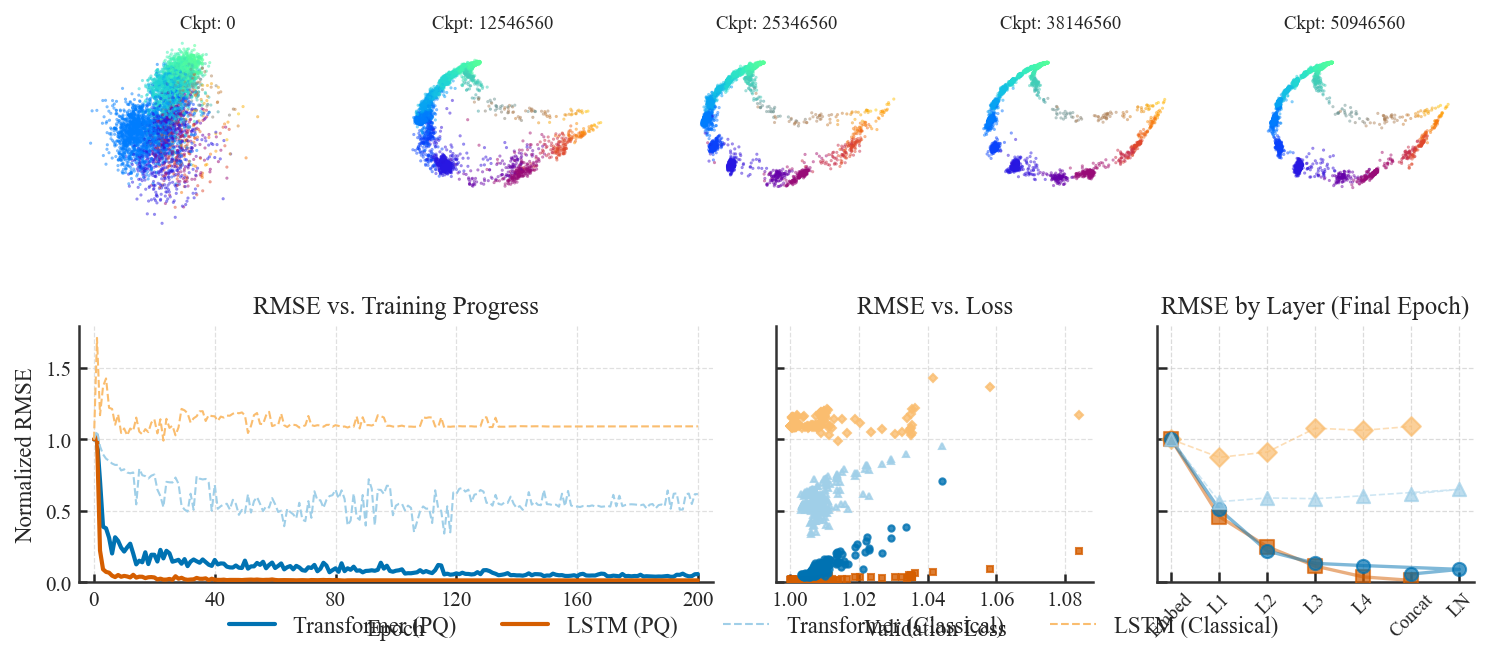


--- Combined Plotting Script Finished ---


In [91]:
# Combined Script for Multi-Panel Figure (v3: Epoch Handling & Final State Plot)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # Import GridSpec
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, LogLocator, NullFormatter # For tick formatting
import numpy as np
import os
import joblib # Make sure joblib is imported
import warnings # To suppress warnings if needed
import re # For extracting numbers from checkpoint strings
import glob # For finding checkpoint files
import collections # For defaultdict definition
from sklearn.decomposition import PCA
import pandas as pd # Import Pandas
from cycler import cycler


# --- Define missing factory for joblib loading (Needed if data saved with older joblib/defaultdict) ---
# If your joblib files load fine without this, you might comment it out.
# nested_dict_factory = collections.defaultdict


# --- Matplotlib Styling (Consistent style) ---
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'Palatino']
mpl.rcParams['font.size'] = 10 # Adjusted default size for potentially smaller subplots
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['grid.color'] = '#cccccc'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.6

# Define colors/styles (Consolidated)
# Using a colorblind-friendly palette with high contrast
colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
markers = ['o', 's', '^', 'D', 'v', '<']
linestyles = ['-', '--', '-.', ':']

# Style Mapping: [T_FDRN, L_FDRN, T_Class, L_Class] - Updated names for clarity
run_plot_styles = {
    "Transformer (PQ)":    {'color': colors[0], 'marker': markers[0], 'linestyle': linestyles[0], 'lw': 2.0},
    "LSTM (PQ)":           {'color': colors[1], 'marker': markers[1], 'linestyle': linestyles[0], 'lw': 2.0},
    "Transformer (Classical)": {'color': '#A0CFE8', 'marker': markers[2], 'linestyle': linestyles[1], 'lw': 1.0}, # Lighter blue
    "LSTM (Classical)":      {'color': '#FABD6F', 'marker': markers[3], 'linestyle': linestyles[1], 'lw': 1.0}, # Lighter orange
}


# --- Helper Functions (Consolidated & Deduped) ---

def _project_to_simplex(data):
    """Projects data points onto a 2D simplex."""
    if data.shape[1] < 3: return data[:, 0], data[:, 1] if data.shape[1] > 1 else data[:, 0]
    v1=np.array([0, 0]); v2=np.array([1, 0]); v3=np.array([0.5, np.sqrt(3)/2])
    x_proj = data[:, 1] + data[:, 2] * 0.5; y_proj = data[:, 2] * (np.sqrt(3) / 2)
    return x_proj, y_proj

def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
    """Transforms weights to alpha values for plotting."""
    epsilon = 1e-10; weights = np.asarray(weights)
    if transformation == 'log':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    elif transformation == 'sqrt':
        with warnings.catch_warnings(): warnings.simplefilter("ignore", category=RuntimeWarning); transformed = np.sqrt(weights)
        transformed = np.nan_to_num(transformed, nan=0.0)
    elif transformation == 'cbrt': transformed = np.cbrt(weights)
    else: transformed = weights # Linear
    # Clip and normalize alpha values
    if np.any(np.isnan(transformed)) or np.any(np.isinf(transformed)): transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)
    max_val, min_val = np.max(transformed), np.min(transformed)
    if max_val > min_val: normalized = (transformed - min_val) / (max_val - min_val)
    else: normalized = np.ones_like(transformed) * 0.5 # Avoid division by zero if all values are same
    normalized = np.clip(np.nan_to_num(normalized, nan=0.5), 0, 1) # Final clip and NaN handling
    return min_alpha + (1.0 - min_alpha) * normalized

def load_ground_truth(run_dir: str, filename: str = 'ground_truth_data.joblib') -> dict | None:
    """Loads the ground truth data for a specific run."""
    ground_truth_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(ground_truth_filepath): print(f"Error: GT file not found: {ground_truth_filepath}"); return None
    try:
        ground_truth_data = joblib.load(ground_truth_filepath)
        # print(f"Loaded GT data: {ground_truth_filepath}") # Less verbose
        if not isinstance(ground_truth_data, dict):
            print(f"Warning: Loaded GT data is not a dictionary ({type(ground_truth_data)}).")
            return None
        if not all(k in ground_truth_data for k in ['beliefs', 'probs']): print(f"Warning: GT data missing keys 'beliefs' or 'probs'.")
        # Ensure beliefs and probs are numpy arrays
        if 'beliefs' in ground_truth_data:
            try: ground_truth_data['beliefs'] = np.asarray(ground_truth_data['beliefs'])
            except Exception as e: print(f"Warning: Could not convert GT beliefs to array: {e}"); ground_truth_data['beliefs'] = None
        if 'probs' in ground_truth_data:
            try: ground_truth_data['probs'] = np.asarray(ground_truth_data['probs'])
            except Exception as e: print(f"Warning: Could not convert GT probs to array: {e}"); ground_truth_data['probs'] = None
        # Check if conversion failed or keys were missing
        if ground_truth_data.get('beliefs') is None or ground_truth_data.get('probs') is None:
             print("Error: GT beliefs or probs are missing or failed conversion.")
             return None
        return ground_truth_data
    except AttributeError as e:
        # Simplified error handling for missing factory
        if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {ground_truth_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
        else: print(f"AttributeError loading {ground_truth_filepath}: {e}")
        return None
    except Exception as e: print(f"Error loading GT file {ground_truth_filepath}: {e}"); return None

def load_specific_checkpoint_data(run_dir: str, is_markov3_run: bool, target_ckpt_str: str) -> dict | None:
    """
    Loads the data dictionary for a single, specific checkpoint file.
    Performs basic validation and ensures relevant arrays are numpy arrays.
    Used primarily for loading data for the visualization panels AFTER checkpoints are selected.
    """
    if target_ckpt_str is None: print("Error: target_ckpt_str cannot be None."); return None
    filename = f"markov3_checkpoint_{target_ckpt_str}.joblib" if is_markov3_run else f"checkpoint_{target_ckpt_str}.joblib"
    predictions_filepath = os.path.join(run_dir, filename)
    if not os.path.exists(predictions_filepath):
        # print(f"Debug: Checkpoint file not found: {predictions_filepath}"); # Debug print
        return None
    try:
        single_ckpt_data = joblib.load(predictions_filepath)
        # Basic validation and conversion
        if isinstance(single_ckpt_data, dict):
            for layer, data in single_ckpt_data.items():
                if isinstance(data, dict):
                    # Ensure arrays are numpy arrays
                    for key, value in data.items():
                        if isinstance(value, list):
                            try: data[key] = np.array(value)
                            except Exception: pass # Ignore if conversion fails
                    # Ensure 'predicted_beliefs' is numpy array if present
                    if 'predicted_beliefs' in data and not isinstance(data['predicted_beliefs'], np.ndarray):
                        try: data['predicted_beliefs'] = np.asarray(data['predicted_beliefs'])
                        except Exception: data['predicted_beliefs'] = None # Set to None if conversion fails
        return single_ckpt_data
    except AttributeError as e:
        if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {predictions_filepath}: Missing 'defaultdict' definition during load. Ensure it's defined if needed.")
        else: print(f"AttributeError loading {predictions_filepath}: {e}")
        return None
    except Exception as e: print(f"Error loading checkpoint file {predictions_filepath}: {e}"); return None

def _get_plotting_params(experiment_name: str) -> dict:
    """Returns plotting parameters based on experiment type."""
    params = {
        'point_size': {'truth': 0.15, 'pred': 1.0},
        'min_alpha': 0.5,
        'transformation': 'cbrt', # 'log', 'sqrt', 'cbrt', or 'linear'
        'use_pca': False,
        'project_to_simplex': False, # Only works if not using PCA and dims >= 3
        'inds_to_plot': [1, 2], # *** REVERTED to [1, 2] as per original script ***
        'com': True # Placeholder if needed later
    }
    # Example: Add specific settings for Markov3 if needed
    # if "Markov3" in experiment_name:
    #     params['project_to_simplex'] = True # e.g., Maybe simplex is default for Markov3
    # print(f"Using plotting params: {params}") # Less verbose
    return params

def _calculate_plot_coords( beliefs_to_plot: np.ndarray, gt_beliefs_for_pca: np.ndarray, use_pca: bool, project_to_simplex: bool, inds_to_plot: list, pca_instance: PCA = None ):
    """Calculates plot coordinates based on strategy. (Using robust version)"""
    x_plot, y_plot = None, None; current_pca = pca_instance
    if beliefs_to_plot is None or not isinstance(beliefs_to_plot, np.ndarray) or beliefs_to_plot.size == 0: return None, None, current_pca

    n_samples, n_dims = beliefs_to_plot.shape
    effective_inds_to_plot = list(inds_to_plot) # Make a copy

    # Ensure indices are valid for the number of dimensions
    if n_dims <= 0: return None, None, current_pca # Cannot plot if no dimensions
    if max(effective_inds_to_plot) >= n_dims:
        original_inds = list(effective_inds_to_plot)
        effective_inds_to_plot = [0, 1] if n_dims >= 2 else [0, 0]
        print(f"Warning: inds_to_plot ({original_inds}) out of bounds for dim {n_dims}. Using {effective_inds_to_plot}.")

    if use_pca:
        if current_pca is None: # Fit PCA if not provided
            n_components = max(2, max(effective_inds_to_plot) + 1) # Need at least 2 components
            n_components = min(n_components, n_dims, n_samples) # Cannot exceed dims or samples
            if n_components >= 2:
                current_pca = PCA(n_components=n_components)
                try:
                    # Ensure GT beliefs used for fitting have enough samples
                    if gt_beliefs_for_pca is not None and gt_beliefs_for_pca.shape[0] >= n_components:
                        current_pca.fit(gt_beliefs_for_pca)
                        beliefs_proj = current_pca.transform(beliefs_to_plot)
                        # Adjust indices if needed after projection
                        if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1]
                        x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                        y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
                    else:
                        print(f"Warning: Not enough samples ({gt_beliefs_for_pca.shape[0] if gt_beliefs_for_pca is not None else 'None'}) in GT data to fit PCA with {n_components} components. Skipping PCA.")
                        use_pca = False; current_pca = None # Fallback
                except Exception as e: print(f"Error during PCA fitting/transform: {e}. Plotting raw dims."); use_pca = False; current_pca = None
            else: use_pca = False # Not enough dimensions/samples for PCA
        else: # Transform using existing PCA
            try:
                n_components = current_pca.n_components_
                if max(effective_inds_to_plot) >= n_components: effective_inds_to_plot = [0, 1] # Adjust if needed
                beliefs_proj = current_pca.transform(beliefs_to_plot)
                x_plot = beliefs_proj[:, effective_inds_to_plot[0]]
                y_plot = beliefs_proj[:, effective_inds_to_plot[1]]
            except Exception as e: print(f"Error transforming with existing PCA: {e}. Plotting raw dims."); use_pca = False # Fallback

    # If PCA wasn't used or failed, try simplex projection or direct indexing
    if x_plot is None:
        if project_to_simplex and n_dims >= 3:
            x_plot, y_plot = _project_to_simplex(beliefs_to_plot)
        else: # Default to direct indexing
            if n_dims == 1: effective_inds_to_plot = [0, 0] # Plot dim 0 vs itself if only 1D
            x_plot = beliefs_to_plot[:, effective_inds_to_plot[0]]
            # Ensure y index exists
            y_plot_idx = effective_inds_to_plot[1] if len(effective_inds_to_plot) > 1 and effective_inds_to_plot[1] < n_dims else effective_inds_to_plot[0]
            y_plot = beliefs_to_plot[:, y_plot_idx]

    return x_plot, y_plot, current_pca

def _plot_beliefs_on_ax( ax: plt.Axes, x_plot: np.ndarray, y_plot: np.ndarray, colors_rgba: np.ndarray, point_size: float ):
    """Plots points on axes, turns axis off."""
    plotted_something = False
    if x_plot is not None and y_plot is not None and colors_rgba is not None and x_plot.size > 0 and y_plot.size > 0 and colors_rgba.size > 0:
        # Ensure color array matches points after potential filtering/errors
        if colors_rgba.shape[0] == x_plot.shape[0]:
            ax.scatter(x_plot, y_plot, color=colors_rgba, s=point_size, rasterized=True, marker='.')
            plotted_something = True
        else: print(f"Warning: Mismatch points ({x_plot.shape[0]}) vs colors ({colors_rgba.shape[0]}) in _plot_beliefs_on_ax. Skipping scatter.")
    # Don't add text if simply no data to plot (x_plot/y_plot are None)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
    ax.set_axis_off()
    # Add error text only if coordinates existed but plotting failed (e.g., color mismatch)
    if not plotted_something and (x_plot is not None or y_plot is not None):
        ax.text(0.5, 0.5, "Plot Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='orange')
    # Add N/A text if coordinates were None from the start
    elif x_plot is None and y_plot is None:
        ax.text(0.5, 0.5, "Data N/A", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')


def extract_metric_vs_ckpt_data(run_dir: str, is_markov3_run: bool, target_layer: str, metric_key: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    """
    Extracts checkpoint indices and a specific metric for a target layer.
    Uses direct joblib.load for robustness in finding the metric, similar to standalone script.
    """
    checkpoints = []
    metric_values = []
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    # Use sorted glob to process checkpoints in order
    # Sort by the integer value extracted from the filename for robustness
    ckpt_files_unsorted = glob.glob(os.path.join(run_dir, ckpt_pattern))
    ckpt_files_with_indices = []
    for f in ckpt_files_unsorted:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try:
                ckpt_idx = int(match.group(1))
                ckpt_files_with_indices.append((ckpt_idx, f))
            except ValueError:
                pass # Ignore files where number extraction fails

    # Sort based on the extracted integer index
    ckpt_files_sorted = [f for idx, f in sorted(ckpt_files_with_indices)]

    if not ckpt_files_sorted: print(f"Warning: No valid files found matching: {os.path.join(run_dir, ckpt_pattern)}"); return None, None

    # print(f"  (extract_metric) Found {len(ckpt_files_sorted)} files matching pattern in {run_dir}") # Less verbose

    for f in ckpt_files_sorted: # Iterate through sorted files
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f)) # Re-extract index for the record
        if not match: continue # Should not happen due to pre-filtering
        try: ckpt_idx = int(match.group(1))
        except ValueError: continue

        try:
            ckpt_data = joblib.load(f)

            # Check if loaded data is dict and contains the target layer and metric
            if isinstance(ckpt_data, dict) and target_layer in ckpt_data:
                layer_data = ckpt_data[target_layer]
                if isinstance(layer_data, dict) and metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (same as before) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key in ['dist', 'r2', 'val_loss_mean', 'val_loss']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean if unknown array metric
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty arrays
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        checkpoints.append(ckpt_idx); metric_values.append(processed_value)
                    # else: print(f"Debug: Invalid processed value for {metric_key} in {f}") # Debug
                # else: print(f"Debug: Metric '{metric_key}' or layer data dict not found in {f}") # Debug
            # else: print(f"Debug: Target layer '{target_layer}' not found or ckpt_data not dict in {f}") # Debug

        # Catch errors during loading or processing for this specific file
        except FileNotFoundError:
             print(f"Error: File not found during direct load: {f}")
        except AttributeError as e:
             if 'nested_dict_factory' in str(e) or 'defaultdict' in str(e): print(f"Error loading {f}: Missing 'defaultdict' definition during load.")
             else: print(f"AttributeError loading/processing file {f}: {e}")
        except Exception as e:
            print(f"Error loading/processing file {f} for metric '{metric_key}': {e}")

    if not checkpoints: print(f"Warning: No valid data extracted for metric '{metric_key}' in layer '{target_layer}' for {run_dir} after checking {len(ckpt_files_sorted)} files."); return None, None

    # print(f"  (extract_metric) Extracted {len(checkpoints)} valid data points for {metric_key}.") # Less verbose
    checkpoints = np.array(checkpoints); metric_values = np.array(metric_values)
    # Data should already be sorted due to sorting ckpt_files_sorted, but return as arrays
    return checkpoints, metric_values


def find_checkpoint_str(run_dir: str, is_markov3_run: bool, first: bool = False) -> str | None:
    """Finds the string representation of the highest or lowest checkpoint index available."""
    ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_markov3_run else f"checkpoint_*.joblib"
    ckpt_files = glob.glob(os.path.join(run_dir, ckpt_pattern))
    if not ckpt_files: return None
    available_indices = []
    for f in ckpt_files:
        match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
        if match:
            try: available_indices.append(int(match.group(1)))
            except ValueError: pass
    if not available_indices: return None
    target_idx = min(available_indices) if first else max(available_indices)
    return str(target_idx)


def extract_layer_metrics(checkpoint_data: dict, target_metrics: list[str]) -> dict | None:
    """ Extracts specified metrics for all layers from loaded checkpoint data, processing values. """
    if checkpoint_data is None: return None
    layer_metrics = collections.defaultdict(dict)
    if isinstance(checkpoint_data, dict):
        for layer_name, layer_data in checkpoint_data.items():
            # Skip if layer_data is not a dictionary (might be unexpected format)
            if not isinstance(layer_data, dict): continue

            for metric_key in target_metrics:
                if metric_key in layer_data:
                    metric_value = layer_data[metric_key]
                    processed_value = None
                    # --- Processing Logic (Consistent with extract_metric_vs_ckpt_data) ---
                    if isinstance(metric_value, np.ndarray):
                        if metric_value.size > 0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                if metric_key == 'rmse':
                                    processed_value = float(np.sqrt(np.nanmean(metric_value**2)))
                                elif metric_key == 'val_loss_mean' or metric_key == 'val_loss': # Handle potential array loss
                                    processed_value = float(np.nanmean(metric_value))
                                # Add other array metrics if needed (e.g., dist, r2)
                                elif metric_key in ['dist', 'r2']:
                                     processed_value = float(np.nanmean(metric_value))
                                else: # Default to mean
                                     processed_value = float(np.nanmean(metric_value))
                        # else: skip empty array
                    elif isinstance(metric_value, (int, float, np.number)): # Handle scalars
                        processed_value = float(metric_value)
                    # else: skip other types

                    if processed_value is not None and np.isfinite(processed_value):
                        layer_metrics[layer_name][metric_key] = processed_value

    if not layer_metrics: return None # Return None if no metrics found for any layer
    return dict(layer_metrics) # Convert back to standard dict

def get_belief_dimension(checkpoint_data: dict, target_layer: str = 'combined') -> int:
    """ Attempts to find the belief dimension from predicted_beliefs in the target layer first, then others. """
    if not isinstance(checkpoint_data, dict): return 1 # Default dimension

    # Check target layer first
    target_layer_data = checkpoint_data.get(target_layer) # Use .get for safety
    if isinstance(target_layer_data, dict):
        pred_beliefs = target_layer_data.get('predicted_beliefs')
        if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2: # Check it's array and has >= 2 dims
               return pred_beliefs.shape[-1] # Return last dimension size

    # If not found in target layer, check other layers
    for layer, data in checkpoint_data.items():
        if isinstance(data, dict):
            pred_beliefs = data.get('predicted_beliefs')
            if isinstance(pred_beliefs, np.ndarray) and pred_beliefs.ndim >= 2:
               return pred_beliefs.shape[-1]

    # print(f"Warning: Could not determine belief dimension for target '{target_layer}'. Defaulting to 1.") # Less verbose
    return 1 # Default if not found anywhere

# --- Refactored Plotting Functions ---

def plot_belief_visualizations_on_axes(
    axes: list[plt.Axes],
    run_dir: str,
    is_markov3_run: bool,
    target_layer: str = "combined", # This is the ORIGINAL layer name
    num_panels_to_plot: int = 5,
    # Optional: Pass pre-loaded data if available to avoid reloading
    gt_data: dict | None = None,
    ckpt_indices_for_rmse: np.ndarray | None = None,
    rmse_values_for_rmse: np.ndarray | None = None,
):
    """ Plots belief progression (preds colored by GT) on the provided axes. """
    if len(axes) != num_panels_to_plot:
        print(f"Error: Number of axes ({len(axes)}) must match num_panels_to_plot ({num_panels_to_plot})")
        return None # Return None to indicate failure/no PCA

    experiment_name = "Markov3" if is_markov3_run else "QSlice"

    # --- 1. Select Checkpoints (Use provided or extract RMSE data) ---
    viz_ckpts_to_plot_str = []
    selected_indices_list = [] # Use list for final indices

    # If RMSE data isn't provided, extract it using the (now modified) extract_metric_vs_ckpt_data
    if ckpt_indices_for_rmse is None or rmse_values_for_rmse is None:
        print(f"--- Extracting RMSE data for {experiment_name} (for viz selection) ---")
        # Use the ORIGINAL layer name for extraction
        ckpt_indices_for_rmse, rmse_values_for_rmse = extract_metric_vs_ckpt_data(run_dir, is_markov3_run, target_layer, 'rmse')

    if ckpt_indices_for_rmse is None or len(ckpt_indices_for_rmse) < 1:
        print("Error: Could not extract/find any checkpoint indices. Cannot select checkpoints for visualization.")
        # Mark axes as N/A
        for ax in axes:
             ax.text(0.5, 0.5, "No Ckpts Found", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 2. Select Checkpoints using Index Percentiles ---
    rmse_ckpts = ckpt_indices_for_rmse
    selected_indices = set()
    num_ckpts = len(rmse_ckpts)

    if num_ckpts < 1:
        print("Error: No checkpoints found to select from.")
        selected_indices_list = []
    elif num_ckpts <= num_panels_to_plot:
        # If fewer checkpoints exist than panels, just use all of them
        selected_indices = set(range(num_ckpts))
        print(f"Warning: Fewer than {num_panels_to_plot} checkpoints available ({num_ckpts}). Using all available.")
    else:
        # Select based on index percentiles
        idx_initial = 0
        idx_final = num_ckpts - 1
        # Calculate percentile indices (ensure they are valid indices)
        # Use linspace for more even distribution if needed
        percentiles_to_get = np.linspace(0, 1, num_panels_to_plot)
        selected_indices = set(min(max(0, int(p * idx_final)), idx_final) for p in percentiles_to_get)

        # Ensure first and last are included
        selected_indices.add(idx_initial)
        selected_indices.add(idx_final)

        # If duplicates resulted in fewer points, add intermediate points
        while len(selected_indices) < num_panels_to_plot and len(selected_indices) < num_ckpts:
             # Add points roughly in the middle of existing gaps
             sorted_inds = sorted(list(selected_indices))
             max_gap = 0
             add_idx = -1
             for k in range(len(sorted_inds) - 1):
                 gap = sorted_inds[k+1] - sorted_inds[k]
                 if gap > max_gap:
                     max_gap = gap
                     add_idx = sorted_inds[k] + gap // 2 # Add midpoint
             if add_idx != -1 and add_idx not in selected_indices:
                 selected_indices.add(add_idx)
             else: # Fallback if adding midpoints doesn't work (e.g., all gaps are 1)
                 break # Avoid infinite loop

    # Ensure final list is sorted and contains at most num_panels_to_plot indices
    final_selected_indices = sorted(list(selected_indices))[:num_panels_to_plot]

    selected_indices_list = final_selected_indices
    # Convert selected indices back to checkpoint strings
    viz_ckpts_to_plot_str = [str(rmse_ckpts[idx]) for idx in selected_indices_list]
    num_panels_actually_plotting = len(viz_ckpts_to_plot_str)
    print(f"{num_panels_actually_plotting} Checkpoints selected for visualization: {viz_ckpts_to_plot_str}")

    # --- 2. Load GT Data (Use provided or load) ---
    if gt_data is None:
        gt_filename = 'markov3_ground_truth_data.joblib' if is_markov3_run else 'ground_truth_data.joblib'
        print("--- Loading Ground Truth Data ---")
        gt_data = load_ground_truth(run_dir, filename=gt_filename)

    # Check GT data validity *after* loading or receiving it
    if not gt_data or not isinstance(gt_data, dict) or \
       gt_data.get('beliefs') is None or gt_data.get('probs') is None or \
       not isinstance(gt_data['beliefs'], np.ndarray) or not isinstance(gt_data['probs'], np.ndarray) or \
       gt_data['beliefs'].size == 0 or gt_data['probs'].size == 0:
        print("Error: Cannot proceed without valid ground truth data (dict with non-empty 'beliefs' and 'probs' arrays).")
        for i, ax in enumerate(axes):
             title = f"Ckpt: {viz_ckpts_to_plot_str[i]}" if i < len(viz_ckpts_to_plot_str) else "Error"
             ax.set_title(title, fontsize=9, pad=3)
             ax.text(0.5, 0.5, "GT Data Error", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
             ax.set_axis_off()
        return None

    # --- 3. Load Prediction Data for Selected Checkpoints ---
    pred_data = {} # ckpt_str -> pred_beliefs
    print("--- Loading Prediction Data for Selected Checkpoints (using helper) ---")
    for ckpt_str in viz_ckpts_to_plot_str:
        ckpt_layer_data = load_specific_checkpoint_data(run_dir, is_markov3_run, ckpt_str)
        # Check structure carefully using the validated data from the helper
        # Use the ORIGINAL layer name 'target_layer' here
        if isinstance(ckpt_layer_data, dict) and target_layer in ckpt_layer_data and \
           isinstance(ckpt_layer_data[target_layer], dict) and \
           'predicted_beliefs' in ckpt_layer_data[target_layer]:
            pred_beliefs_value = ckpt_layer_data[target_layer]['predicted_beliefs']
            # Ensure it's a numpy array and not empty (helper should have done this)
            if isinstance(pred_beliefs_value, np.ndarray) and pred_beliefs_value.size > 0:
                pred_data[ckpt_str] = pred_beliefs_value
            else:
                # This case might indicate an issue in the helper or original data
                print(f"Warning: 'predicted_beliefs' from helper for layer '{target_layer}' at ckpt {ckpt_str} is not a valid non-empty array ({type(pred_beliefs_value)}).")
                pred_data[ckpt_str] = None # Mark as missing/invalid
        else:
            print(f"Warning: Could not load valid prediction data structure using helper for layer '{target_layer}' at checkpoint {ckpt_str}")
            pred_data[ckpt_str] = None # Mark as missing

    # --- 4. Calculate Coordinates and Colors (once for GT) ---
    gt_beliefs = gt_data['beliefs']
    weights = gt_data['probs']
    params = _get_plotting_params(experiment_name)
    belief_dims = gt_beliefs.shape[1] if gt_beliefs.ndim == 2 else 1
    pca_instance = None # Initialize PCA instance

    # Calculate GT coordinates (needed for color calculation and potentially PCA fitting)
    print("--- Calculating Plot Coordinates & Colors ---")
    x_gt, y_gt, pca_instance = _calculate_plot_coords(
        gt_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
    )

    # Calculate colors using original RGB scheme based on GT coords/dims
    colors_rgba = None
    if x_gt is not None and y_gt is not None and weights is not None:
        def normalize_dim_color(data_dim):
            # Handle potential NaNs before min/max
            valid_data = data_dim[np.isfinite(data_dim)]
            if valid_data.size == 0: return np.ones_like(data_dim) * 0.5 # All NaN or empty
            min_val, max_val = np.min(valid_data), np.max(valid_data)
            if max_val > min_val:
                 norm = (data_dim - min_val) / (max_val - min_val)
            else: # Handle case where all valid values are the same
                 norm = np.ones_like(data_dim) * 0.5
            return np.nan_to_num(norm, nan=0.5) # Convert any remaining NaNs to grey

        R = normalize_dim_color(x_gt)
        G = normalize_dim_color(y_gt)

        # Determine Blue channel source
        B_source = None
        if not params['use_pca'] and not params['project_to_simplex'] and belief_dims > 2:
             plotted_inds = params['inds_to_plot']
             # Find first index not already used for R or G (ensure it's within bounds)
             available_inds = [i for i in range(belief_dims) if i not in plotted_inds[:2]]
             if available_inds:
                 third_dim_index = available_inds[0]
                 B_source = gt_beliefs[:, third_dim_index]
             else: # Fallback if only 2D available after filtering
                 B_source = np.sqrt(x_gt**2 + y_gt**2) # Use magnitude as fallback
        else: # Use magnitude if PCA, simplex, or 2D
             B_source = np.sqrt(x_gt**2 + y_gt**2)

        B = normalize_dim_color(B_source)
        alpha_values = transform_for_alpha(weights, min_alpha=params['min_alpha'], transformation=params['transformation'])

        # Ensure all components are valid numpy arrays with the same shape before stacking
        num_points_expected = weights.shape[0]
        if all(isinstance(c, np.ndarray) and c.shape == (num_points_expected,) for c in [R, G, B, alpha_values]):
            colors_rgba = np.stack([R, G, B, alpha_values], axis=-1)
        else:
            print(f"Warning: Color component mismatch or error. Shapes: R={R.shape if isinstance(R,np.ndarray) else 'None'}, G={G.shape if isinstance(G,np.ndarray) else 'None'}, B={B.shape if isinstance(B,np.ndarray) else 'None'}, Alpha={alpha_values.shape if isinstance(alpha_values,np.ndarray) else 'None'}. Expected ({num_points_expected},). Using default colors.")
            colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
    else:
        print("Warning: Could not calculate GT coordinates or weights invalid. Using default colors.")
        num_points_expected = gt_beliefs.shape[0] if gt_beliefs is not None else 0
        if num_points_expected > 0:
             colors_rgba = np.array([[0.5, 0.5, 0.5, 0.5]] * num_points_expected) # Default grey
        else:
             colors_rgba = np.empty((0,4)) # Empty array if no points

    # --- 5. Plot Each Panel (Predictions only, colored by GT) ---
    print("--- Plotting Visualization Panels ---")
    overall_min_x, overall_max_x = np.inf, -np.inf
    overall_min_y, overall_max_y = np.inf, -np.inf

    # First pass to find combined limits across all panels that have valid data
    valid_coords_found = False
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        pred_beliefs = pred_data.get(ckpt_str) # Can be None
        # Calculate prediction coordinates using the fitted PCA instance (if any)
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )
        # Update overall limits using both GT and valid Pred data for this panel
        panel_x = []; panel_y = []
        # Include GT coords only if they are valid
        if x_gt is not None and np.isfinite(x_gt).any(): panel_x.append(x_gt)
        if y_gt is not None and np.isfinite(y_gt).any(): panel_y.append(y_gt)
        # Include Pred coords only if they are valid
        if x_pred is not None and np.isfinite(x_pred).any(): panel_x.append(x_pred)
        if y_pred is not None and np.isfinite(y_pred).any(): panel_y.append(y_pred)

        if panel_x:
            full_x = np.concatenate([arr for arr in panel_x if arr is not None and arr.size > 0])
            finite_x = full_x[np.isfinite(full_x)]
            if finite_x.size > 0:
                overall_min_x = min(overall_min_x, np.min(finite_x))
                overall_max_x = max(overall_max_x, np.max(finite_x))
                valid_coords_found = True
        if panel_y:
             full_y = np.concatenate([arr for arr in panel_y if arr is not None and arr.size > 0])
             finite_y = full_y[np.isfinite(full_y)]
             if finite_y.size > 0:
                 overall_min_y = min(overall_min_y, np.min(finite_y))
                 overall_max_y = max(overall_max_y, np.max(finite_y))
                 valid_coords_found = True

    # Set default limits if no valid coordinates were found at all
    if not valid_coords_found:
         print("Warning: No valid coordinates found across any visualization panel. Using default limits [0,1].")
         overall_min_x, overall_max_x = 0, 1
         overall_min_y, overall_max_y = 0, 1

    # Add padding to limits, handle cases where min/max are the same
    x_range = overall_max_x - overall_min_x
    y_range = overall_max_y - overall_min_y
    x_pad = x_range * 0.05 if x_range > 1e-6 else 0.05 # Add min padding if range is tiny
    y_pad = y_range * 0.05 if y_range > 1e-6 else 0.05
    final_xlim = (overall_min_x - x_pad, overall_max_x + x_pad)
    final_ylim = (overall_min_y - y_pad, overall_max_y + y_pad)


    # Second pass to plot with consistent limits
    for i, ckpt_str in enumerate(viz_ckpts_to_plot_str):
        if i >= len(axes): break # Should not happen with initial check
        ax = axes[i]
        ax.set_title(f"Ckpt: {ckpt_str}", fontsize=9, pad=3) # Set title first

        pred_beliefs = pred_data.get(ckpt_str) # Can be None

        # Calculate prediction coordinates again
        x_pred, y_pred, _ = _calculate_plot_coords(
            pred_beliefs, gt_beliefs, params['use_pca'], params['project_to_simplex'], params['inds_to_plot'], pca_instance
        )

        # Plot ONLY Predictions, colored by GT position, using prediction point size
        # Pass colors_rgba which should match gt_beliefs length
        _plot_beliefs_on_ax(ax, x_pred, y_pred, colors_rgba, params['point_size']['pred'])

        # Apply the calculated consistent limits
        ax.set_xlim(final_xlim)
        ax.set_ylim(final_ylim)
        # Aspect ratio is set in _plot_beliefs_on_ax

    # Handle axes for which no checkpoint was plotted (if num_available < num_panels)
    for i in range(num_panels_actually_plotting, len(axes)):
         axes[i].set_title("N/A", fontsize=9, pad=3)
         axes[i].text(0.5, 0.5, "No Ckpt Data", ha='center', va='center', transform=axes[i].transAxes, fontsize=7, color='grey')
         axes[i].set_axis_off()

    return pca_instance # Return PCA instance if it was used

def plot_rmse_over_training_on_ax(ax: plt.Axes, df: pd.DataFrame, runs_to_plot_config: list, target_layer_mapped: str):
    """
    Plots Normalized RMSE vs Epoch for multiple runs on the provided axis.
    Assumes df contains an 'Epoch' column calculated based on checkpoint rank.
    Returns handles and labels for legend creation.
    """
    print(f"\n--- Plotting RMSE vs Training Progress ({target_layer_mapped} layer) ---")
    all_data_found = False
    min_x_epoch, max_x_epoch = float('inf'), float('-inf') # Track epoch range
    handles = [] # Initialize list for legend handles
    labels = []  # Initialize list for legend labels

    # Filter DataFrame for the target MAPPED layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer_mapped].copy()

    if layer_df.empty:
        print(f"Warning: No data found for layer '{target_layer_mapped}' in DataFrame for RMSE vs Training plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Epoch") # Update label
        ax.set_ylabel("Normalized RMSE")
        ax.set_title(f"RMSE vs Training ({target_layer_mapped})")
        return None, None # Return None if no data

    if 'Epoch' not in layer_df.columns:
        print(f"Error: 'Epoch' column not found in DataFrame for layer '{target_layer_mapped}'. Cannot plot vs Epoch.")
        # Add error text or handle appropriately
        return None, None

    print(f"Plotting {len(runs_to_plot_config)} runs...")
    for run_config in runs_to_plot_config:
        label = run_config['label']
        # Filter for the specific run
        run_df = layer_df[layer_df['Run Label'] == label]

        # Ensure data exists and required columns are not all NaN
        if not run_df.empty and 'Normalized RMSE' in run_df.columns and run_df['Normalized RMSE'].notna().any():
            all_data_found = True
            # Drop rows where essential data for this plot is missing
            # Sort by Epoch for correct line plotting
            plot_df = run_df.dropna(subset=['Epoch', 'Normalized RMSE']).sort_values('Epoch')

            epochs_x = plot_df['Epoch']
            norm_rmse = plot_df['Normalized RMSE']

            if len(epochs_x) > 0:
                min_x_epoch = min(min_x_epoch, epochs_x.min()) # Update min/max based on epoch values
                max_x_epoch = max(max_x_epoch, epochs_x.max())

                style = run_plot_styles.get(label, {}) # Get style from dict
                color = style.get('color', '#000000')
                linestyle = style.get('linestyle', '-')
                linewidth = style.get('lw', 1.5)

                legend_label = f"{label}" # Use the run label directly

                # DEBUG PRINT: Confirm plotting is happening and see ranges
                print(f"  DEBUG PLOT 1: Plotting {label}. X(Epoch) range: {epochs_x.min()} to {epochs_x.max()}, Y range: {norm_rmse.min():.3f} to {norm_rmse.max():.3f}")

                # Plot the data - lines only, using EPOCH as X
                line, = ax.plot(
                    epochs_x, norm_rmse, # Use epochs_x here
                    linestyle=linestyle,
                    color=color,
                    linewidth=linewidth,
                    label=legend_label,
                    zorder=10
                )
                handles.append(line)
                labels.append(legend_label)
            else:
                 # This case means rows existed but were dropped by dropna
                 print(f"DEBUG PLOT 1: No plottable (non-NaN Epoch/NormRMSE) data found for {label} after filtering.")

        else:
             # This case means the initial run_df was empty or NormRMSE was all NaN
             print(f"DEBUG PLOT 1: Skipping {label}. run_df empty: {run_df.empty}, any non-NaN NormRMSE: {run_df['Normalized RMSE'].notna().any() if not run_df.empty else 'N/A - run_df empty'}")


    # --- Customize Plot ---
    if all_data_found:
        ax.set_xlabel("Epoch", fontsize=11) # Update label
        ax.set_ylabel(f"Normalized RMSE", fontsize=11)
        ax.set_title(f"RMSE vs. Training Progress", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', length=4)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6)) # Adjust nbins as needed

        # Set x-axis limits based on actual epoch range found
        if np.isfinite(min_x_epoch) and np.isfinite(max_x_epoch):
             x_pad = (max_x_epoch - min_x_epoch) * 0.02 # Small padding
             ax.set_xlim(left=min_x_epoch - x_pad -1, right=max_x_epoch + x_pad +1) # Ensure 0 and max are visible
        ax.ticklabel_format(style='plain', axis='x') # Use plain numbers for epochs


        # Set reasonable y-limits, ensuring 1.0 is visible
        min_y_data = layer_df['Normalized RMSE'].dropna().min()
        max_y_data = layer_df['Normalized RMSE'].dropna().max()
        if pd.notna(min_y_data) and pd.notna(max_y_data):
             y_pad = (max_y_data - min_y_data) * 0.05 if max_y_data > min_y_data else 0.1
             # Ensure y=1 is within limits, provide some padding
             plot_min_y = max(0, min_y_data - y_pad) # Start at 0 or slightly below min
             plot_max_y = max(1.0 + y_pad, max_y_data + y_pad) # Ensure 1.0 is visible
             ax.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else:
             ax.set_ylim(bottom=0) # Default if limits invalid

        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # *** RETURN handles and labels ***
        return handles, labels

    else:
        print(f"No data plotted for RMSE vs Training ({target_layer_mapped}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')
        # *** RETURN None if nothing plotted ***
        return None, None

def plot_rmse_vs_loss_on_ax(ax: plt.Axes, df: pd.DataFrame, target_layer_mapped: str):
    """Creates the styled plot for Normalized RMSE vs Validation Loss on the provided axis."""
    print(f"\n--- Plotting RMSE vs Validation Loss ({target_layer_mapped} layer) ---")

    # Filter the DataFrame for the specified MAPPED layer
    layer_df = df[df['Layer Name (Mapped)'] == target_layer_mapped].copy()

    if layer_df.empty:
        print(f"Error: No data found for layer '{target_layer_mapped}' for RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
        return
    if 'val_loss_mean' not in layer_df.columns or layer_df['val_loss_mean'].isna().all():
        print(f"Error: 'val_loss_mean' column missing or all NaN in layer '{target_layer_mapped}'. Cannot generate RMSE vs Loss plot.")
        ax.text(0.5, 0.5, "Loss Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_xlabel("Validation Loss")
        ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
        return
    if 'Normalized RMSE' not in layer_df.columns or layer_df['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in layer '{target_layer_mapped}'. Cannot generate RMSE vs Loss plot.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Validation Loss")
         ax.set_title(f"RMSE vs Loss ({target_layer_mapped})")
         return

    # Get unique run labels that actually have data for this layer
    run_labels = layer_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs...")
    for label in run_labels:
        run_df = layer_df[layer_df['Run Label'] == label] # No need to sort here
        style = run_plot_styles.get(label, {}) # Get style from dict

        # Filter out NaN values for plotting AND required columns exist
        plot_run_df = run_df.dropna(subset=['val_loss_mean', 'Normalized RMSE'])

        if not plot_run_df.empty:
            plotted_something = True
            print(f"  DEBUG PLOT 2: Plotting {label}. Points: {len(plot_run_df)}") # Debug print
            # Plot the original data points as markers
            ax.plot(
                plot_run_df['val_loss_mean'],
                plot_run_df['Normalized RMSE'],
                label=label,
                color=style.get('color', '#000000'),
                linestyle='', # No line connecting points
                marker=style.get('marker', '.'), # Use marker from style
                markersize=3, # Smaller markers for line plot
                linewidth=0,
                alpha=0.8,
                zorder=5 # Ensure markers are above grid
            )
        else:
             print(f"  DEBUG PLOT 2: Skipping {label}. No non-NaN val_loss/NormRMSE points.")


    # --- Customize Plot ---
    if plotted_something:
        ax.set_xlabel("Validation Loss", fontsize=11)
        # ax.set_ylabel(f"Norm. RMSE", fontsize=11)  # Keep Y label off due to sharey
        ax.set_title(f"RMSE vs. Loss", fontsize=12)

        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)
        ax.tick_params(axis='both', which='major', direction='in', length=4)

        # Y-axis limits are shared with ax_train, so no need to set them here.

        # X-axis: Focus on the region where loss changes typically occur
        min_loss_data = layer_df['val_loss_mean'].dropna().min()
        max_loss_data = layer_df['val_loss_mean'].dropna().max()
        q99_loss = layer_df['val_loss_mean'].dropna().quantile(0.99) # Use 99th percentile for upper limit

        if pd.notna(min_loss_data) and pd.notna(max_loss_data):
            x_pad = (q99_loss - min_loss_data) * 0.05 if q99_loss > min_loss_data else 0.01
            ax.set_xlim(left=min_loss_data - x_pad, right=q99_loss + x_pad)
            # Consider log scale if range is large and positive
            # if min_loss_data > 0 and max_loss_data / min_loss_data > 100:
            #     ax.set_xscale('log')
            # else:
            #     ax.set_xscale('linear') # Default to linear
            ax.ticklabel_format(style='sci', axis='x', scilimits=(-2,3)) # Use scientific notation if needed

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', labelleft=False) # Keep Y ticks off

    else:
        print(f"No data plotted for RMSE vs Loss ({target_layer_mapped}).")
        ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')

def plot_rmse_vs_layer_on_ax(ax: plt.Axes, df_final_epoch: pd.DataFrame, layer_order: list):
    """
    Create a scatter/line plot of Normalized RMSE by Layer using data ONLY from the final epoch.
    Accepts a DataFrame pre-filtered for the final epoch of each run.
    """
    print(f"\n--- Plotting RMSE vs Layer (Final Epoch Data) ---")

    # Input df_final_epoch should already be filtered
    if df_final_epoch.empty:
        print(f"Error: No data provided (df_final_epoch is empty) for RMSE vs Layer plot.")
        ax.text(0.5, 0.5, f"No Final Epoch Data", ha='center', va='center', transform=ax.transAxes, fontsize=7, color='red')
        ax.set_xlabel("Layer Name (Mapped)")
        ax.set_title(f"RMSE by Layer (Final Epoch)")
        return

    # Check required column after filtering
    if 'Normalized RMSE' not in df_final_epoch.columns or df_final_epoch['Normalized RMSE'].isna().all():
         print(f"Error: 'Normalized RMSE' column missing or all NaN in final epoch data.")
         ax.text(0.5, 0.5, "RMSE Data Missing", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
         ax.set_xlabel("Layer Name (Mapped)")
         ax.set_title(f"RMSE by Layer (Final Epoch)")
         return

    # Create a categorical type with the specified layer ordering
    present_layers = df_final_epoch['Layer Name (Mapped)'].unique()
    actual_layer_order = [layer for layer in layer_order if layer in present_layers]
    if not actual_layer_order:
        print(f"Warning: None of the specified layer_order items found in final epoch data. Using alphabetical sort.")
        actual_layer_order = sorted(present_layers) # Fallback sort

    df_final_epoch['Layer Order'] = pd.Categorical(
        df_final_epoch['Layer Name (Mapped)'],
        categories=actual_layer_order,
        ordered=True
    )

    # Sort by the custom layer order
    # Drop rows where Layer Order might be NaN if a layer wasn't in actual_layer_order (shouldn't happen with check above)
    sorted_df = df_final_epoch.sort_values('Layer Order').dropna(subset=['Layer Order'])

    # Get unique run labels present in this final epoch data
    run_labels = sorted_df['Run Label'].unique()
    plotted_something = False

    print(f"Plotting {len(run_labels)} runs for final epoch...")
    for label in run_labels:
        # Ensure layer order is correct within each label's data for line plotting
        # Filter for the current run label AND drop any potential remaining NaNs in NormRMSE
        label_df = sorted_df[sorted_df['Run Label'] == label].sort_values('Layer Order').dropna(subset=['Normalized RMSE'])

        # DEBUG: Print the data being plotted for each run
        print(f"\n  DEBUG PLOT 3: Plotting final epoch data for {label}:")
        print(label_df[['Layer Name (Mapped)', 'Normalized RMSE', 'Epoch']].to_string())

        style = run_plot_styles.get(label, {}) # Get style from dict

        if not label_df.empty:
            plotted_something = True
            # Plot scatter points
            ax.scatter(
                label_df['Layer Name (Mapped)'],
                label_df['Normalized RMSE'],
                s=40, # Smaller points for less clutter
                alpha=0.7,
                marker=style.get('marker', 'o'),
                color=style.get('color', '#000000'),
                label=label, # Label points for potential hover info (though legend is shared)
                zorder=10
            )
            # Add lines connecting the points
            ax.plot(
                label_df['Layer Name (Mapped)'], # X is categorical layer name
                label_df['Normalized RMSE'],     # Y is the numeric RMSE
                color=style.get('color', '#000000'),
                alpha=0.5,
                linestyle=style.get('linestyle', '-'),
                linewidth=style.get('lw', 1.5) * 0.8, # Slightly thinner lines
                marker=None, # Don't repeat marker in line
                zorder=5 # Lines behind points
            )
        else:
            print(f"  DEBUG PLOT 3: No plottable final epoch data found for {label} after filtering/sorting.")


    # --- Customize Plot ---
    if plotted_something:
        ax.set_title(f'RMSE by Layer (Final Epoch)', fontsize=12)

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', labelrotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9) # Y ticks are shared, but set size

        ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
        ax.tick_params(axis='y', labelleft=False) # Keep Y ticks off

        # Set Y limits based on the range in this final epoch data
        # Y limits are shared with ax_train, so no need to set them here.

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    else:
         print(f"No data plotted for RMSE vs Layer (Final Epoch).")
         ax.text(0.5, 0.5, "No Data Plotted", ha='center', va='center', transform=ax.transAxes, fontsize=9, color='orange')


# --- Main Execution Block ---
if __name__ == "__main__":

    # --- Configuration ---
    output_base_dir = "run_predictions_RCOND_FINAL"
    plot_output_dir = "combined_figure_output"  # Directory to save the final figure
    final_figure_filename = "combined_analysis_figure_v3_epoch.png" # Output filename

    # Layer configuration
    layer_name_map = { # Map internal names to plottable names
        'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
        'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
        'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
        'input': 'Embed', # Assuming RNN 'input' corresponds to Embedding
        'layer0': 'L1', 'layer1': 'L2',
        'layer2': 'L3', 'layer3': 'L4', # Assuming RNN layers map like this
        'combined': 'Concat'
    }
    # Define the desired order for the layer plot
    layer_order_for_plot = ['Embed', 'L1', 'L2', 'L3', 'L4', 'LN', 'Concat']
    # Define the ORIGINAL layer name used for visualizations and metric extraction
    target_layer_original = 'combined'
    # Define the MAPPED layer name used for plotting timeseries/loss
    target_layer_mapped = layer_name_map.get(target_layer_original, target_layer_original) # Should be 'Concat'

    # Run configurations (Used for data loading and identifying lines in plots)
    runs_to_process = [
        {"label": "Transformer (PQ)", "sweep": "20250421221507", "run_id_int": 0, "is_markov3": False},
        {"label": "LSTM (PQ)", "sweep": "20241121152808", "run_id_int": 48, "is_markov3": False},
        {"label": "Transformer (Classical)", "sweep": "20250421221507", "run_id_int": 0, "is_markov3": True},
        {"label": "LSTM (Classical)", "sweep": "20241121152808", "run_id_int": 48, "is_markov3": True},
    ]

    # --- Configuration for Specific Plots ---
    # Select ONE run for the belief visualization panels (e.g., the first one)
    run_for_belief_viz = runs_to_process[0]
    num_belief_viz_panels = 5

    # Metrics needed for the DataFrame
    metrics_to_extract = ['rmse', 'val_loss_mean']

    # --- 1. Data Extraction for DataFrame (Used by bottom row plots) ---
    print("\n--- STEP 1: Extracting Data for DataFrame ---")
    all_data_records = []
    initial_rmse_cache = {} # Cache initial RMSE: (run_label, layer_name) -> initial_rmse

    for run_info in runs_to_process:
        label = run_info["label"]
        run_dir = os.path.join(output_base_dir, f"{run_info['sweep']}_{run_info['run_id_int']}")
        is_mkv3 = run_info["is_markov3"]
        print(f"\nProcessing Run for DF: {label} (Dir: {run_dir})")

        # Find and load the *first* checkpoint to get initial RMSE and dimension
        first_ckpt_str = find_checkpoint_str(run_dir, is_mkv3, first=True)
        if not first_ckpt_str: print(f"  Warning: Could not find *first* checkpoint for {label}. Skipping initial RMSE calculation."); continue
        first_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, first_ckpt_str)
        if not first_ckpt_data: print(f"  Warning: Could not load *first* checkpoint data ({first_ckpt_str}) for {label}. Skipping initial RMSE."); continue

        initial_layer_metrics_for_run = extract_layer_metrics(first_ckpt_data, ['rmse']) # Only need RMSE initially
        # Use the ORIGINAL target layer name to get dimension if possible
        dimension = get_belief_dimension(first_ckpt_data, target_layer=target_layer_original)
        if initial_layer_metrics_for_run:
            for layer_name, metrics_dict in initial_layer_metrics_for_run.items():
                initial_rmse_cache[(label, layer_name)] = metrics_dict.get('rmse', np.nan)
        else:
            print(f"  Warning: Could not extract initial RMSE metrics from first checkpoint for {label}.")

        # Process all checkpoints for this run
        ckpt_pattern = f"markov3_checkpoint_*.joblib" if is_mkv3 else f"checkpoint_*.joblib"
        # Sort checkpoint files based on the numeric value in the filename
        ckpt_files_unsorted = glob.glob(os.path.join(run_dir, ckpt_pattern))
        ckpt_files_with_indices = []
        for f_unsorted in ckpt_files_unsorted:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f_unsorted))
            if match:
                try:
                    ckpt_idx_val = int(match.group(1))
                    ckpt_files_with_indices.append((ckpt_idx_val, f_unsorted))
                except ValueError: pass
        ckpt_files_sorted = [f for idx, f in sorted(ckpt_files_with_indices)] # List of file paths, sorted by index

        if not ckpt_files_sorted: print(f"  Warning: No checkpoint files found for {label}."); continue

        print(f"  Processing {len(ckpt_files_sorted)} checkpoints...")
        for f in ckpt_files_sorted:
            match = re.search(r'_(\d+)\.joblib$', os.path.basename(f))
            if not match: continue
            ckpt_idx_str = match.group(1)
            try: ckpt_idx_int = int(ckpt_idx_str)
            except ValueError: continue

            # Load the current checkpoint ONCE using the helper function
            current_ckpt_data = load_specific_checkpoint_data(run_dir, is_mkv3, ckpt_idx_str)
            if not current_ckpt_data:
                print(f"  Warning: Failed to load checkpoint {ckpt_idx_str} for {label}. Skipping.")
                continue

            # Extract ALL required metrics (RMSE and Loss) for *all* layers from this loaded data
            current_layer_metrics = extract_layer_metrics(current_ckpt_data, metrics_to_extract)
            if not current_layer_metrics:
                # print(f"  Debug: No metrics extracted from checkpoint {ckpt_idx_str} for {label}.")
                continue

            for layer_name, metrics_dict in current_layer_metrics.items():
                current_rmse = metrics_dict.get('rmse')
                current_loss = metrics_dict.get('val_loss_mean') # Get loss for this layer/ckpt
                # Retrieve cached initial RMSE
                initial_rmse = initial_rmse_cache.get((label, layer_name), np.nan)

                # Calculate Normalized RMSE (handle division by zero or NaN)
                normalized_rmse = np.nan
                if current_rmse is not None and not np.isnan(initial_rmse):
                    if initial_rmse > 1e-9: # Avoid division by near-zero
                        normalized_rmse = current_rmse / initial_rmse
                    elif abs(current_rmse) < 1e-9: # If both are zero/tiny, normalized value is 1
                         normalized_rmse = 1.0
                    # else: initial_rmse is zero but current is not -> leave as NaN

                mapped_layer_name = layer_name_map.get(layer_name, layer_name) # Map to consistent name

                all_data_records.append({
                    'Run Label': label,
                    'Checkpoint': ckpt_idx_int, # Store the token count
                    'Layer Name (Original)': layer_name,
                    'Layer Name (Mapped)': mapped_layer_name,
                    'Raw RMSE': current_rmse,
                    'Initial RMSE': initial_rmse,
                    'Dimension': dimension,
                    'Normalized RMSE': normalized_rmse,
                    'val_loss_mean': current_loss # Add loss to record
                })

    # --- Create DataFrame ---
    if not all_data_records:
        print("\nError: No data records were created from checkpoints. Cannot generate plots.")
        exit()

    print("\n--- Creating DataFrame ---")
    df = pd.DataFrame(all_data_records)

    # --- Calculate Epoch Column ---
    # Sort first by Run, Layer, then Checkpoint to ensure correct ranking
    df = df.sort_values(by=['Run Label', 'Layer Name (Mapped)', 'Checkpoint']).reset_index(drop=True)
    # Calculate epoch based on the rank within each Run/Layer group
    # rank(method='first') ensures unique ranks even if Checkpoint values are identical
    df['Epoch'] = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Checkpoint'].rank(method='first').astype(int) - 1
    print("Added 'Epoch' column based on checkpoint rank per Run/Layer.")

    # --- START DATAFRAME DEBUG (Optional but recommended) ---
    print("\n--- DataFrame Info (Post Epoch Calc) ---")
    with pd.option_context('display.max_rows', 10, 'display.max_columns', None): # Show fewer rows for brevity
        df.info(verbose=True, show_counts=True)
    print("\n--- DataFrame Head (Post Epoch Calc) ---")
    print(df.head())
    print("\n--- Max Epoch per Run/Layer (Concat Layer) ---")
    print(df[df['Layer Name (Mapped)'] == target_layer_mapped].groupby('Run Label')['Epoch'].max())
    # --- END DATAFRAME DEBUG ---


    # --- Prepare Data for Final Epoch Plot (Plot 3) ---
    # Find the maximum epoch reached for each run label *within the target layer*
    max_epoch_per_run = df[df['Layer Name (Mapped)'] == target_layer_mapped].groupby('Run Label')['Epoch'].max()
    # Create an index to select rows matching the max epoch for each run
    idx = df.groupby(['Run Label', 'Layer Name (Mapped)'])['Epoch'].transform(max) == df['Epoch']
    # Filter the original dataframe to get all layers for the final epoch of each run
    df_final_epoch_all_layers = df[idx].copy()
    print(f"\n--- Filtered {len(df_final_epoch_all_layers)} rows for final epoch data across all layers ---")
    print("Final epoch data counts per run:")
    print(df_final_epoch_all_layers['Run Label'].value_counts())


    # --- 2. Create Figure and Nested GridSpec Layout ---
    print("\n--- STEP 2: Creating Figure Layout (Nested GridSpec) ---")
    fig = plt.figure(figsize=(12, 5)) # Adjust figsize as needed, maybe taller
    gs_outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.], hspace=0.25) # Increased hspace slightly
    gs_top = gridspec.GridSpecFromSubplotSpec(1, num_belief_viz_panels, subplot_spec=gs_outer[0], wspace=0.1)
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[1], width_ratios=[2, 1, 1], wspace=0.15) # Increased wspace slightly

    # Create axes using inner GridSpecs
    ax_viz = [fig.add_subplot(gs_top[0, i]) for i in range(num_belief_viz_panels)]
    ax_train = fig.add_subplot(gs_bottom[0, 0])
    ax_loss = fig.add_subplot(gs_bottom[0, 1], sharey=ax_train) # Share Y axis with train plot
    ax_layer = fig.add_subplot(gs_bottom[0, 2], sharey=ax_train) # Share Y axis with train plot


    # --- 3. Call Plotting Functions ---
    print("\n--- STEP 3: Populating Subplots ---")

    # Plot Belief Visualizations (Top Row) - Uses ORIGINAL layer name
    print(f"--- Generating Belief Visualizations for: {run_for_belief_viz['label']} ---")
    viz_run_dir = os.path.join(output_base_dir, f"{run_for_belief_viz['sweep']}_{run_for_belief_viz['run_id_int']}")
    _ = plot_belief_visualizations_on_axes(
        axes=ax_viz,
        run_dir=viz_run_dir,
        is_markov3_run=run_for_belief_viz['is_markov3'],
        target_layer=target_layer_original, # Pass ORIGINAL name
        num_panels_to_plot=num_belief_viz_panels,
    )

    # Plot RMSE over Training Epoch (Bottom Left) - Uses MAPPED layer name
    train_handles, train_labels = plot_rmse_over_training_on_ax(
        ax=ax_train,
        df=df, # Pass full dataframe with Epoch column
        runs_to_plot_config=runs_to_process,
        target_layer_mapped=target_layer_mapped # Pass MAPPED name
    )

    # Plot RMSE vs Loss (Bottom Middle) - Uses MAPPED layer name
    plot_rmse_vs_loss_on_ax(
        ax=ax_loss,
        df=df, # Pass full dataframe
        target_layer_mapped=target_layer_mapped # Pass MAPPED name
    )

    # Plot RMSE vs Layer (Bottom Right) - Uses FINAL epoch data
    plot_rmse_vs_layer_on_ax(
        ax=ax_layer,
        df_final_epoch=df_final_epoch_all_layers, # Pass pre-filtered data
        layer_order=layer_order_for_plot
    )

    # --- 4. Final Figure Touches ---
    print("\n--- STEP 4: Finalizing Figure ---")

    # Set consistent Y limits for bottom row AFTER plotting
    all_data_found = True
    if all_data_found: # Check if train plot actually plotted something
        # Get current limits from the training plot (which dictates shared limits)
        current_ymin, current_ymax = ax_train.get_ylim()
        # Optional: Add padding or set fixed limits like [0, 1.1]
        final_ymin = 0 # Start y-axis at 0
        final_ymax = max(1.05, current_ymax) # Ensure at least 1.0 is visible, add padding
        ax_train.set_ylim(bottom=final_ymin, top=final_ymax)
        print(f"Setting shared Y-limits for bottom row to: ({final_ymin:.2f}, {final_ymax:.2f})")
    else:
         # Set default limits if training plot failed
         ax_train.set_ylim(bottom=0, top=1.1)


    # Adjust layout - Use tight_layout on the figure
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust rect for suptitle and legend space

    # Add a shared legend at the bottom
    if train_handles and train_labels:
         # Ensure legend uses the correct handles/labels from the training plot
         fig.legend(train_handles, train_labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=min(4, len(train_handles)), fontsize=11) # Adjusted size/position
    else:
         print("Warning: Could not retrieve handles/labels for shared legend.")


    # --- 5. Save and Show ---
    os.makedirs(plot_output_dir, exist_ok=True)
    full_output_path = os.path.join(plot_output_dir, final_figure_filename)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\nCombined figure saved to: {full_output_path}")

    plt.show()

    print("\n--- Combined Plotting Script Finished ---")

In [99]:
RUN_DIR = "run_predictions_RCOND_FINAL"
EXP_FOLDER = "20250421221507_0"

gt_file = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "ground_truth_data.joblib"))[0]
m3_gt_file = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "markov3_ground_truth_data.joblib"))[0]
ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "checkpoint_*.joblib"))
m3_ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "markov3_checkpoint_*.joblib"))

print(f'gt_file: {gt_file}')
print(f'm3_gt_file: {m3_gt_file}')
print(f'ckpt_files: {ckpt_files}')
print(f'm3_ckpt_files: {m3_ckpt_files}')


# load ground truth data
gt_data = joblib.load(gt_file)
m3_ckpt_data = joblib.load(m3_ckpt_files[0])


gt_file: run_predictions_RCOND_FINAL/20250421221507_0/ground_truth_data.joblib
m3_gt_file: run_predictions_RCOND_FINAL/20250421221507_0/markov3_ground_truth_data.joblib
ckpt_files: ['run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_21762560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_17666560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_25858560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_31746560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_29698560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_30210560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_32002560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_3330560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_32770560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_13314560.joblib', 'run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_14338560.job

gt_dims: 2
m3_dims: 13
gt_dims: 2
m3_dims: 13
gt_dims: 3
m3_dims: 21
gt_dims: 3
m3_dims: 21
gt_dims: 3
m3_dims: 61
gt_dims: 3
m3_dims: 61
gt_dims: 2
m3_dims: 8
gt_dims: 2
m3_dims: 8


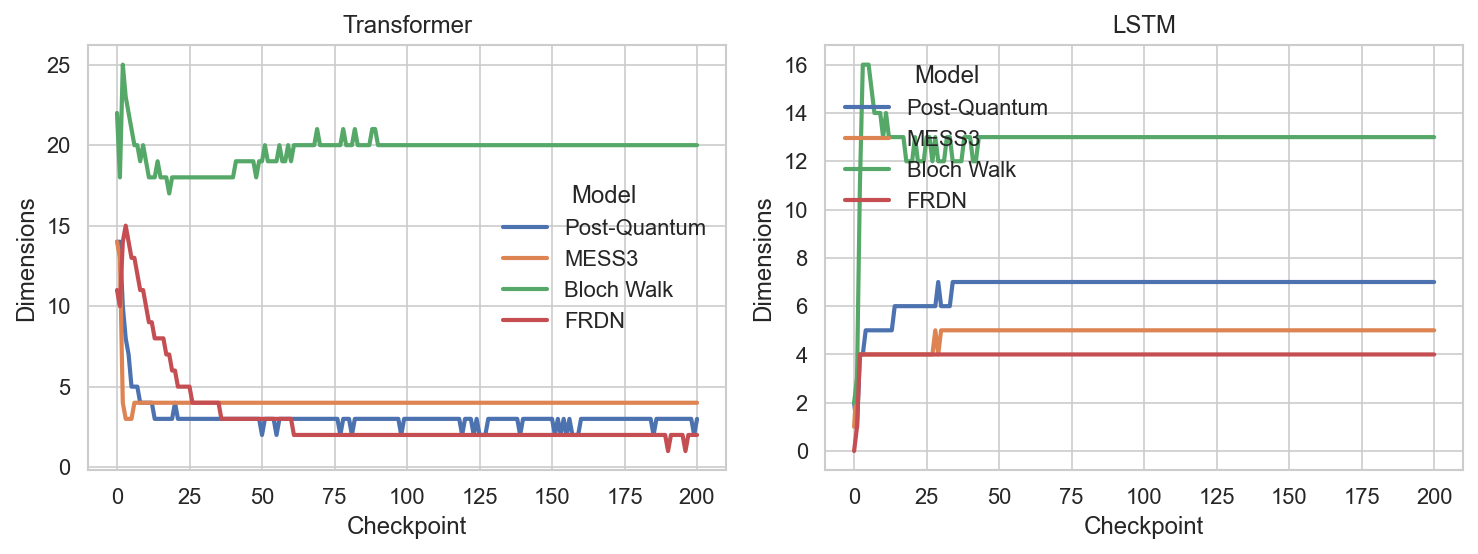

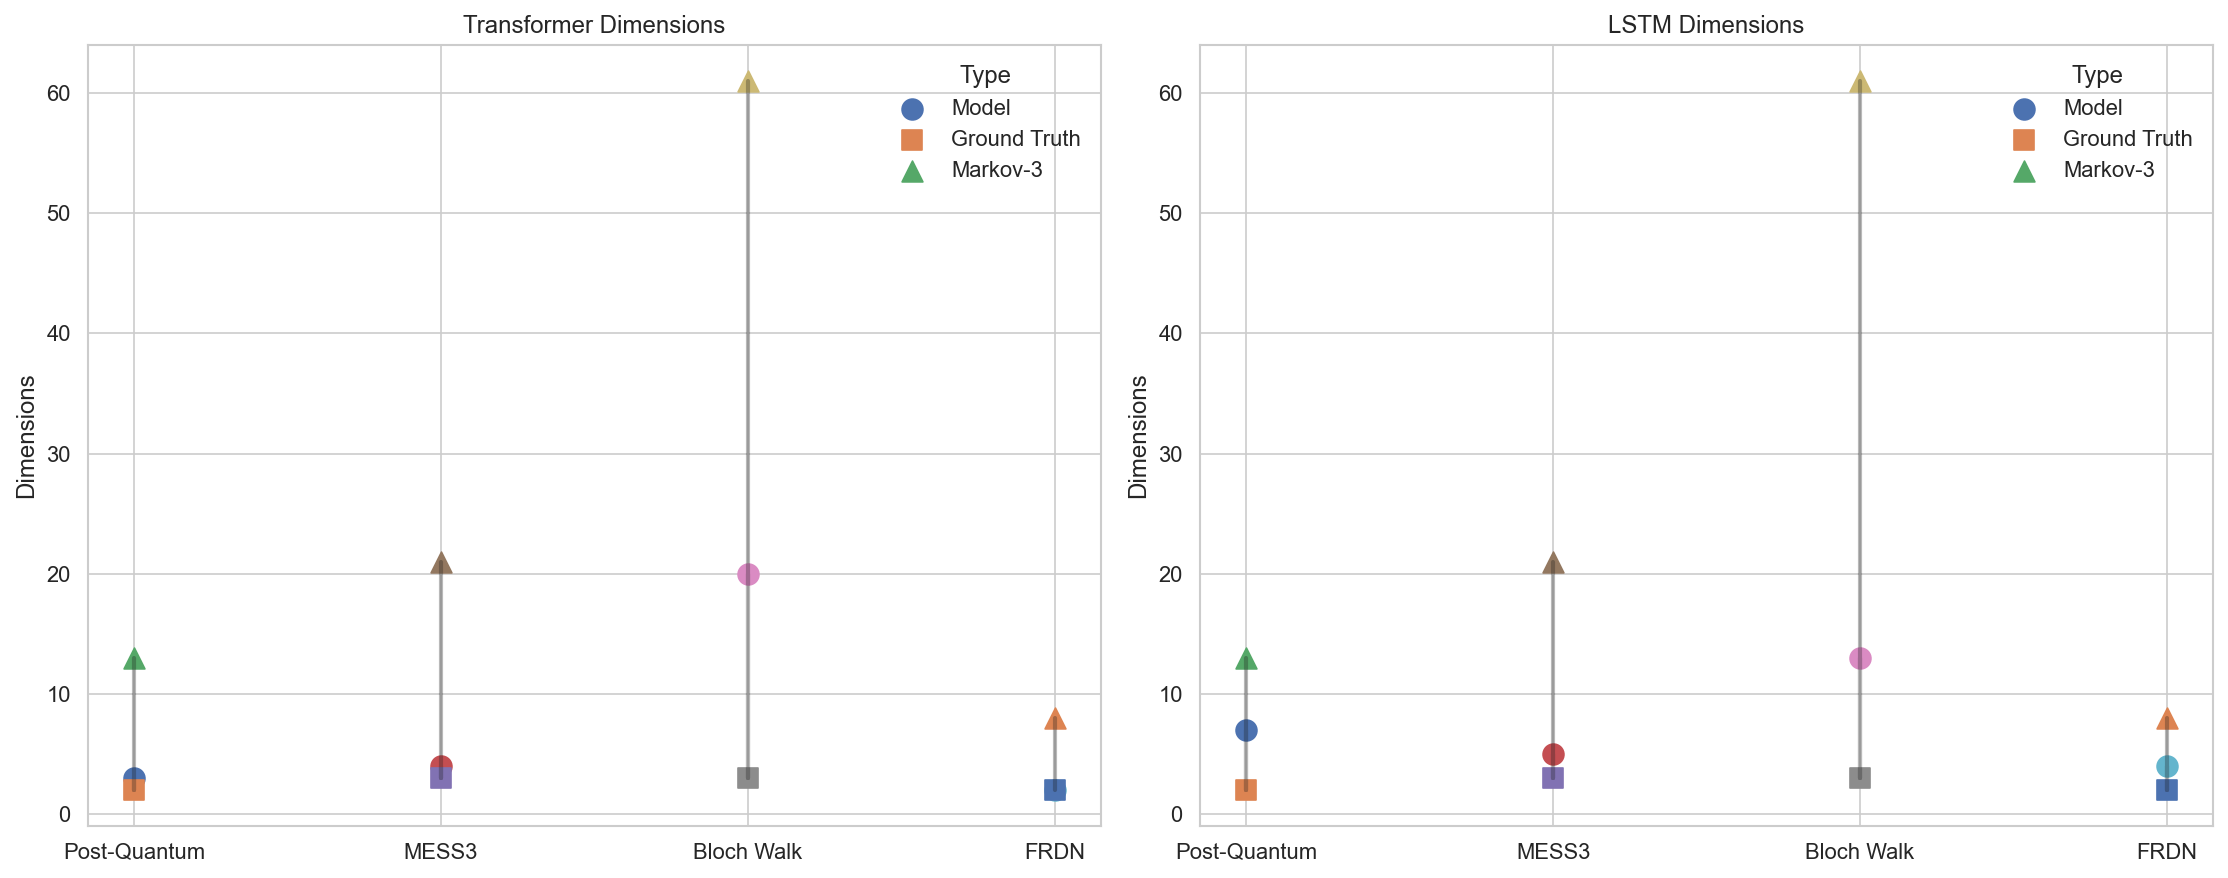

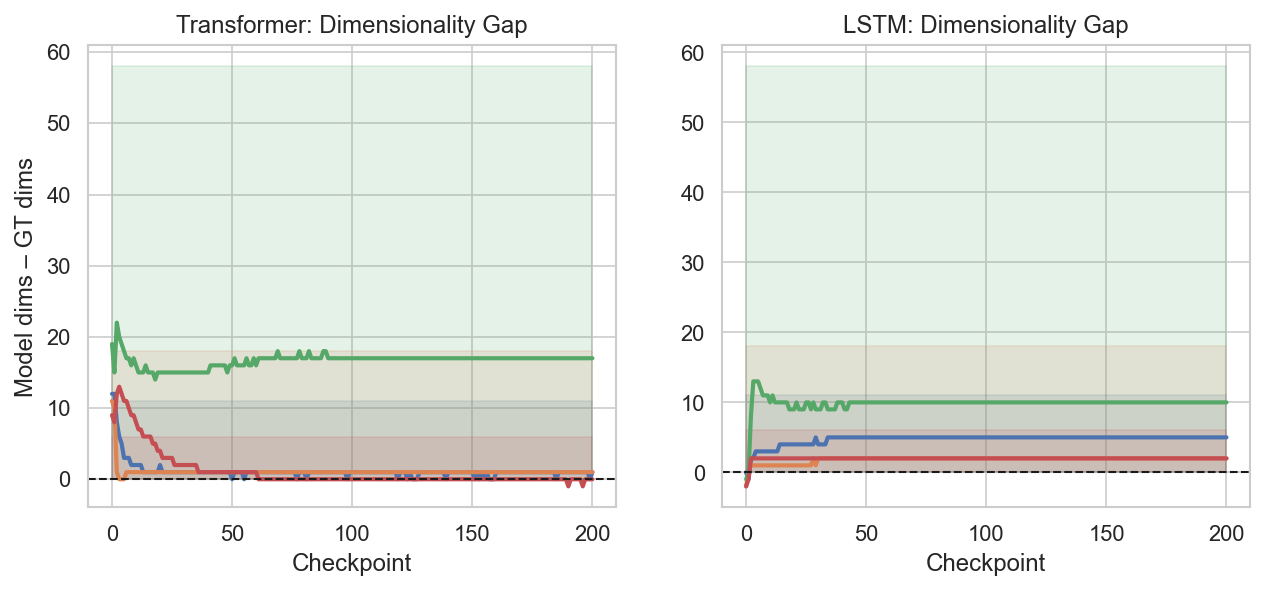

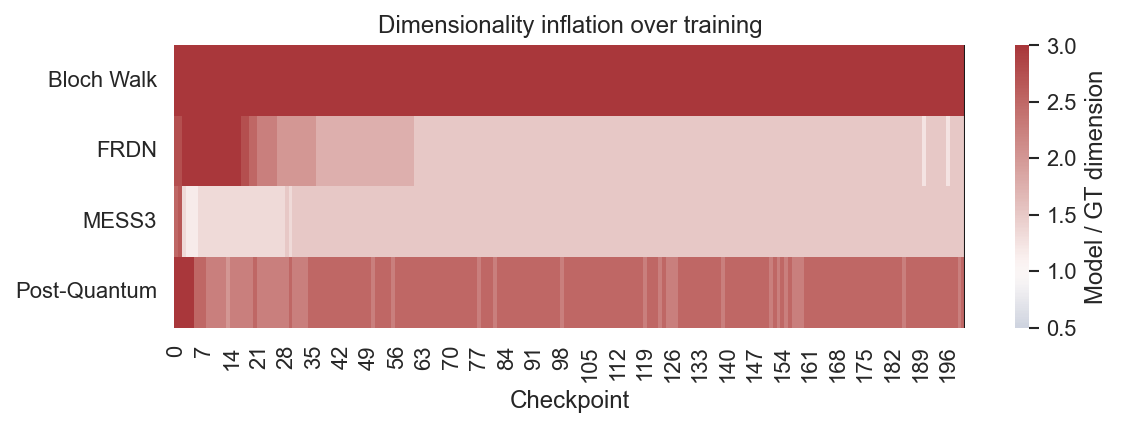

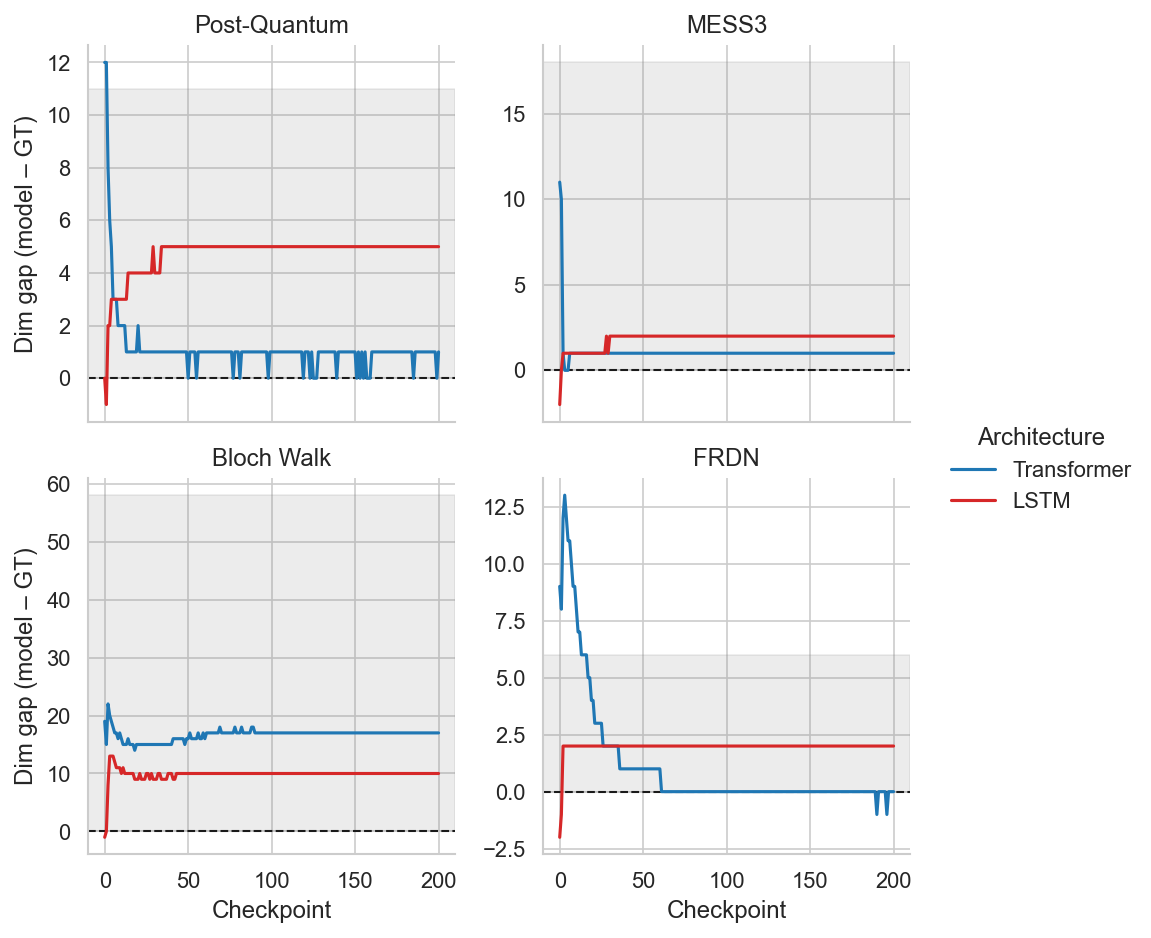

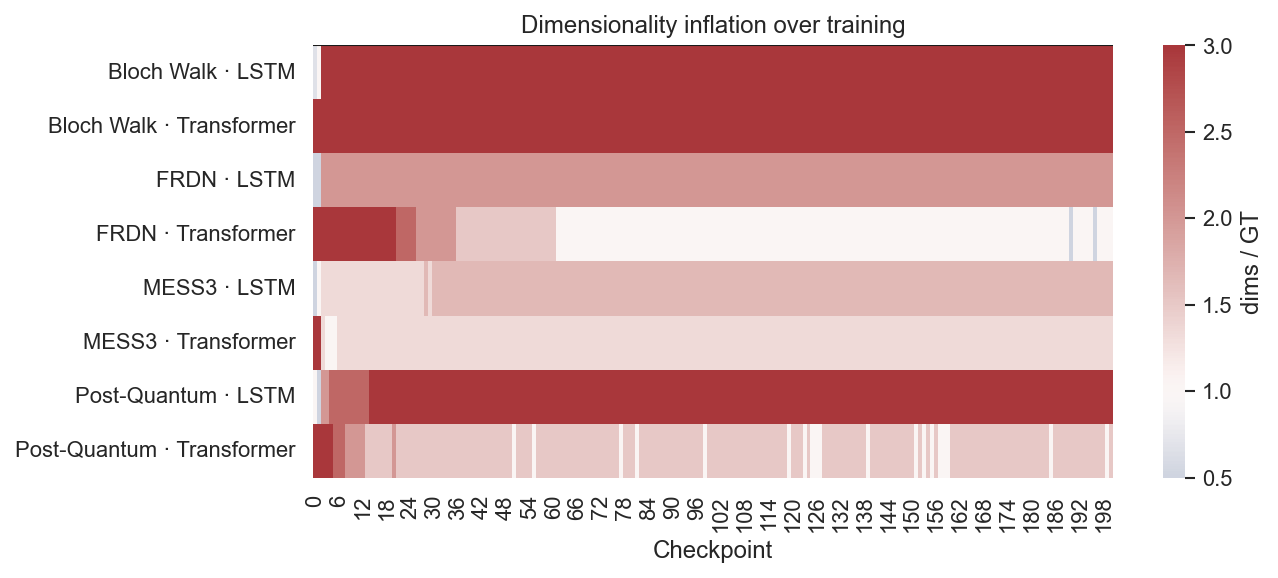

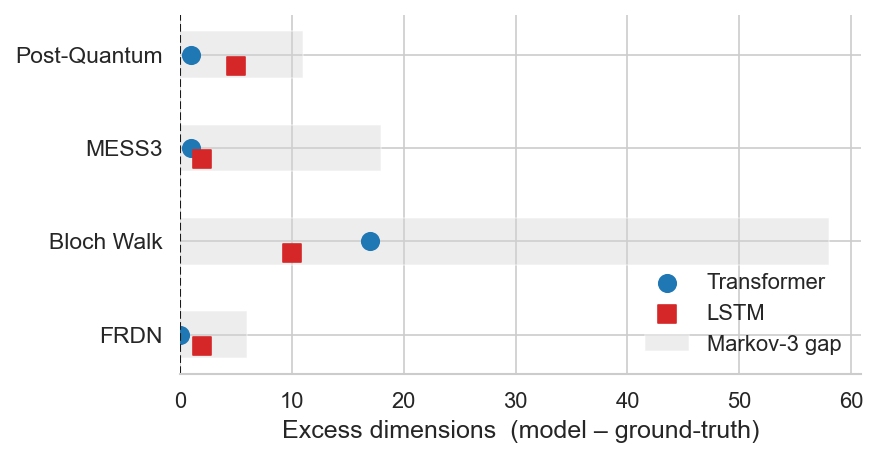

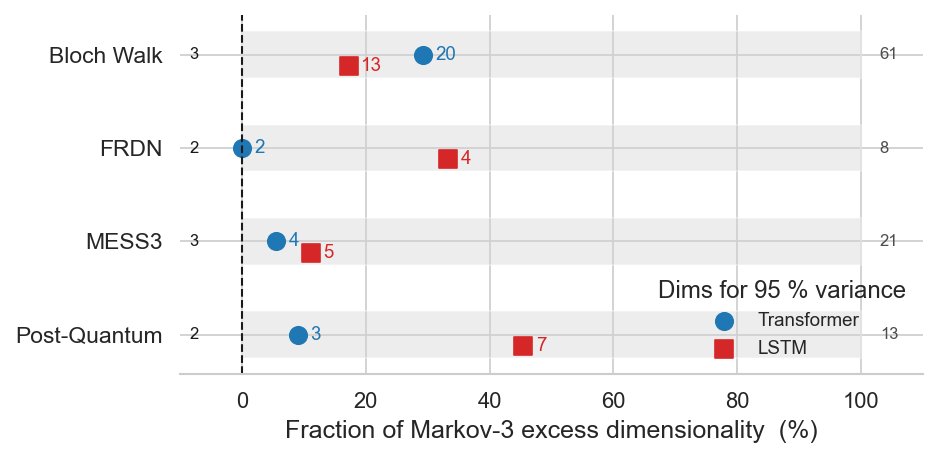

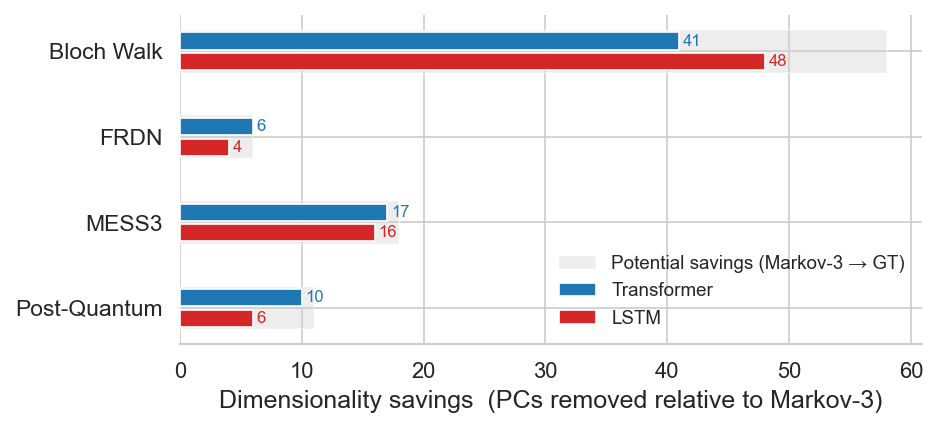

In [36]:
import seaborn as sns

layer_name_map = {
    'blocks.0.hook_resid_pre': 'Embed', 'blocks.0.hook_resid_post': 'L1',
    'blocks.1.hook_resid_post': 'L2', 'blocks.2.hook_resid_post': 'L3',
    'blocks.3.hook_resid_post': 'L4', 'ln_final.hook_normalized': 'LN',
    'input': 'Embed', 'layer0': 'L1', 'layer1': 'L2',
    'layer2': 'L3', 'layer3': 'L4', 'combined': 'Concat'
}

RUN_DIR = "run_predictions_RCOND_FINAL"

# Define experiment folders for different models
transformer_folders = {
    "Post-Quantum": "20250421221507_0",
    "MESS3": "20241205175736_23",
    "Bloch Walk": "20241205175736_17",
    "FRDN": "20250422023003_1"
}

lstm_folders = {
    "Post-Quantum": "20241121152808_48",
    "MESS3": "20241121152808_55",
    "Bloch Walk": "20241121152808_49",
    "FRDN": "20241121152808_53"
}


def get_checkpoint_list(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        prefix = 'markov3_checkpoint_'
    else:
        prefix = 'checkpoint_'
    ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, prefix + '*'))
    # sort by final number in filename
    ckpt_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return ckpt_files

def dims_for_var_thresh(cum_var, thresh):
    # find the dimensions where the cumulative variance exceeds the threshold
    return np.where(cum_var > thresh)[0][0]


def weighted_pca(beliefs: np.ndarray,
                 probs:   np.ndarray,
                 target_var: float = 0.95):

    # core weighted scatter matrix
    S = beliefs.T @ np.diag(probs) @ beliefs

    # eigen-decomposition (ascending from eigh → flip)
    eigvals, eigvecs = np.linalg.eigh(S)
    idx = eigvals.argsort()[::-1]          # largest → smallest
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # normalise eigenvalues to variance ratios
    var_ratio = eigvals / eigvals.sum()
    cum_var   = np.cumsum(var_ratio)

    # dims for desired variance (1-based index)
    k_needed = int(np.searchsorted(cum_var, target_var) + 1)

    return k_needed

def get_dims_data(run_dir, exp_folder, layer='combined'):
    dims_to_99_exp = []
    checkpoints = []

    # get ground truth data
    gt_data = joblib.load(os.path.join(run_dir, exp_folder, "ground_truth_data.joblib"))
    # run weighted PCA on gt_data['beliefs']
    gt_beliefs = gt_data['beliefs']
    gt_probs = gt_data['probs']
    gt_dims = weighted_pca(gt_beliefs, gt_probs)
    print(f'gt_dims: {gt_dims}')

    # get markov3 data
    m3_data = joblib.load(os.path.join(run_dir, exp_folder, "markov3_ground_truth_data.joblib"))
    m3_beliefs = m3_data['beliefs']
    m3_probs = m3_data['probs']
    m3_dims = weighted_pca(m3_beliefs, m3_probs)
    print(f'm3_dims: {m3_dims}')

    for i, ckpt_file in enumerate(get_checkpoint_list(run_dir, exp_folder, False)):
        try:
            ckpt_data = joblib.load(ckpt_file)
            dims_to_99_exp.append(dims_for_var_thresh(ckpt_data[layer]['cum_var_exp'], 0.95))
            checkpoints.append(i)
        except Exception as e:
            print(f"Error loading {ckpt_file}: {e}")
    return checkpoints, dims_to_99_exp, gt_dims, m3_dims

# Prepare data for seaborn
transformer_data = []
lstm_data = []
for model_name in transformer_folders.keys():
    # Transformer data
    transformer_folder = transformer_folders[model_name]
    t_checkpoints, t_dims, t_gt_dims, t_m3_dims = get_dims_data(RUN_DIR, transformer_folder)#, 'blocks.3.hook_resid_post')
    # make t_gt_dims and t_m3_dims a list of the same length as t_checkpoints
    t_gt_dims = [t_gt_dims] * len(t_checkpoints)
    t_m3_dims = [t_m3_dims] * len(t_checkpoints)
    
    # LSTM data
    lstm_folder = lstm_folders[model_name]
    l_checkpoints, l_dims, l_gt_dims, l_m3_dims = get_dims_data(RUN_DIR, lstm_folder)#, 'layer3')
    # make l_gt_dims and l_m3_dims a list of the same length as l_checkpoints
    l_gt_dims = [l_gt_dims] * len(l_checkpoints)
    l_m3_dims = [l_m3_dims] * len(l_checkpoints)
    
    # Add transformer data to the list
    for checkpoint, dim, gt_dim, m3_dim in zip(t_checkpoints, t_dims, t_gt_dims, t_m3_dims):
        transformer_data.append({
            'Checkpoint': checkpoint,
            'Dimensions': dim,
            'Model': model_name,
            'GT Dims': gt_dim,
            'M3 Dims': m3_dim
        })
    
    # Add LSTM data to the list
    for checkpoint, dim, gt_dim, m3_dim in zip(l_checkpoints, l_dims, l_gt_dims, l_m3_dims):
        lstm_data.append({
            'Checkpoint': checkpoint,
            'Dimensions': dim,
            'Model': model_name,
            'GT Dims': gt_dim,
            'M3 Dims': m3_dim
        })

# Convert to DataFrames
transformer_df = pd.DataFrame(transformer_data)
lstm_df = pd.DataFrame(lstm_data)

# Set seaborn style
sns.set_theme(style="whitegrid", font="Arial")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.0})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Create the transformer plot
sns.lineplot(
    data=transformer_df,
    x='Checkpoint',
    y='Dimensions',
    hue='Model',
    ax=ax1
)
ax1.set_title('Transformer')

# Create the LSTM plot
sns.lineplot(
    data=lstm_df,
    x='Checkpoint',
    y='Dimensions',
    hue='Model',
    ax=ax2
)
ax2.set_title('LSTM')

# Customize the layout
fig.tight_layout(rect=[0, 0, 1, 0.96])
# now make a second plot that compares the gt dims to the m3 dims, and the dims of the model at the final checkpoint
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get the final checkpoint data for each model in transformer_df
final_transformer_models = []
for model in transformer_df['Model'].unique():
    model_data = transformer_df[transformer_df['Model'] == model]
    final_checkpoint = model_data['Checkpoint'].max()
    final_model_data = model_data[model_data['Checkpoint'] == final_checkpoint].iloc[0]
    final_transformer_models.append({
        'Model': model,
        'Dimensions': final_model_data['Dimensions'],
        'GT Dims': final_model_data['GT Dims'],
        'M3 Dims': final_model_data['M3 Dims']
    })

# Create a scatter plot for transformer models
for i, model_data in enumerate(final_transformer_models):
    # Create x positions for each model (1, 2, 3, etc.)
    x_pos = i + 1
    
    # Plot each dimension type as a separate point for this model
    ax1.scatter(x_pos, model_data['Dimensions'], marker='o', s=100, label='Model' if i == 0 else "")
    ax1.scatter(x_pos, model_data['GT Dims'], marker='s', s=100, label='Ground Truth' if i == 0 else "")
    ax1.scatter(x_pos, model_data['M3 Dims'], marker='^', s=100, label='Markov-3' if i == 0 else "")
    
    # Connect the points with lines
    ax1.plot([x_pos, x_pos, x_pos], 
             [model_data['Dimensions'], model_data['GT Dims'], model_data['M3 Dims']], 
             'k-', alpha=0.3)

# Set x-ticks to model names
ax1.set_xticks(range(1, len(final_transformer_models) + 1))
ax1.set_xticklabels([model['Model'] for model in final_transformer_models])
ax1.set_title('Transformer Dimensions')
ax1.set_ylabel('Dimensions')
ax1.legend(title='Type', loc='upper right')

# Get the final checkpoint data for each model in lstm_df
final_lstm_models = []
for model in lstm_df['Model'].unique():
    model_data = lstm_df[lstm_df['Model'] == model]
    final_checkpoint = model_data['Checkpoint'].max()
    final_model_data = model_data[model_data['Checkpoint'] == final_checkpoint].iloc[0]
    final_lstm_models.append({
        'Model': model,
        'Dimensions': final_model_data['Dimensions'],
        'GT Dims': final_model_data['GT Dims'],
        'M3 Dims': final_model_data['M3 Dims']
    })

# Create a scatter plot for LSTM models
for i, model_data in enumerate(final_lstm_models):
    # Create x positions for each model (1, 2, 3, etc.)
    x_pos = i + 1
    
    # Plot each dimension type as a separate point for this model
    ax2.scatter(x_pos, model_data['Dimensions'], marker='o', s=100, label='Model' if i == 0 else "")
    ax2.scatter(x_pos, model_data['GT Dims'], marker='s', s=100, label='Ground Truth' if i == 0 else "")
    ax2.scatter(x_pos, model_data['M3 Dims'], marker='^', s=100, label='Markov-3' if i == 0 else "")
    
    # Connect the points with lines
    ax2.plot([x_pos, x_pos, x_pos], 
             [model_data['Dimensions'], model_data['GT Dims'], model_data['M3 Dims']], 
             'k-', alpha=0.3)

# Set x-ticks to model names
ax2.set_xticks(range(1, len(final_lstm_models) + 1))
ax2.set_xticklabels([model['Model'] for model in final_lstm_models])
ax2.set_title('LSTM Dimensions')
ax2.set_ylabel('Dimensions')
ax2.legend(title='Type', loc='upper right')

plt.tight_layout()


# ── add Markov-3 gap ────────────────────────────────────────────────────────
for df in (transformer_df, lstm_df):
    df['Gap']     = df['Dimensions'] - df['GT Dims']      # net – ground-truth
    df['M3_Gap']  = df['M3 Dims']    - df['GT Dims']      # Markov-3 – ground-truth

# common palette so lines & baselines share colours
palette = sns.color_palette(n_colors=len(transformer_df['Model'].unique()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# helper to draw both the learning curve and its baseline
def gap_panel(df, ax, title):
    sns.lineplot(
        data=df,
        x='Checkpoint',
        y='Gap',
        hue='Model',
        palette=palette,
        ax=ax,
        legend=False
    )
    # zero-gap reference
    ax.axhline(0, ls='--', c='k', lw=1)

    # Add shaded regions between Markov-3 baseline and zero
    band_alpha = 0.15
    for i, mdl in enumerate(df['Model'].unique()):
        m3_gap = df.loc[df['Model'] == mdl, 'M3_Gap'].iloc[0]
        ax.fill_between([0, df['Checkpoint'].max()],
                        m3_gap, 0, color=palette[i], alpha=band_alpha)

    ax.set_title(title)
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Model dims – GT dims' if ax is ax1 else '')

gap_panel(transformer_df, ax1, 'Transformer: Dimensionality Gap')
gap_panel(lstm_df,         ax2, 'LSTM: Dimensionality Gap')

# … after the two gap panels are drawn
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# pick whichever has content
handles = handles1 if handles1 else handles2
labels  = labels1  if labels1  else labels2

if handles:               # only add if something to show
    fig.legend(handles, labels,
               loc='upper center',
               ncol=len(labels),
               frameon=False,
               bbox_to_anchor=(0.5, 1.05))


# ---------- build 2-D matrix ----------
all_df = pd.concat([transformer_df, lstm_df])
all_df['Rel'] = all_df['Dimensions'] / all_df['GT Dims']   # 1 = optimal
pivot = all_df.pivot_table(index='Model',
                           columns='Checkpoint',
                           values='Rel')

# ---------- plot ----------
plt.figure(figsize=(8, 3))
sns.heatmap(pivot,
            cmap='vlag', center=1, vmin=0.5, vmax=3,
            cbar_kws={'label': 'Model / GT dimension'})
plt.axvline(pivot.columns[-1]+1, color='k', lw=1)  # right border
plt.title('Dimensionality inflation over training')
plt.xlabel('Checkpoint')
plt.ylabel('')
plt.tight_layout()


# ------------------------------------------------------------------
# merge and reshape so each row = one arch/process/checkpoint record
# ------------------------------------------------------------------
tt = transformer_df.assign(Arch='Transformer')
ll = lstm_df.assign(Arch='LSTM')
all_df = pd.concat([tt, ll], ignore_index=True)

# reduce to what we need
plot_df = all_df[['Model', 'Arch', 'Checkpoint', 'Gap', 'M3_Gap']]

# colour per architecture, shade per process band
arch_palette = {'Transformer': '#1f77b4',  # blue
                'LSTM':        '#d62728'}  # red

g = sns.FacetGrid(plot_df, col='Model', col_wrap=2, height=3.2, sharey=False)

def bandplot(data, color, **kws):
    # shaded Markov-3 band (same across steps)
    m3 = data['M3_Gap'].iloc[0]
    plt.axhspan(0, m3, color='gray', alpha=0.15)
    # zero line
    plt.axhline(0, ls='--', c='k', lw=1)

g.map_dataframe(
    bandplot, color='black'
)

g.map_dataframe(
    sns.lineplot,
    x='Checkpoint', y='Gap', hue='Arch',
    palette=arch_palette, linewidth=1.5
)

g.add_legend(title='Architecture')
g.set_axis_labels('Checkpoint', 'Dim gap (model – GT)')
g.set_titles('{col_name}')
g.tight_layout()

# relative overshoot ratio
all_df['Inflation'] = all_df['Dimensions'] / all_df['GT Dims']  # 1 = optimal

# build long→wide for heat-map: index = process, columns = ckpt_arch
all_df['Proc-Arch'] = all_df['Model'] + ' · ' + all_df['Arch']
heat = (all_df
        .pivot(index='Proc-Arch',
               columns='Checkpoint',
               values='Inflation')
        .sort_index())    # nice ordering

plt.figure(figsize=(9, 4))
sns.heatmap(heat,
            cmap='vlag', center=1, vmin=0.5, vmax=3,
            cbar_kws={'label': 'dims / GT'})
plt.axhline(0, color='k', lw=1)            # top border
plt.title('Dimensionality inflation over training')
plt.xlabel('Checkpoint')
plt.ylabel('')
plt.tight_layout()

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ── collect final-checkpoint records ─────────────────────────────────────────
final_rows = []

for df, arch in ((transformer_df, 'Transformer'),
                 (lstm_df,        'LSTM')):

    for proc in df['Model'].unique():
        sub = df[df['Model'] == proc]
        ckpt = sub['Checkpoint'].max()
        row  = sub[sub['Checkpoint'] == ckpt].iloc[0]

        final_rows.append({
            'Process': proc,
            'Arch':    arch,
            'Gap':     row['Gap'],
            'M3_Gap':  row['M3_Gap']
        })

# one extra row per process for the Markov-3 baseline
for proc in transformer_df['Model'].unique():
    m3_gap = transformer_df.loc[transformer_df['Model'] == proc, 'M3_Gap'].iloc[0]
    final_rows.append({
        'Process': proc,
        'Arch':    'Markov-3',
        'Gap':     m3_gap,
        'M3_Gap':  m3_gap
    })

final_df = pd.DataFrame(final_rows)

# order processes sensibly (e.g. same as paper text)
proc_order = ['Post-Quantum', 'MESS3', 'Bloch Walk', 'FRDN']
final_df['Process'] = pd.Categorical(final_df['Process'], ordered=True,
                                     categories=proc_order)
final_df.sort_values('Process', inplace=True)
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ── build tidy table (same as before) ──────────────────────────────────────
rows = []
for proc in ['Post-Quantum', 'MESS3', 'Bloch Walk', 'FRDN']:
    t_gap  = transformer_df.query("Model==@proc and Checkpoint==Checkpoint.max()")['Gap'].iloc[0]
    l_gap  = lstm_df       .query("Model==@proc and Checkpoint==Checkpoint.max()")['Gap'].iloc[0]
    m3_gap = transformer_df.query("Model==@proc")['M3_Gap'].iloc[0]
    rows.append(dict(Process=proc, Markov=m3_gap,
                     Transformer=t_gap, LSTM=l_gap))
tbl = pd.DataFrame(rows)

# numeric y positions
y_pos = np.arange(len(tbl))

# ── figure ────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 3.2))

# Markov-3 band  (0 → m3_gap)
ax.barh(y=y_pos,
        width=tbl['Markov'],
        height=0.5,
        color='lightgrey',
        alpha=0.4,
        align='center',
        label='Markov-3 gap')

# Transformer & LSTM points
ax.scatter(tbl['Transformer'], y_pos,
           color='#1f77b4', marker='o', s=70, label='Transformer')

ax.scatter(tbl['LSTM'], y_pos + 0.12,        # tiny nudge so points don’t collide
           color='#d62728', marker='s', s=70, label='LSTM')

# reference line at perfect match
ax.axvline(0, ls='--', lw=1, c='k')

# axes, labels, legend
ax.set_yticks(y_pos)
ax.set_yticklabels(tbl['Process'], fontsize=11)
ax.invert_yaxis()                                        # top row first
ax.set_xlabel('Excess dimensions  (model – ground-truth)', fontsize=12)
ax.set_xlim(left=0)                                      # no negative waste here
sns.despine(left=True)
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

VAR_THRESH = 0.95   # ← you said 95 %

# ---------- helper to grab final dims -----------------------------------------
def final_dims(df, proc):
    row = df.query("Model==@proc and Checkpoint==Checkpoint.max()").iloc[0]
    return row['Dimensions'], row['GT Dims'], row['M3 Dims']

rows = []
for proc in ['Post-Quantum', 'MESS3', 'Bloch Walk', 'FRDN']:
    t_dim, gt_dim, m3_dim = final_dims(transformer_df, proc)
    l_dim, _,       _     = final_dims(lstm_df,        proc)
    span = m3_dim - gt_dim                      # denom for normalisation

    rows.append(dict(proc=proc,
                     gt=0,                       # by definition
                     m3=100,
                     t_pct=(t_dim - gt_dim) / span * 100,
                     l_pct=(l_dim - gt_dim) / span * 100,
                     t_raw=t_dim, l_raw=l_dim,
                     gt_raw=gt_dim, m3_raw=m3_dim))

tbl = pd.DataFrame(rows).set_index('proc')
tbl = tbl.sort_index()          # same order as paper
y = np.arange(len(tbl))         # numeric y-coords

# ---------- plot --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.4, 3.2))

# shaded 0–100 % band (Markov-3 extent)
ax.barh(y, 100, height=0.5, color='lightgrey', alpha=0.4, align='center')

# Transformer / LSTM markers
ax.scatter(tbl['t_pct'], y,        c='#1f77b4', marker='o', s=70, label='Transformer')
ax.scatter(tbl['l_pct'], y+0.12,   c='#d62728', marker='s', s=70, label='LSTM')

# axis & labels
ax.set_yticks(y)
ax.set_yticklabels(tbl.index, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Fraction of Markov-3 excess dimensionality  (%)', fontsize=12)
ax.set_xlim(-10, 110)            # leave room for annotations & over-compression
ax.axvline(0, ls='--', lw=1, c='k')

# annotate raw dims next to markers
for i, proc in enumerate(tbl.index):
    ax.text(tbl.loc[proc, 't_pct']+2, i,   f"{tbl.loc[proc,'t_raw']}", va='center', fontsize=9, color='#1f77b4')
    ax.text(tbl.loc[proc, 'l_pct']+2, i+0.12, f"{tbl.loc[proc,'l_raw']}", va='center', fontsize=9, color='#d62728')
    # add GT/M3 raw ticks at bar ends
    ax.text(-7, i,              f"{tbl.loc[proc,'gt_raw']}", va='center', ha='right', fontsize=8, color='k')
    ax.text(103, i,             f"{tbl.loc[proc,'m3_raw']}", va='center', ha='left',  fontsize=8, color='0.3')

# legend & styling
sns.despine(left=True)
ax.legend(frameon=False, loc='lower right', fontsize=9,
          title=f'Dims for {int(VAR_THRESH*100)} % variance')
plt.tight_layout()

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# ---- pull final-checkpoint dims (95 % variance in your runs) ---------------
rows = []
for proc in ['Post-Quantum', 'MESS3', 'Bloch Walk', 'FRDN']:

    t_row = transformer_df.query("Model==@proc and Checkpoint==Checkpoint.max()").iloc[0]
    l_row = lstm_df       .query("Model==@proc and Checkpoint==Checkpoint.max()").iloc[0]

    gt, m3 = t_row['GT Dims'], t_row['M3 Dims']
    max_save = m3 - gt                     # what’s even possible

    rows.append(dict(proc=proc,
                     max_save=max_save,
                     t_save=m3 - t_row['Dimensions'],
                     l_save=m3 - l_row['Dimensions'],
                     gt=gt, m3=m3,
                     t_dims=t_row['Dimensions'],
                     l_dims=l_row['Dimensions']))

tbl = pd.DataFrame(rows).set_index('proc').sort_index()
y = np.arange(len(tbl))

# ---- plot ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.4, 3.0))

# full potential bar (grey)
ax.barh(y, tbl['max_save'],
        height=0.5, color='lightgrey', alpha=0.4, align='center',
        label='Potential savings (Markov-3 → GT)')

# achieved savings bars (thin overlays)
ax.barh(y-0.12, tbl['t_save'],
        height=0.20, color='#1f77b4', label='Transformer')
ax.barh(y+0.12, tbl['l_save'],
        height=0.20, color='#d62728', label='LSTM')

# % labels at bar ends (optional, comment out if cluttered)
for i, p in enumerate(tbl.index):
    ax.text(tbl.loc[p,'t_save']+0.3, i-0.12,
            f"{tbl.loc[p,'t_save']:.0f}", va='center', fontsize=8, color='#1f77b4')
    ax.text(tbl.loc[p,'l_save']+0.3, i+0.12,
            f"{tbl.loc[p,'l_save']:.0f}", va='center', fontsize=8, color='#d62728')

# axis cosmetics
ax.set_yticks(y)
ax.set_yticklabels(tbl.index, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Dimensionality savings  (PCs removed relative to Markov-3)', fontsize=12)
ax.set_xlim(left=0)
sns.despine(left=True)

# legend
ax.legend(frameon=False, loc='lower right', fontsize=9)

plt.tight_layout()



Starting processing and plotting for all models!
Processing transformer model: Post-Quantum
Markov3 checkpoint: run_predictions_RCOND_FINAL/20250421221507_0/markov3_checkpoint_50946560.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20250421221507_0/checkpoint_50946560.joblib
Markov3 data shape: (5273, 22)
Non-Markov data shape: (5273, 3)
Sampling 1000 points from Markov3 data for Post-Quantum
Sampling 1000 points from Non-Markov data for Post-Quantum
Plotting transformer model: Post-Quantum


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


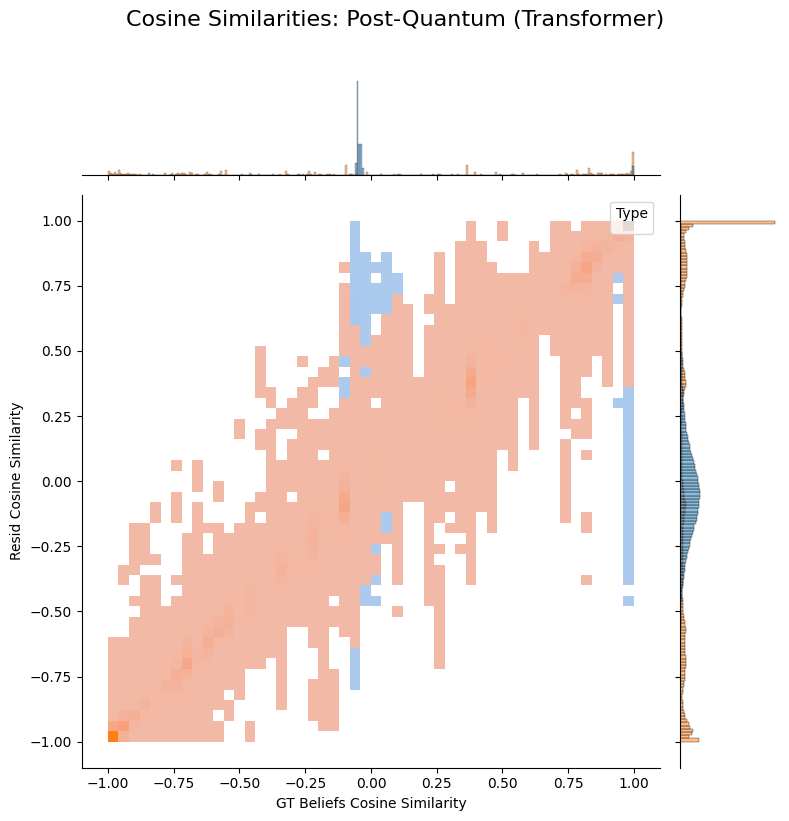

Processing transformer model: MESS3
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241205175736_23/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241205175736_23/checkpoint_4075724800.joblib
Markov3 data shape: (9840, 27)
Non-Markov data shape: (9840, 3)
Sampling 1000 points from Markov3 data for MESS3
Sampling 1000 points from Non-Markov data for MESS3
Plotting transformer model: MESS3


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


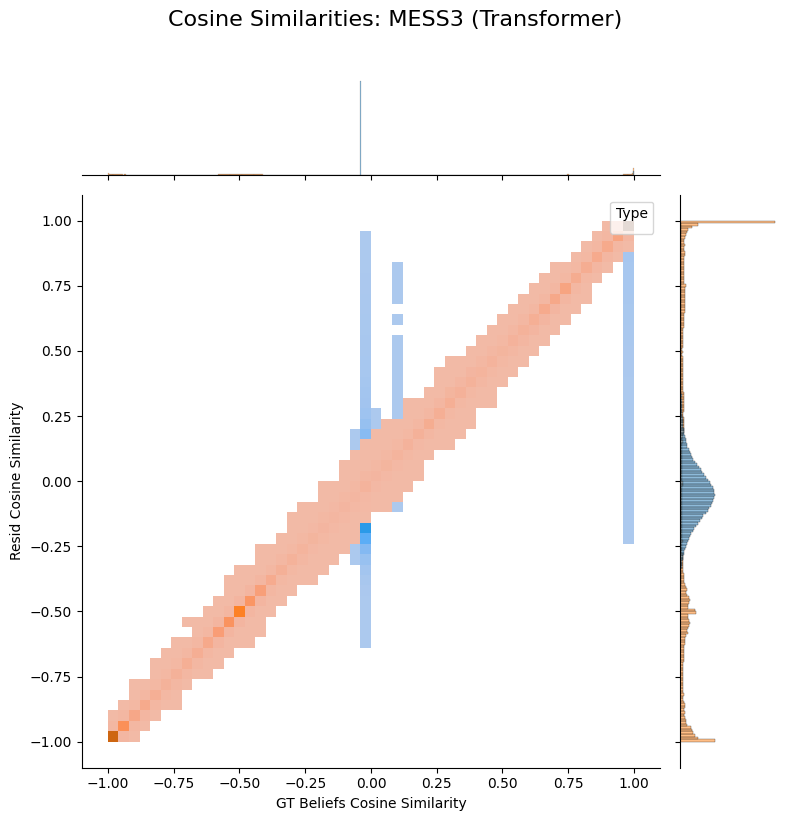

Processing transformer model: Bloch Walk
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241205175736_17/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241205175736_17/checkpoint_4075724800.joblib
Markov3 data shape: (87380, 64)
Non-Markov data shape: (87380, 3)
Sampling 1000 points from Markov3 data for Bloch Walk
Sampling 1000 points from Non-Markov data for Bloch Walk
Plotting transformer model: Bloch Walk


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


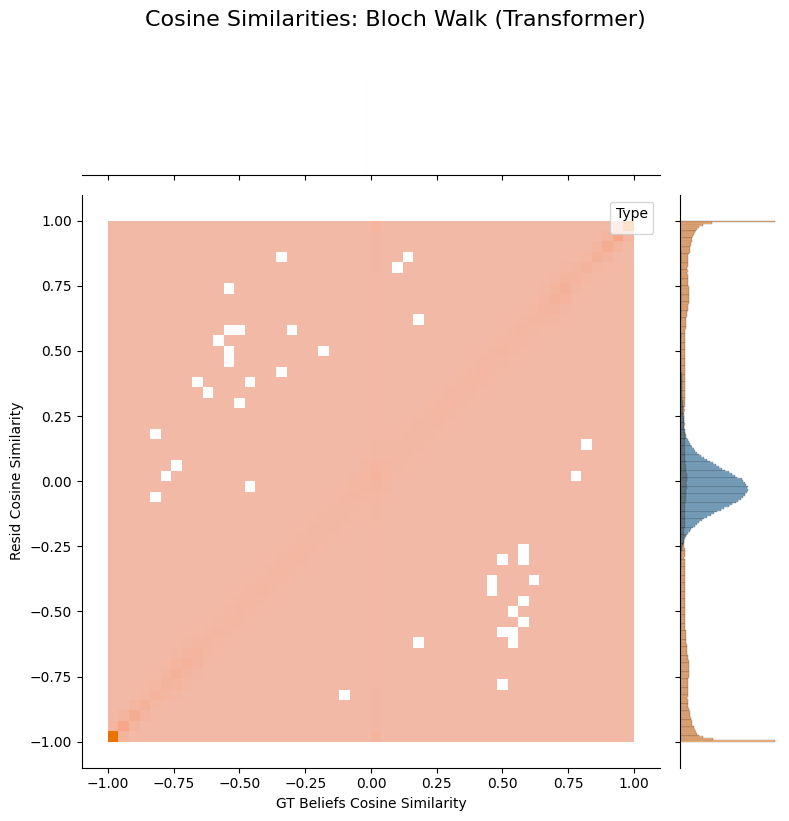

Processing transformer model: FRDN
Markov3 checkpoint: run_predictions_RCOND_FINAL/20250422023003_1/markov3_checkpoint_50946560.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20250422023003_1/checkpoint_50946560.joblib
Markov3 data shape: (510, 8)
Non-Markov data shape: (510, 4)
Plotting transformer model: FRDN


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


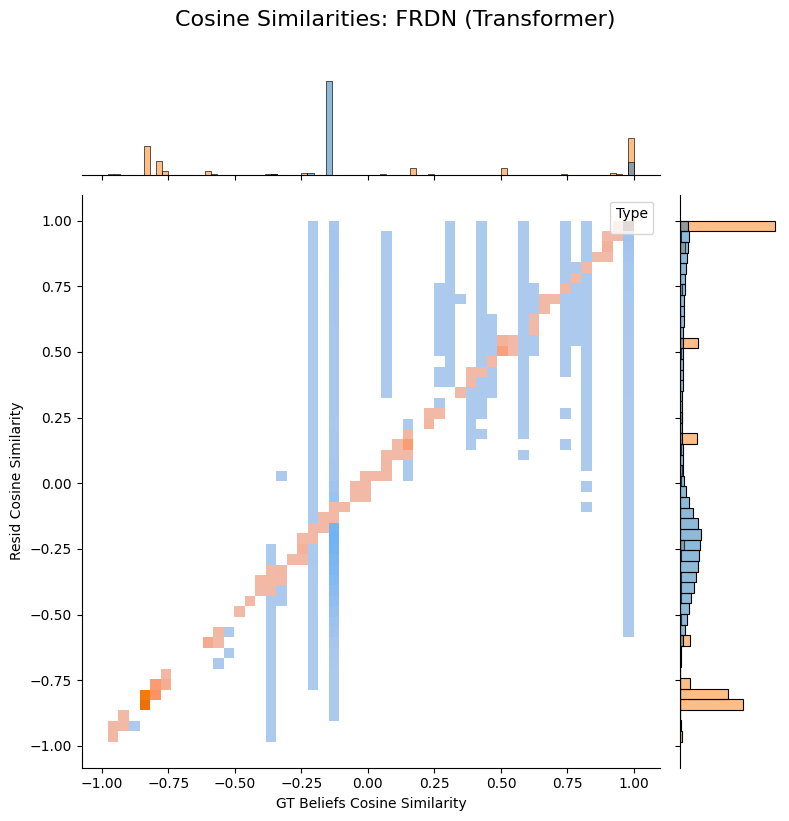

Processing LSTM model: Post-Quantum
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241121152808_48/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241121152808_48/checkpoint_4075724800.joblib
Sampling 1000 points from Markov3 data for Post-Quantum
Sampling 1000 points from Non-Markov data for Post-Quantum
Plotting LSTM model: Post-Quantum


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


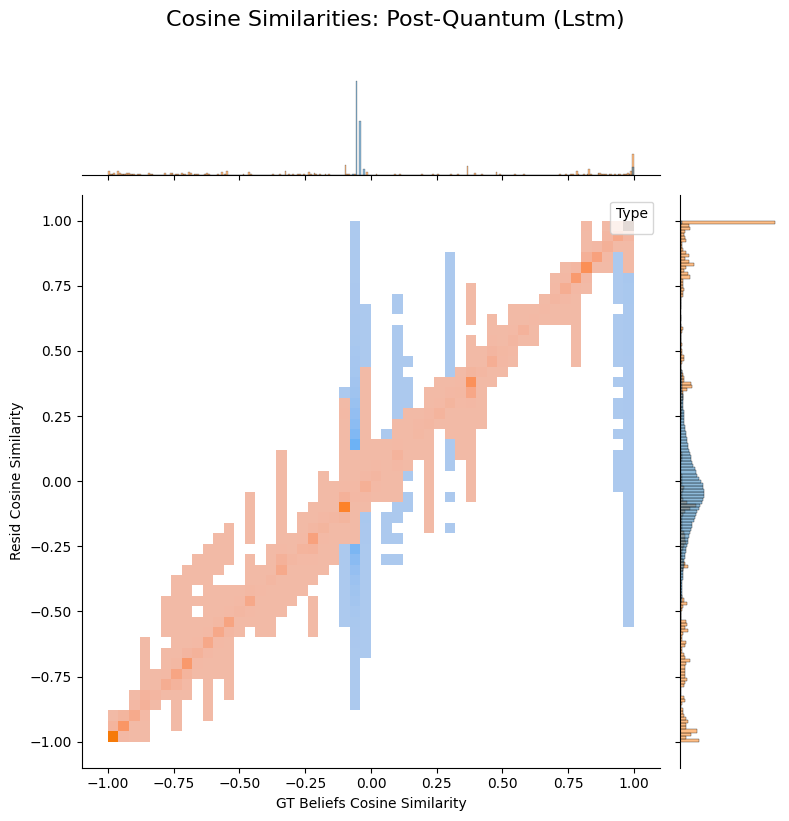

Processing LSTM model: MESS3
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241121152808_55/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241121152808_55/checkpoint_4075724800.joblib
Sampling 1000 points from Markov3 data for MESS3
Sampling 1000 points from Non-Markov data for MESS3
Plotting LSTM model: MESS3


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


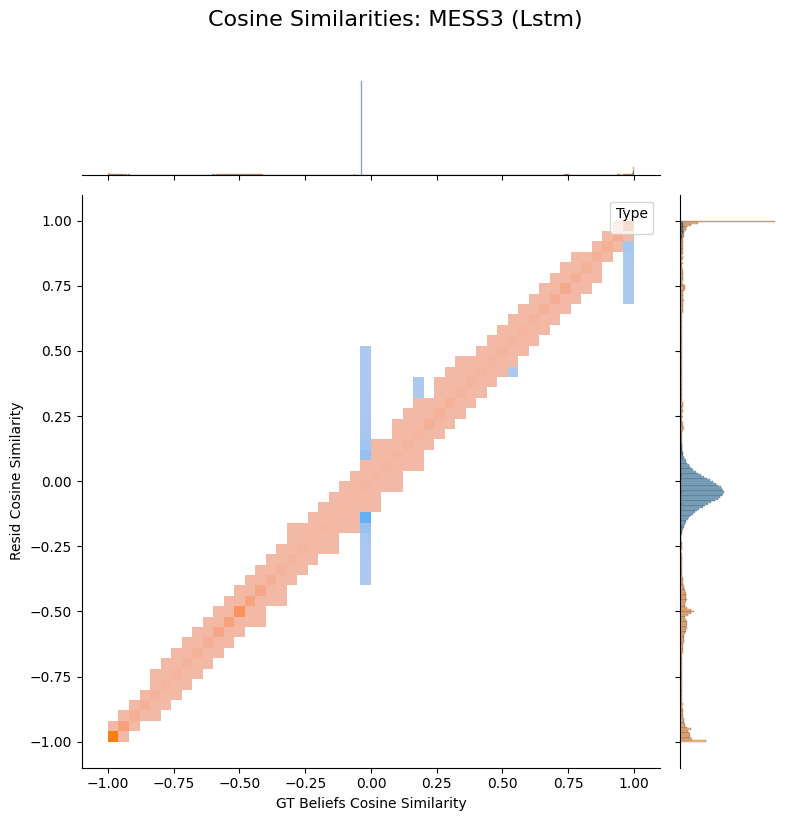

Processing LSTM model: Bloch Walk
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241121152808_49/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241121152808_49/checkpoint_4075724800.joblib
Sampling 1000 points from Markov3 data for Bloch Walk
Sampling 1000 points from Non-Markov data for Bloch Walk
Plotting LSTM model: Bloch Walk


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


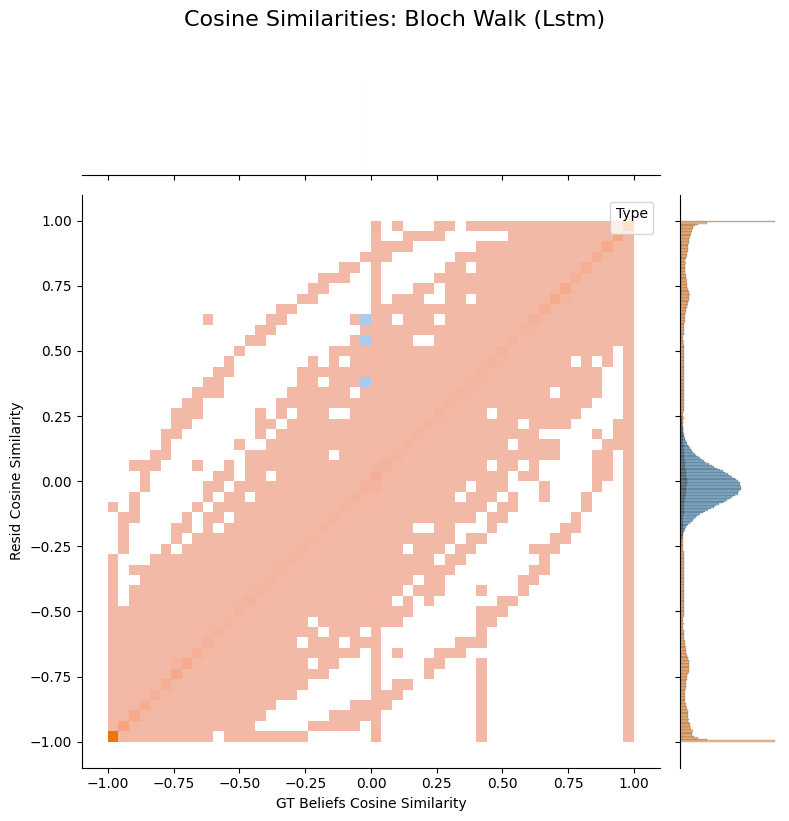

Processing LSTM model: FRDN
Markov3 checkpoint: run_predictions_RCOND_FINAL/20241121152808_53/markov3_checkpoint_4075724800.joblib
Non-Markov checkpoint: run_predictions_RCOND_FINAL/20241121152808_53/checkpoint_4075724800.joblib
Plotting LSTM model: FRDN


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_79971/198940584.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type', loc='upper right')


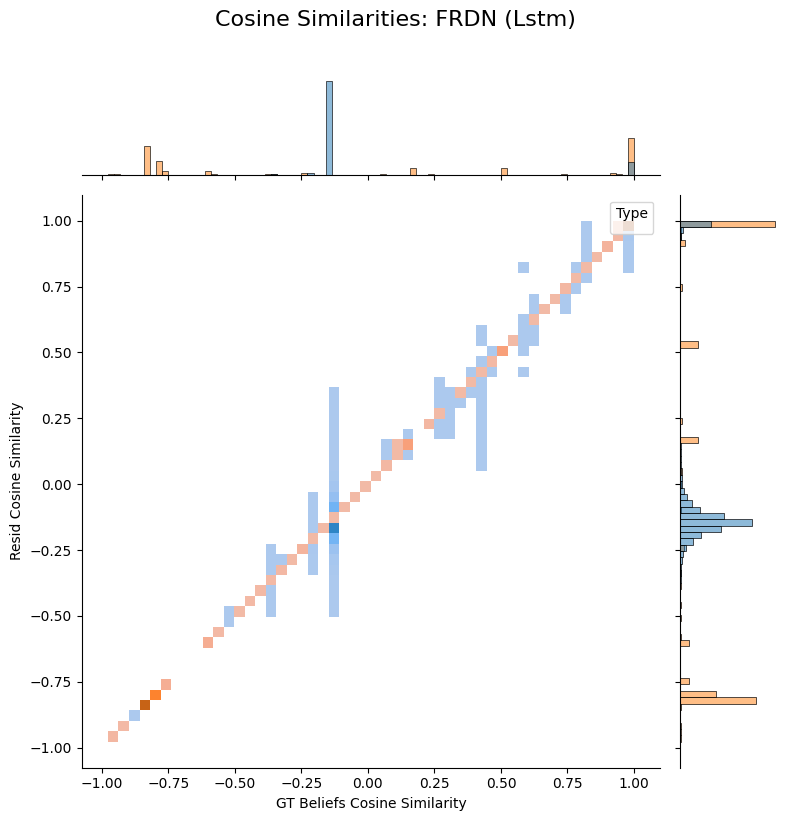

In [10]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import glob
import os
import joblib

import joblib
import os
import numpy as np
import collections
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

def nested_dict_factory():
    """Returns a defaultdict that defaults to a regular dictionary."""
    return collections.defaultdict(dict)

def get_checkpoint_list(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        prefix = 'markov3_checkpoint_'
    else:
        prefix = 'checkpoint_'
    ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, prefix + '*'))
    # sort by final number in filename
    ckpt_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return ckpt_files

def ground_truth(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        gt_file = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "markov3_ground_truth_data.joblib"))[0]
    else:
        gt_file = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, "ground_truth_data.joblib"))[0]
    return joblib.load(gt_file)

def load_and_process_data(run_dir, exp_folder, is_markov):
    """
    Load and process data for a specific experiment.
    
    Args:
        run_dir: Directory containing run predictions
        exp_folder: Experiment folder name
        is_markov: Boolean indicating if this is Markov3 data
    
    Returns:
        tuple: (residual_beliefs, ground_truth_beliefs, probabilities)
    """
    # Get the final checkpoint file
    final_ckpt_file = get_checkpoint_list(run_dir, exp_folder, is_markov)[-1]
    print(f"{'Markov3' if is_markov else 'Non-Markov'} checkpoint:", final_ckpt_file)
    
    # Load residual beliefs from checkpoint
    resid = joblib.load(final_ckpt_file)['combined']['predicted_beliefs']
    
    # Load ground truth data
    gt_data = ground_truth(run_dir, exp_folder, is_markov)
    gt_beliefs = gt_data['beliefs']
    probs = gt_data['probs']
    
    # Mean subtract the data
    resid = resid - np.mean(resid, axis=0)
    gt_beliefs = gt_beliefs - np.mean(gt_beliefs, axis=0)
    
    return resid, gt_beliefs, probs

def calculate_cosine_similarities(data):
    """
    Calculate cosine similarities and extract upper triangle.
    
    Args:
        data: Input data matrix
    
    Returns:
        array: Flattened upper triangle of cosine similarity matrix
    """
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(data)
    
    # Extract upper triangle (excluding diagonal)
    return cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

def plot_cosine_similarities(model_data, model_name, model_type):
    """
    Create and display joint plot for a specific model.
    
    Args:
        model_data: Dictionary containing model data
        model_name: Name of the model
        model_type: Type of the model (transformer or lstm)
    """
    # Create DataFrames for seaborn
    data_markov = pd.DataFrame({
        'GT Beliefs Cosine Similarity': model_data["markov"]["gt_cosine_sim"],
        'Resid Cosine Similarity': model_data["markov"]["resid_cosine_sim"],
        'Type': 'Markov3'
    })

    data_nonmarkov = pd.DataFrame({
        'GT Beliefs Cosine Similarity': model_data["nonmarkov"]["gt_cosine_sim"],
        'Resid Cosine Similarity': model_data["nonmarkov"]["resid_cosine_sim"],
        'Type': 'Full Generator'
    })
    
    # Combine the data
    combined_data = pd.concat([data_markov, data_nonmarkov])
    
    # Create a jointplot with hue for different types
    g = sns.jointplot(
        data=combined_data,
        x='GT Beliefs Cosine Similarity',
        y='Resid Cosine Similarity',
        hue='Type',
        kind='hist',
        height=8,
        bins=50
    )
    
    # Set title and adjust labels
    g.fig.suptitle(f'Cosine Similarities: {model_name} ({model_type.capitalize()})', y=1.02, fontsize=16)
    g.set_axis_labels('GT Beliefs Cosine Similarity', 'Resid Cosine Similarity')
    
    # Adjust legend
    plt.legend(title='Type', loc='upper right')
    
    plt.tight_layout()
    plt.show()

RUN_DIR = "run_predictions_RCOND_FINAL"

# Define experiment folders for different models
transformer_folders = {
    "Post-Quantum": "20250421221507_0",
    "MESS3": "20241205175736_23",
    "Bloch Walk": "20241205175736_17",
    "FRDN": "20250422023003_1"
}

lstm_folders = {
    "Post-Quantum": "20241121152808_48",
    "MESS3": "20241121152808_55",
    "Bloch Walk": "20241121152808_49",
    "FRDN": "20241121152808_53"
}

# Process and plot each model one by one
print('Starting processing and plotting for all models!')

# Process and plot transformer models
for model_name, folder in transformer_folders.items():
    print(f"Processing transformer model: {model_name}")
    
    # Process Markov3 data
    resid_markov, gt_beliefs_markov, probs_markov = load_and_process_data(
        RUN_DIR, folder, True
    )
    
    # Process non-Markov data
    resid_nonmarkov, gt_beliefs_nonmarkov, probs_nonmarkov = load_and_process_data(
        RUN_DIR, folder, False
    )

    print(f'Markov3 data shape: {resid_markov.shape}')
    print(f'Non-Markov data shape: {resid_nonmarkov.shape}')
    
    MAXSIZE = 1000
    # if the dataset is larger than MAXSIZE then choose a random sample of MAXSIZE points
    if len(resid_markov) > MAXSIZE:
        print(f'Sampling {MAXSIZE} points from Markov3 data for {model_name}')
        sample_indices = np.random.choice(len(resid_markov), MAXSIZE, replace=False)
        resid_markov = resid_markov[sample_indices]
        gt_beliefs_markov = gt_beliefs_markov[sample_indices]
        probs_markov = probs_markov[sample_indices]

    if len(resid_nonmarkov) > MAXSIZE:
        print(f'Sampling {MAXSIZE} points from Non-Markov data for {model_name}')
        sample_indices = np.random.choice(len(resid_nonmarkov), MAXSIZE, replace=False)
        resid_nonmarkov = resid_nonmarkov[sample_indices]
        gt_beliefs_nonmarkov = gt_beliefs_nonmarkov[sample_indices]
        probs_nonmarkov = probs_nonmarkov[sample_indices]
    
    # Calculate cosine similarities
    gt_beliefs_cosine_sim_markov = calculate_cosine_similarities(gt_beliefs_markov)
    resid_cosine_sim_markov = calculate_cosine_similarities(resid_markov)
    gt_beliefs_cosine_sim_nonmarkov = calculate_cosine_similarities(gt_beliefs_nonmarkov)
    resid_cosine_sim_nonmarkov = calculate_cosine_similarities(resid_nonmarkov)
    
    # Create model data dictionary
    model_data = {
        "markov": {
            "gt_cosine_sim": gt_beliefs_cosine_sim_markov,
            "resid_cosine_sim": resid_cosine_sim_markov
        },
        "nonmarkov": {
            "gt_cosine_sim": gt_beliefs_cosine_sim_nonmarkov,
            "resid_cosine_sim": resid_cosine_sim_nonmarkov
        }
    }
    
    # Plot immediately after processing this model
    print(f"Plotting transformer model: {model_name}")
    plot_cosine_similarities(model_data, model_name, "transformer")

# Process and plot LSTM models
for model_name, folder in lstm_folders.items():
    print(f"Processing LSTM model: {model_name}")
    
    # Process Markov3 data
    resid_markov, gt_beliefs_markov, probs_markov = load_and_process_data(
        RUN_DIR, folder, True
    )
    
    # Process non-Markov data
    resid_nonmarkov, gt_beliefs_nonmarkov, probs_nonmarkov = load_and_process_data(
        RUN_DIR, folder, False
    )
    
    MAXSIZE = 1000
    # if the dataset is larger than MAXSIZE then choose a random sample of MAXSIZE points
    if len(resid_markov) > MAXSIZE:
        print(f'Sampling {MAXSIZE} points from Markov3 data for {model_name}')
        sample_indices = np.random.choice(len(resid_markov), MAXSIZE, replace=False)
        resid_markov = resid_markov[sample_indices]
        gt_beliefs_markov = gt_beliefs_markov[sample_indices]
        probs_markov = probs_markov[sample_indices]

    if len(resid_nonmarkov) > MAXSIZE:
        print(f'Sampling {MAXSIZE} points from Non-Markov data for {model_name}')
        sample_indices = np.random.choice(len(resid_nonmarkov), MAXSIZE, replace=False)
        resid_nonmarkov = resid_nonmarkov[sample_indices]
        gt_beliefs_nonmarkov = gt_beliefs_nonmarkov[sample_indices]
        probs_nonmarkov = probs_nonmarkov[sample_indices]
    
    # Calculate cosine similarities
    gt_beliefs_cosine_sim_markov = calculate_cosine_similarities(gt_beliefs_markov)
    resid_cosine_sim_markov = calculate_cosine_similarities(resid_markov)
    gt_beliefs_cosine_sim_nonmarkov = calculate_cosine_similarities(gt_beliefs_nonmarkov)
    resid_cosine_sim_nonmarkov = calculate_cosine_similarities(resid_nonmarkov)
    
    # Create model data dictionary
    model_data = {
        "markov": {
            "gt_cosine_sim": gt_beliefs_cosine_sim_markov,
            "resid_cosine_sim": resid_cosine_sim_markov
        },
        "nonmarkov": {
            "gt_cosine_sim": gt_beliefs_cosine_sim_nonmarkov,
            "resid_cosine_sim": resid_cosine_sim_nonmarkov
        }
    }
    
    # Plot immediately after processing this model
    print(f"Plotting LSTM model: {model_name}")
    plot_cosine_similarities(model_data, model_name, "lstm")


Starting processing and plotting grid (sampling to 1000)...

--- Processing Transformer Models ---
Processing: Transformer - MESS3
Processing: Transformer - Bloch Walk
Processing: Transformer - Post-Quantum

--- Processing LSTM Models ---
Processing: LSTM - MESS3
Processing: LSTM - Bloch Walk
Processing: LSTM - Post-Quantum
Column 0: Applying shared x limits: [0.00, 1.00]
Column 1: Applying shared x limits: [0.00, 1.00]
Column 2: Applying shared x limits: [-0.51, 1.00]


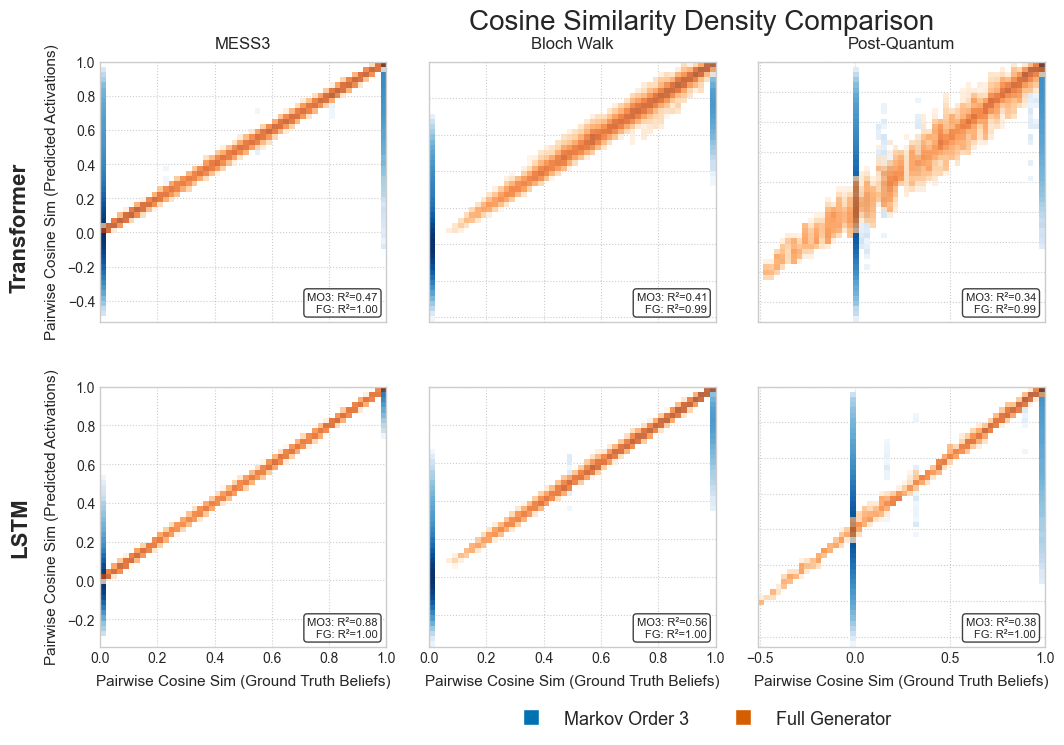


Grid processing and plotting complete.


In [228]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd # Keep pandas for potential DataFrame input convenience
from sklearn.metrics.pairwise import cosine_similarity # Ensure this is imported
from scipy.stats import linregress # For calculating R-squared
import collections
import glob
import os
import joblib
import copy # Needed for copying colormaps if modifying them
from matplotlib.colors import LogNorm # For logarithmic color scaling
from matplotlib.lines import Line2D # For creating legend handles
import matplotlib # For colormap access

# =============================================================================
#  Your Existing Helper Functions (Keep these as they are)
# =============================================================================

def nested_dict_factory():
    """Returns a defaultdict that defaults to a regular dictionary."""
    return collections.defaultdict(dict)

def get_checkpoint_list(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        prefix = 'markov3_checkpoint_'
    else:
        prefix = 'checkpoint_'
    ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, prefix + '*'))
    # sort by final number in filename
    ckpt_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    if not ckpt_files:
        raise FileNotFoundError(f"No checkpoint files found for prefix '{prefix}' in {os.path.join(RUN_DIR, EXP_FOLDER)}")
    return ckpt_files

def ground_truth(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        pattern = os.path.join(RUN_DIR, EXP_FOLDER, "markov3_ground_truth_data.joblib")
    else:
        pattern = os.path.join(RUN_DIR, EXP_FOLDER, "ground_truth_data.joblib")
    gt_files = glob.glob(pattern)
    if not gt_files:
        raise FileNotFoundError(f"No ground truth file found matching '{pattern}'")
    return joblib.load(gt_files[0])

def load_and_process_data(run_dir, exp_folder, is_markov):
    """
    Load and process data for a specific experiment. Handles potential errors.
    """
    try:
        # Get the final checkpoint file
        ckpt_files = get_checkpoint_list(run_dir, exp_folder, is_markov)
        final_ckpt_file = ckpt_files[-1]
        # print(f"{'Markov3' if is_markov else 'Non-Markov'} checkpoint:", final_ckpt_file) # Less verbose

        # Load residual beliefs from checkpoint
        ckpt_data = joblib.load(final_ckpt_file)
        if 'combined' not in ckpt_data or 'predicted_beliefs' not in ckpt_data['combined']:
             raise ValueError(f"Checkpoint file {final_ckpt_file} missing 'combined/predicted_beliefs' key.")
        resid = ckpt_data['combined']['predicted_beliefs']

        # Load ground truth data
        gt_data = ground_truth(run_dir, exp_folder, is_markov)
        if 'beliefs' not in gt_data or 'probs' not in gt_data:
             raise ValueError(f"Ground truth file for {exp_folder} missing 'beliefs' or 'probs' key.")
        gt_beliefs = gt_data['beliefs']
        probs = gt_data['probs'] # Keep probs if needed elsewhere, otherwise ignore

        # Ensure shapes match before processing
        if resid.shape[0] != gt_beliefs.shape[0]:
            raise ValueError(f"Shape mismatch: resid {resid.shape} vs gt_beliefs {gt_beliefs.shape} in {exp_folder}")

        # Mean subtract the data
        resid = resid# - np.mean(resid, axis=0)
        gt_beliefs = gt_beliefs# - np.mean(gt_beliefs, axis=0)

        return resid, gt_beliefs, probs

    except FileNotFoundError as e:
        print(f"Error loading data for {exp_folder} ({'Markov3' if is_markov else 'Non-Markov'}): {e}")
        return None, None, None # Return None to indicate failure
    except Exception as e:
        print(f"An unexpected error occurred during data loading for {exp_folder} ({'Markov3' if is_markov else 'Non-Markov'}): {e}")
        return None, None, None # Return None


def calculate_cosine_similarities(data):
    """
    Calculate cosine similarities and extract upper triangle. Returns None if input is None.
    """
    if data is None:
        return None
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(data)
    # Extract upper triangle (excluding diagonal)
    return cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

# =============================================================================
# Plotting Function for a SINGLE Subplot in the Grid (No Marginals)
# =============================================================================

def plot_single_similarity_subplot(ax_joint, # Removed marginal axes
                                   gt_markov, resid_markov,
                                   gt_nonmarkov, resid_nonmarkov,
                                   process_name, bins=50,
                                   show_title=False, # Control title visibility
                                   show_xlabel=False, show_ylabel=False,
                                   show_xticklabels=False, show_yticklabels=False):
    """
    Draws the 2D histogram and R^2 text onto provided axes. No marginals.
    Applies custom log normalization (bottom 10% density transparent).

    Args:
        ax_joint (matplotlib.axes.Axes): Axes for the central 2D histogram.
        gt_markov, resid_markov (np.array): Markov3 data.
        gt_nonmarkov, resid_nonmarkov (np.array): Full Generator data.
        process_name (str): Name of the process for the subplot title.
        bins (int): Number of bins for histograms.
        show_title (bool): Whether to show the title above this subplot.
        show_xlabel (bool): Whether to show the x-axis label on ax_joint.
        show_ylabel (bool): Whether to show the y-axis label on ax_joint.
        show_xticklabels (bool): Whether to show x-axis tick labels.
        show_yticklabels (bool): Whether to show y-axis tick labels.
    """
    # --- Style and Color Definitions ---
    color_markov = '#0072B2'    # Blue
    cmap_markov_base = matplotlib.colormaps['Blues'] # Use modern access
    color_nonmarkov = '#D55E00' # Vermillion/Orange
    cmap_nonmarkov_base = matplotlib.colormaps['Oranges'] # Use modern access
    # marginal_alpha = 0.35 # No longer needed

    # --- Create Colormaps with White Background ---
    cmap_markov = copy.copy(cmap_markov_base)
    cmap_nonmarkov = copy.copy(cmap_nonmarkov_base)
    cmap_markov.set_under('white', alpha=0)
    cmap_nonmarkov.set_under('white', alpha=0)

    # --- Filter Data ---
    valid_markov = np.isfinite(gt_markov) & np.isfinite(resid_markov)
    valid_nonmarkov = np.isfinite(gt_nonmarkov) & np.isfinite(resid_nonmarkov)

    gt_markov_valid = gt_markov[valid_markov]
    resid_markov_valid = resid_markov[valid_markov]
    gt_nonmarkov_valid = gt_nonmarkov[valid_nonmarkov]
    resid_nonmarkov_valid = resid_nonmarkov[valid_nonmarkov]

    # --- Calculate R-squared ---
    r2_markov, r2_nonmarkov = np.nan, np.nan # Default to NaN
    if np.sum(valid_markov) > 1:
        _, _, r_value_m, _, _ = linregress(gt_markov_valid, resid_markov_valid)
        r2_markov = r_value_m**2
    if np.sum(valid_nonmarkov) > 1:
        _, _, r_value_nm, _, _ = linregress(gt_nonmarkov_valid, resid_nonmarkov_valid)
        r2_nonmarkov = r_value_nm**2

    # --- Central 2D Histograms (Custom Log Scale) ---
    # Determine common range for consistent binning
    all_gt = np.concatenate([gt_markov_valid, gt_nonmarkov_valid])
    all_resid = np.concatenate([resid_markov_valid, resid_nonmarkov_valid])

    if len(all_gt) == 0 or len(all_resid) == 0:
        print(f"Warning: No valid data points for {process_name}, skipping plot.")
        ax_joint.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax_joint.transAxes, fontsize=10)
        if show_title:
             ax_joint.set_title(process_name, fontsize=12, pad=10)
        ax_joint.tick_params(labelbottom=False, labelleft=False)
        for spine in ax_joint.spines.values():
            spine.set_visible(False)
        return

    xmin, xmax = (np.min(all_gt), np.max(all_gt)) if np.ptp(all_gt) > 0 else (np.min(all_gt)-0.1, np.max(all_gt)+0.1)
    ymin, ymax = (np.min(all_resid), np.max(all_resid)) if np.ptp(all_resid) > 0 else (np.min(all_resid)-0.1, np.max(all_resid)+0.1)
    hist_range = [[xmin, xmax], [ymin, ymax]]

    # Calculate histogram counts first to determine normalization range
    H_m, _, _ = np.histogram2d(gt_markov_valid, resid_markov_valid, bins=bins, range=hist_range)
    H_nm, _, _ = np.histogram2d(gt_nonmarkov_valid, resid_nonmarkov_valid, bins=bins, range=hist_range)

    # Find combined non-zero counts
    all_counts = np.concatenate([H_m[H_m > 0], H_nm[H_nm > 0]])

    if len(all_counts) > 0:
        vmin_thresh = np.percentile(all_counts, 10)
        vmax = np.max(all_counts)
        vmin_log = max(vmin_thresh, 1e-1)
        if vmin_log >= vmax:
             vmin_log = max(vmax * 0.01, 1e-1)
        custom_norm = LogNorm(vmin=vmin_log, vmax=vmax, clip=True)
    else:
        custom_norm = LogNorm(vmin=0.1, vmax=1.0, clip=True)
        vmin_thresh = 0.1

    hist2d_args = {'bins': bins, 'range': hist_range, 'rasterized': True,
                   'norm': custom_norm, 'cmin': vmin_thresh + 1e-9}

    ax_joint.hist2d(gt_markov_valid, resid_markov_valid, cmap=cmap_markov, **hist2d_args)
    ax_joint.hist2d(gt_nonmarkov_valid, resid_nonmarkov_valid, cmap=cmap_nonmarkov, alpha=0.75, **hist2d_args)

    if show_xlabel:
        ax_joint.set_xlabel('Pairwise Cosine Sim (Ground Truth Beliefs)', fontsize=11, labelpad=6)
    if show_ylabel:
        ax_joint.set_ylabel('Pairwise Cosine Sim (Predicted Activations)', fontsize=11, labelpad=6)
    ax_joint.grid(True, linestyle=':', alpha=0.4, color='grey')
    ax_joint.tick_params(axis='both', which='major', labelsize=10)
    ax_joint.tick_params(labelbottom=show_xticklabels, labelleft=show_yticklabels)

    r2_text_markov = f"{r2_markov:.2f}" if not np.isnan(r2_markov) else "N/A"
    r2_text_nonmarkov = f"{r2_nonmarkov:.2f}" if not np.isnan(r2_nonmarkov) else "N/A"
    text_str_unicode = f"MO3: R²={r2_text_markov}\nFG: R²={r2_text_nonmarkov}"

    props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.75)
    ax_joint.text(0.97, 0.03, text_str_unicode, transform=ax_joint.transAxes, fontsize=8,
                  verticalalignment='bottom', horizontalalignment='right', bbox=props)

    if show_title:
        ax_joint.set_title(process_name, fontsize=12, pad=10)


# =============================================================================
# Main Script Logic for Creating the Grid Figure (No Marginals)
# =============================================================================

RUN_DIR = "run_predictions_RCOND_FINAL"
MAXSIZE = 1000

# Define experiment folders
transformer_folders = {
    "Post-Quantum": "20250421221507_0", 
    "MESS3": "20241205175736_23",
    "Bloch Walk": "20241205175736_17",
    # "FRDN": "20250422023003_1"  # Comment out FRDN
}
lstm_folders = {
    "Post-Quantum": "20241121152808_48", 
    "MESS3": "20241121152808_55",
    "Bloch Walk": "20241121152808_49",
    # "FRDN": "20241121152808_53"  # Comment out FRDN
}

# Comment out FRDN and reorder columns to be MESS3, Bloch Walk, Post-Quantum
process_order = ["MESS3", "Bloch Walk", "Post-Quantum"]
# process_order = ["Post-Quantum", "MESS3", "Bloch Walk", "FRDN"]

model_types = ["Transformer", "LSTM"]
model_folders = {"Transformer": transformer_folders, "LSTM": lstm_folders}

print(f'Starting processing and plotting grid (sampling to {MAXSIZE})...')

fig = plt.figure(figsize=(14, 7.5))
outer_gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.25, wspace=0.15)
plt.style.use('seaborn-v0_8-whitegrid')
all_joint_axes = np.empty((2, 4), dtype=object)

for r, model_type in enumerate(model_types):
    print(f"\n--- Processing {model_type} Models ---")
    folders = model_folders[model_type]

    for c, process_name in enumerate(process_order):
        print(f"Processing: {model_type} - {process_name}")
        ax_joint = fig.add_subplot(outer_gs[r, c])
        all_joint_axes[r, c] = ax_joint

        folder = folders.get(process_name)
        if folder is None:
            print(f"  Folder not defined for {model_type} - {process_name}, skipping.")
            ax_joint.text(0.5, 0.5, 'No Folder', ha='center', va='center', transform=ax_joint.transAxes, color='gray', fontsize=10)
            if r == 0:
                 ax_joint.set_title(process_name, fontsize=12, pad=10)
            ax_joint.tick_params(labelbottom=False, labelleft=False)
            for spine in ax_joint.spines.values():
                spine.set_visible(False)
            continue

        resid_markov, gt_beliefs_markov, _ = load_and_process_data(RUN_DIR, folder, True)
        resid_nonmarkov, gt_beliefs_nonmarkov, _ = load_and_process_data(RUN_DIR, folder, False)

        if resid_markov is None or resid_nonmarkov is None:
            print(f"  Skipping plot for {model_type} - {process_name} due to data loading errors.")
            ax_joint.text(0.5, 0.5, 'Load Error', ha='center', va='center', transform=ax_joint.transAxes, color='red', fontsize=10)
            if r == 0:
                ax_joint.set_title(process_name, fontsize=12, pad=10)
            ax_joint.tick_params(labelbottom=False, labelleft=False)
            for spine in ax_joint.spines.values():
                spine.set_visible(False)
            continue

        if len(resid_markov) > MAXSIZE:
            idx_m = np.random.choice(len(resid_markov), MAXSIZE, replace=False)
            resid_markov, gt_beliefs_markov = resid_markov[idx_m], gt_beliefs_markov[idx_m]
        if len(resid_nonmarkov) > MAXSIZE:
            idx_nm = np.random.choice(len(resid_nonmarkov), MAXSIZE, replace=False)
            resid_nonmarkov, gt_beliefs_nonmarkov = resid_nonmarkov[idx_nm], gt_beliefs_nonmarkov[idx_nm]

        gt_sim_m = calculate_cosine_similarities(gt_beliefs_markov)
        res_sim_m = calculate_cosine_similarities(resid_markov)
        gt_sim_nm = calculate_cosine_similarities(gt_beliefs_nonmarkov)
        res_sim_nm = calculate_cosine_similarities(resid_nonmarkov)

        if gt_sim_m is None or res_sim_m is None or gt_sim_nm is None or res_sim_nm is None:
            print(f"  Skipping plot for {model_type} - {process_name} due to similarity calculation errors.")
            ax_joint.text(0.5, 0.5, 'Sim Error', ha='center', va='center', transform=ax_joint.transAxes, color='red', fontsize=10)
            if r == 0:
                ax_joint.set_title(process_name, fontsize=12, pad=10)
            ax_joint.tick_params(labelbottom=False, labelleft=False)
            for spine in ax_joint.spines.values():
                spine.set_visible(False)
            continue

        show_title = (r == 0)
        show_xlabel = (r == 1)
        show_ylabel = (c == 0)
        show_xticklabels = (r == 1)
        show_yticklabels = (c == 0)

        plot_single_similarity_subplot(ax_joint,
                                       gt_sim_m, res_sim_m,
                                       gt_sim_nm, res_sim_nm,
                                       process_name,
                                       bins=50,
                                       show_title=show_title,
                                       show_xlabel=show_xlabel,
                                       show_ylabel=show_ylabel,
                                       show_xticklabels=show_xticklabels,
                                       show_yticklabels=show_yticklabels)

for c in range(all_joint_axes.shape[1]):
    col_xmin, col_xmax = np.inf, -np.inf
    col_has_valid_axes = False

    for r in range(all_joint_axes.shape[0]):
        ax = all_joint_axes[r, c]
        if ax is not None and (ax.collections or ax.lines):
            col_has_valid_axes = True
            xmin, xmax = ax.get_xlim()
            col_xmin = min(col_xmin, xmin)
            col_xmax = max(col_xmax, xmax)

    if col_has_valid_axes and np.isfinite(col_xmin):
        print(f"Column {c}: Applying shared x limits: [{col_xmin:.2f}, {col_xmax:.2f}]")
        for r in range(all_joint_axes.shape[0]):
            ax = all_joint_axes[r, c]
            if ax is not None and (ax.collections or ax.lines):
                ax.set_xlim(col_xmin, col_xmax)
    elif col_has_valid_axes:
        print(f"Column {c}: No valid x limits found, not sharing x axis.")

row_label_kwargs = dict(fontsize=16, fontweight='bold', rotation=90, ha='right', va='center')
fig.text(0.02, 0.7, model_types[0], **row_label_kwargs)
fig.text(0.02, 0.3, model_types[1], **row_label_kwargs)

legend_elements = [Line2D([0], [0], marker='s', color='w', label='Markov Order 3',
                          markerfacecolor='#0072B2', markersize=12),
                   Line2D([0], [0], marker='s', color='w', label='Full Generator',
                          markerfacecolor='#D55E00', markersize=12)]

fig.legend(handles=legend_elements, loc='lower center',
           bbox_to_anchor=(0.5, 0.01),
           ncol=2, frameon=False, fontsize=13)

fig.suptitle('Cosine Similarity Density Comparison', fontsize=20, y=0.99)

fig.subplots_adjust(left=0.07, bottom=0.14, right=0.98, top=0.92)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.savefig("belief_grid_RSA_v2.svg", format="svg")
plt.show()

print("\nGrid processing and plotting complete.")


Starting processing and plotting grid (sampling to 1000)...

--- Processing Transformer Models ---
Processing: Transformer - MESS3
Processing: Transformer - Bloch Walk
Processing: Transformer - Post-Quantum

--- Processing LSTM Models ---
Processing: LSTM - MESS3
Processing: LSTM - Bloch Walk
Processing: LSTM - Post-Quantum
Column 0: Applying shared x limits: [0.00, 1.00]
Column 1: Applying shared x limits: [0.00, 1.00]
Column 2: Applying shared x limits: [-0.46, 1.00]


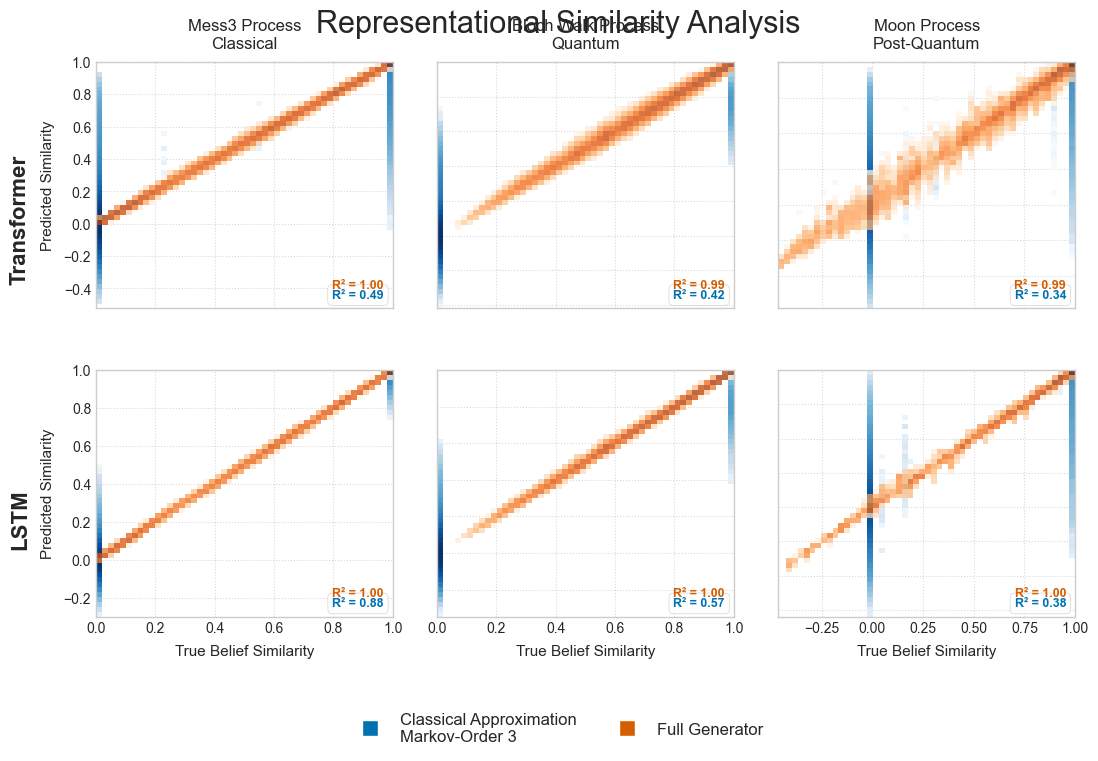


Grid processing and plotting complete.


In [232]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd # Keep pandas for potential DataFrame input convenience
from sklearn.metrics.pairwise import cosine_similarity # Ensure this is imported
from scipy.stats import linregress # For calculating R-squared
import collections
import glob
import os
import joblib
import copy # Needed for copying colormaps if modifying them
from matplotlib.colors import LogNorm # For logarithmic color scaling
from matplotlib.lines import Line2D # For creating legend handles
import matplotlib # For colormap access

# =============================================================================
#  Your Existing Helper Functions (Keep these as they are)
# =============================================================================

def nested_dict_factory():
    """Returns a defaultdict that defaults to a regular dictionary."""
    return collections.defaultdict(dict)

def get_checkpoint_list(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        prefix = 'markov3_checkpoint_'
    else:
        prefix = 'checkpoint_'
    ckpt_files = glob.glob(os.path.join(RUN_DIR, EXP_FOLDER, prefix + '*'))
    # sort by final number in filename
    ckpt_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    if not ckpt_files:
        raise FileNotFoundError(f"No checkpoint files found for prefix '{prefix}' in {os.path.join(RUN_DIR, EXP_FOLDER)}")
    return ckpt_files

def ground_truth(RUN_DIR, EXP_FOLDER, is_markov):
    if is_markov:
        pattern = os.path.join(RUN_DIR, EXP_FOLDER, "markov3_ground_truth_data.joblib")
    else:
        pattern = os.path.join(RUN_DIR, EXP_FOLDER, "ground_truth_data.joblib")
    gt_files = glob.glob(pattern)
    if not gt_files:
        raise FileNotFoundError(f"No ground truth file found matching '{pattern}'")
    return joblib.load(gt_files[0])

def load_and_process_data(run_dir, exp_folder, is_markov):
    """
    Load and process data for a specific experiment. Handles potential errors.
    """
    try:
        # Get the final checkpoint file
        ckpt_files = get_checkpoint_list(run_dir, exp_folder, is_markov)
        final_ckpt_file = ckpt_files[-1]
        # print(f"{'Markov3' if is_markov else 'Non-Markov'} checkpoint:", final_ckpt_file) # Less verbose

        # Load residual beliefs from checkpoint
        ckpt_data = joblib.load(final_ckpt_file)
        if 'combined' not in ckpt_data or 'predicted_beliefs' not in ckpt_data['combined']:
             raise ValueError(f"Checkpoint file {final_ckpt_file} missing 'combined/predicted_beliefs' key.")
        resid = ckpt_data['combined']['predicted_beliefs']

        # Load ground truth data
        gt_data = ground_truth(run_dir, exp_folder, is_markov)
        if 'beliefs' not in gt_data or 'probs' not in gt_data:
             raise ValueError(f"Ground truth file for {exp_folder} missing 'beliefs' or 'probs' key.")
        gt_beliefs = gt_data['beliefs']
        probs = gt_data['probs'] # Keep probs if needed elsewhere, otherwise ignore

        # Ensure shapes match before processing
        if resid.shape[0] != gt_beliefs.shape[0]:
            raise ValueError(f"Shape mismatch: resid {resid.shape} vs gt_beliefs {gt_beliefs.shape} in {exp_folder}")

        # Mean subtract the data
        resid = resid# - np.mean(resid, axis=0)
        gt_beliefs = gt_beliefs# - np.mean(gt_beliefs, axis=0)

        return resid, gt_beliefs, probs

    except FileNotFoundError as e:
        print(f"Error loading data for {exp_folder} ({'Markov3' if is_markov else 'Non-Markov'}): {e}")
        return None, None, None # Return None to indicate failure
    except Exception as e:
        print(f"An unexpected error occurred during data loading for {exp_folder} ({'Markov3' if is_markov else 'Non-Markov'}): {e}")
        return None, None, None # Return None


def calculate_cosine_similarities(data):
    """
    Calculate cosine similarities and extract upper triangle. Returns None if input is None.
    """
    if data is None:
        return None
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(data)
    # Extract upper triangle (excluding diagonal)
    return cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

# =============================================================================
# Plotting Function for a SINGLE Subplot in the Grid (No Marginals)
# =============================================================================

def plot_single_similarity_subplot(ax_joint, # Removed marginal axes
                                   gt_markov, resid_markov,
                                   gt_nonmarkov, resid_nonmarkov,
                                   process_name, bins=50,
                                   show_title=False, # Control title visibility
                                   show_xlabel=False, show_ylabel=False,
                                   show_xticklabels=False, show_yticklabels=False):
    """
    Draws the 2D histogram and R^2 text onto provided axes. No marginals.
    Applies custom log normalization (bottom 10% density transparent).

    Args:
        ax_joint (matplotlib.axes.Axes): Axes for the central 2D histogram.
        gt_markov, resid_markov (np.array): Markov3 data.
        gt_nonmarkov, resid_nonmarkov (np.array): Full Generator data.
        process_name (str): Name of the process for the subplot title.
        bins (int): Number of bins for histograms.
        show_title (bool): Whether to show the title above this subplot.
        show_xlabel (bool): Whether to show the x-axis label on ax_joint.
        show_ylabel (bool): Whether to show the y-axis label on ax_joint.
        show_xticklabels (bool): Whether to show x-axis tick labels.
        show_yticklabels (bool): Whether to show y-axis tick labels.
    """
    # --- Style and Color Definitions ---
    color_markov = '#0072B2'    # Blue
    cmap_markov_base = matplotlib.colormaps['Blues'] # Use modern access
    color_nonmarkov = '#D55E00' # Vermillion/Orange
    cmap_nonmarkov_base = matplotlib.colormaps['Oranges'] # Use modern access
    # marginal_alpha = 0.35 # No longer needed

    # --- Create Colormaps with White Background ---
    cmap_markov = copy.copy(cmap_markov_base)
    cmap_nonmarkov = copy.copy(cmap_nonmarkov_base)
    cmap_markov.set_under('white', alpha=0) # Make values below threshold transparent
    cmap_nonmarkov.set_under('white', alpha=0)

    # --- Filter Data ---
    valid_markov = np.isfinite(gt_markov) & np.isfinite(resid_markov)
    valid_nonmarkov = np.isfinite(gt_nonmarkov) & np.isfinite(resid_nonmarkov)

    gt_markov_valid = gt_markov[valid_markov]
    resid_markov_valid = resid_markov[valid_markov]
    gt_nonmarkov_valid = gt_nonmarkov[valid_nonmarkov]
    resid_nonmarkov_valid = resid_nonmarkov[valid_nonmarkov]

    # --- Calculate R-squared ---
    r2_markov, r2_nonmarkov = np.nan, np.nan # Default to NaN
    if np.sum(valid_markov) > 1:
        _, _, r_value_m, _, _ = linregress(gt_markov_valid, resid_markov_valid)
        r2_markov = r_value_m**2
    if np.sum(valid_nonmarkov) > 1:
        _, _, r_value_nm, _, _ = linregress(gt_nonmarkov_valid, resid_nonmarkov_valid)
        r2_nonmarkov = r_value_nm**2

    # --- Central 2D Histograms (Custom Log Scale) ---
    # Determine common range for consistent binning
    all_gt = np.concatenate([gt_markov_valid, gt_nonmarkov_valid])
    all_resid = np.concatenate([resid_markov_valid, resid_nonmarkov_valid])

    if len(all_gt) == 0 or len(all_resid) == 0:
        print(f"Warning: No valid data points for {process_name}, skipping plot.")
        ax_joint.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax_joint.transAxes, fontsize=10) # Larger text
        if show_title:
             ax_joint.set_title(process_name, fontsize=12, pad=10) # Larger title, less padding needed
        ax_joint.tick_params(labelbottom=False, labelleft=False) # Hide ticks if no data
        # Turn off spines for empty plots for consistency
        for spine in ax_joint.spines.values():
            spine.set_visible(False)
        return

    xmin, xmax = (np.min(all_gt), np.max(all_gt)) if np.ptp(all_gt) > 0 else (np.min(all_gt)-0.1, np.max(all_gt)+0.1)
    ymin, ymax = (np.min(all_resid), np.max(all_resid)) if np.ptp(all_resid) > 0 else (np.min(all_resid)-0.1, np.max(all_resid)+0.1)
    hist_range = [[xmin, xmax], [ymin, ymax]]

    # Calculate histogram counts first to determine normalization range
    H_m, _, _ = np.histogram2d(gt_markov_valid, resid_markov_valid, bins=bins, range=hist_range)
    H_nm, _, _ = np.histogram2d(gt_nonmarkov_valid, resid_nonmarkov_valid, bins=bins, range=hist_range)

    # Find combined non-zero counts
    all_counts = np.concatenate([H_m[H_m > 0], H_nm[H_nm > 0]])

    if len(all_counts) > 0:
        # Calculate 10th percentile of non-zero counts as threshold
        vmin_thresh = np.percentile(all_counts, 10)
        vmax = np.max(all_counts)
        # Ensure vmin is positive for LogNorm, use a very small number if percentile is 0 or negative
        vmin_log = max(vmin_thresh, 1e-1)
        if vmin_log >= vmax: # Handle edge case where threshold >= max
             vmin_log = max(vmax * 0.01, 1e-1) # Use 1% of max or small number

        custom_norm = LogNorm(vmin=vmin_log, vmax=vmax, clip=True)
    else:
        # Default norm if no data or only zero counts
        custom_norm = LogNorm(vmin=0.1, vmax=1.0, clip=True)
        vmin_thresh = 0.1 # Set threshold for cmin consistency

    # Plotting parameters for hist2d
    # Use the calculated norm. cmin ensures bins exactly AT the threshold are also transparent.
    hist2d_args = {'bins': bins, 'range': hist_range, 'rasterized': True,
                   'norm': custom_norm, 'cmin': vmin_thresh + 1e-9} # Use norm, set cmin slightly above threshold

    # Plot Markov3 data
    ax_joint.hist2d(gt_markov_valid, resid_markov_valid, cmap=cmap_markov, **hist2d_args)
    # Plot Non-Markov data (overlay with alpha)
    ax_joint.hist2d(gt_nonmarkov_valid, resid_nonmarkov_valid, cmap=cmap_nonmarkov, alpha=0.75, **hist2d_args)

    # Labels and Grid for central plot only
    if show_xlabel:
        # Shorter X Label
        ax_joint.set_xlabel('True Belief Similarity', fontsize=11, labelpad=6)
    if show_ylabel:
        # Shorter Y Label
        ax_joint.set_ylabel('Predicted Similarity', fontsize=11, labelpad=6)
    ax_joint.grid(True, linestyle=':', alpha=0.3, color='grey') # Even more subtle grid

    # Control tick label visibility
    ax_joint.tick_params(axis='both', which='major', labelsize=10) # Larger
    ax_joint.tick_params(labelbottom=show_xticklabels, labelleft=show_yticklabels)

    # --- Add R-squared Text (Colored and Streamlined) ---
    # Position text box in bottom right corner
    # Create colored R² values
    props = dict(boxstyle='round,pad=0.35', facecolor='white', alpha=0.85, edgecolor='#cccccc', linewidth=0.5)
    
    # Format R² values with colors
    r2_text_lines = []
    if not np.isnan(r2_markov):
        r2_text_lines.append(f"R² = {r2_markov:.2f}")
    else:
        r2_text_lines.append("R² = N/A")
    
    if not np.isnan(r2_nonmarkov):
        r2_text_lines.append(f"R² = {r2_nonmarkov:.2f}")
    else:
        r2_text_lines.append("R² = N/A")
    
    # Create text with different colors for each line
    text_y_start = 0.03
    for i, (text, color) in enumerate(zip(r2_text_lines, [color_markov, color_nonmarkov])):
        ax_joint.text(0.97, text_y_start + i*0.04, text, transform=ax_joint.transAxes, 
                      fontsize=9, color=color, weight='bold',
                      verticalalignment='bottom', horizontalalignment='right',
                      bbox=props if i == 0 else None) # Only add box to first line

    # --- Marginal Histograms Removed ---

    # --- Clean up Marginal Axes Removed ---

    # --- Subplot Title ---
    if show_title:
        ax_joint.set_title(process_name, fontsize=12, pad=10) # Larger title, less padding needed now


# =============================================================================
# Main Script Logic for Creating the Grid Figure (No Marginals)
# =============================================================================

RUN_DIR = "run_predictions_RCOND_FINAL" # Make sure this path is correct
MAXSIZE = 1000 # Keep sampling for efficiency

# Define experiment folders
transformer_folders = {
    "Post-Quantum": "20250421221507_0", "MESS3": "20241205175736_23",
    "Bloch Walk": "20241205175736_17", "FRDN": "20250422023003_1"
}
lstm_folders = {
    "Post-Quantum": "20241121152808_48", "MESS3": "20241121152808_55",
    "Bloch Walk": "20241121152808_49", "FRDN": "20241121152808_53"
}

# Define the order of processes for columns - FRDN commented out, reordered
# process_order = ["Post-Quantum", "MESS3", "Bloch Walk", "FRDN"]
process_order = ["MESS3", "Bloch Walk", "Post-Quantum"]  # New order without FRDN

# Process display names with type labels
process_display_names = {
    "MESS3": "Mess3 Process\nClassical",
    "Bloch Walk": "Bloch Walk Process\nQuantum", 
    "Post-Quantum": "Moon Process\nPost-Quantum"
}
model_types = ["Transformer", "LSTM"]
model_folders = {"Transformer": transformer_folders, "LSTM": lstm_folders}

print(f'Starting processing and plotting grid (sampling to {MAXSIZE})...')

# --- Create the main figure and GridSpec layout ---
# Adjusted figure size for 3 columns instead of 4
fig = plt.figure(figsize=(11, 7.5))  # Reduced width from 14 to 11

# Outer grid - now 2x3 instead of 2x4
outer_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.25, wspace=0.15) # 3 columns now

# Use a consistent style
plt.style.use('seaborn-v0_8-whitegrid')

# Store axes for sharing limits - now 2x3
all_joint_axes = np.empty((2, 3), dtype=object)

# --- Loop through models (rows) and processes (columns) ---
for r, model_type in enumerate(model_types):
    print(f"\n--- Processing {model_type} Models ---")
    folders = model_folders[model_type]

    for c, process_name in enumerate(process_order):
        print(f"Processing: {model_type} - {process_name}")
        folder = folders.get(process_name)
        
        # Get display name for this process
        display_name = process_display_names.get(process_name, process_name)

        # --- Create Axes (No Inner GridSpec needed) ---
        ax_joint = fig.add_subplot(outer_gs[r, c])
        all_joint_axes[r, c] = ax_joint # Store axis

        if folder is None:
            print(f"  Folder not defined for {model_type} - {process_name}, skipping.")
            ax_joint.text(0.5, 0.5, 'No Folder', ha='center', va='center', transform=ax_joint.transAxes, color='gray', fontsize=10)
            # Only show title if it's the top row
            if r == 0:
                 ax_joint.set_title(display_name, fontsize=12, pad=10) # Use display name
            ax_joint.tick_params(labelbottom=False, labelleft=False)
            # Turn off spines for empty plots
            for spine in ax_joint.spines.values():
                spine.set_visible(False)
            continue


        # --- Load Data ---
        resid_markov, gt_beliefs_markov, _ = load_and_process_data(RUN_DIR, folder, True)
        resid_nonmarkov, gt_beliefs_nonmarkov, _ = load_and_process_data(RUN_DIR, folder, False)

        if resid_markov is None or resid_nonmarkov is None:
             print(f"  Skipping plot for {model_type} - {process_name} due to data loading errors.")
             ax_joint.text(0.5, 0.5, 'Load Error', ha='center', va='center', transform=ax_joint.transAxes, color='red', fontsize=10)
             if r == 0:
                 ax_joint.set_title(display_name, fontsize=12, pad=10) # Use display name
             ax_joint.tick_params(labelbottom=False, labelleft=False)
             for spine in ax_joint.spines.values():
                spine.set_visible(False)
             continue

        # --- Sampling ---
        if len(resid_markov) > MAXSIZE:
            # print(f'  Sampling {MAXSIZE} points from Markov3 data.') # Less verbose
            idx_m = np.random.choice(len(resid_markov), MAXSIZE, replace=False)
            resid_markov, gt_beliefs_markov = resid_markov[idx_m], gt_beliefs_markov[idx_m]
        if len(resid_nonmarkov) > MAXSIZE:
            # print(f'  Sampling {MAXSIZE} points from Non-Markov data.') # Less verbose
            idx_nm = np.random.choice(len(resid_nonmarkov), MAXSIZE, replace=False)
            resid_nonmarkov, gt_beliefs_nonmarkov = resid_nonmarkov[idx_nm], gt_beliefs_nonmarkov[idx_nm]

        # --- Calculate Cosine Similarities ---
        gt_sim_m = calculate_cosine_similarities(gt_beliefs_markov)
        res_sim_m = calculate_cosine_similarities(resid_markov)
        gt_sim_nm = calculate_cosine_similarities(gt_beliefs_nonmarkov)
        res_sim_nm = calculate_cosine_similarities(resid_nonmarkov)

        if gt_sim_m is None or res_sim_m is None or gt_sim_nm is None or res_sim_nm is None:
            print(f"  Skipping plot for {model_type} - {process_name} due to similarity calculation errors.")
            ax_joint.text(0.5, 0.5, 'Sim Error', ha='center', va='center', transform=ax_joint.transAxes, color='red', fontsize=10)
            if r == 0:
                ax_joint.set_title(display_name, fontsize=12, pad=10) # Use display name
            ax_joint.tick_params(labelbottom=False, labelleft=False)
            for spine in ax_joint.spines.values():
                spine.set_visible(False)
            continue

        # --- Plot on the created axes ---
        show_title = (r == 0) # Show title only for the top row (r=0)
        show_xlabel = (r == 1) # Show x-label only for the bottom row
        show_ylabel = (c == 0) # Show y-label only for the left column
        show_xticklabels = (r == 1) # Show x-ticks only for the bottom row
        show_yticklabels = (c == 0) # Show y-ticks only for the left column

        plot_single_similarity_subplot(ax_joint, # Pass only the main axis
                                       gt_sim_m, res_sim_m,
                                       gt_sim_nm, res_sim_nm,
                                       display_name,  # Use display name instead
                                       bins=50,
                                       show_title=show_title, # Control title visibility
                                       show_xlabel=show_xlabel,
                                       show_ylabel=show_ylabel,
                                       show_xticklabels=show_xticklabels,
                                       show_yticklabels=show_yticklabels)

# --- Share x axes within columns only ---
# Process each column separately
for c in range(all_joint_axes.shape[1]):  # Iterate through columns
    # Find column-specific x limits
    col_xmin, col_xmax = np.inf, -np.inf
    col_has_valid_axes = False
    
    # First pass: determine column-specific x limits
    for r in range(all_joint_axes.shape[0]):  # Iterate through rows in this column
        ax = all_joint_axes[r, c]
        if ax is not None and (ax.collections or ax.lines):
            col_has_valid_axes = True
            xmin, xmax = ax.get_xlim()
            col_xmin = min(col_xmin, xmin)
            col_xmax = max(col_xmax, xmax)
    
    # Second pass: apply column-specific x limits
    if col_has_valid_axes and np.isfinite(col_xmin):
        print(f"Column {c}: Applying shared x limits: [{col_xmin:.2f}, {col_xmax:.2f}]")
        for r in range(all_joint_axes.shape[0]):
            ax = all_joint_axes[r, c]
            if ax is not None and (ax.collections or ax.lines):
                ax.set_xlim(col_xmin, col_xmax)
    elif col_has_valid_axes:
        print(f"Column {c}: No valid x limits found, not sharing x axis.")


# --- Add Row Labels ---
row_label_kwargs = dict(fontsize=16, fontweight='bold', rotation=90, ha='right', va='center') # Larger
fig.text(0.02, 0.7, model_types[0], **row_label_kwargs) # Adjusted x pos slightly
fig.text(0.02, 0.3, model_types[1], **row_label_kwargs) # Adjusted x pos slightly


# --- Add Shared Legend Below Grid ---
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Classical Approximation\nMarkov-Order 3',
                          markerfacecolor='#0072B2', markersize=12), # Blue, Larger marker
                   Line2D([0], [0], marker='s', color='w', label='Full Generator',
                          markerfacecolor='#D55E00', markersize=12)] # Orange, Larger marker

fig.legend(handles=legend_elements, loc='lower center',
           bbox_to_anchor=(0.5, -0.02), # Moved down slightly for multi-line
           ncol=2, frameon=False, fontsize=12) # Slightly smaller for multi-line


# --- Overall Figure Title ---
fig.suptitle('Representational Similarity Analysis', fontsize=22, y=0.98, weight='light') # More elegant title

# --- Final Adjustments ---
# Adjust spacing - adjusted for legend and beautification
fig.subplots_adjust(left=0.08, bottom=0.17, right=0.97, top=0.91) # Adjusted for multi-line legend

# Set style parameters before saving
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.linewidth'] = 0.8  # Thinner axes
plt.rcParams['axes.edgecolor'] = '#333333'  # Darker gray axes

plt.savefig("belief_grid_RSA_v2.svg", format="svg")

plt.show()

print("\nGrid processing and plotting complete.")

In [234]:
#!/usr/bin/env python3
"""
Dump model configurations to a text file for documentation.
"""

from epsilon_transformers.analysis.load_data import S3ModelLoader
import json
import pprint

def dump_configs_to_file():
    """Extract and dump configurations to a text file."""
    
    # Initialize S3 loader
    s3_loader = S3ModelLoader(use_company_credentials=True)
    
    # Define all the sweep/run pairs from the regression analysis
    model_runs = [
        # Transformers
        ("20241205175736", "run_23_L4_H4_DH16_DM64_mess3", "Transformer - Mess3"),
        ("20250422023003", "run_1_L1_H8_DH8_DM64_fanizza", "Transformer - Fanizza"),
        ("20241205175736", "run_17_L4_H4_DH16_DM64_tom_quantum", "Transformer - Tom Quantum"),
        ("20250421221507", "run_0_L4_H8_DH8_DM64_post_quantum", "Transformer - Post Quantum"),
        
        # LSTMs
        ("20241121152808", "run_55_L4_H64_LSTM_uni_mess3", "LSTM - Mess3"),
        ("20241121152808", "run_53_L4_H64_LSTM_uni_fanizza", "LSTM - Fanizza"),
        ("20241121152808", "run_49_L4_H64_LSTM_uni_tom_quantum", "LSTM - Tom Quantum"),
        ("20241121152808", "run_48_L4_H64_LSTM_uni_post_quantum", "LSTM - Post Quantum"),
    ]
    
    with open('model_configs_dump.txt', 'w') as f:
        f.write("="*80 + "\n")
        f.write("MODEL CONFIGURATIONS DUMP\n")
        f.write("="*80 + "\n\n")
        
        for sweep_id, run_id, description in model_runs:
            f.write("\n" + "="*60 + "\n")
            f.write(f"{description}\n")
            f.write(f"Sweep: {sweep_id}, Run: {run_id}\n")
            f.write("="*60 + "\n\n")
            
            try:
                # Get checkpoints
                checkpoints = s3_loader.list_checkpoints(sweep_id, run_id)
                f.write(f"Total checkpoints: {len(checkpoints)}\n\n")
                
                # Load the first checkpoint to get configuration
                model, run_config = s3_loader.load_checkpoint(
                    sweep_id, 
                    run_id, 
                    checkpoints[0],
                    device='cpu'
                )
                
                # Pretty print the entire configuration
                f.write("Full Configuration:\n")
                f.write("-"*40 + "\n")
                f.write(pprint.pformat(run_config, indent=2, width=120))
                f.write("\n\n")
                
                # Also save as JSON for easier parsing
                f.write("JSON Format:\n")
                f.write("-"*40 + "\n")
                f.write(json.dumps(run_config, indent=2))
                f.write("\n\n")
                
            except Exception as e:
                f.write(f"ERROR loading configuration: {str(e)}\n\n")
    
    print("Configurations dumped to model_configs_dump.txt")

if __name__ == "__main__":
    dump_configs_to_file()

Configurations dumped to model_configs_dump.txt


In [49]:
import plotly.express as px
import plotly.graph_objects as go

# if the shape of dist has more than 1 dimension, take mean across the last dimension
if len(dist.shape) > 1:
    dist = np.mean(dist, axis=-1)

# Create a scatter plot with plotly
fig = px.scatter(x=loss, y=dist, labels={'x': 'Loss', 'y': 'Distance'})

# Customize the layout if needed
fig.update_layout(
    template='plotly_white',
    title='Distance vs Loss',
    xaxis_title='Loss',
    yaxis_title='Distance'
)

# Display the plot
fig.show()


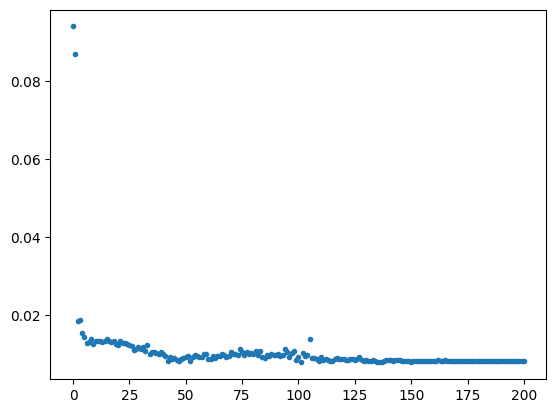

In [50]:
plt.plot(dist,'.')

In [52]:
# get predction for last checkpoint
last_checkpoint = available_checkpoints[-1]
last_prediction = pred_data[last_checkpoint]['combined']['predicted_beliefs']
print(last_prediction)

[[ 3.3332357e-01  3.3331168e-01  8.4489584e-06  1.6667885e-01
   1.6667652e-01]
 [ 3.3327213e-01  3.3349168e-01  1.4315546e-04 -1.3628602e-04
   3.3321840e-01]
 [ 5.0013822e-01  2.5004387e-01 -3.9198995e-04  1.2394786e-04
   2.5008541e-01]
 ...
 [ 9.6980715e-01  1.2569584e-02  4.0967017e-03  1.3989404e-02
  -4.6281517e-04]
 [ 3.7476718e-02 -5.5539608e-04 -1.7032519e-02 -1.0230884e-02
   9.9034202e-01]
 [ 1.0223460e+00 -2.8160244e-02  7.7274591e-03  1.7632544e-03
  -3.6771446e-03]]


In [53]:
# Create a 3D scatter plot of the first 3 dimensions of last_prediction
import plotly.express as px

# Extract the first 3 dimensions
first_3_dims = last_prediction[:, :3]

# Create a 3D scatter plot
fig = px.scatter_3d(
    x=first_3_dims[:, 0],
    y=first_3_dims[:, 1],
    z=first_3_dims[:, 2],
    labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'z': 'Dimension 3'},
    title='First 3 Dimensions of Predicted Beliefs'
)

# Customize the layout
fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    )
)

# Display the plot
fig.show()